This Notebook lives at [Github](https://github.com/petermchale/pong_RL).

## Reinforcement Learning

Reinforcement Learning (RL) is a branch of machine learning in which an agent (robot) learns how to act in an environment so as to receive positive rewards: 

![](images/action_observation_reward.png)

The relation between actions and the environment is defined by a "policy": a rule that prescribes how the agent should act given that the environment is observed to be in a certain state. The policy may be stochastic, in which case it gives the probability of taking a certain action given a certain state. 






## Atari pong

In this game, you (the agent) compete against a game simulator (the environment) by moving a paddle up and down (the actions). 



[2017-09-19 16:24:17,698] Making new env: Pong-v0



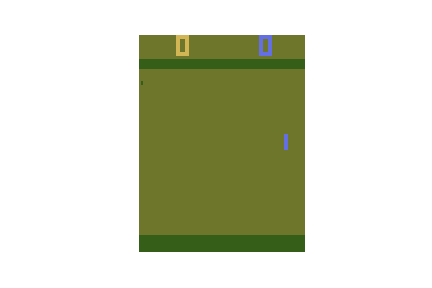
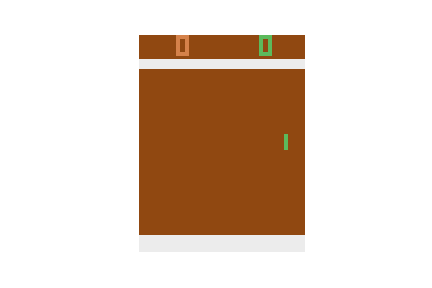
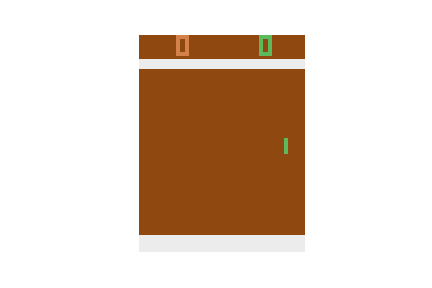
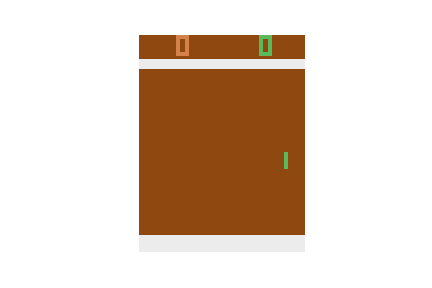
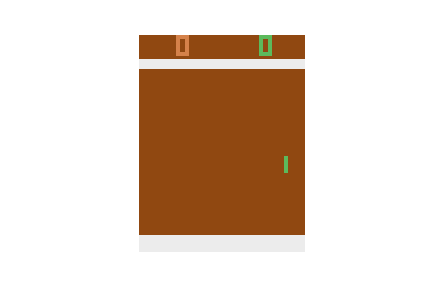
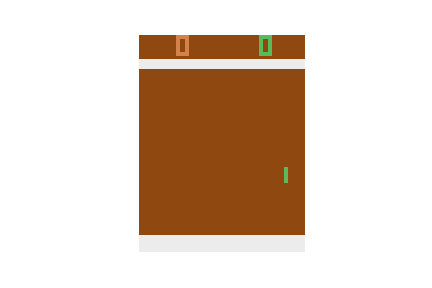
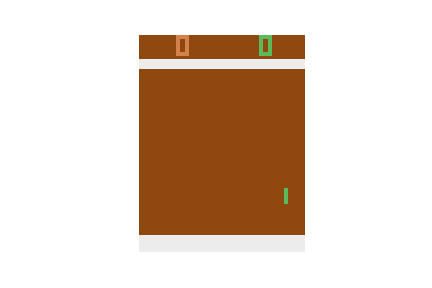
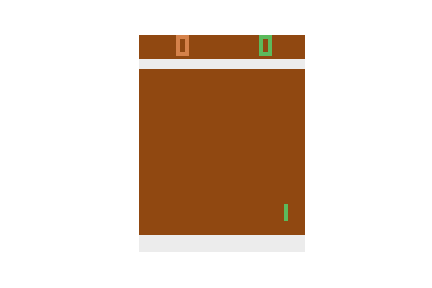
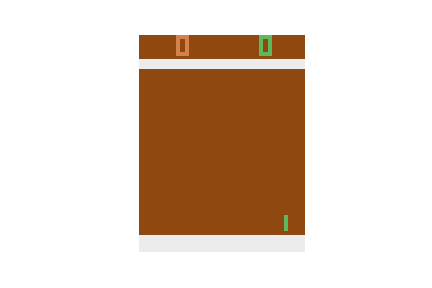
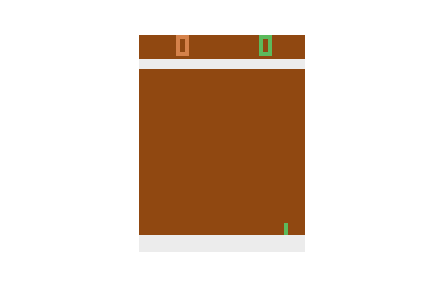
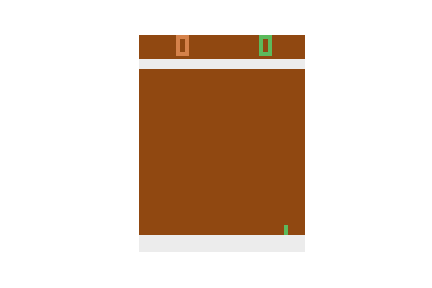
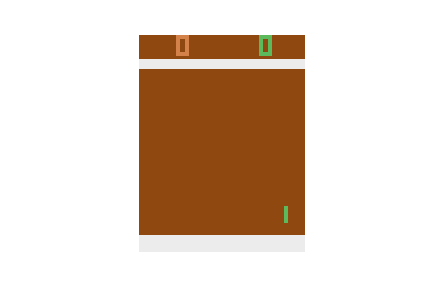
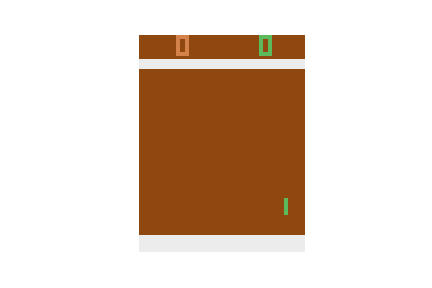
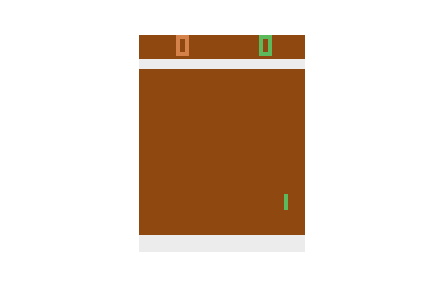
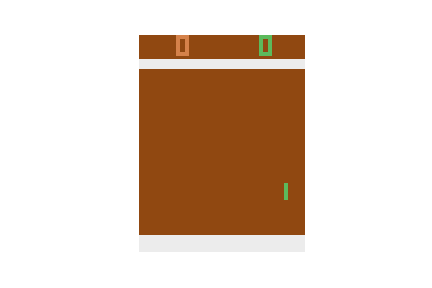
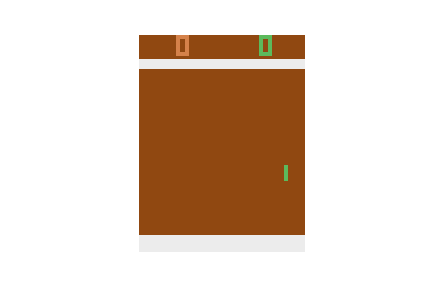
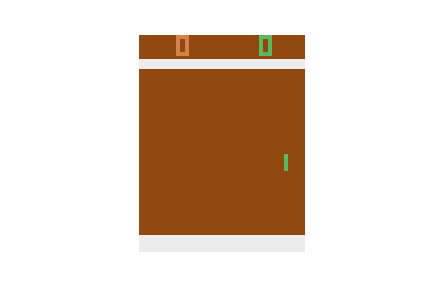
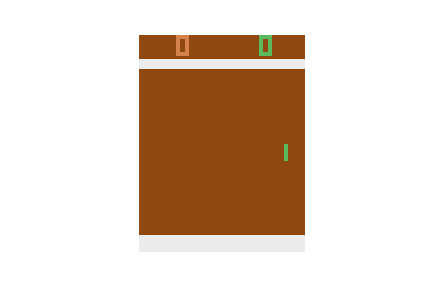
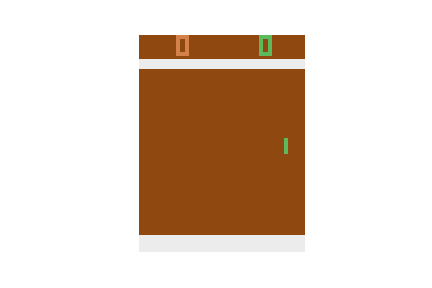
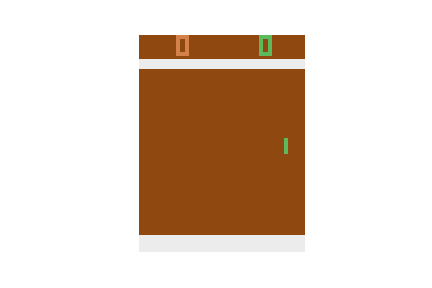
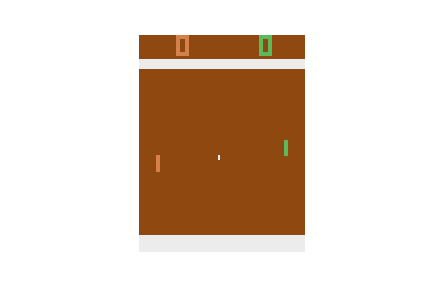
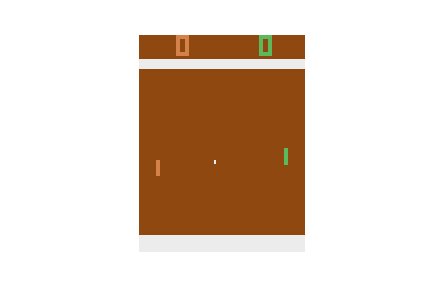
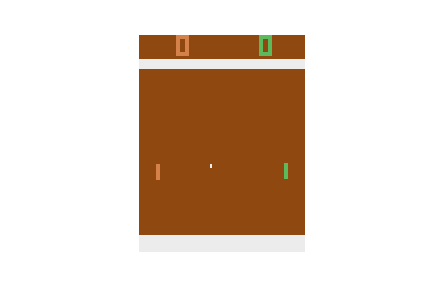
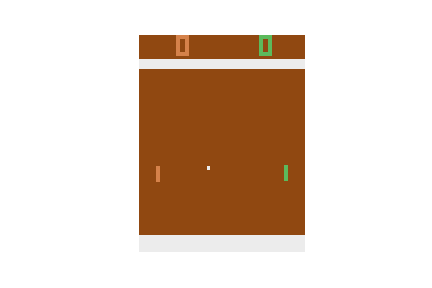
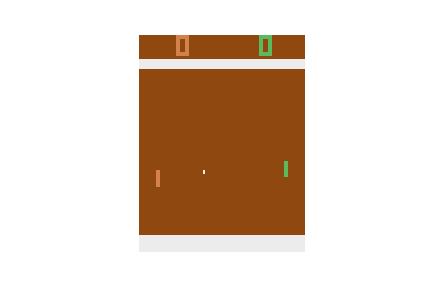
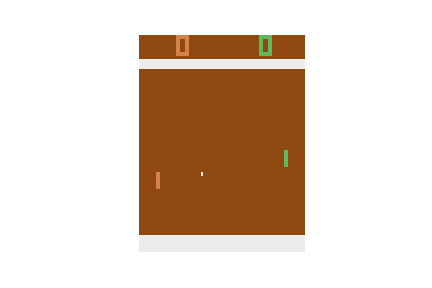
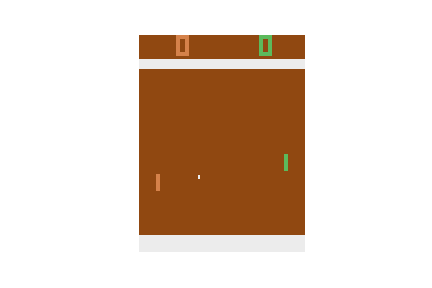
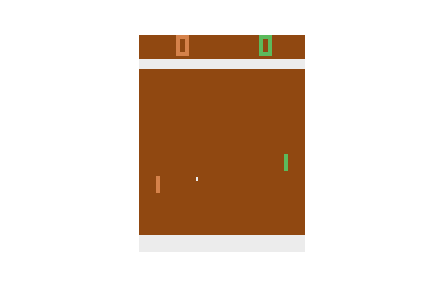
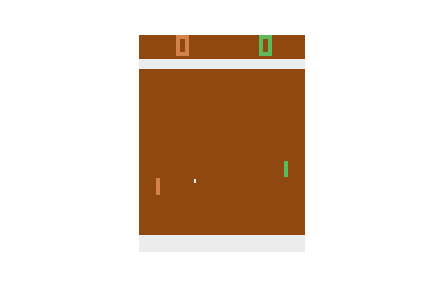
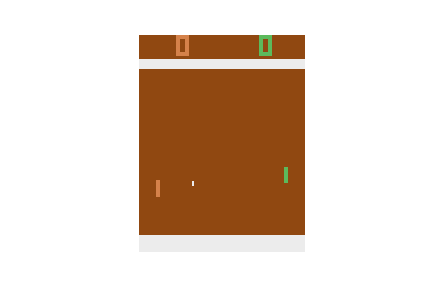
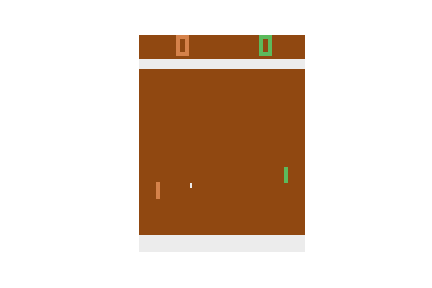
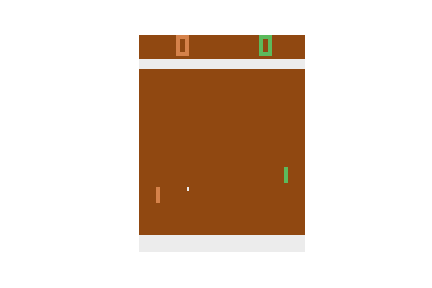
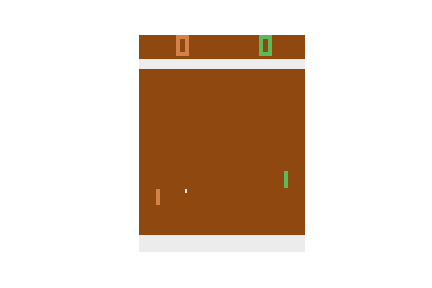
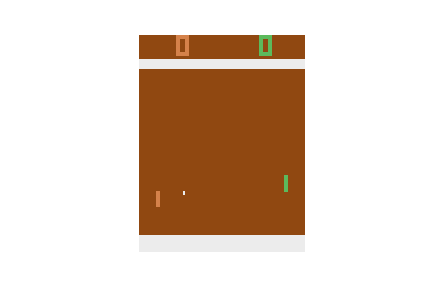
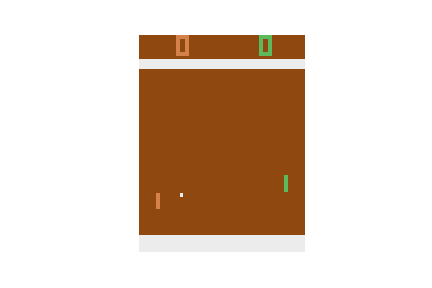
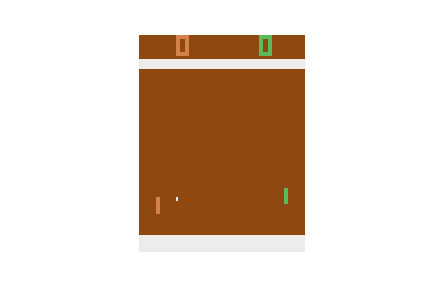
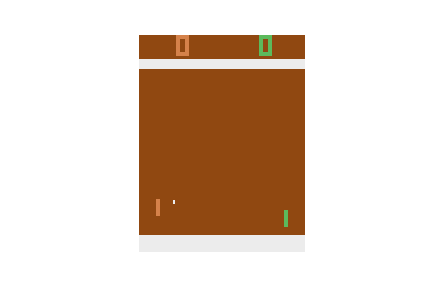
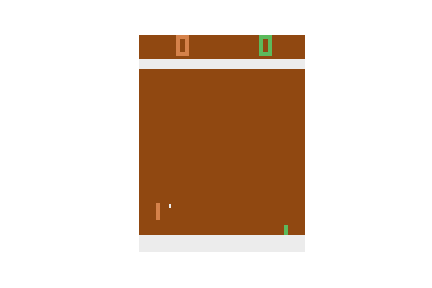
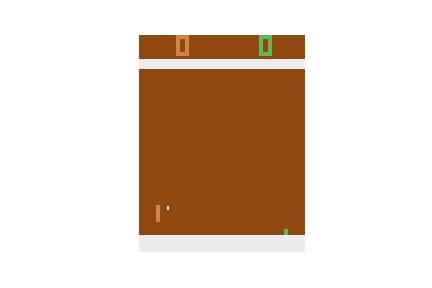
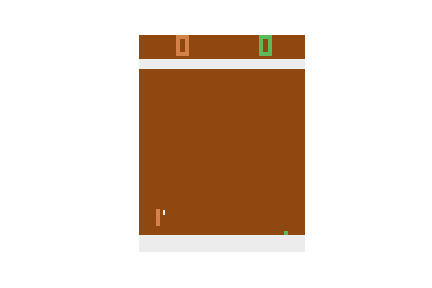
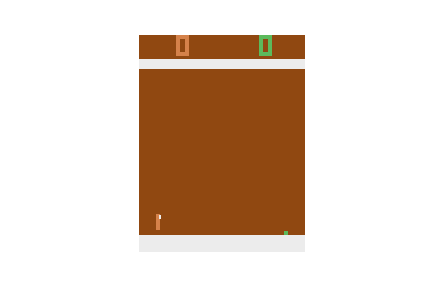
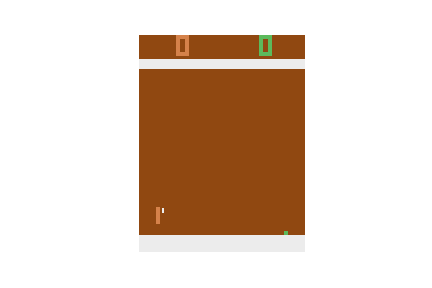
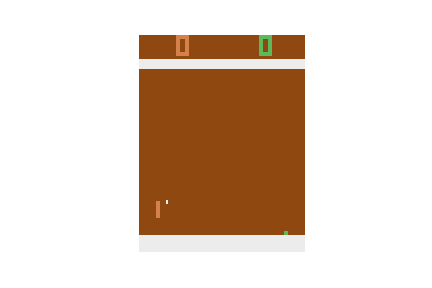
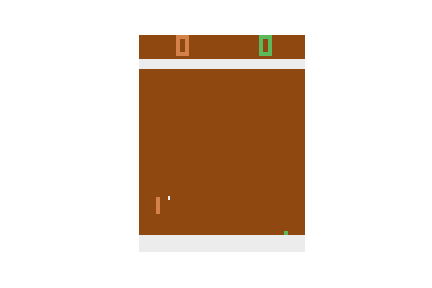
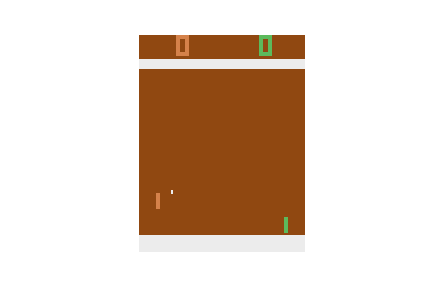
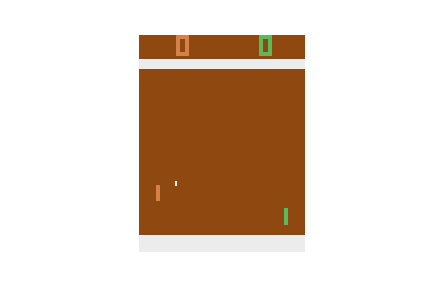
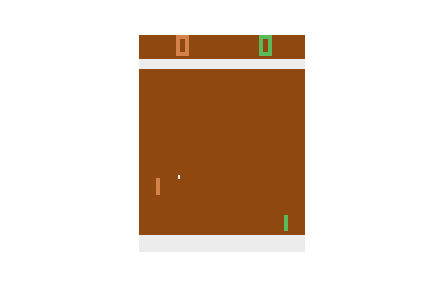
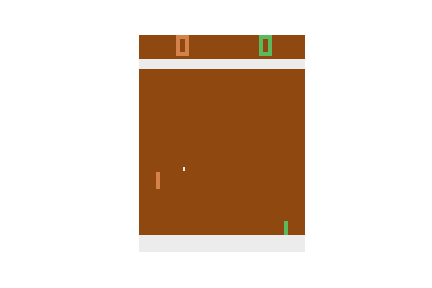
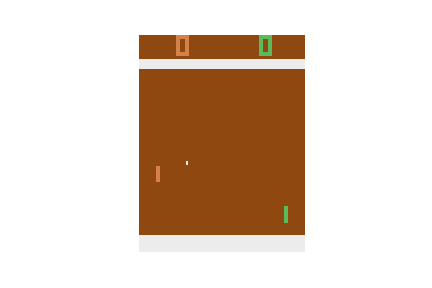
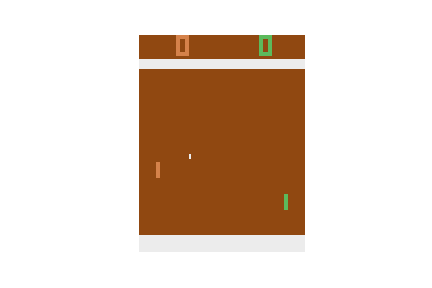
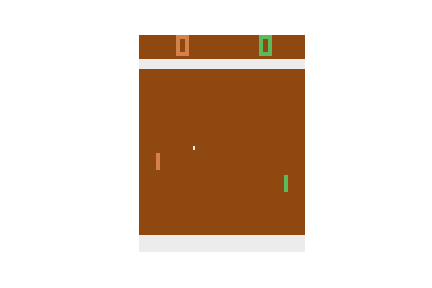
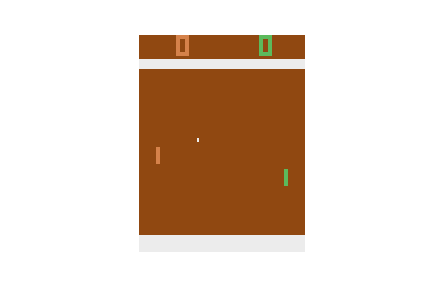
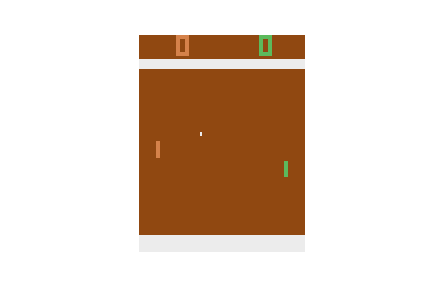
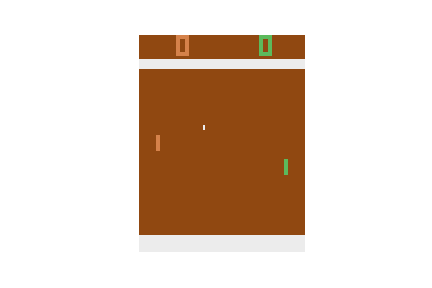
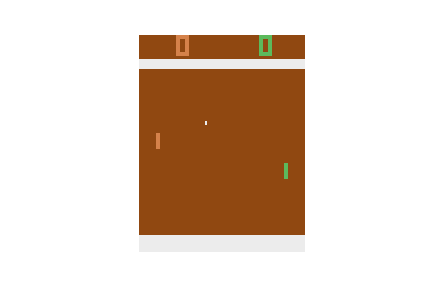
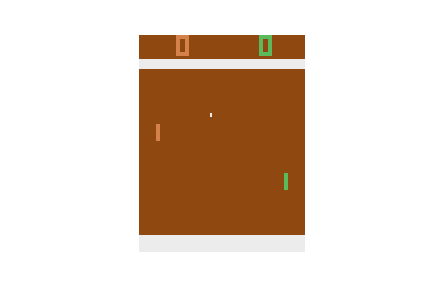
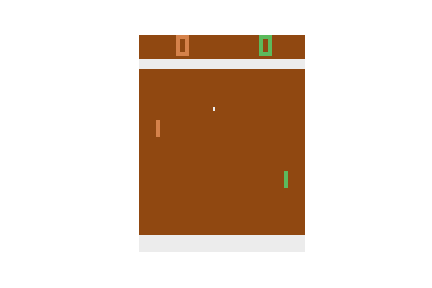
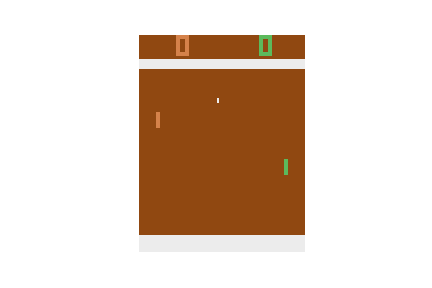
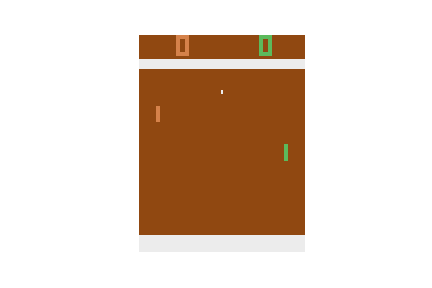
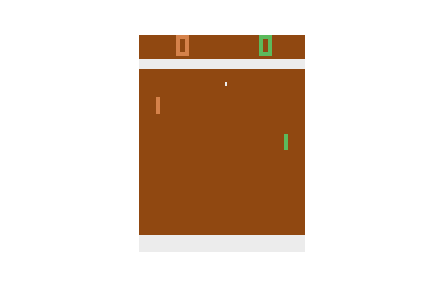
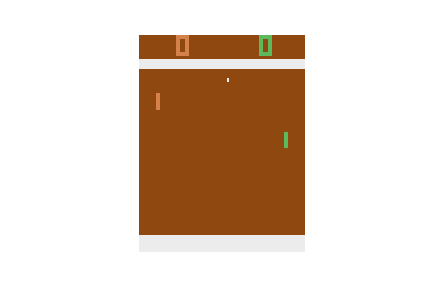
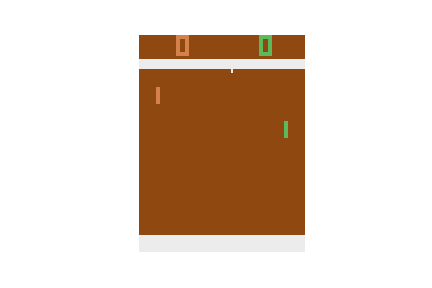
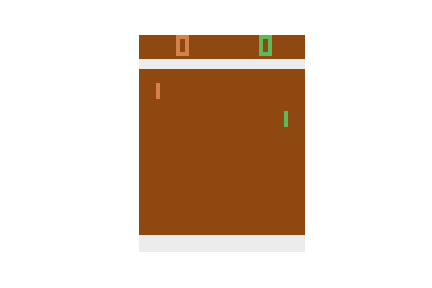
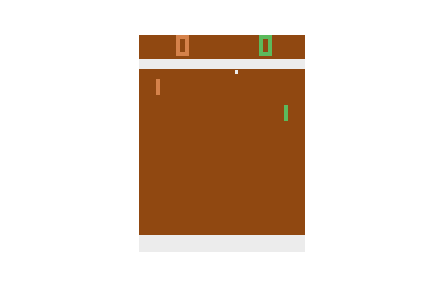
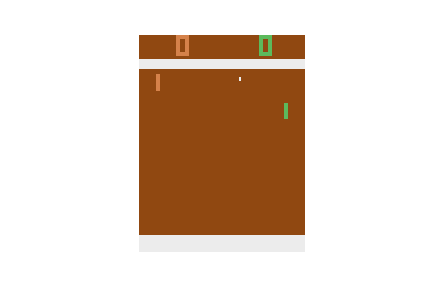
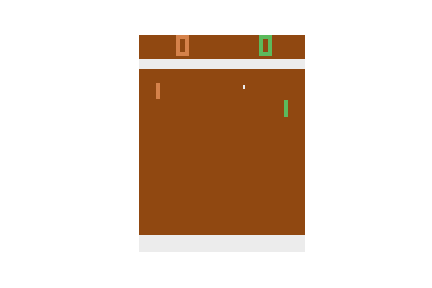
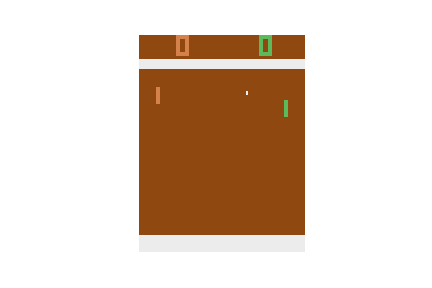
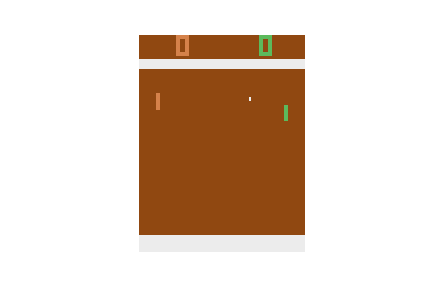
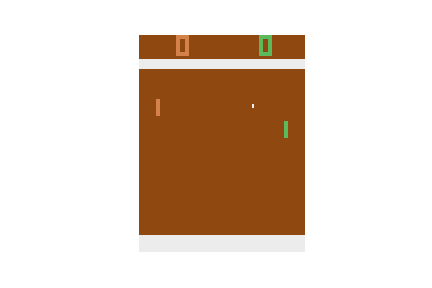
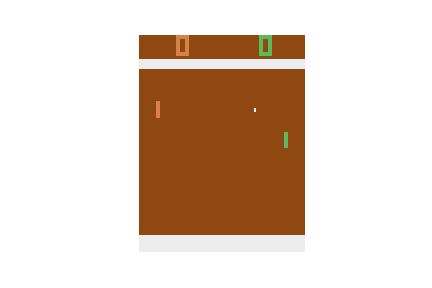
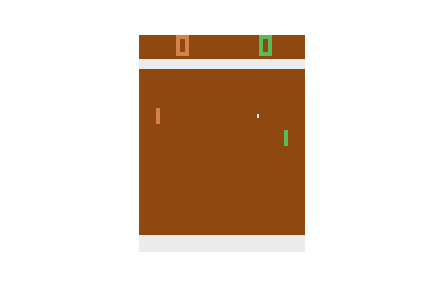
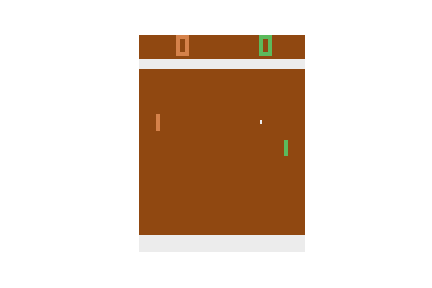
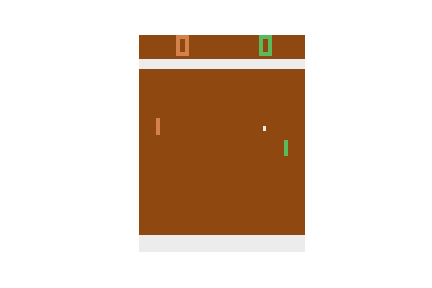
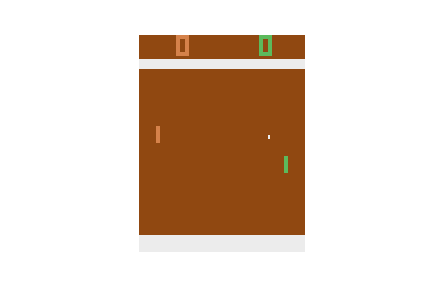
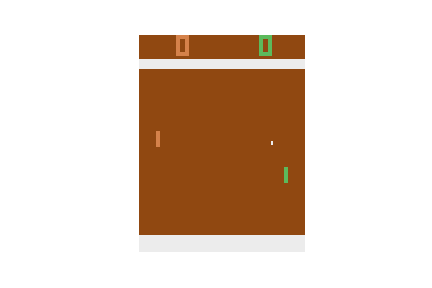
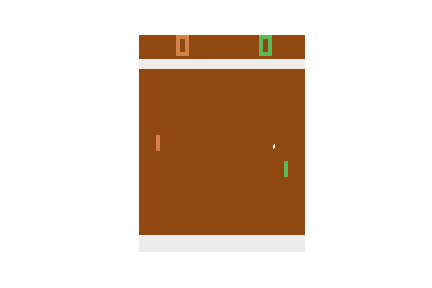
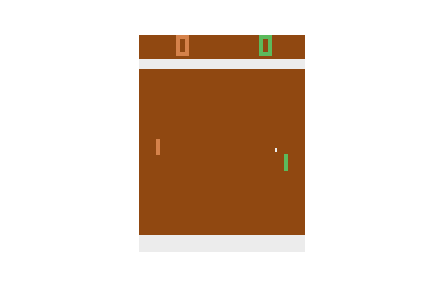
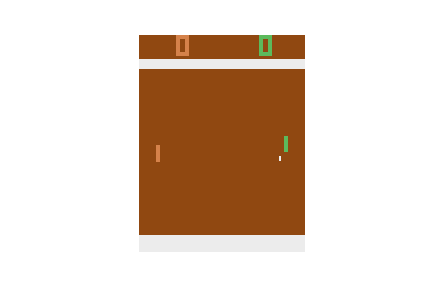
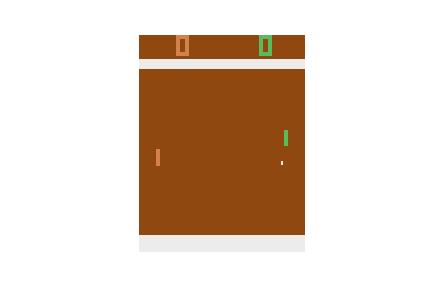
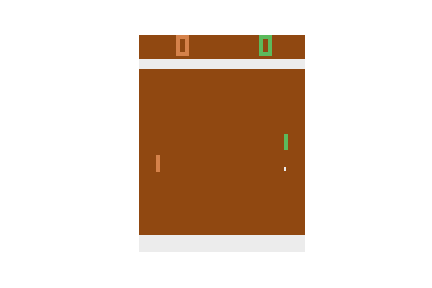
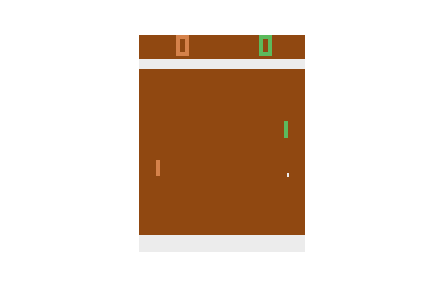
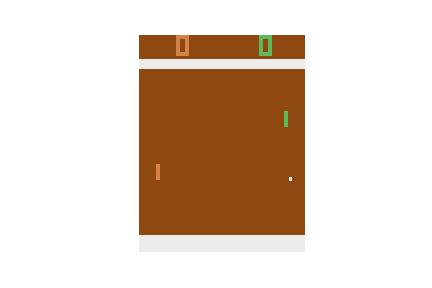
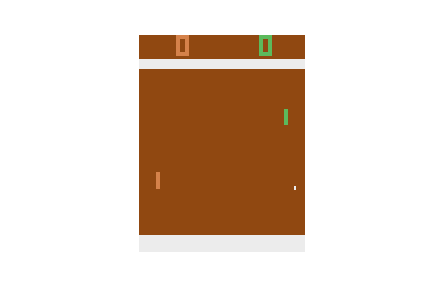
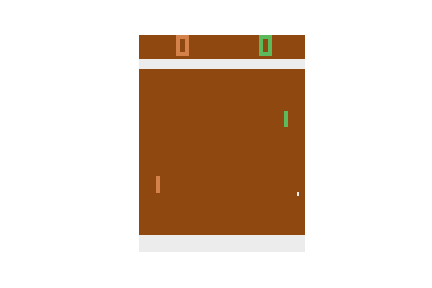
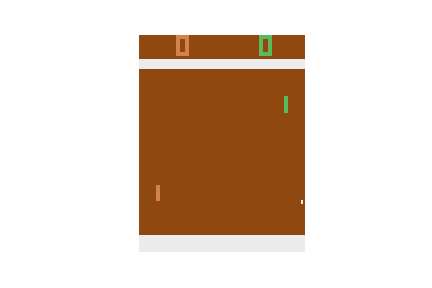
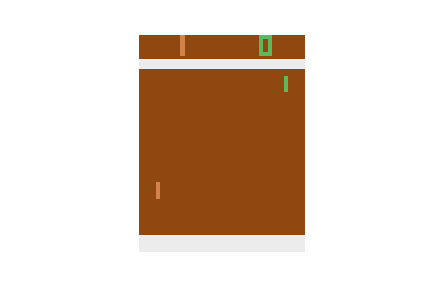
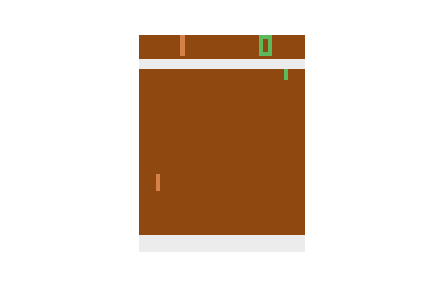
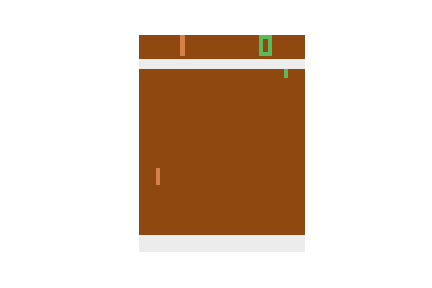
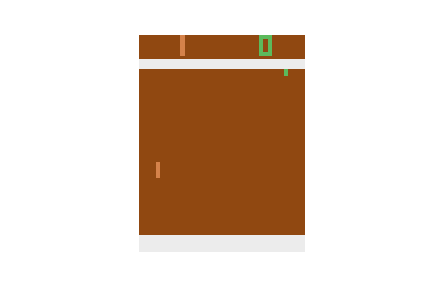
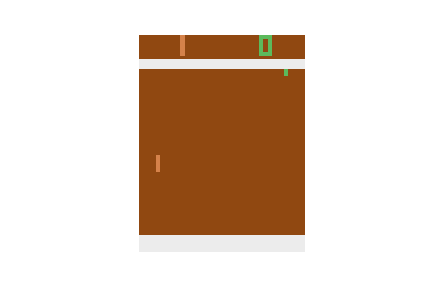
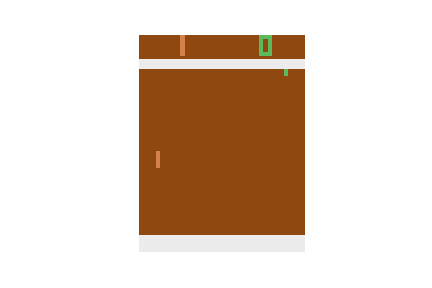
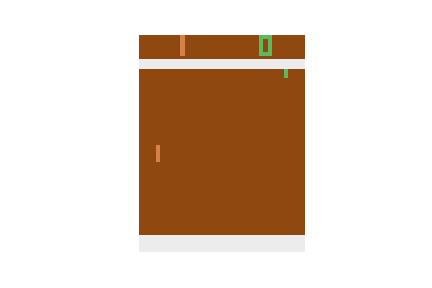
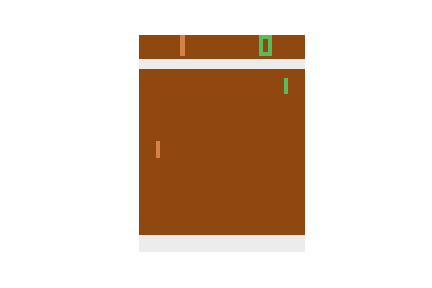
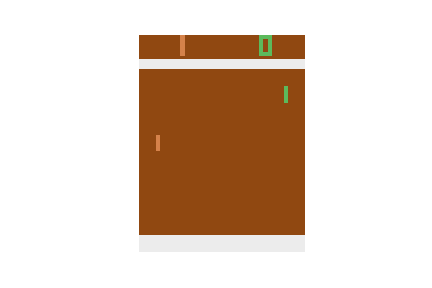
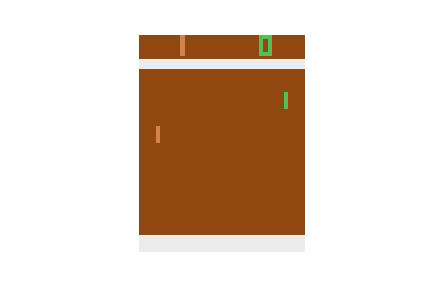
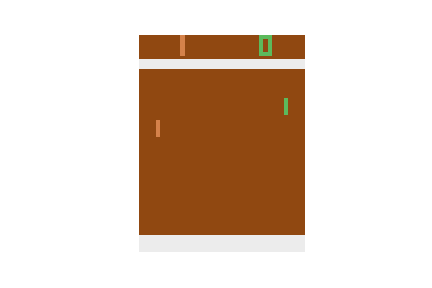
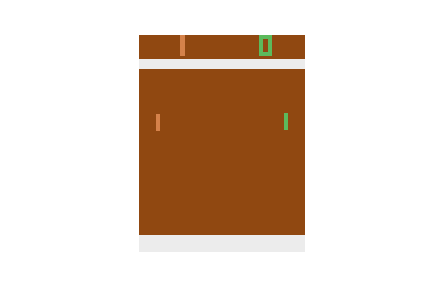
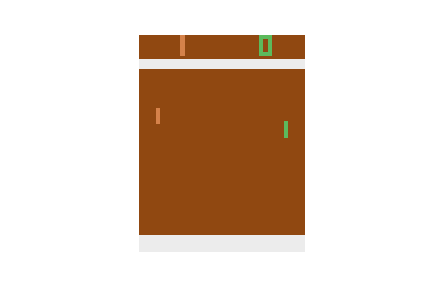
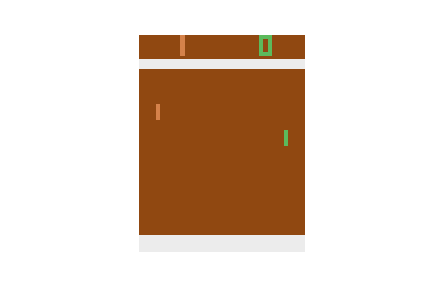
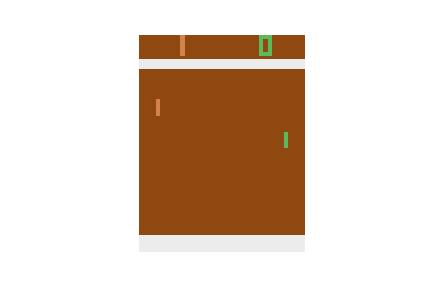
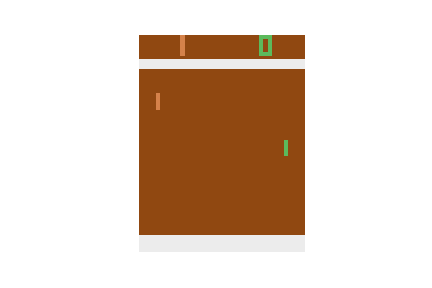
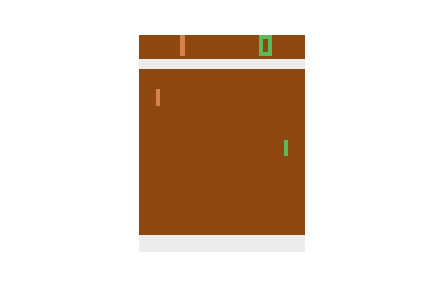
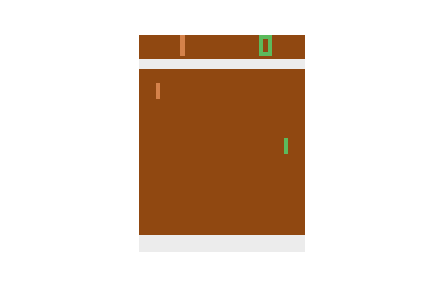
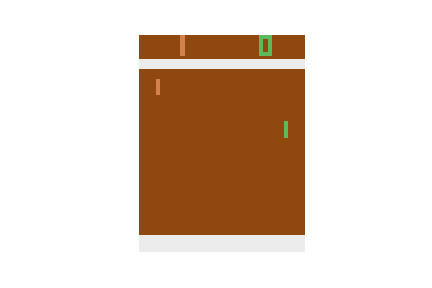
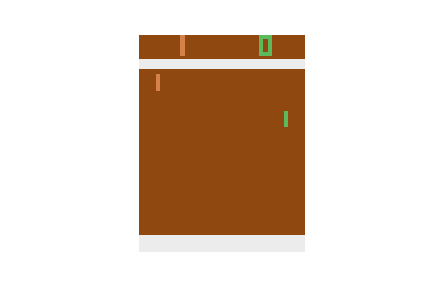
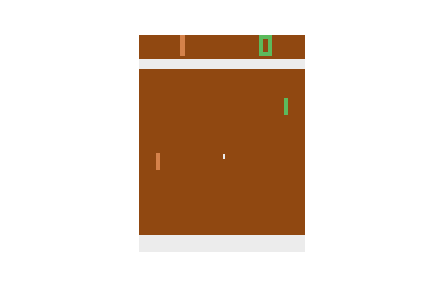
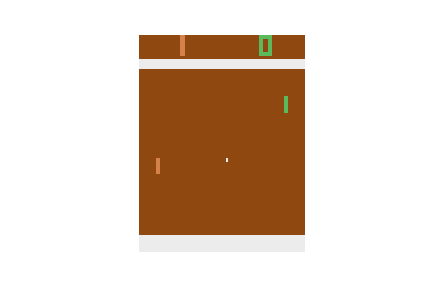
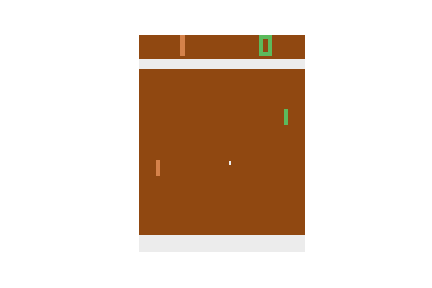
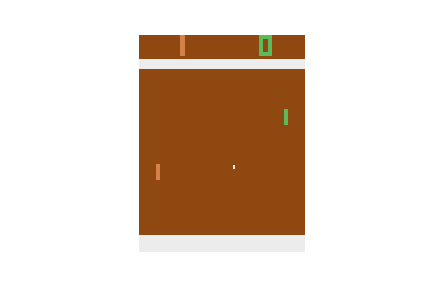
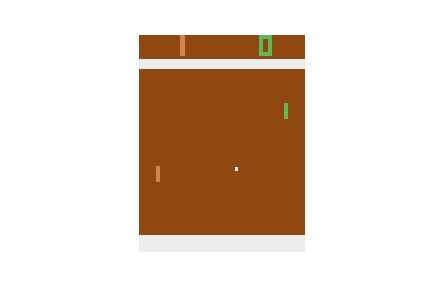
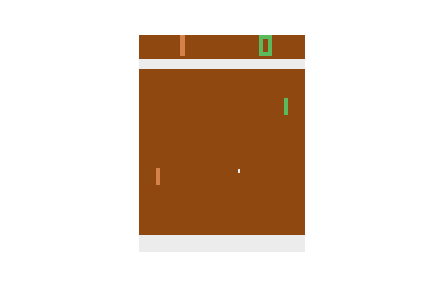
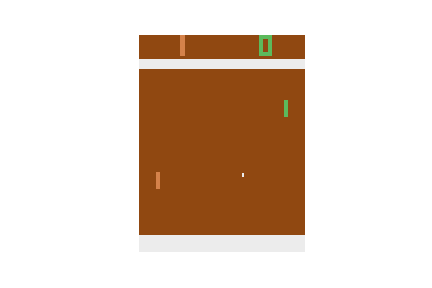
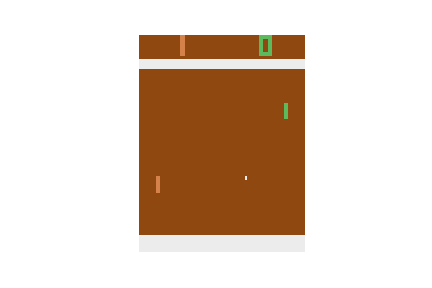
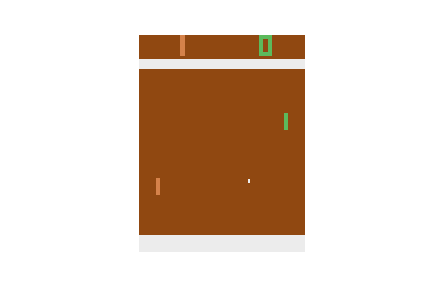
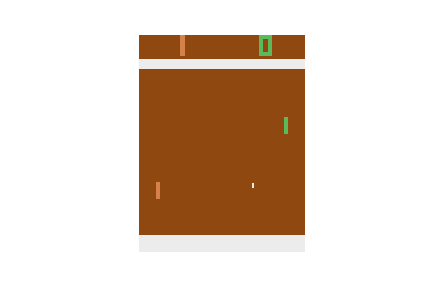
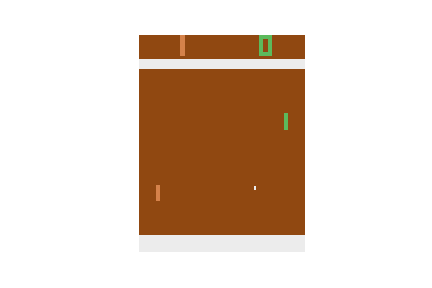
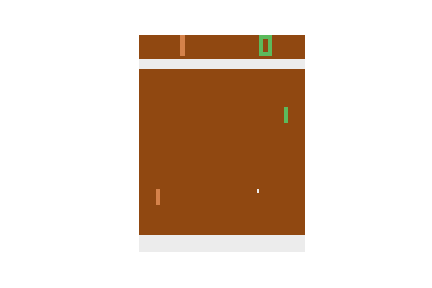
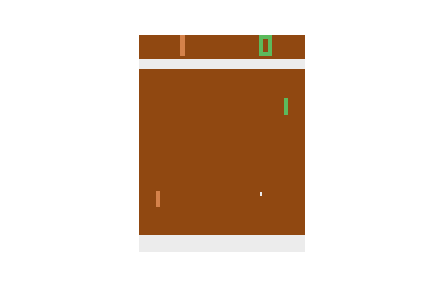
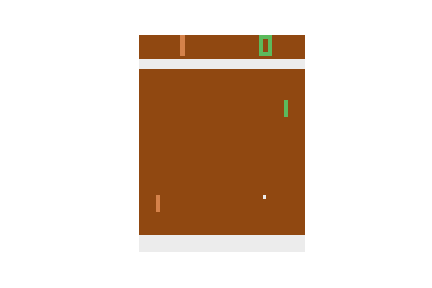
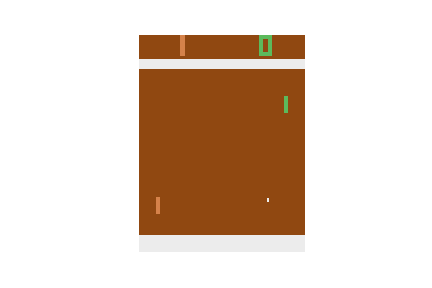
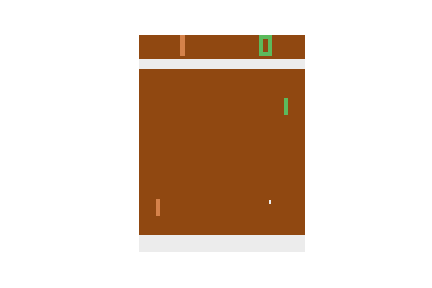
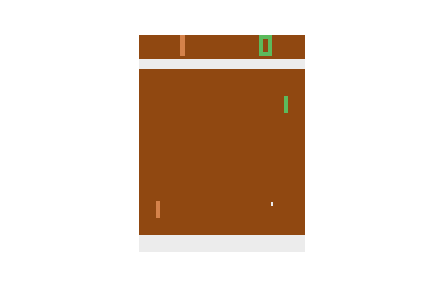
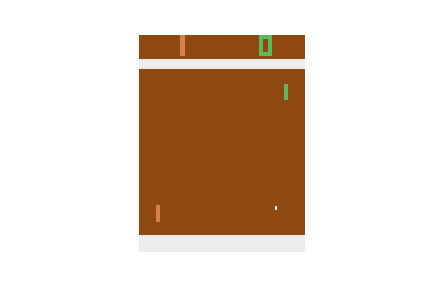
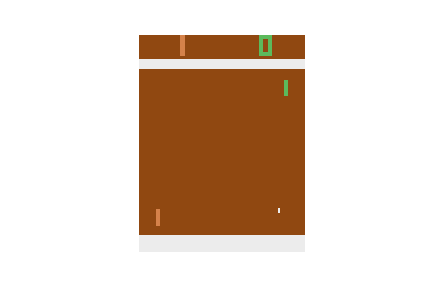
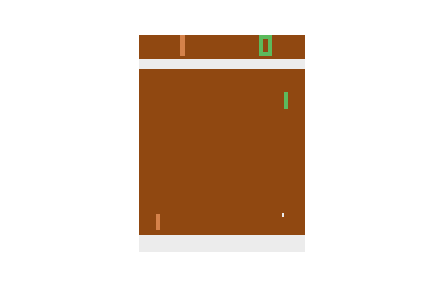
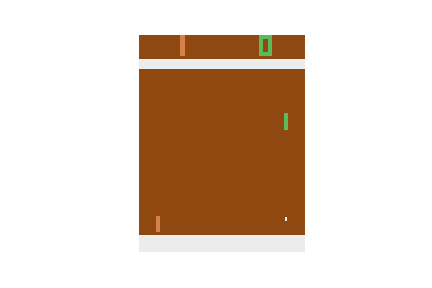
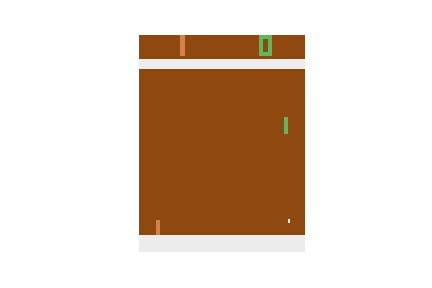
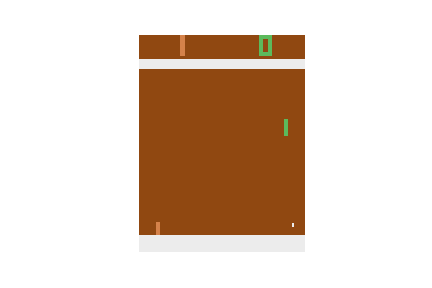
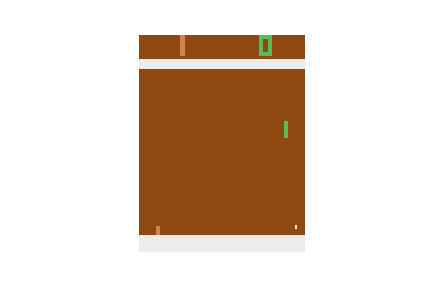
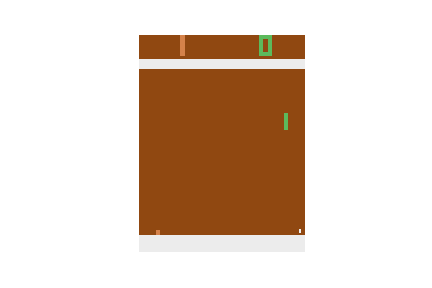
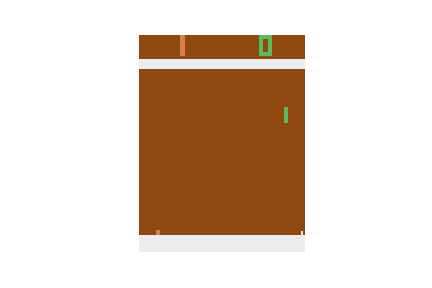
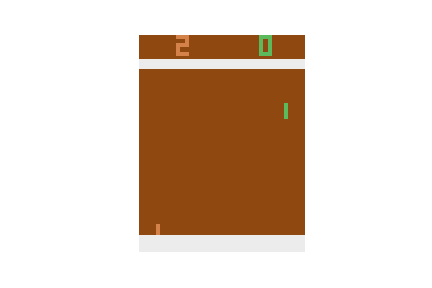
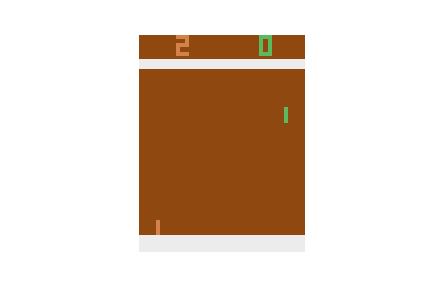
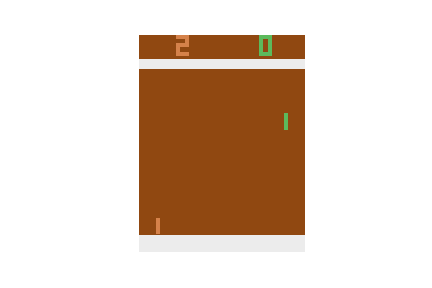
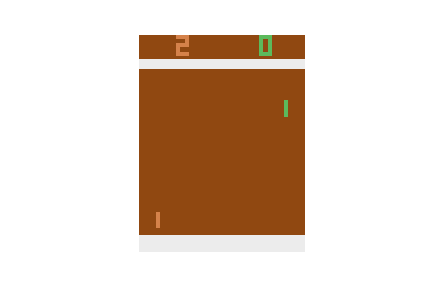
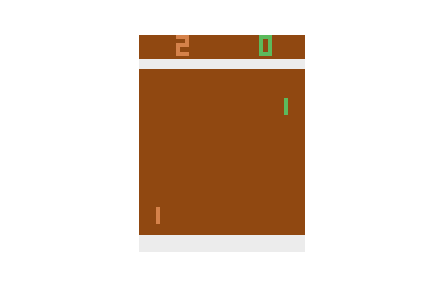
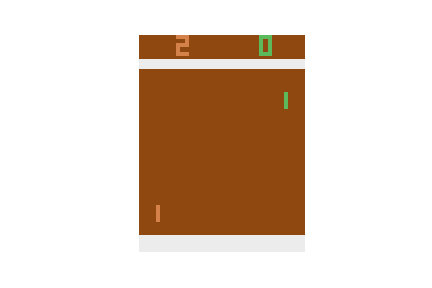
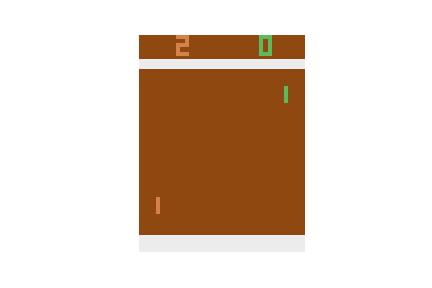
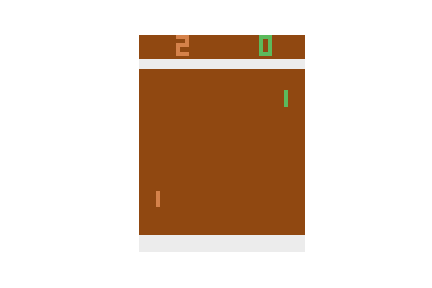
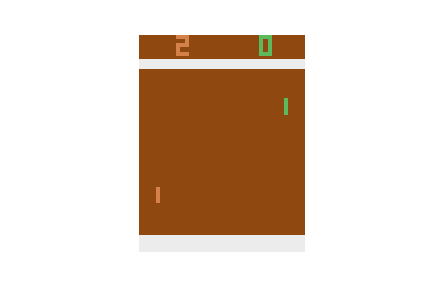
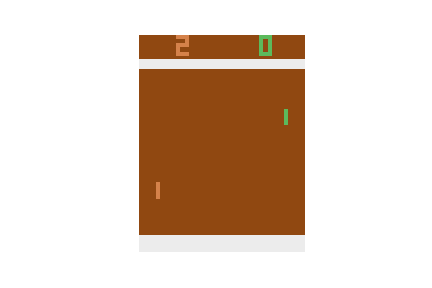
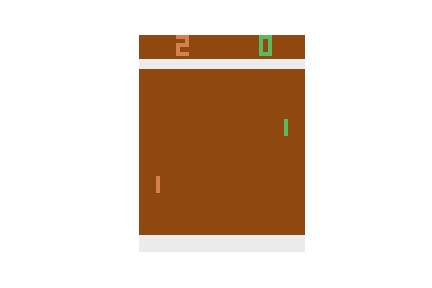
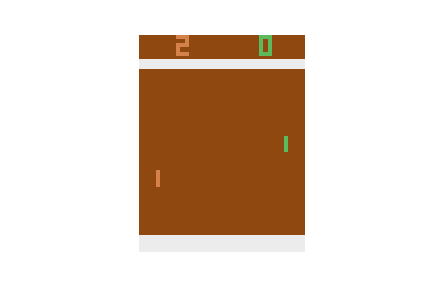
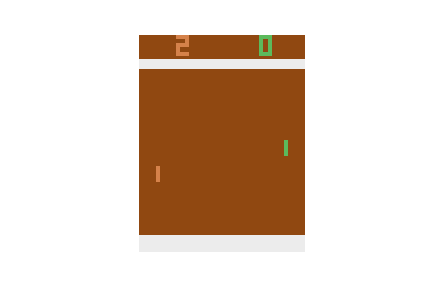
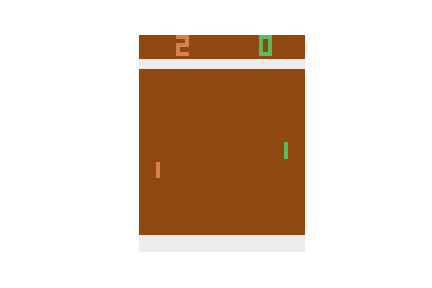
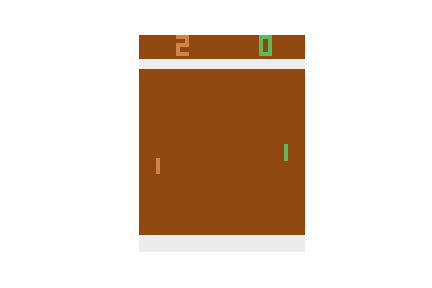
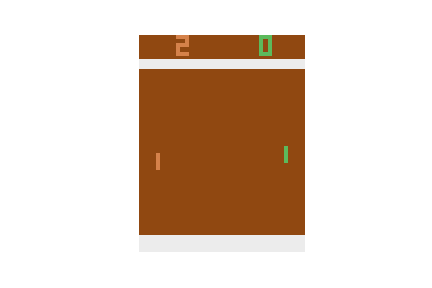
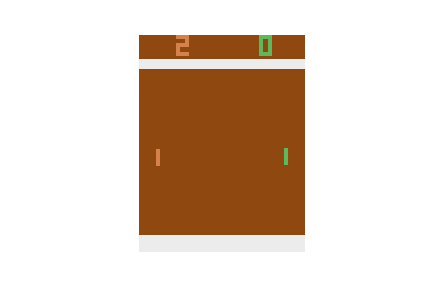
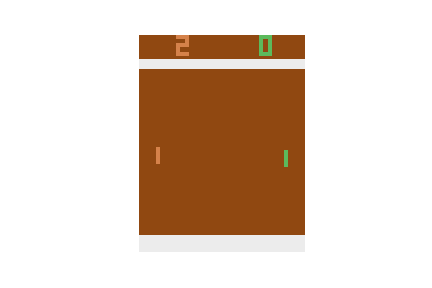
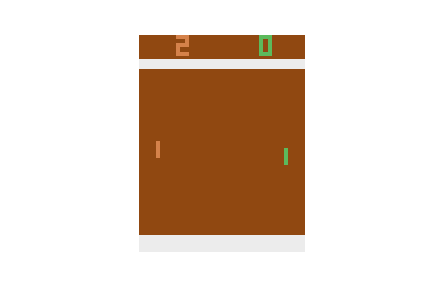
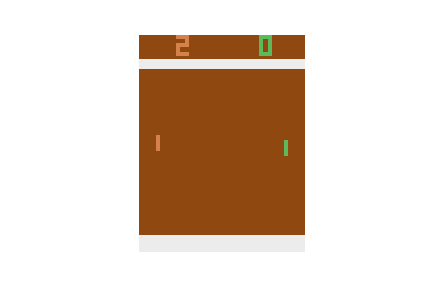
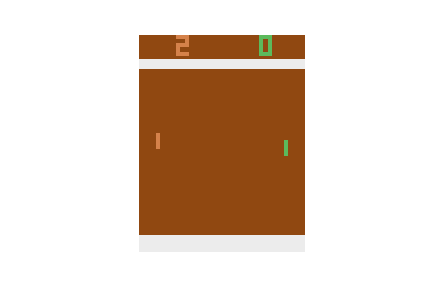
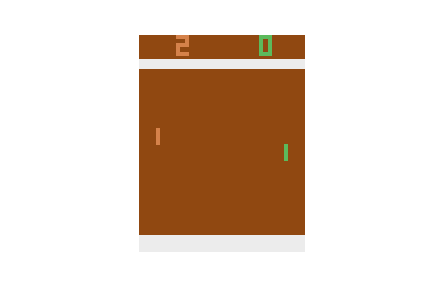
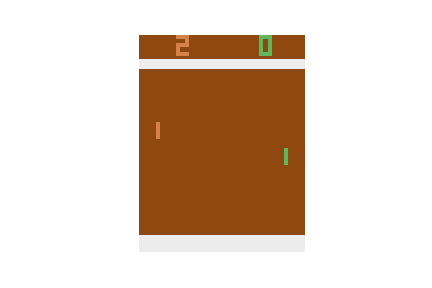
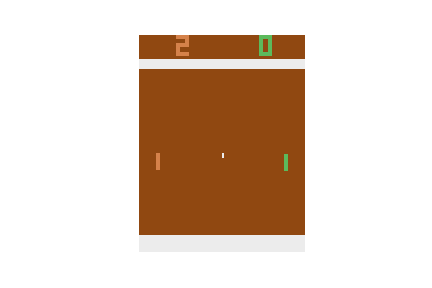
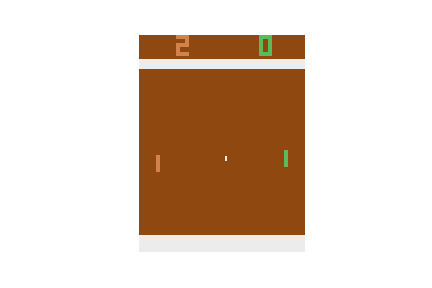
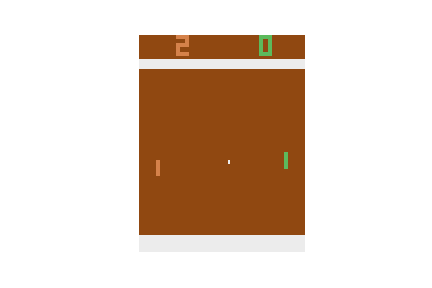
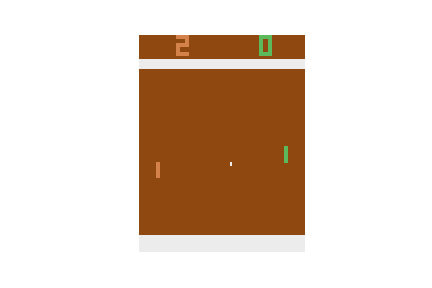
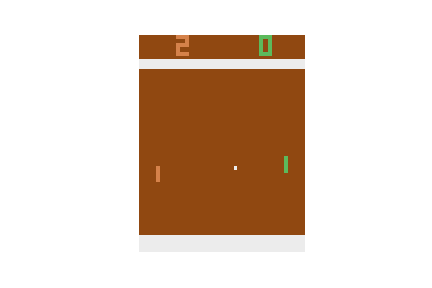
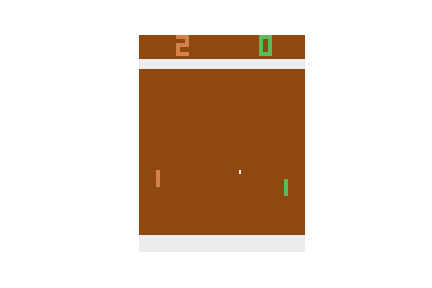
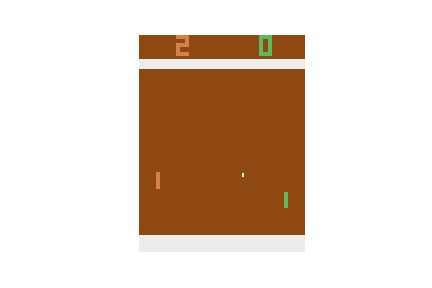
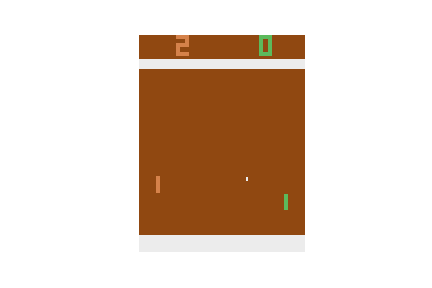
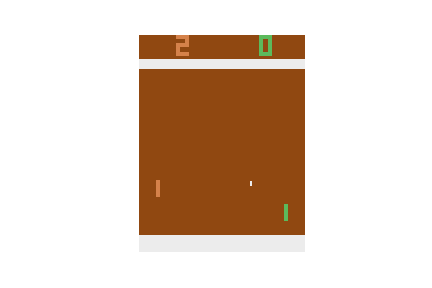
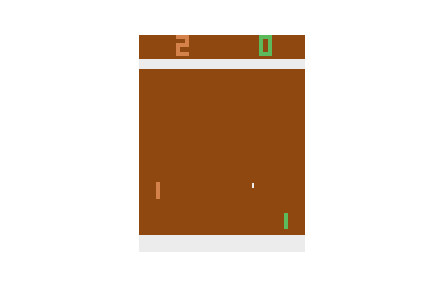
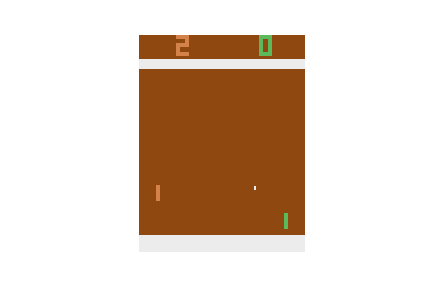
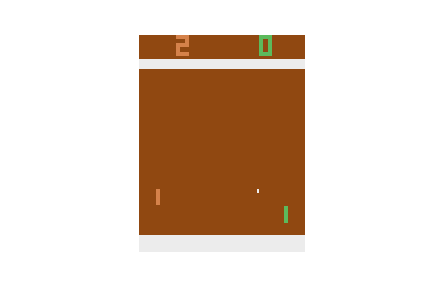
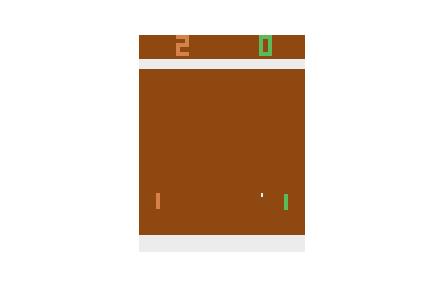
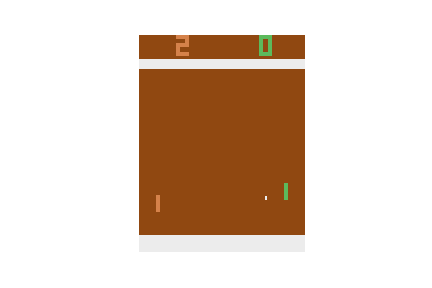
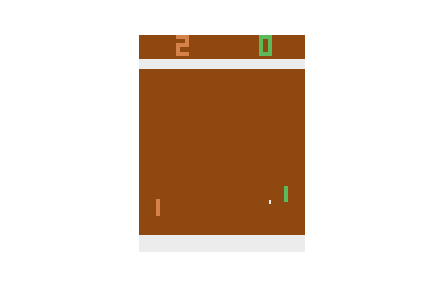
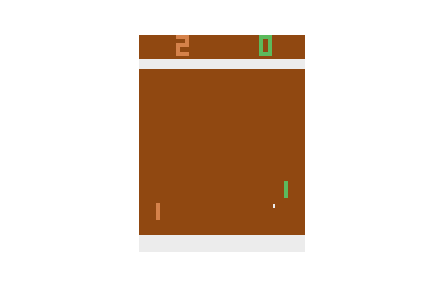
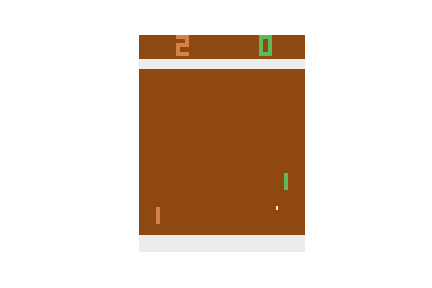
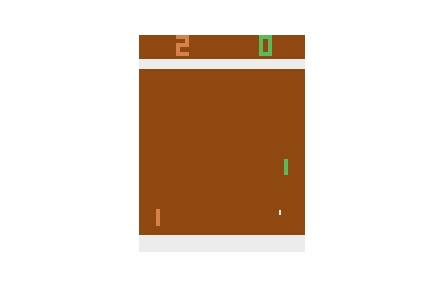
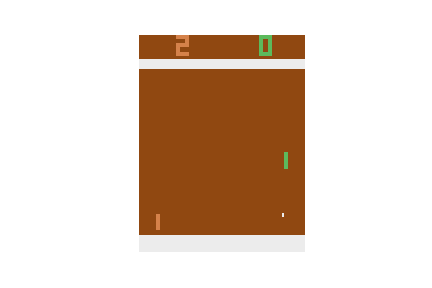
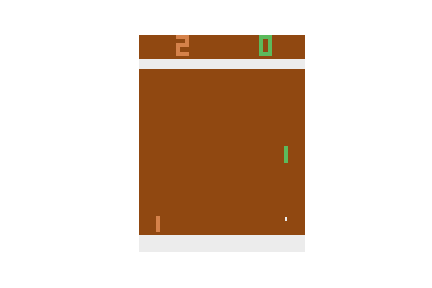
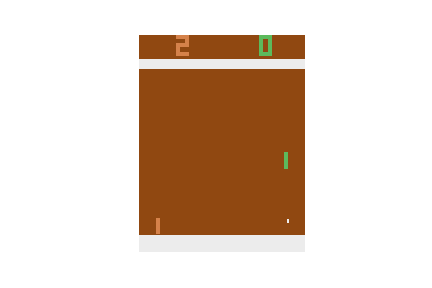
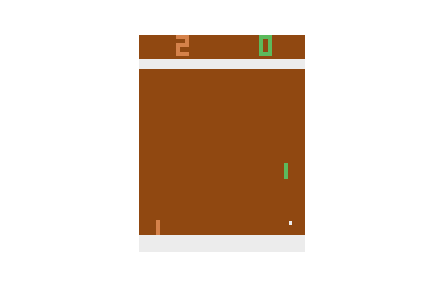
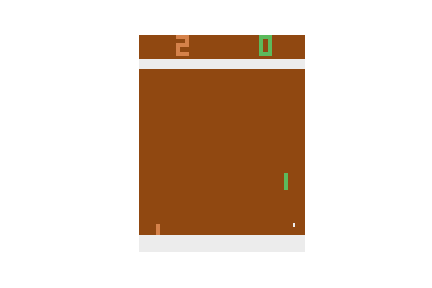
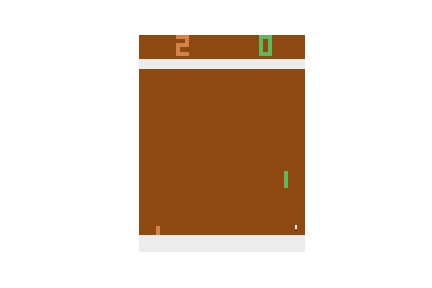
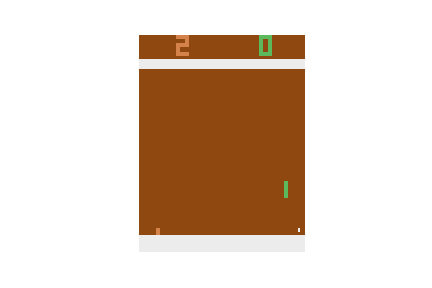
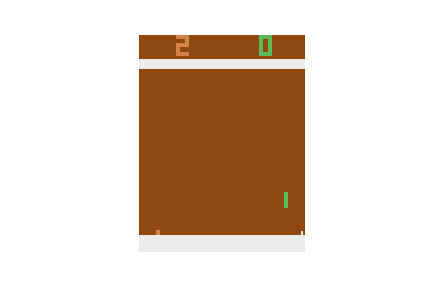
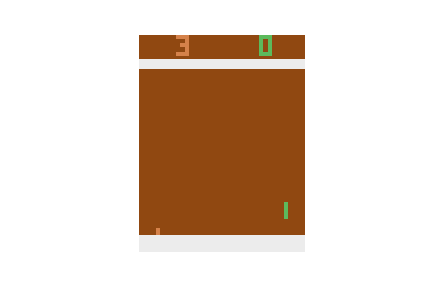
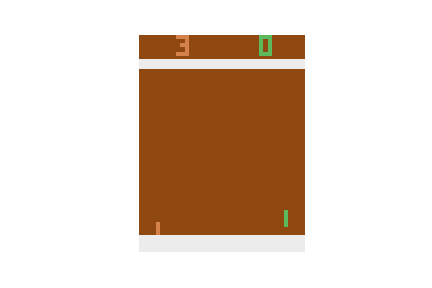
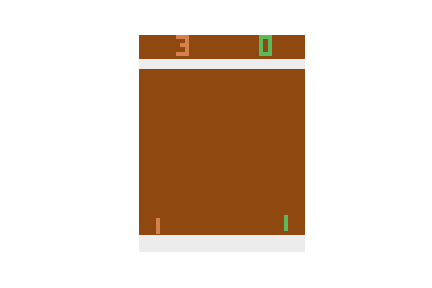
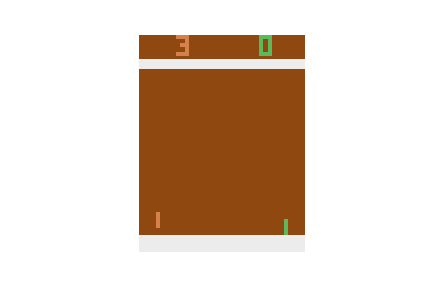
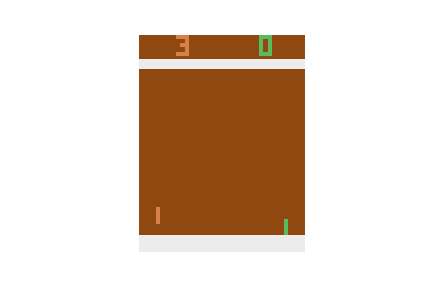
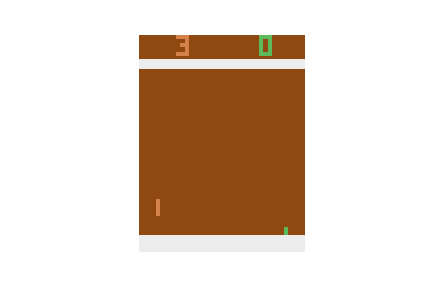
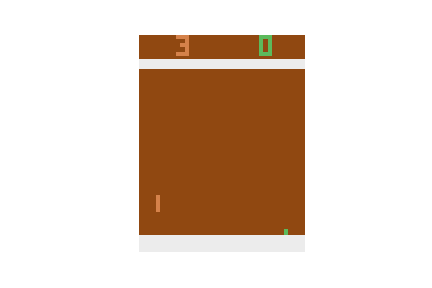
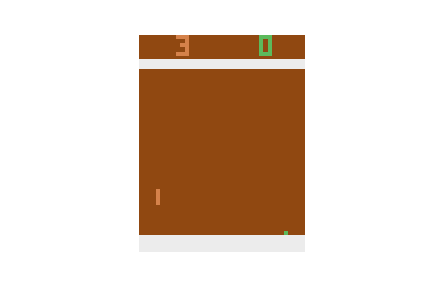
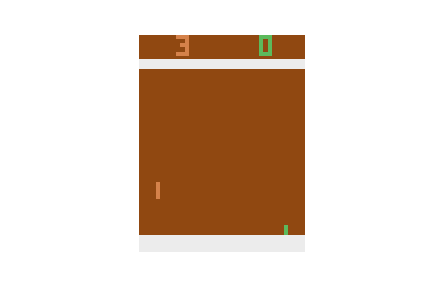
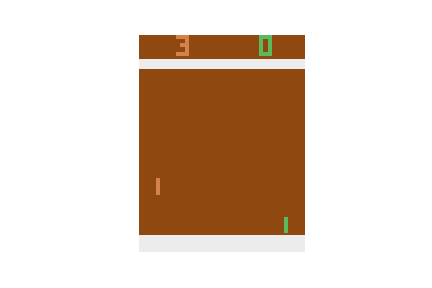
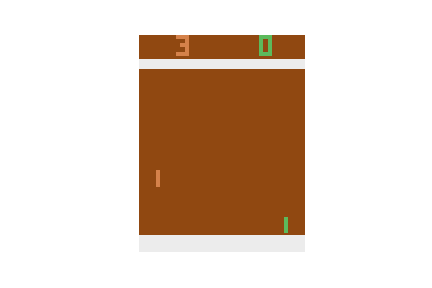
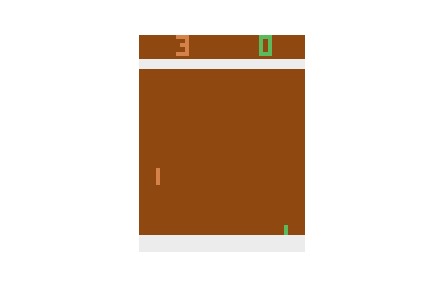
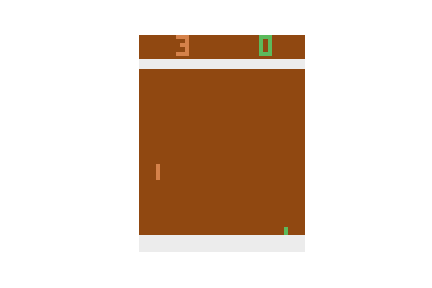
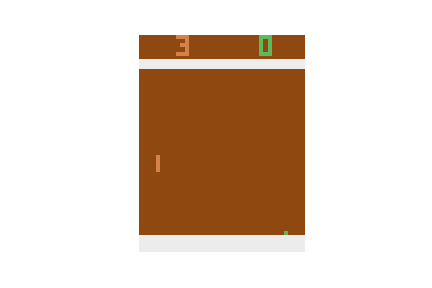
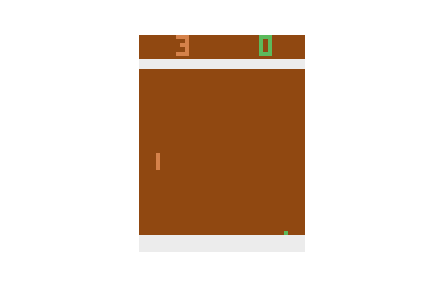
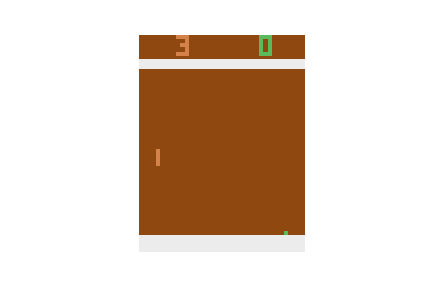
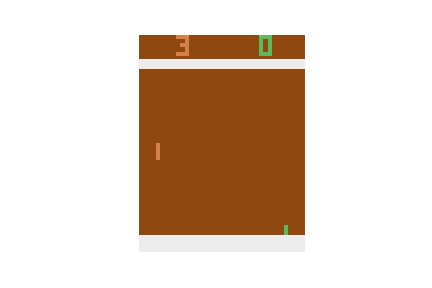
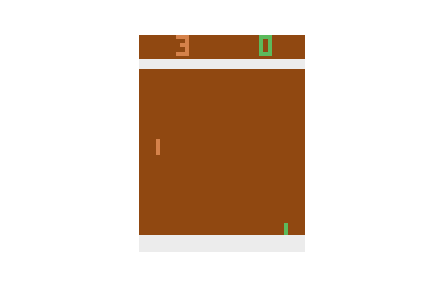
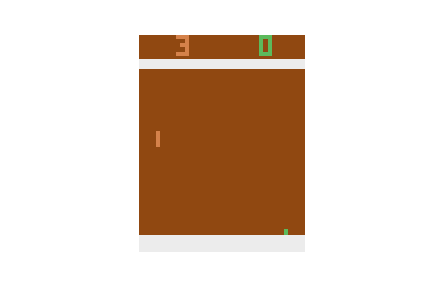
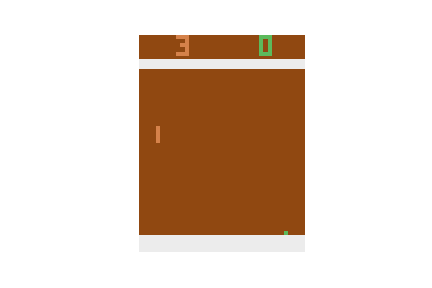
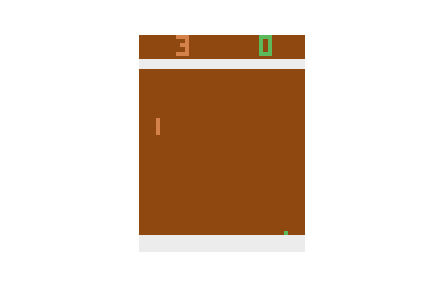
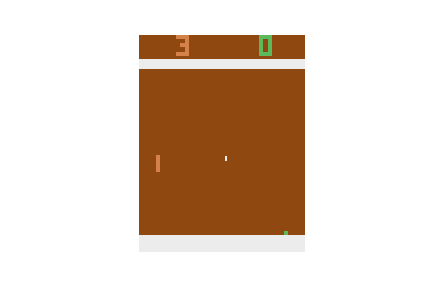
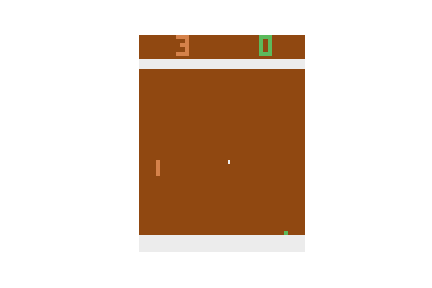
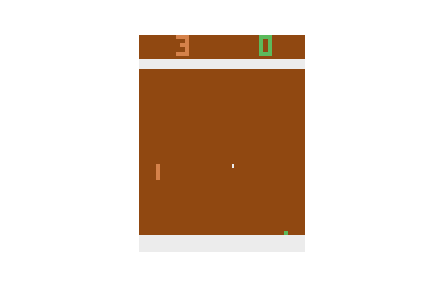
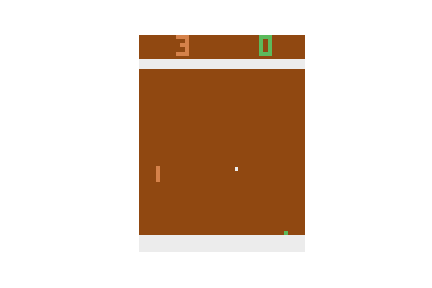
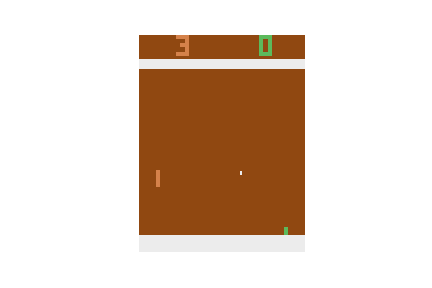
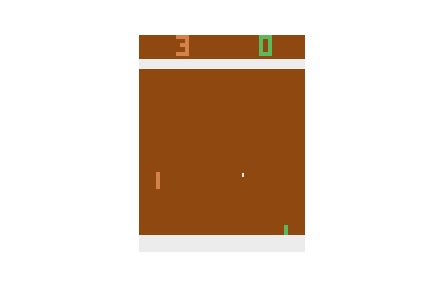
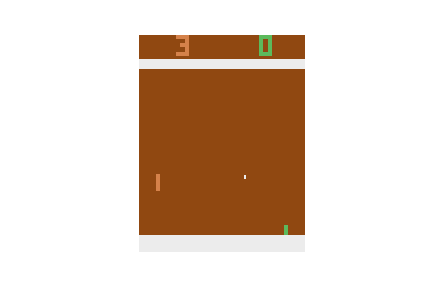
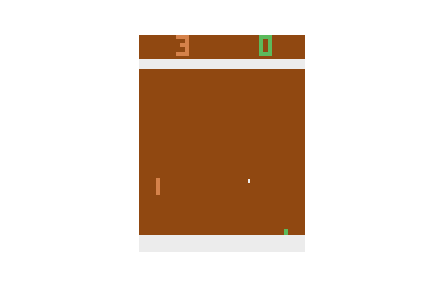
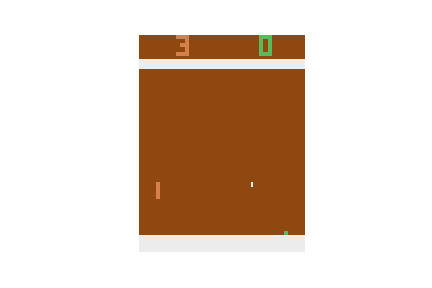
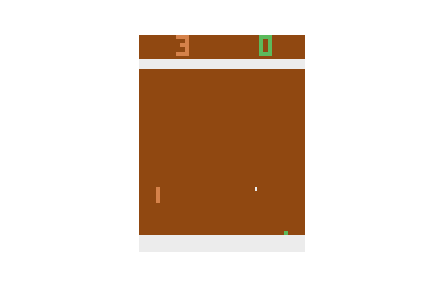
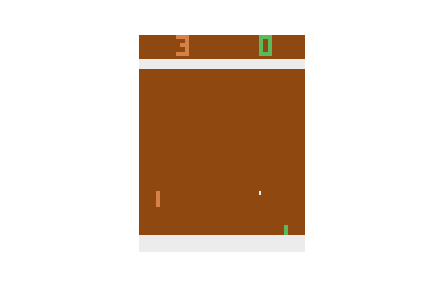
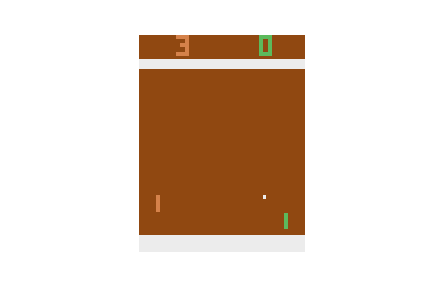
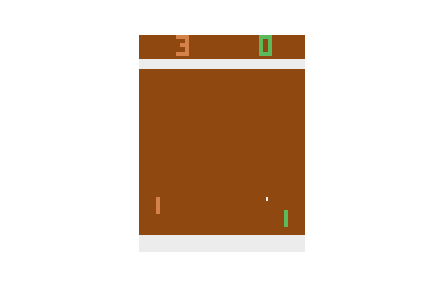
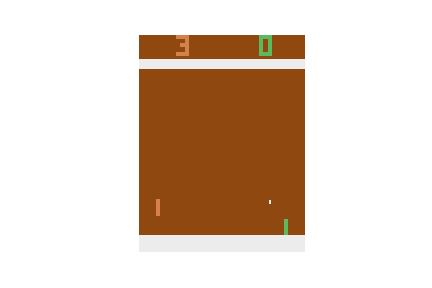
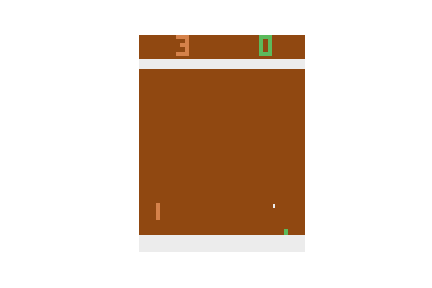
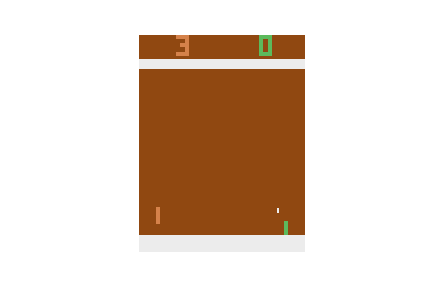
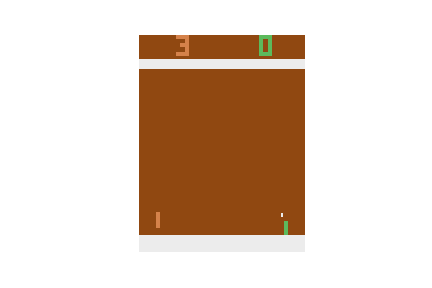
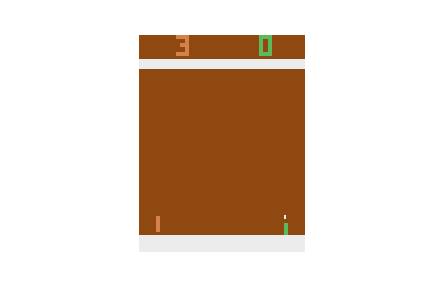
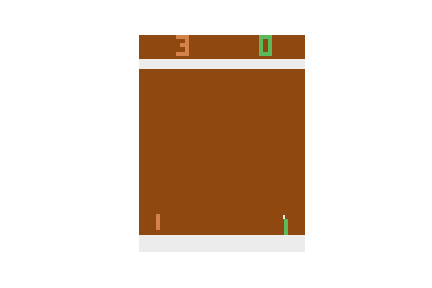
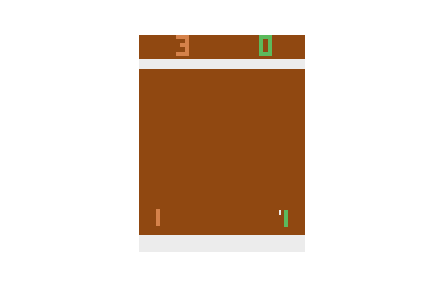
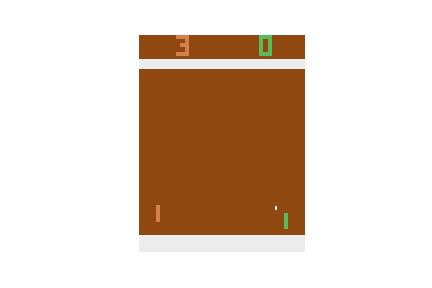
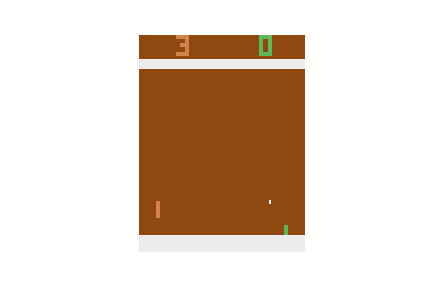
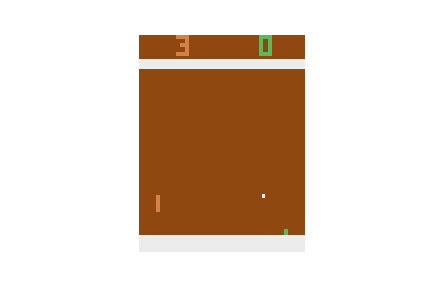
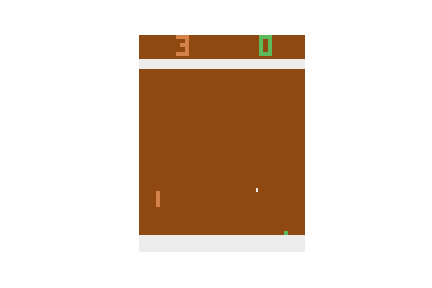
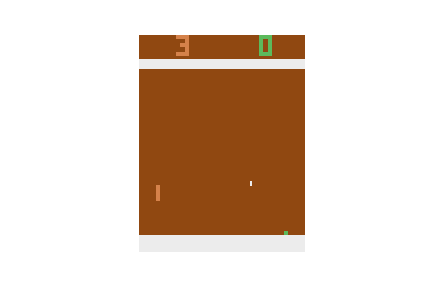
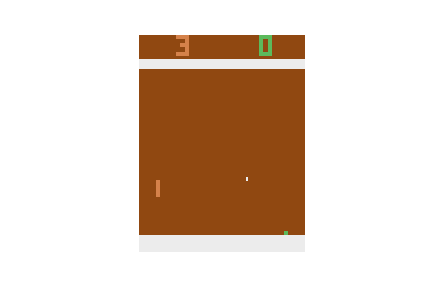
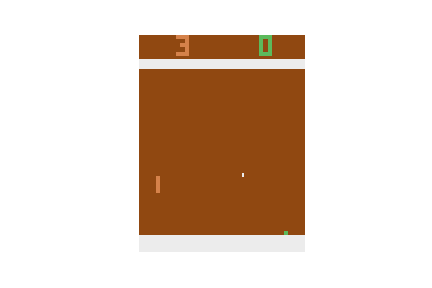
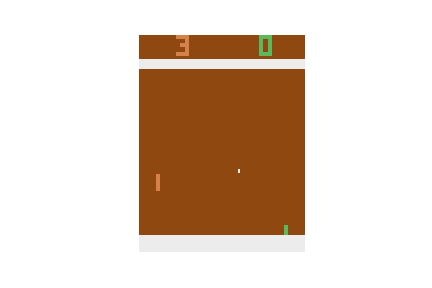
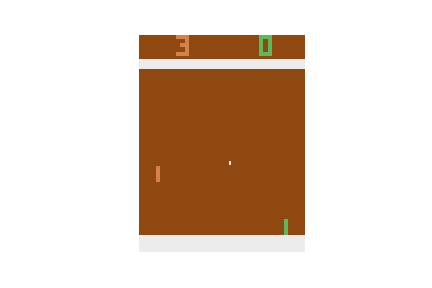
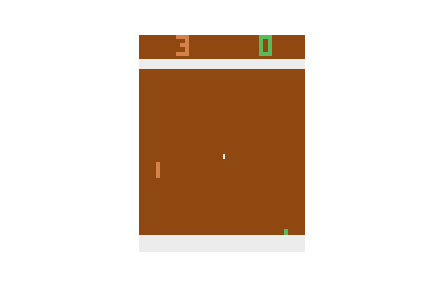
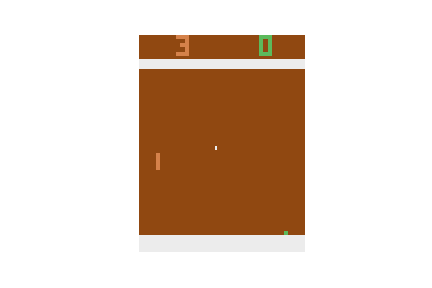
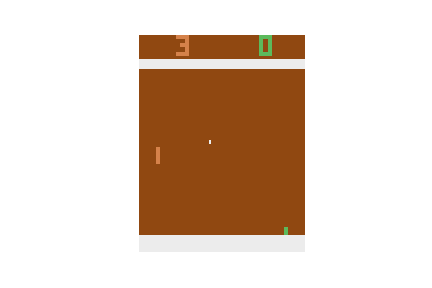
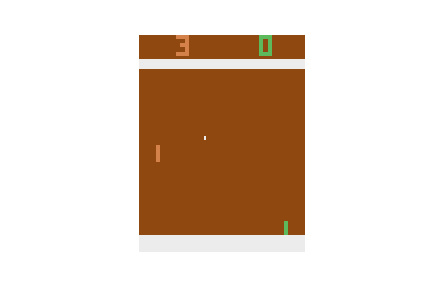
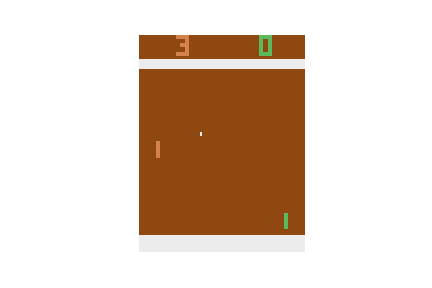
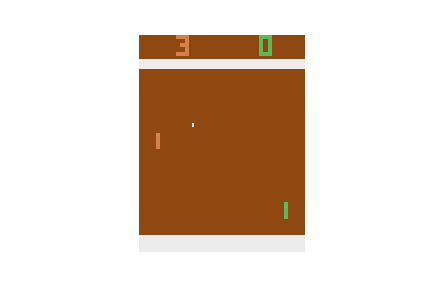
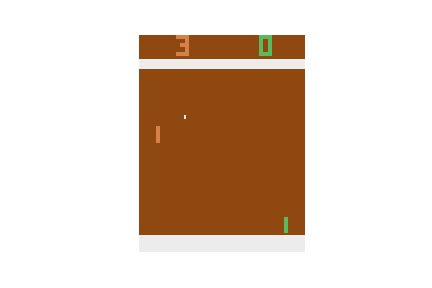
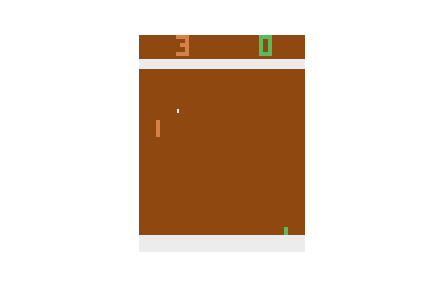
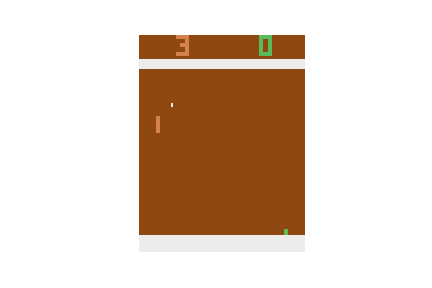
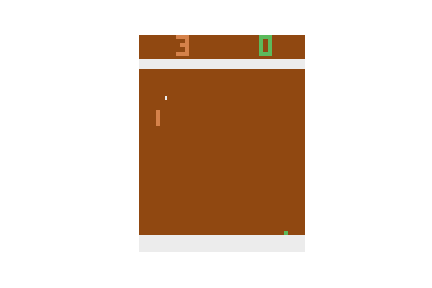
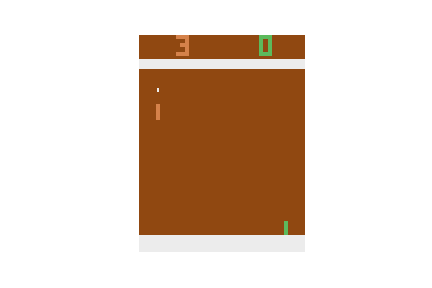
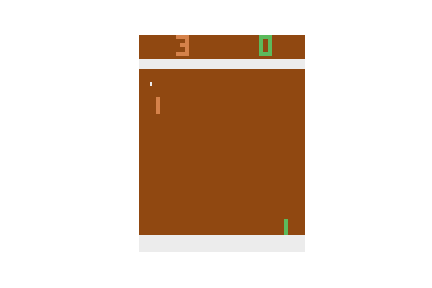
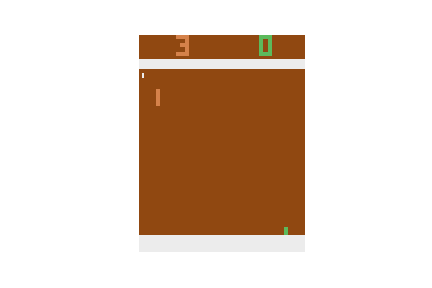
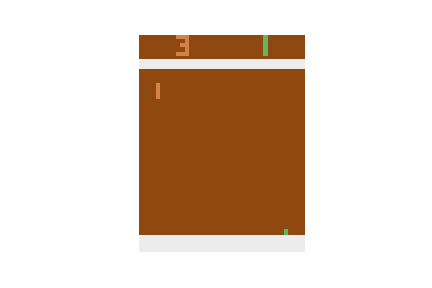
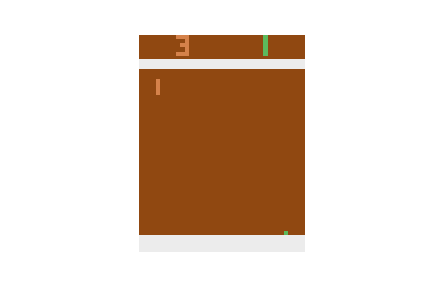
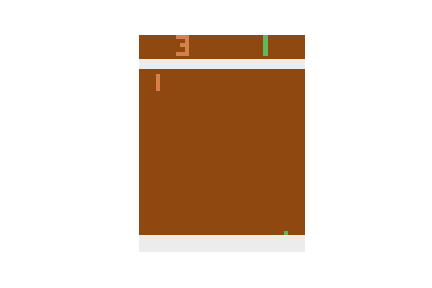
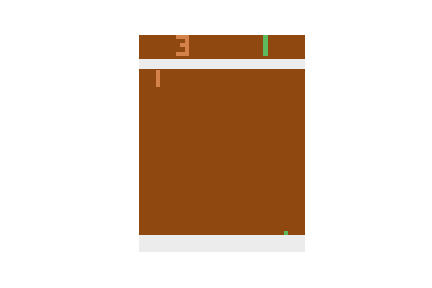
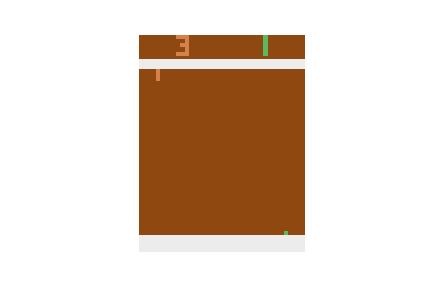
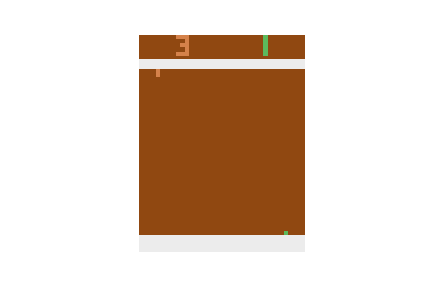
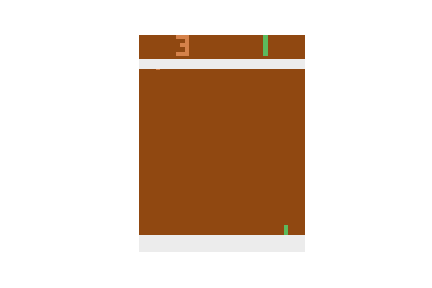
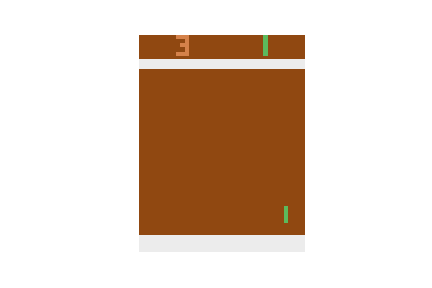
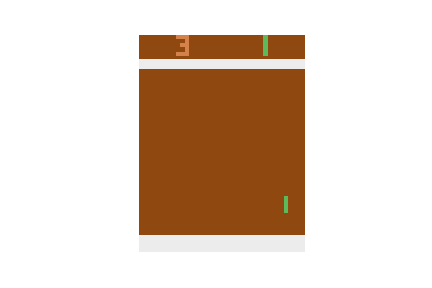
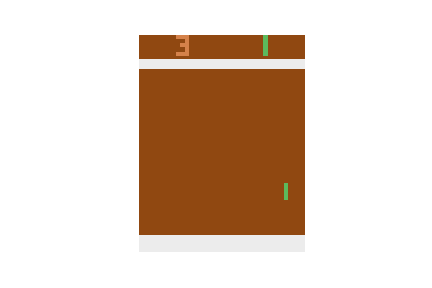
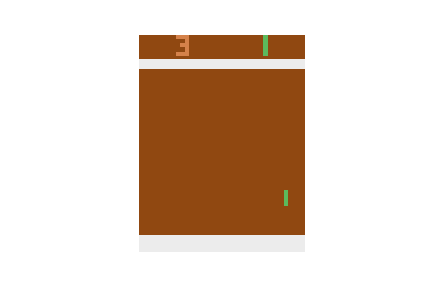
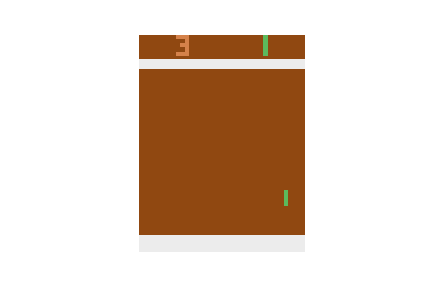
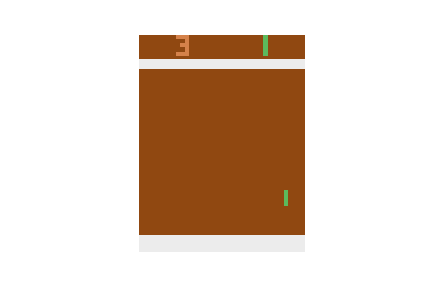
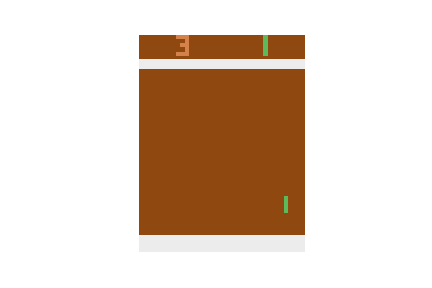
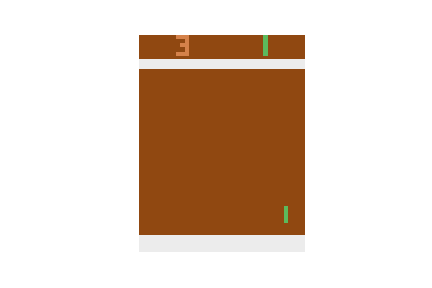
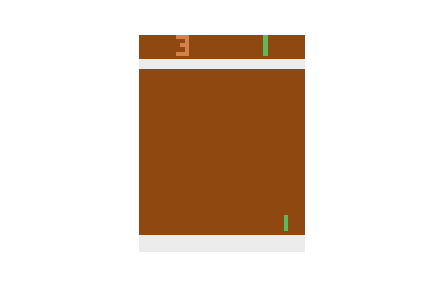
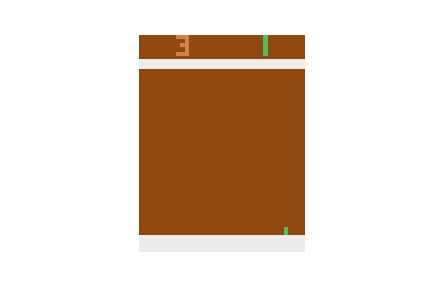
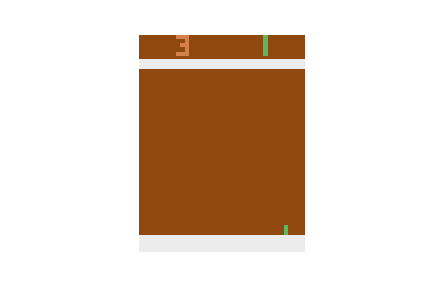
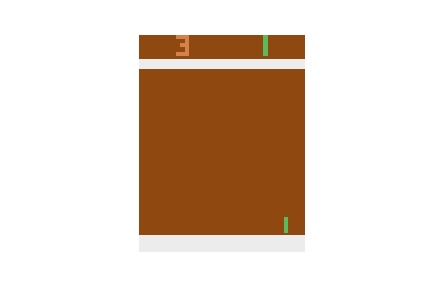
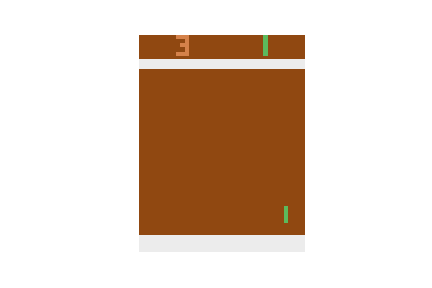
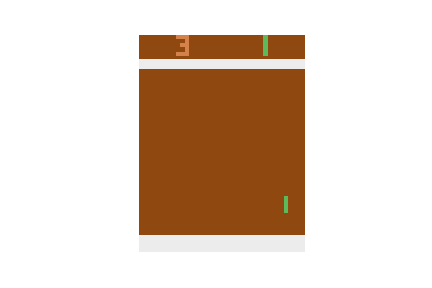
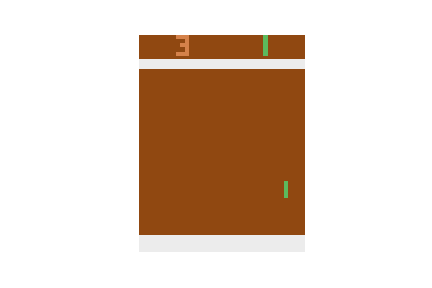
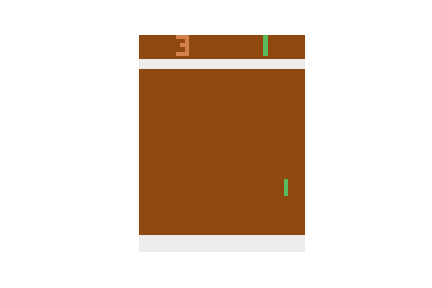
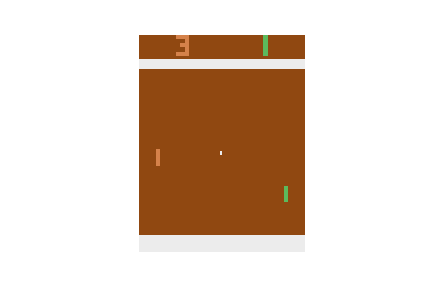
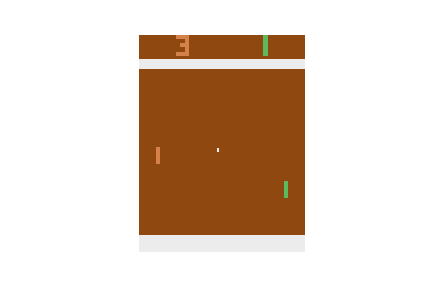
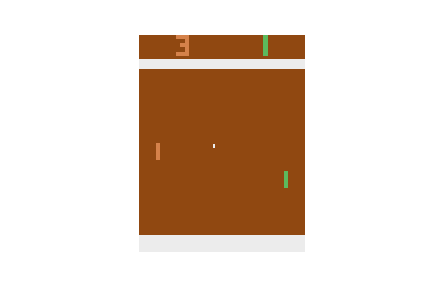
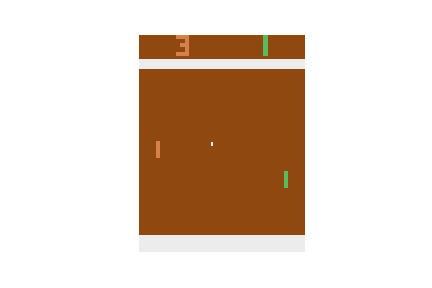
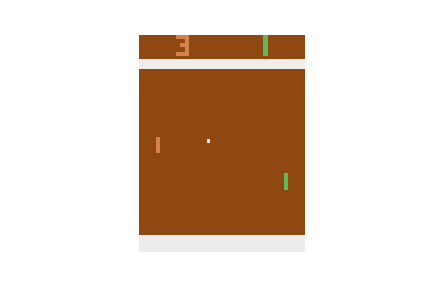
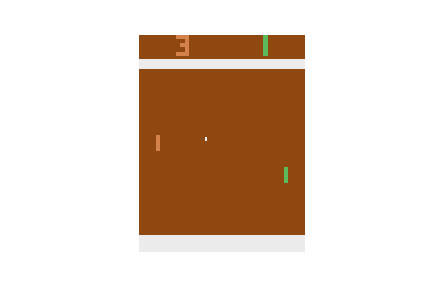
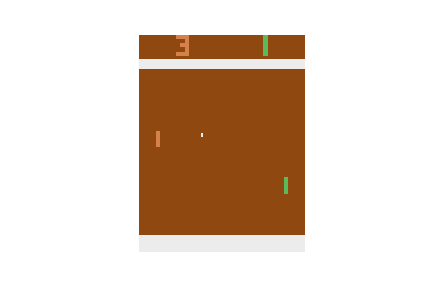
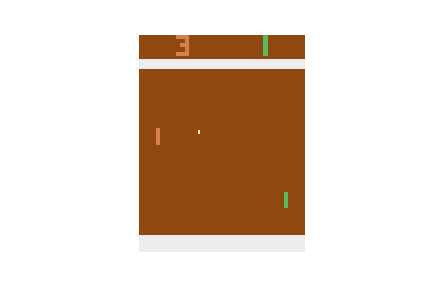
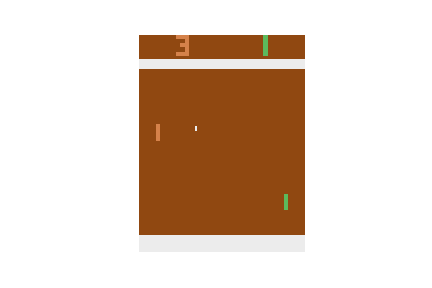
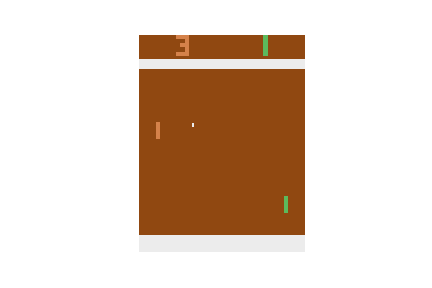
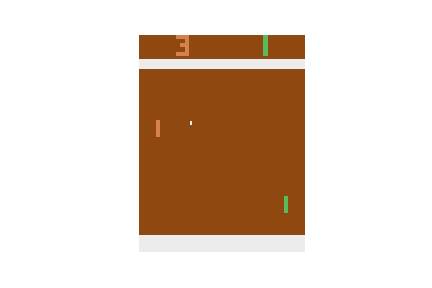
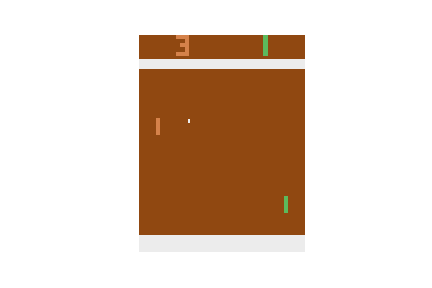
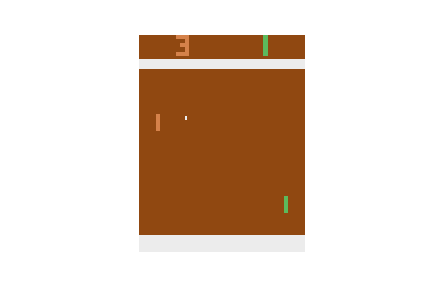
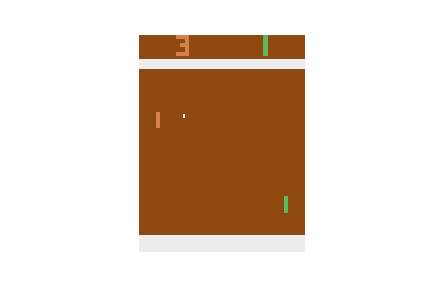
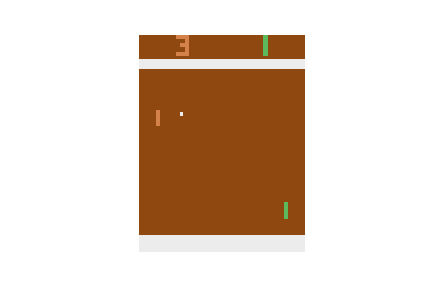
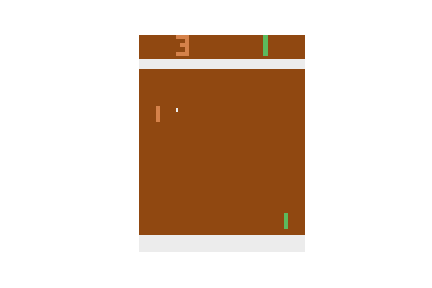
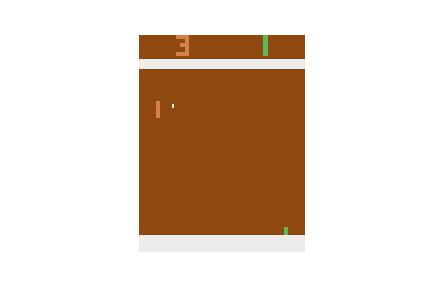
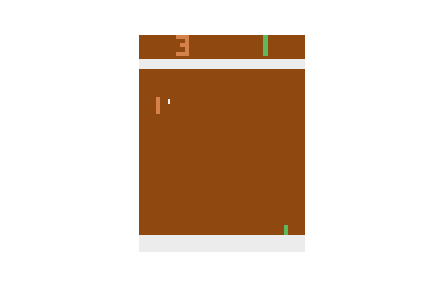
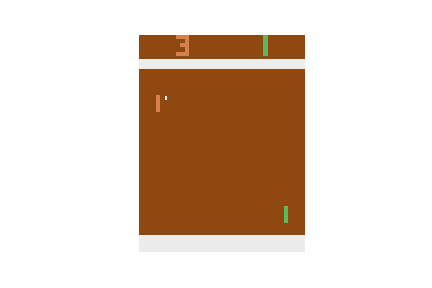
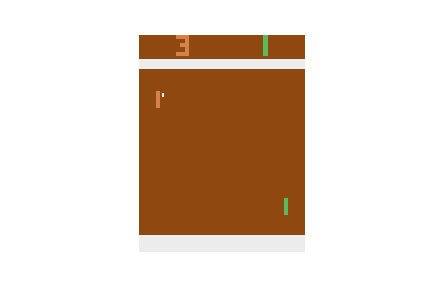
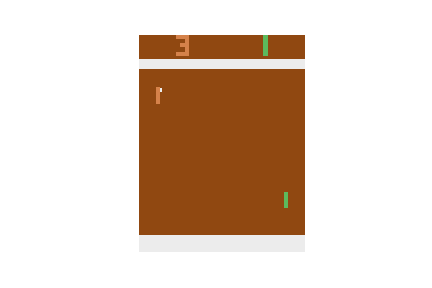
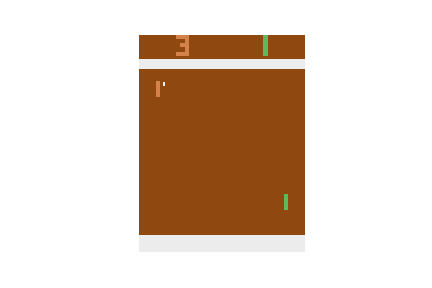
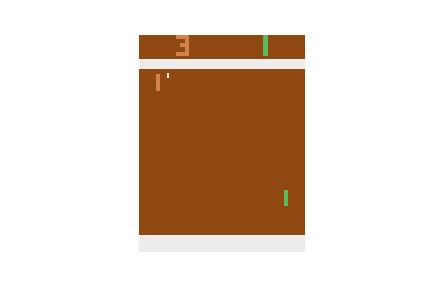
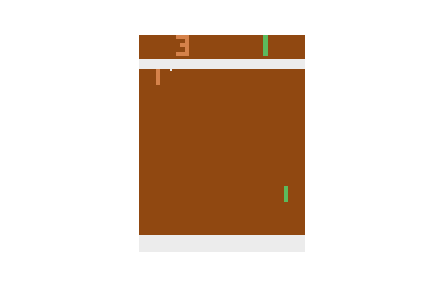
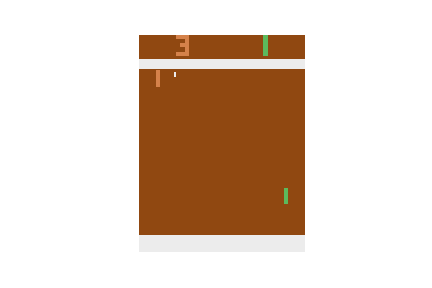
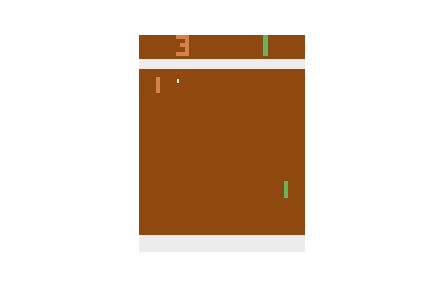
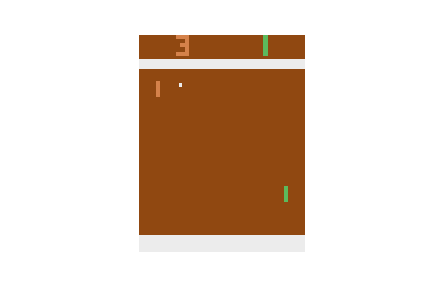
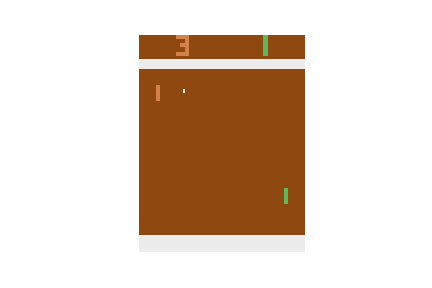
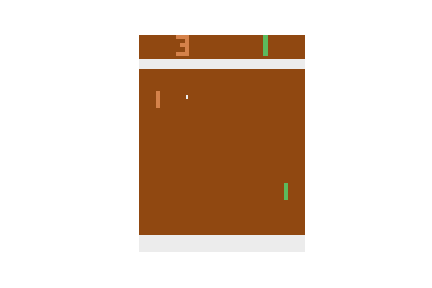
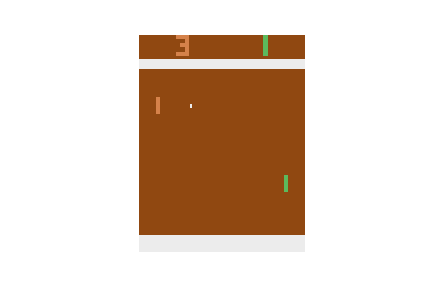
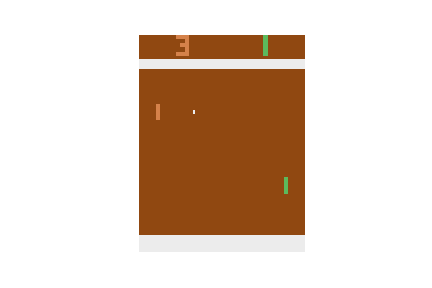
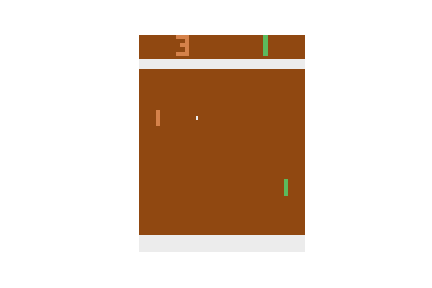
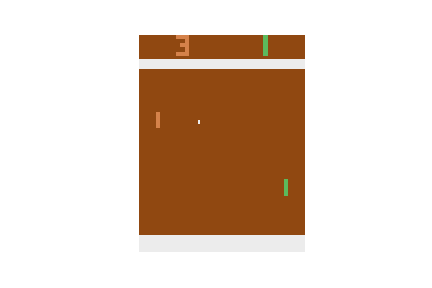
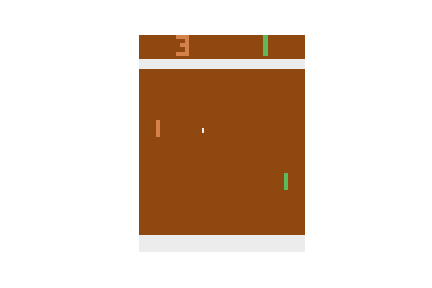
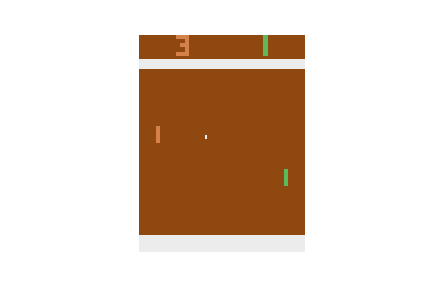
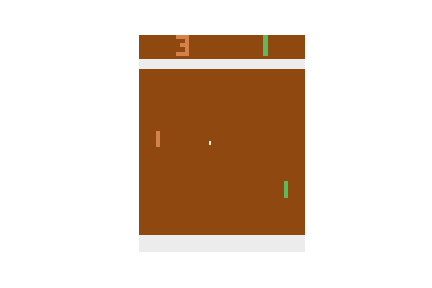
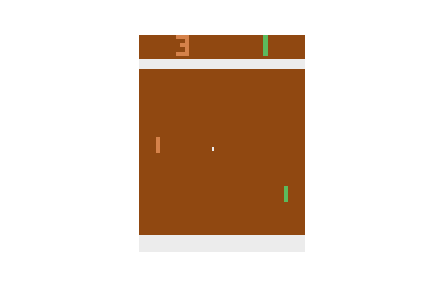
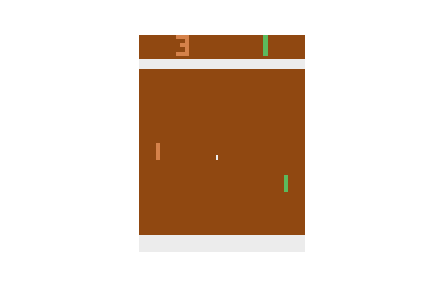
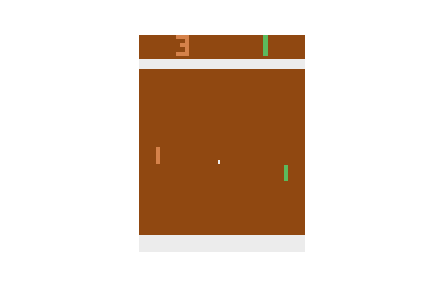
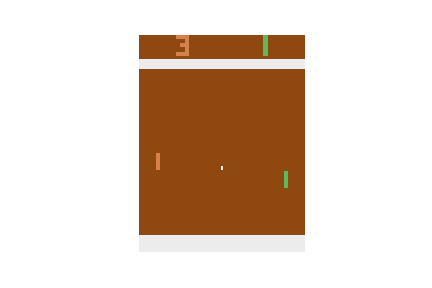
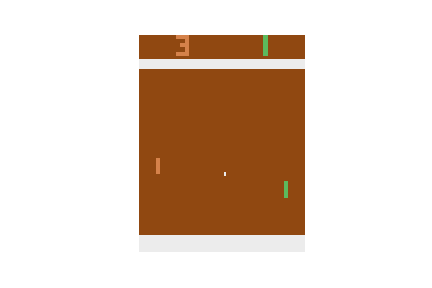
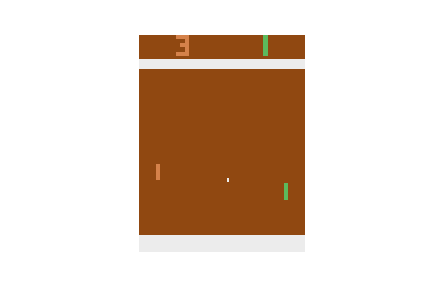
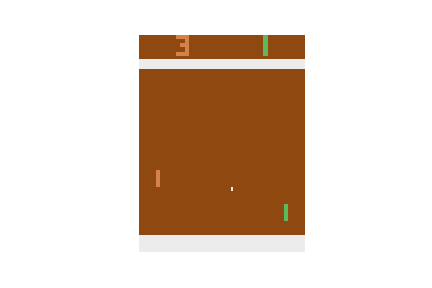
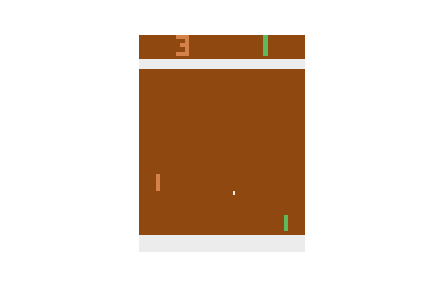
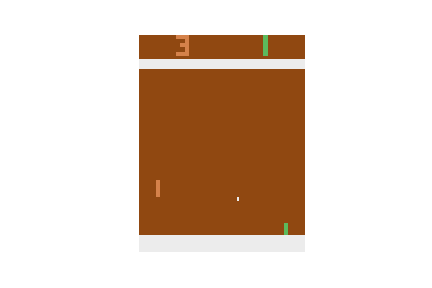
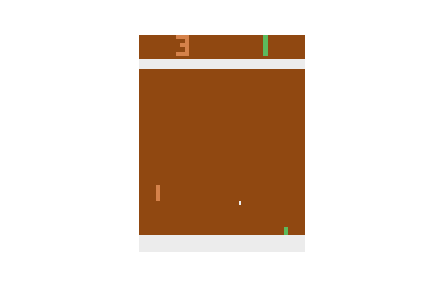
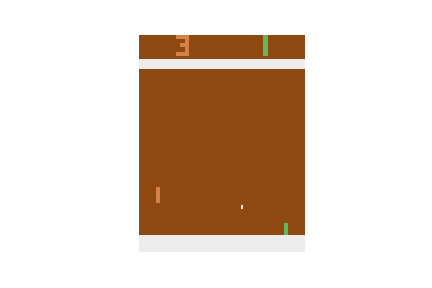
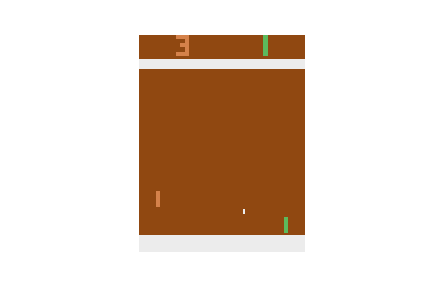
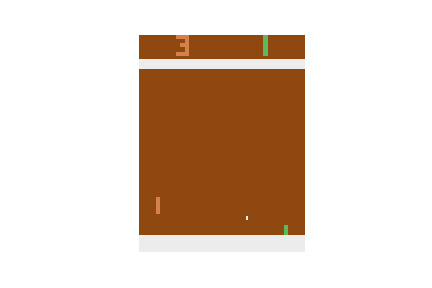
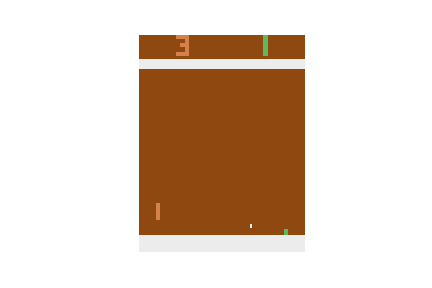
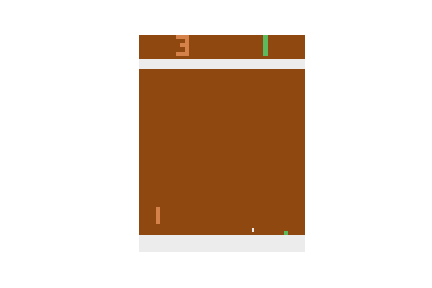
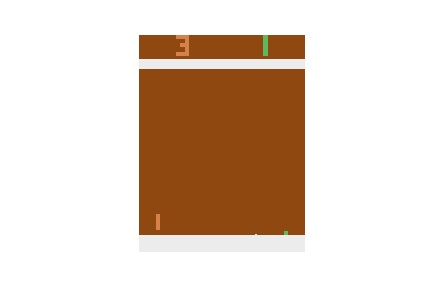
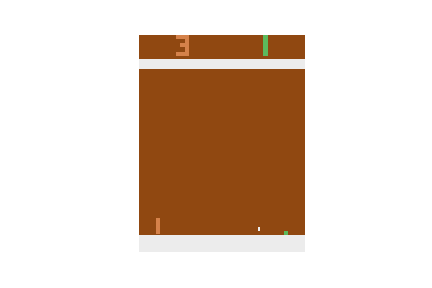
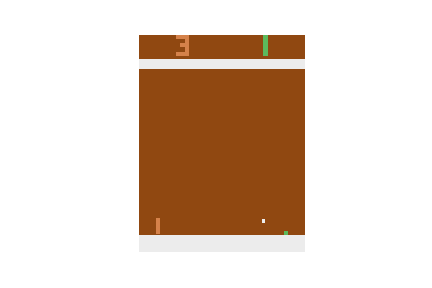
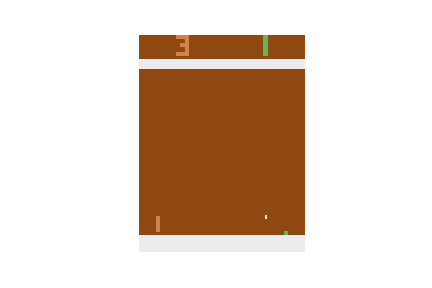
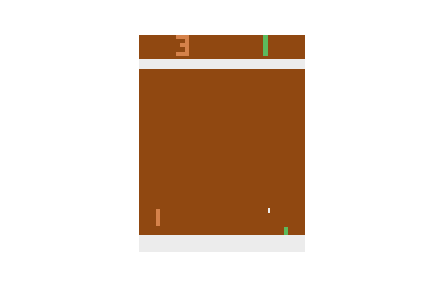
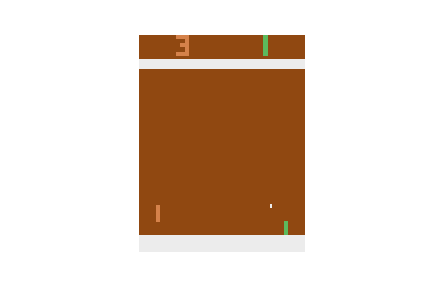
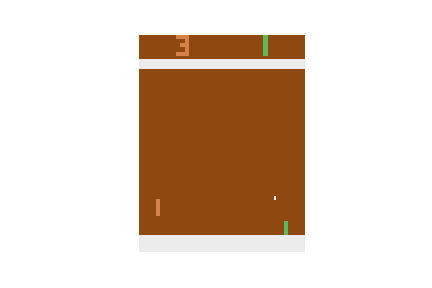
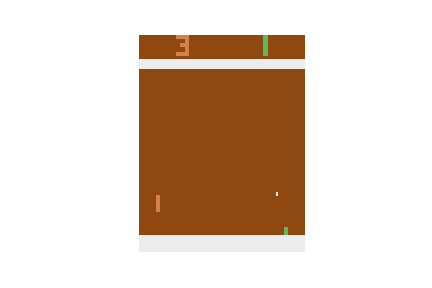
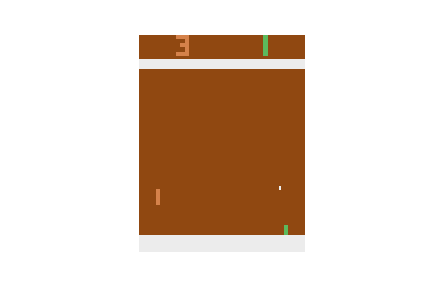
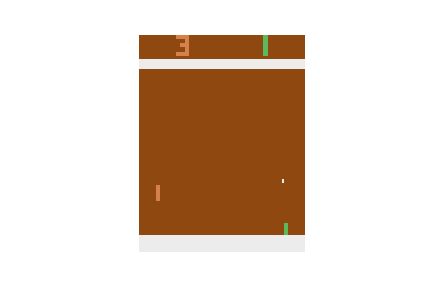
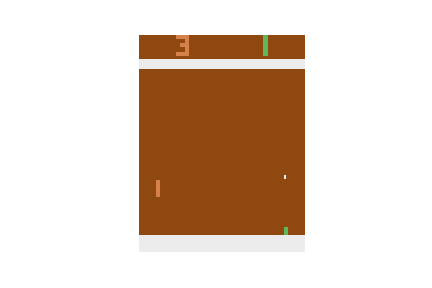
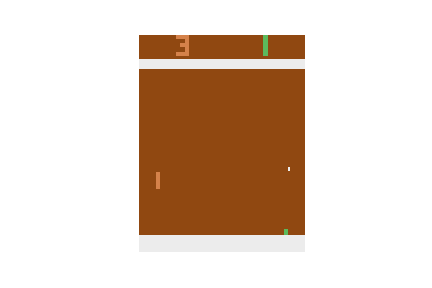
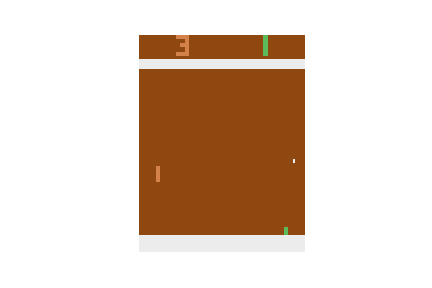
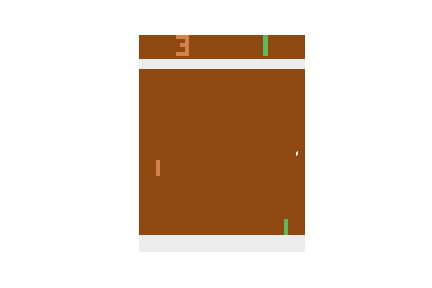
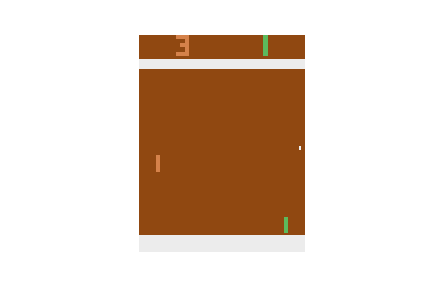
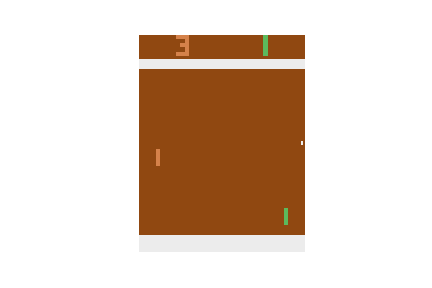
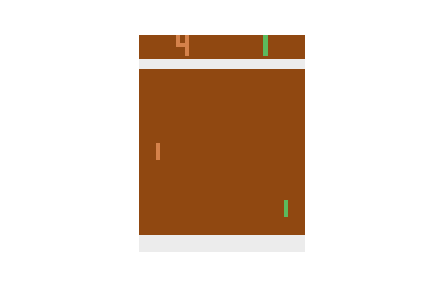
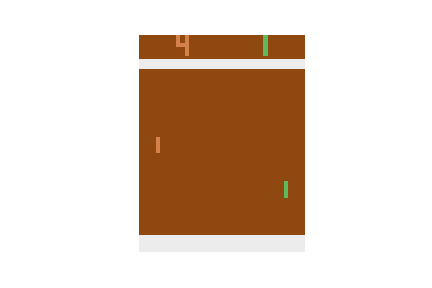
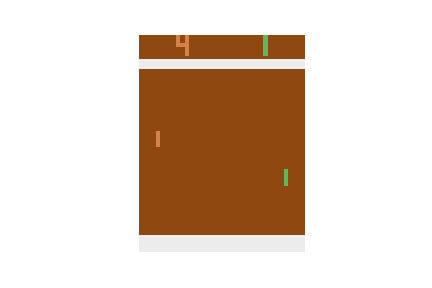
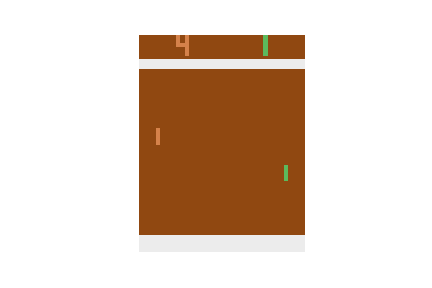
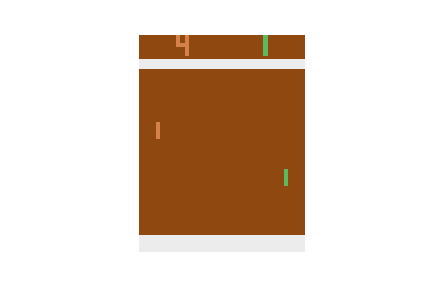
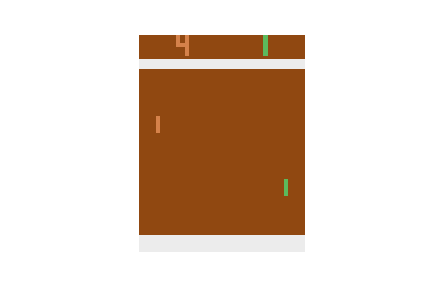
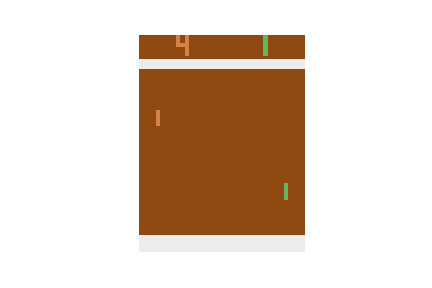
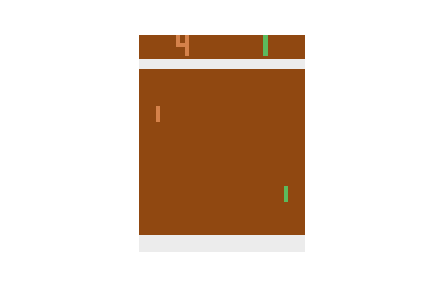
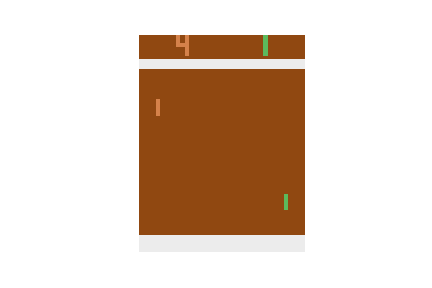
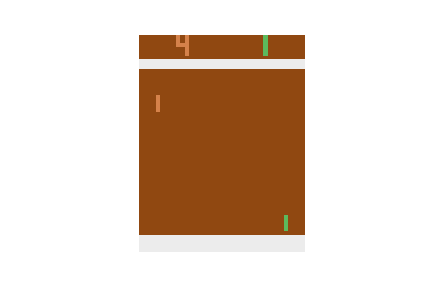
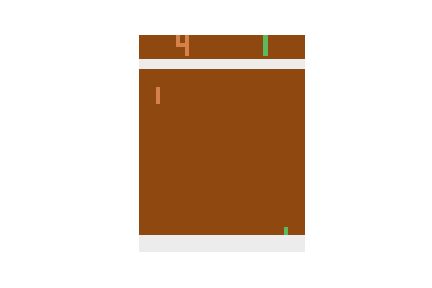
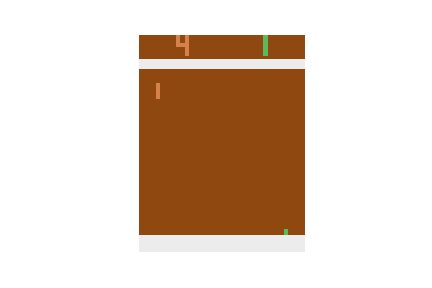
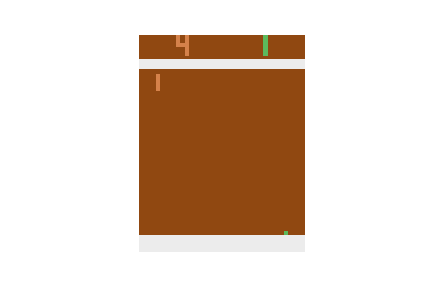
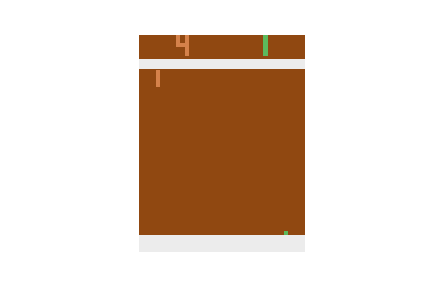
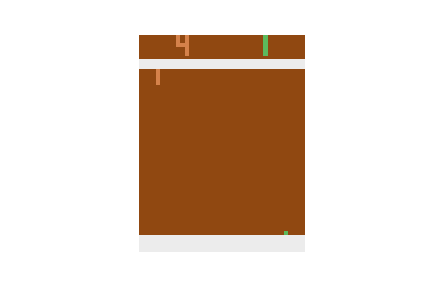
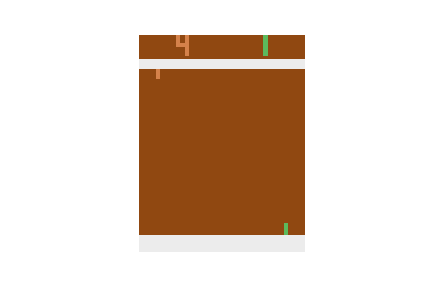
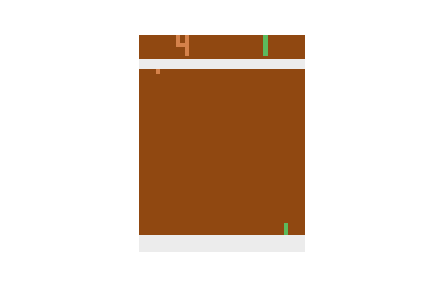
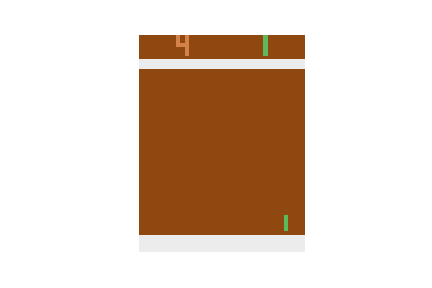
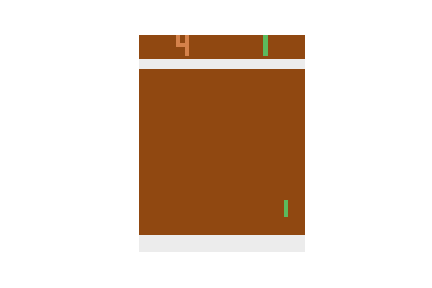
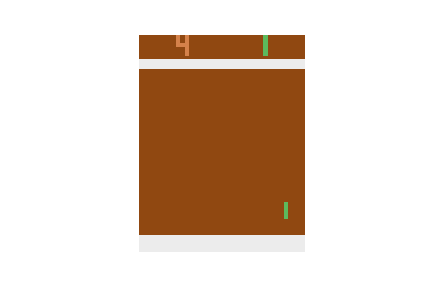
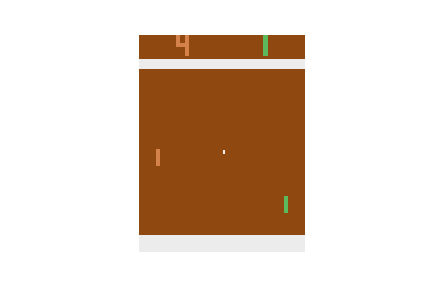
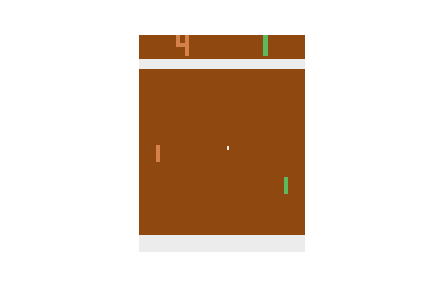
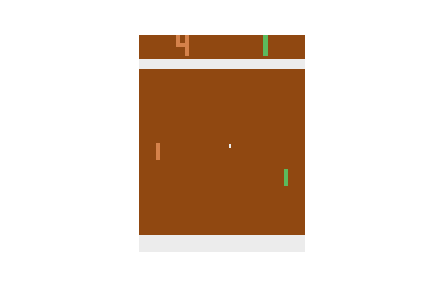
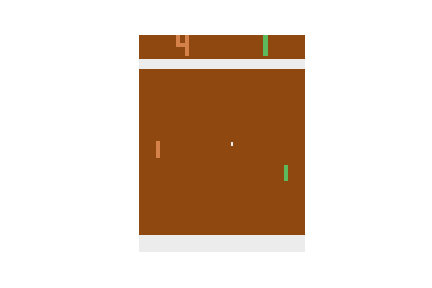
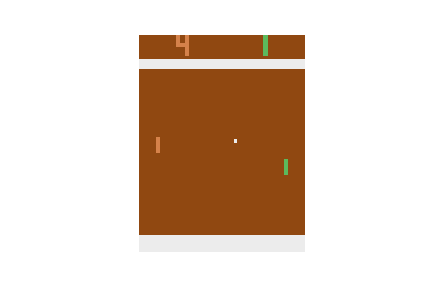
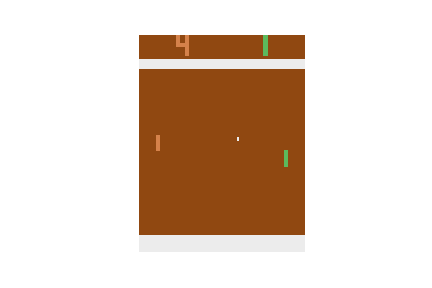
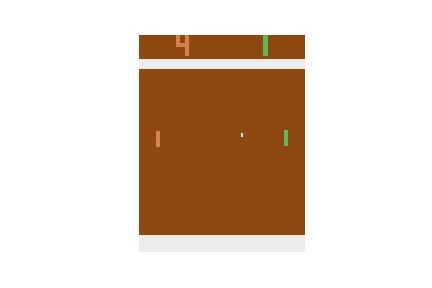
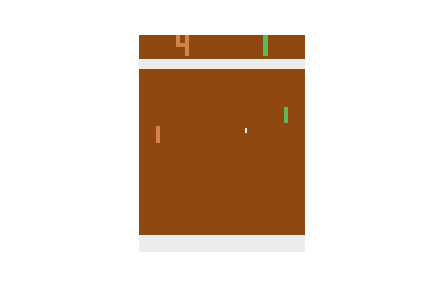
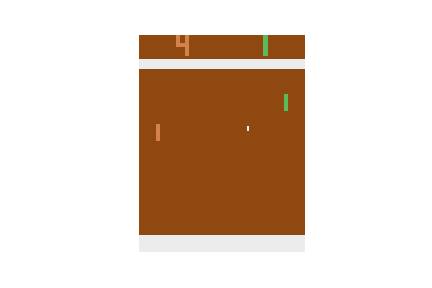
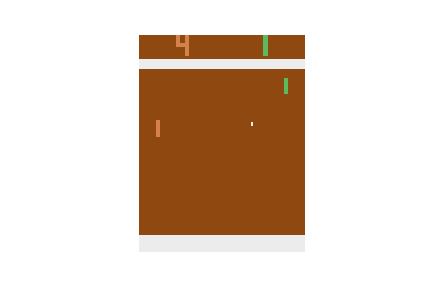
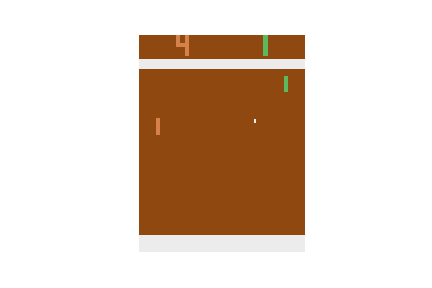
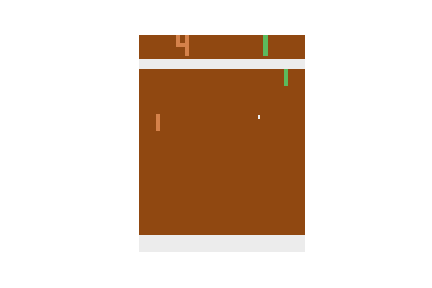
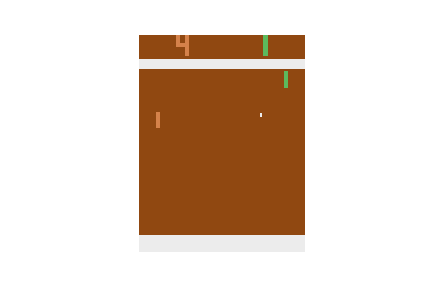
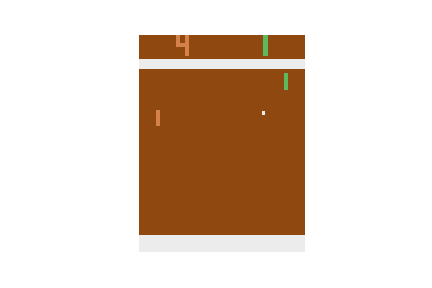
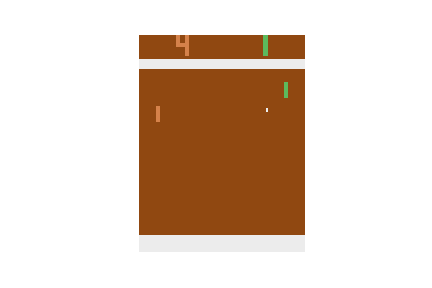
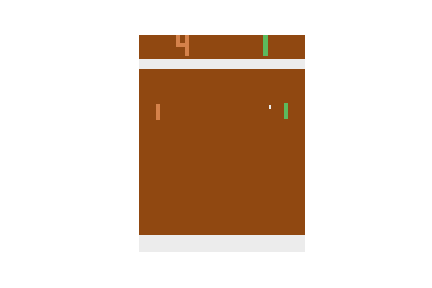
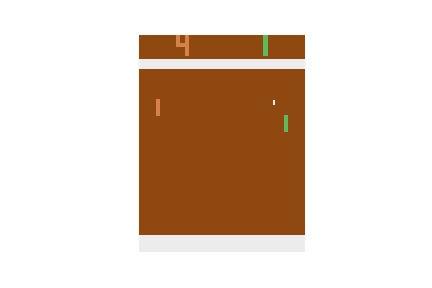
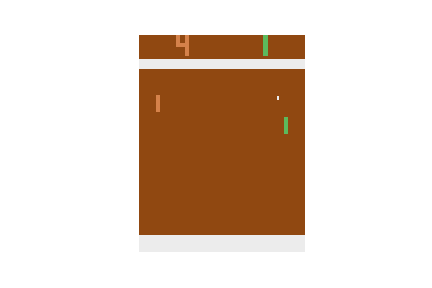
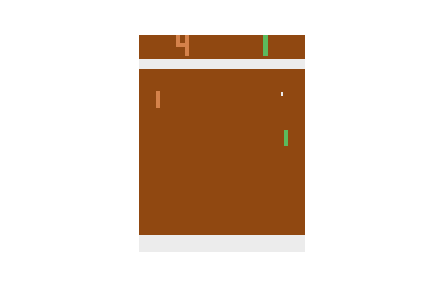
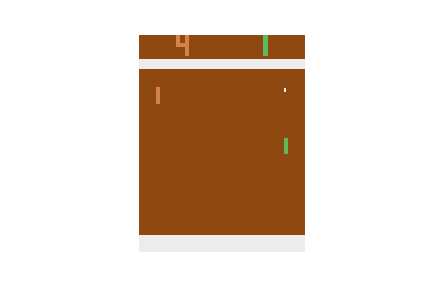
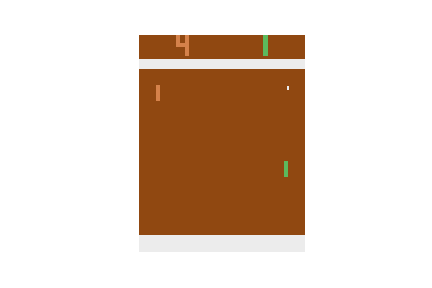
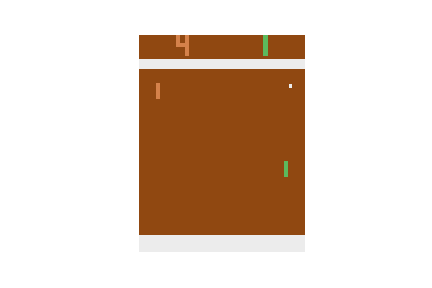
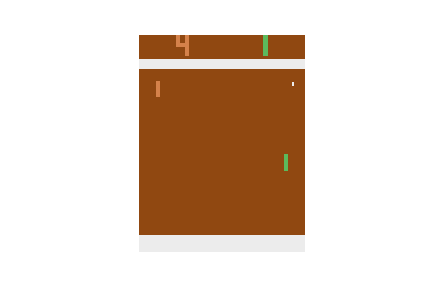
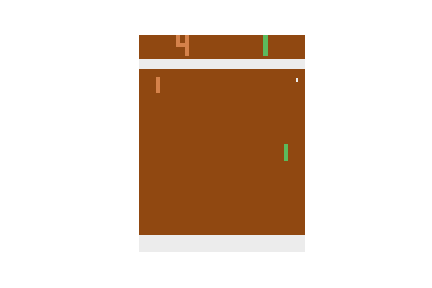
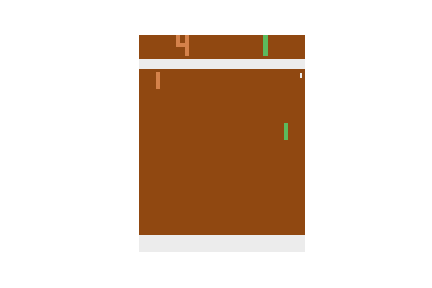
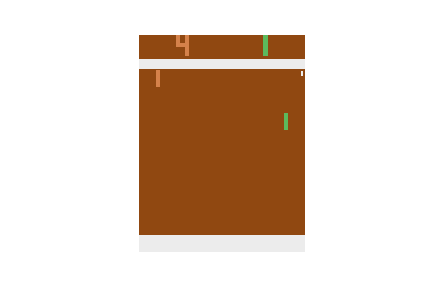
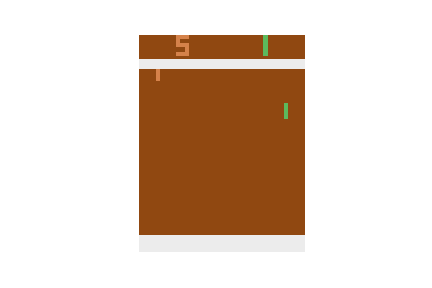
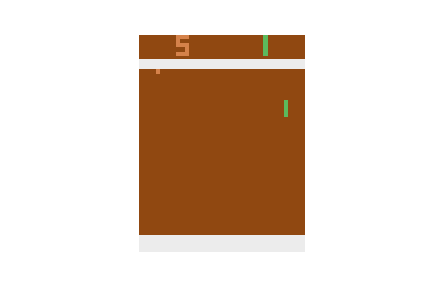
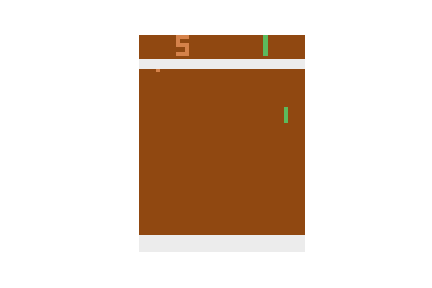
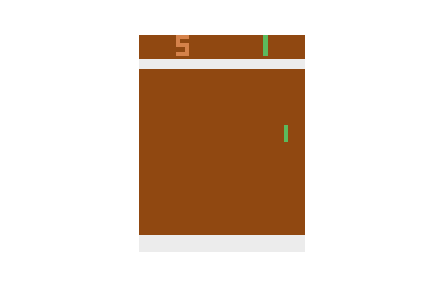
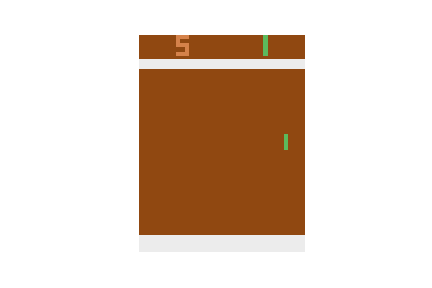
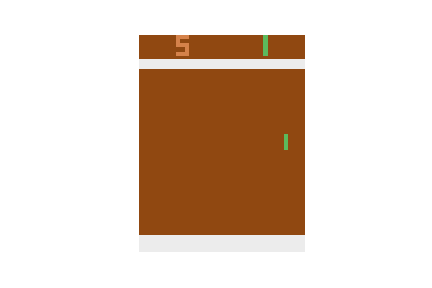
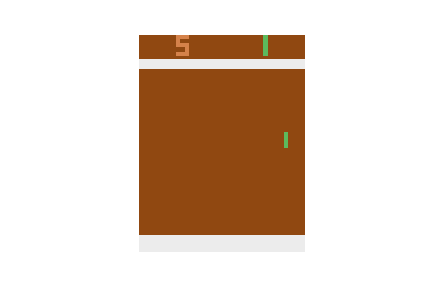
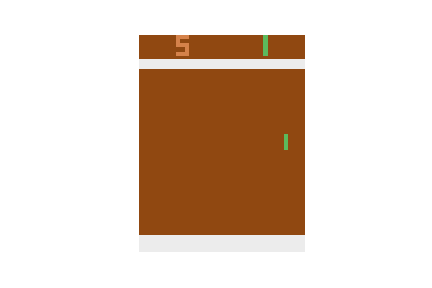
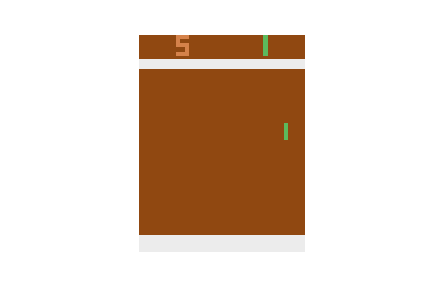
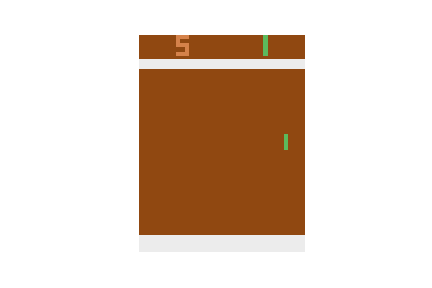
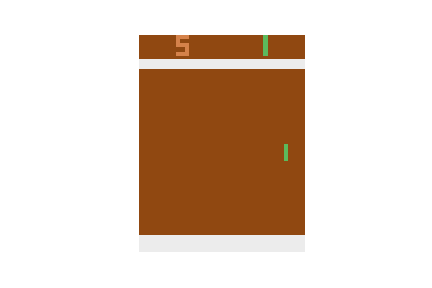
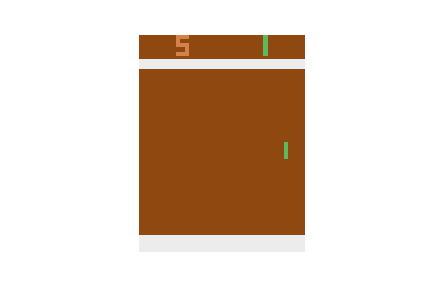
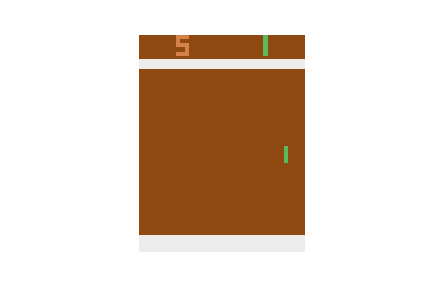
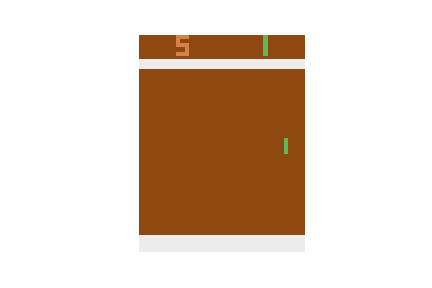
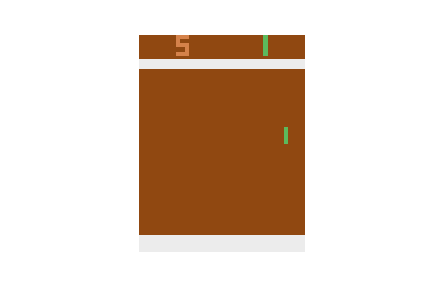
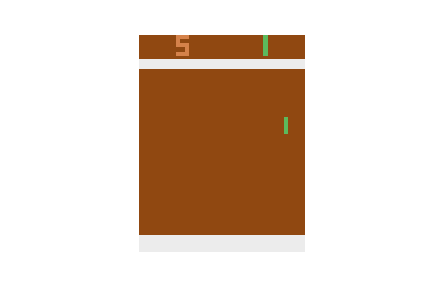
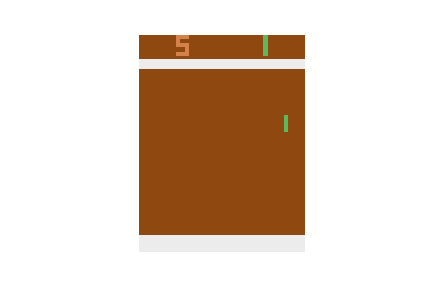
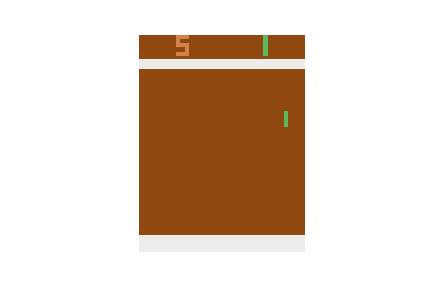
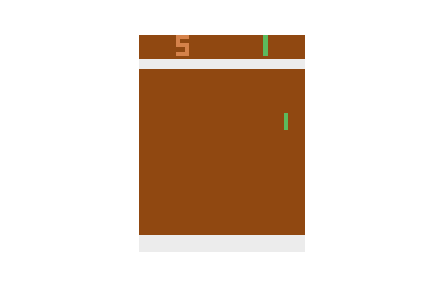
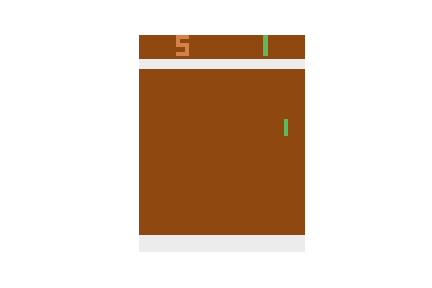
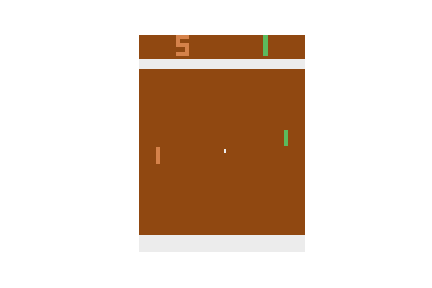
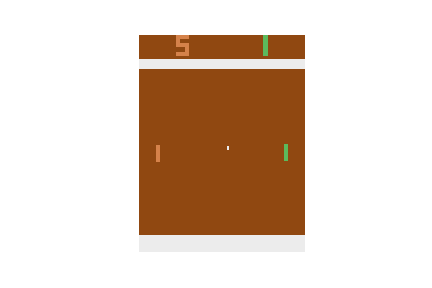
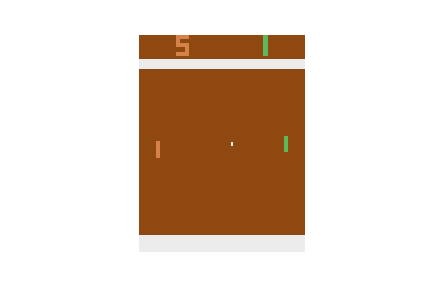
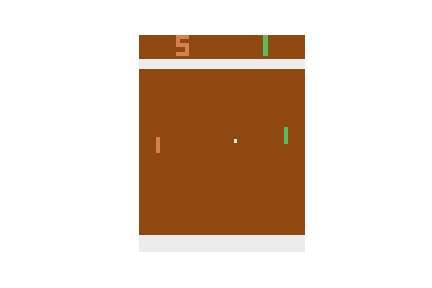
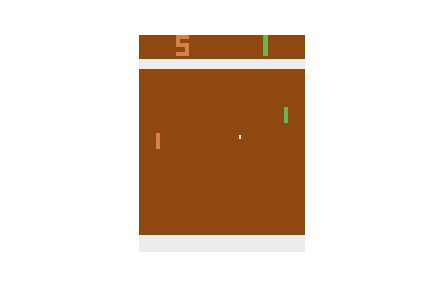
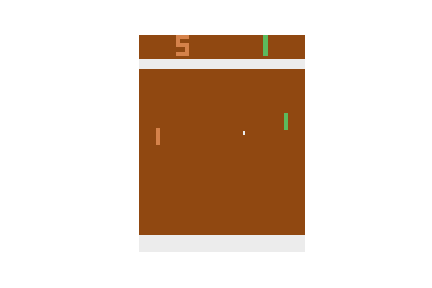
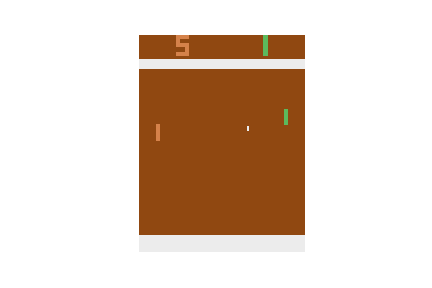
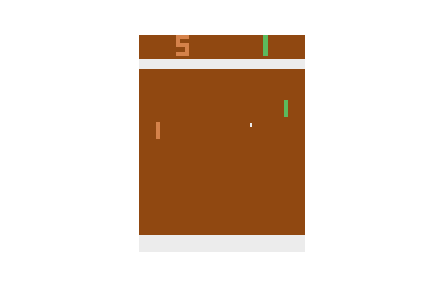
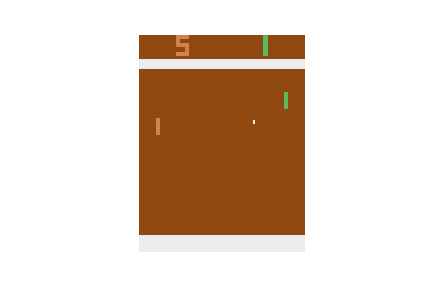
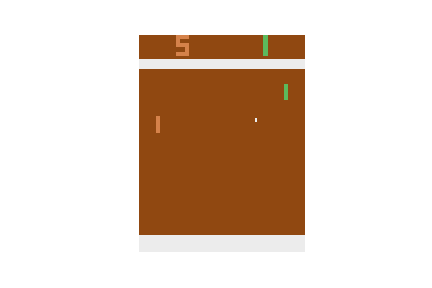
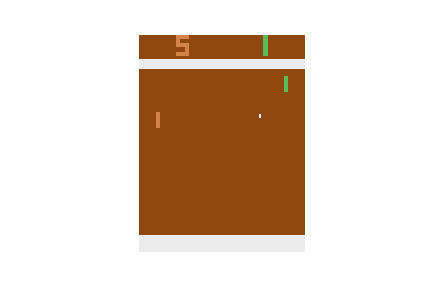
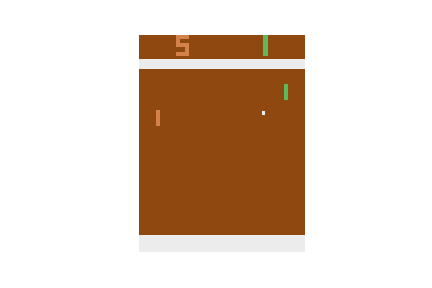
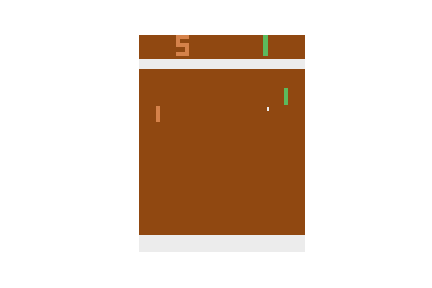
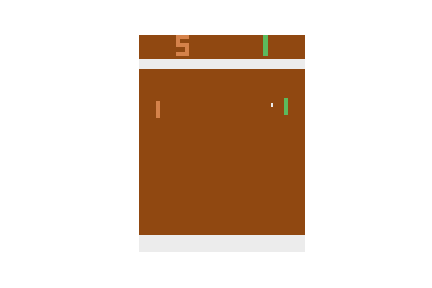
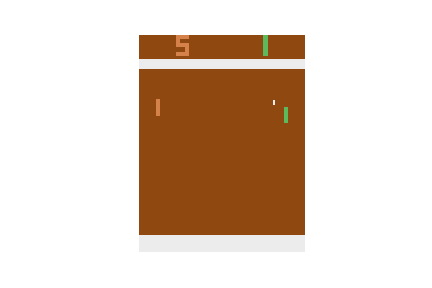
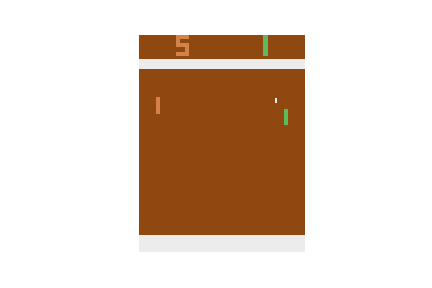
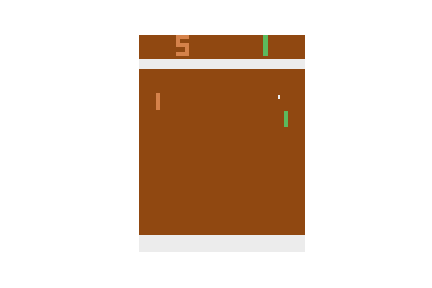
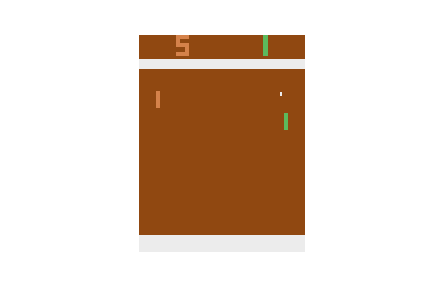
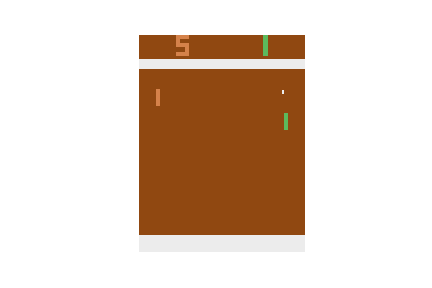
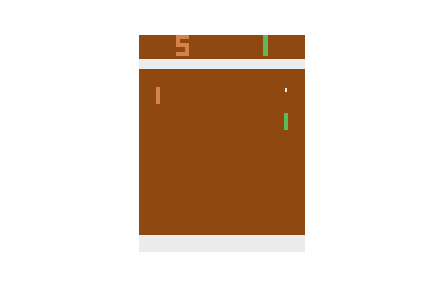
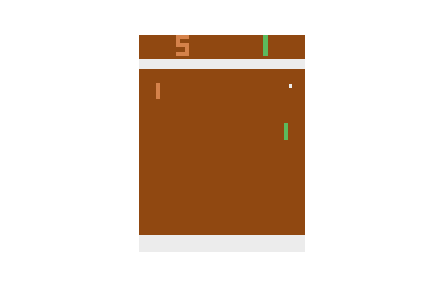
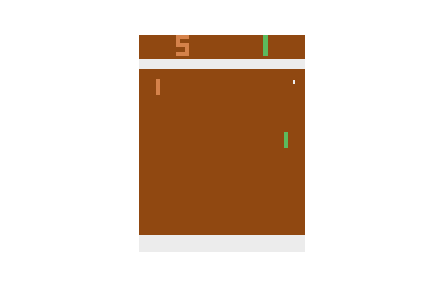
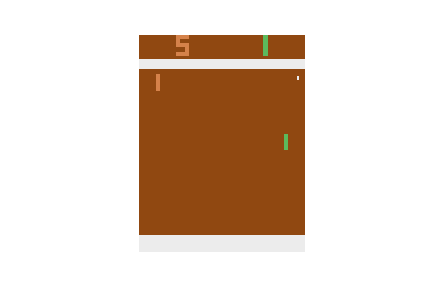
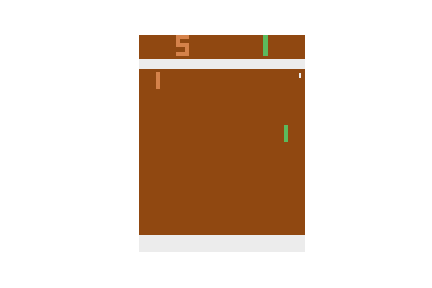
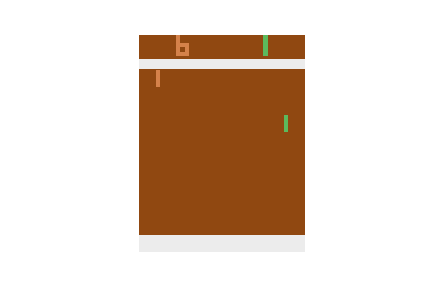
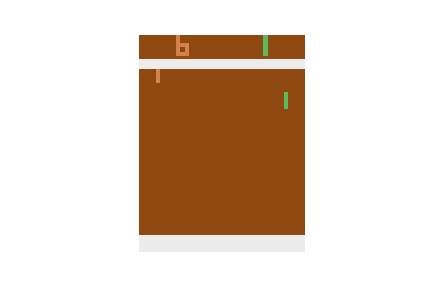
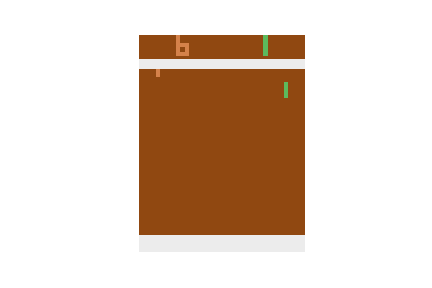
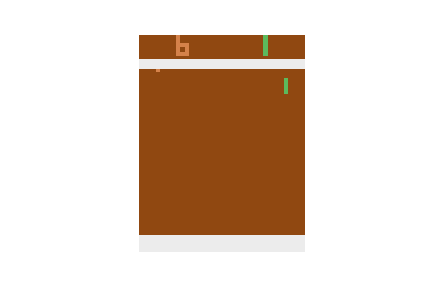
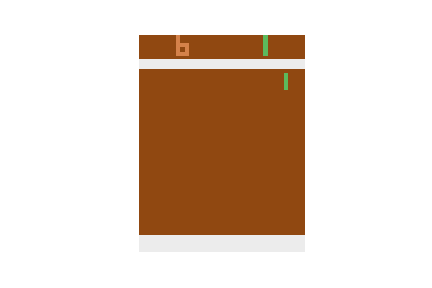
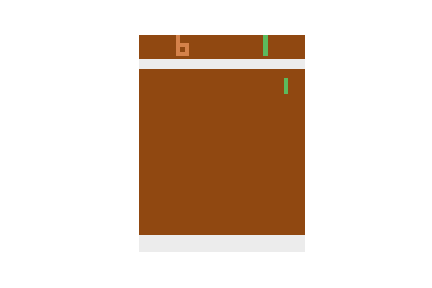
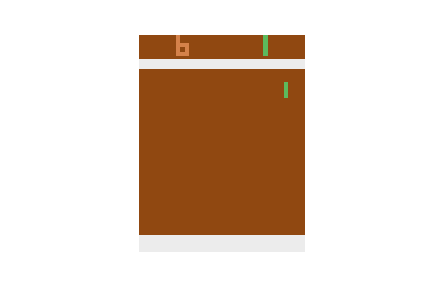
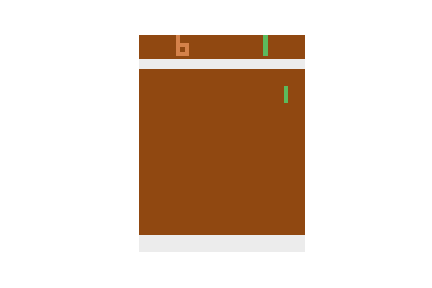
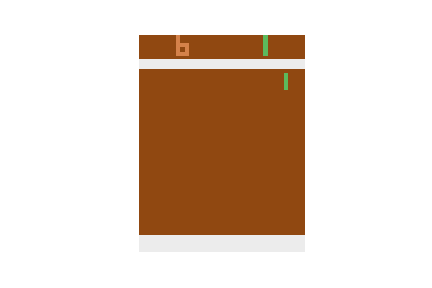
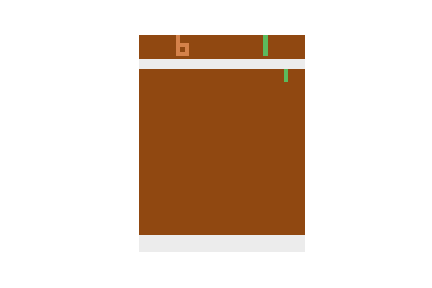
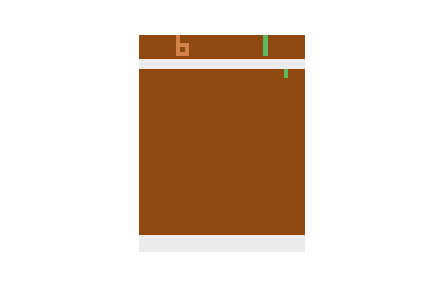
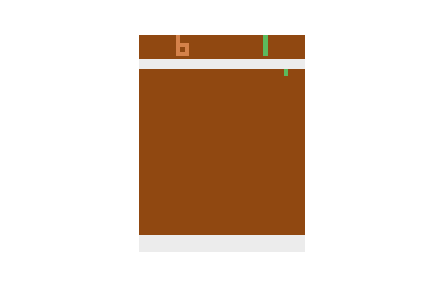
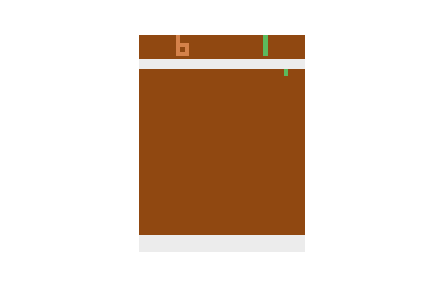
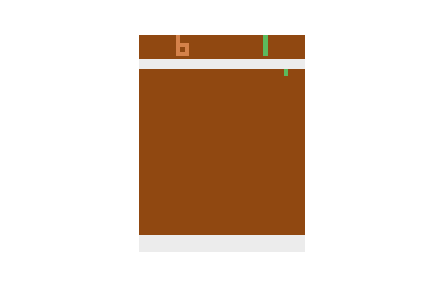
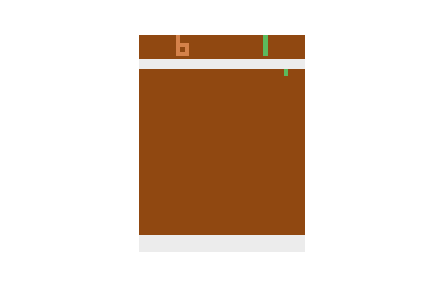
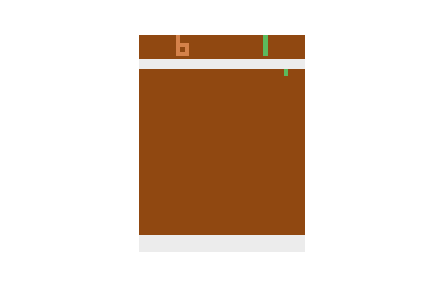
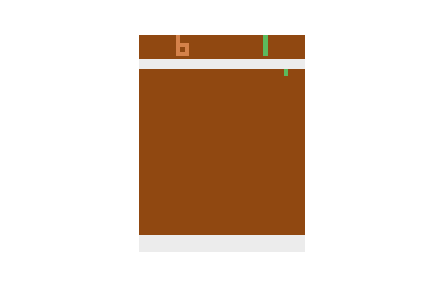
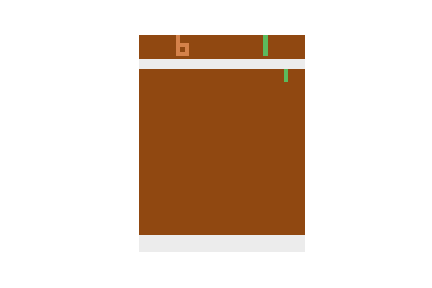
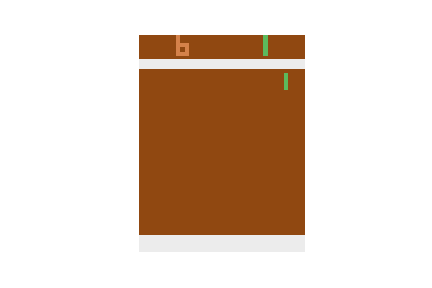
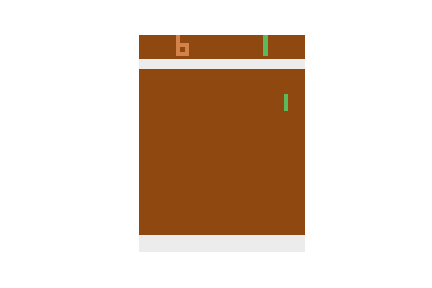
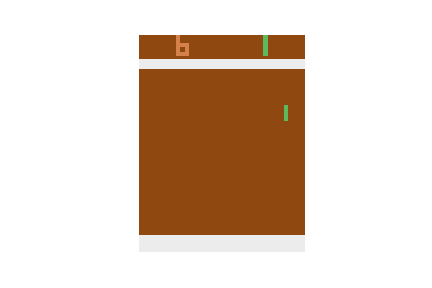
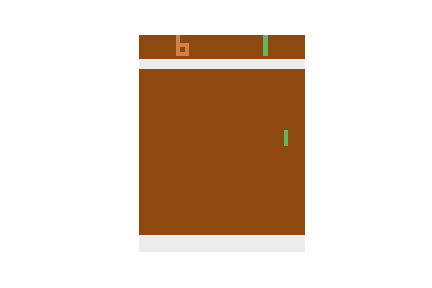
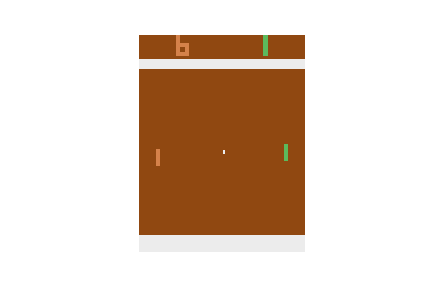
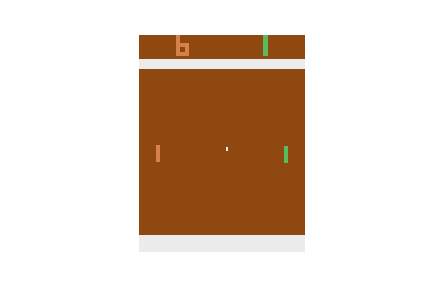
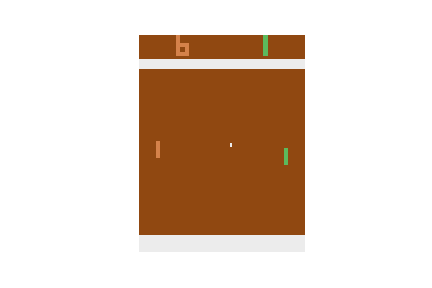
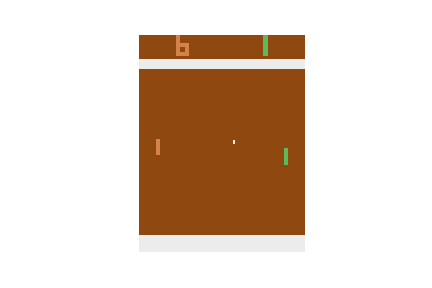
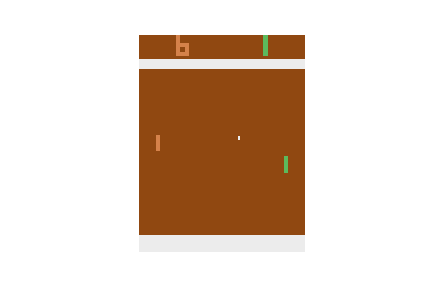
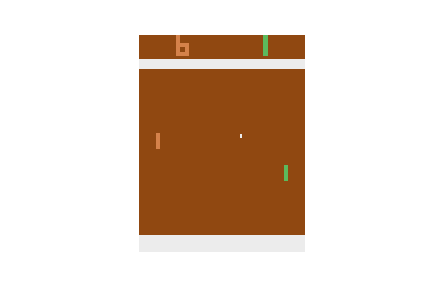
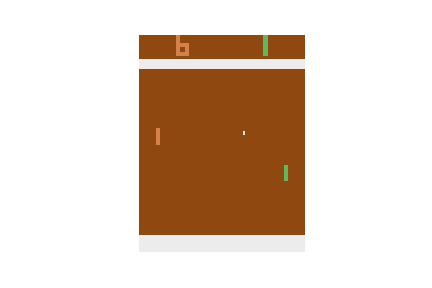
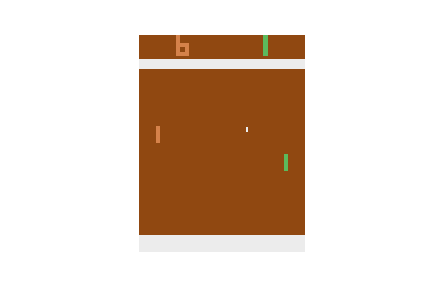
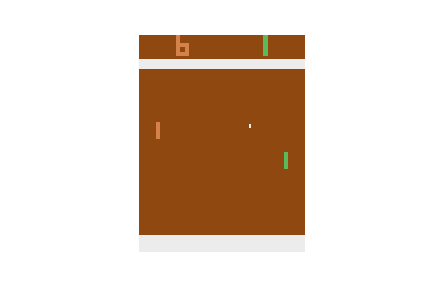
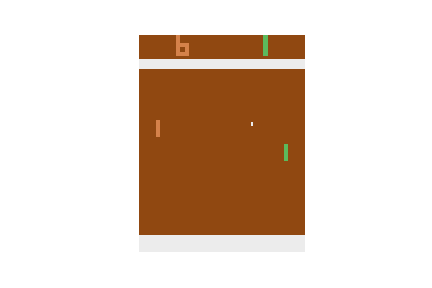
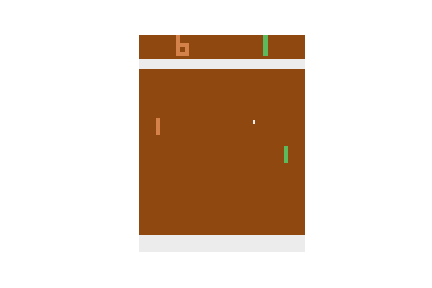
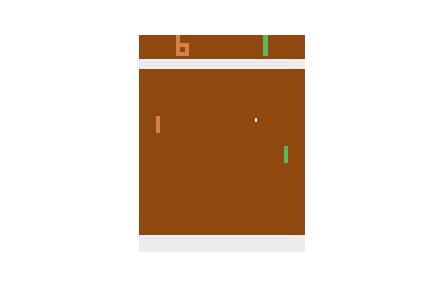
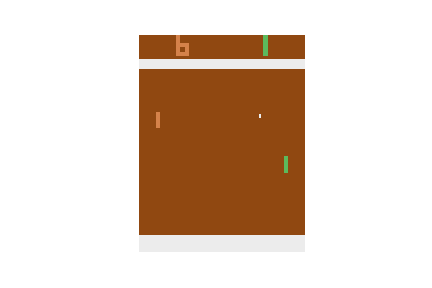
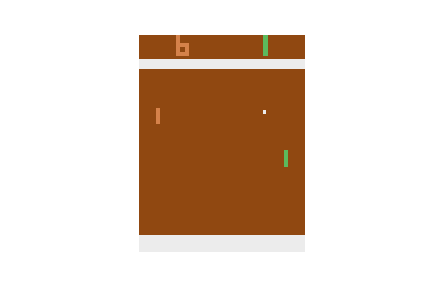
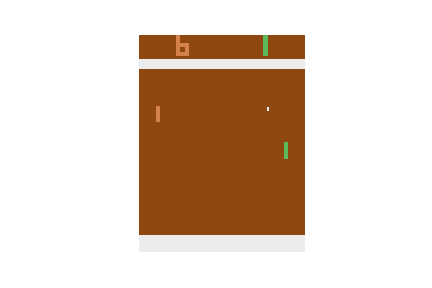
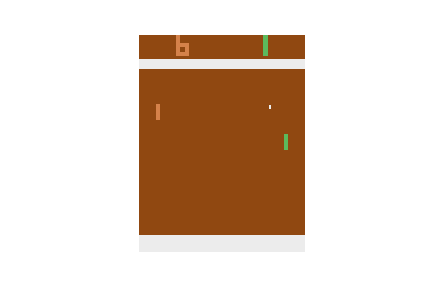
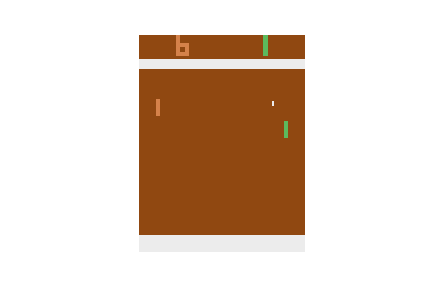
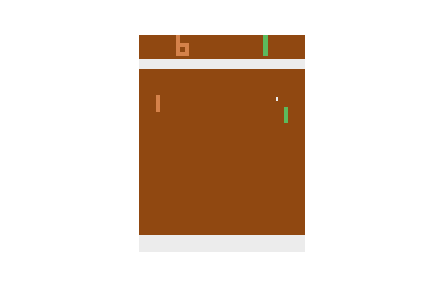
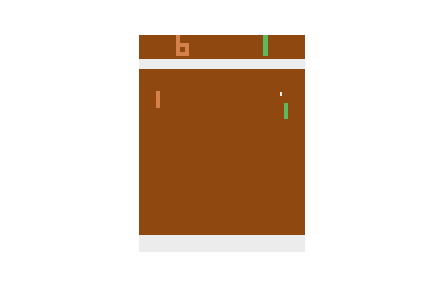
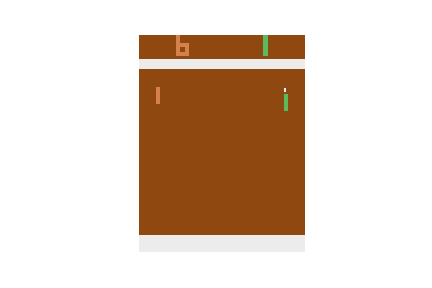
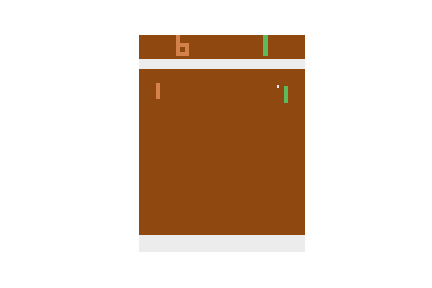
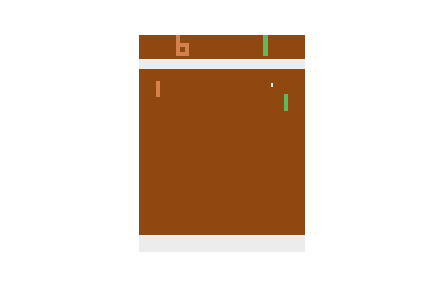
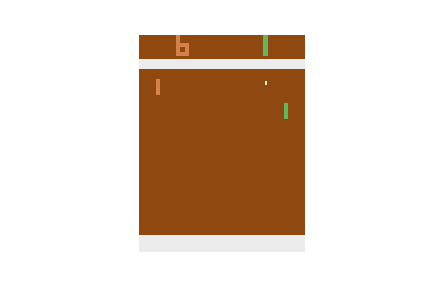
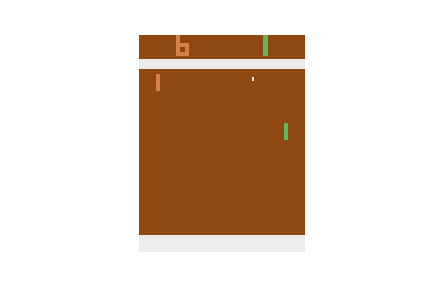
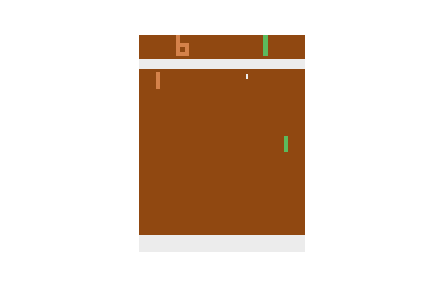
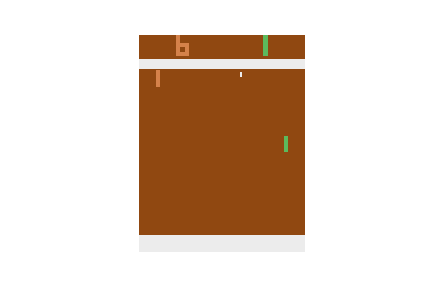
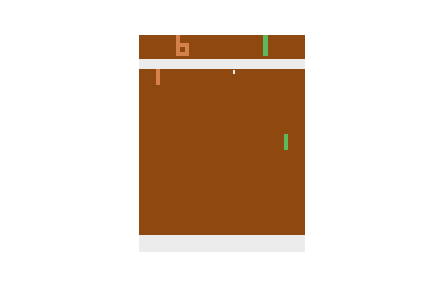
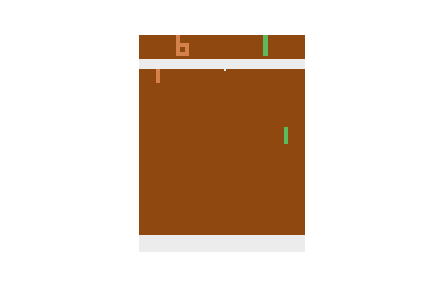
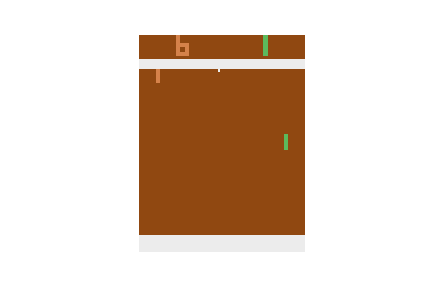
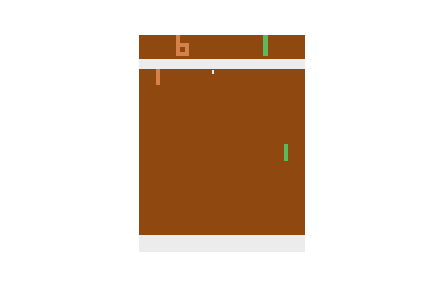
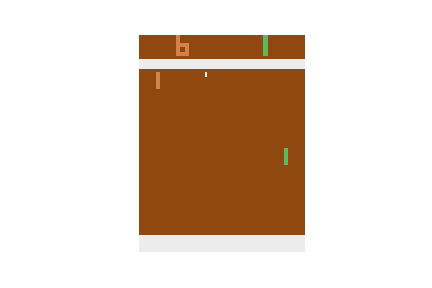
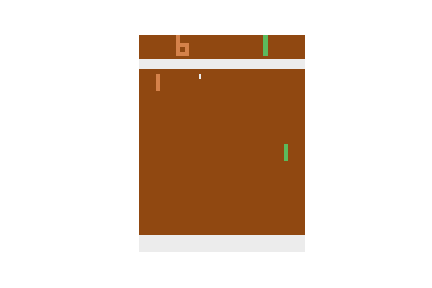
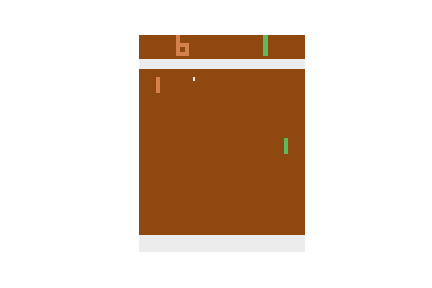
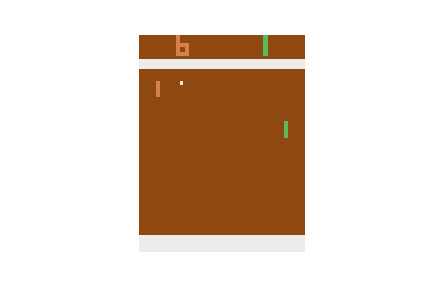
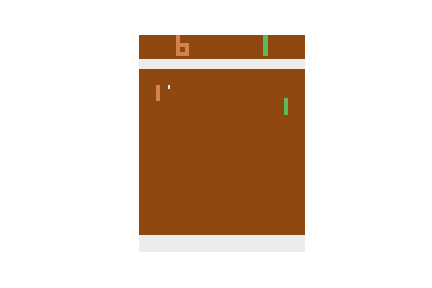
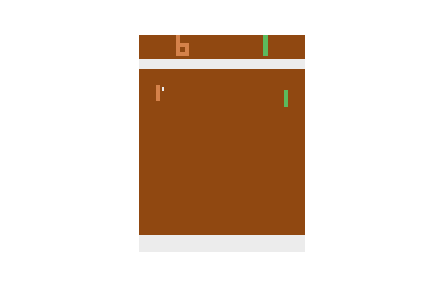
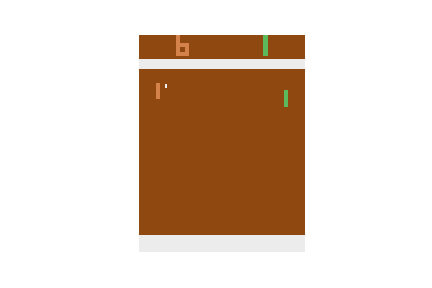
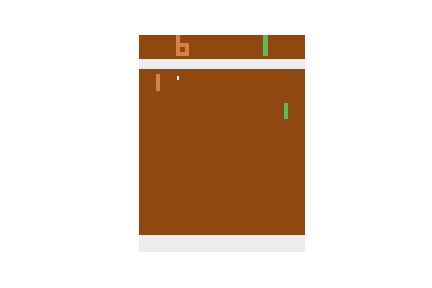
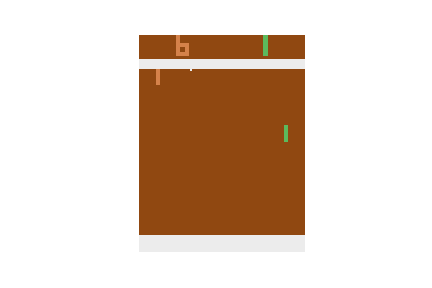
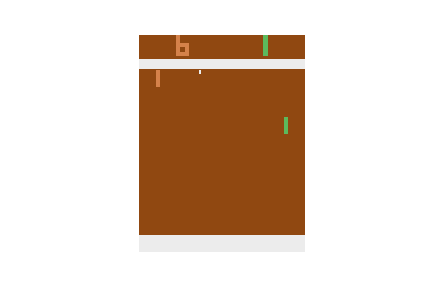
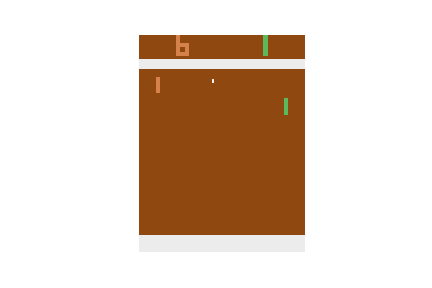
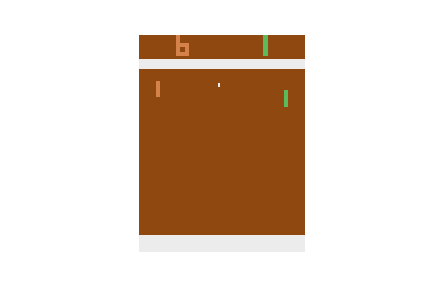
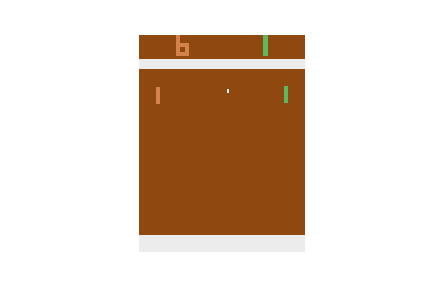
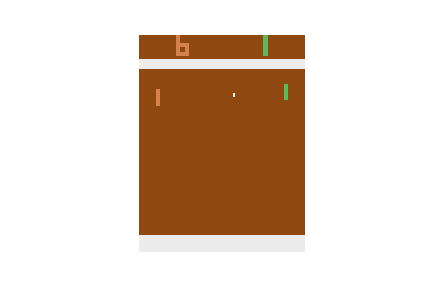
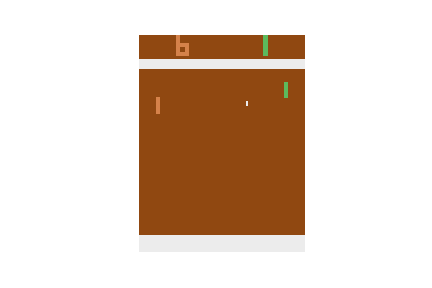
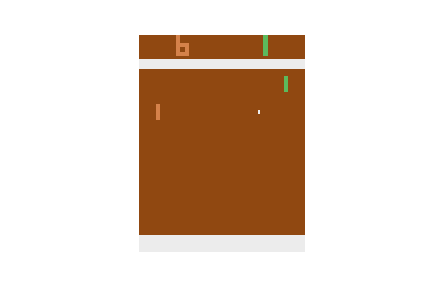
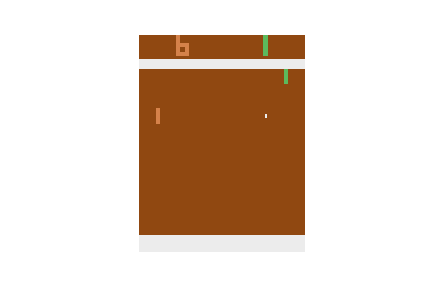
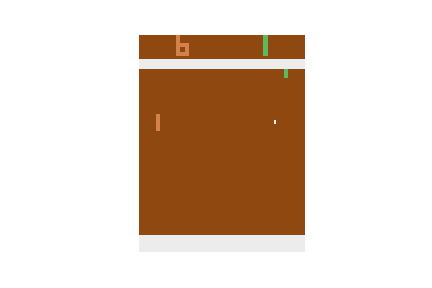
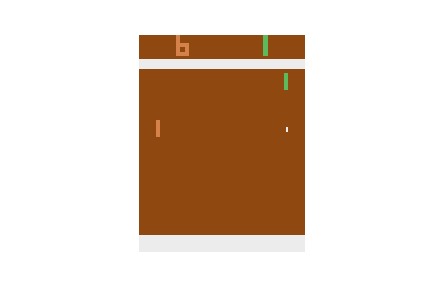
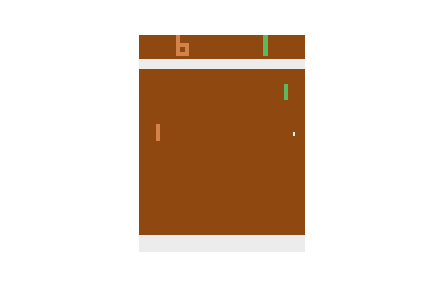
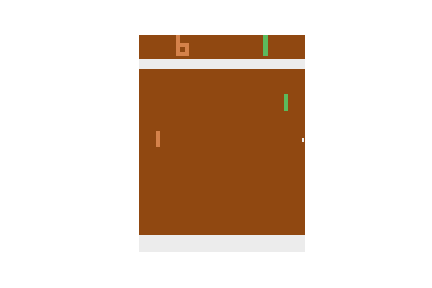
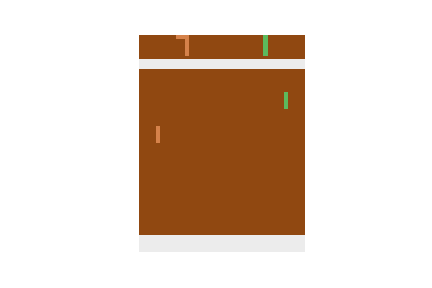
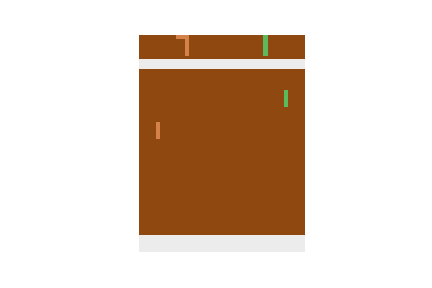
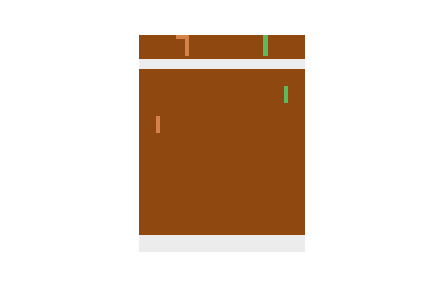
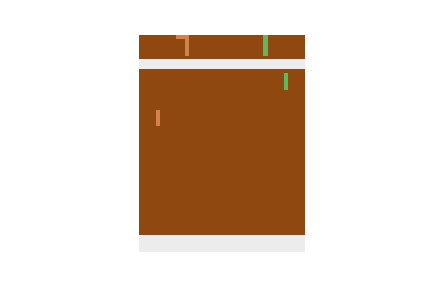
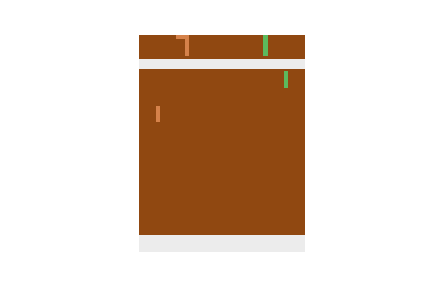
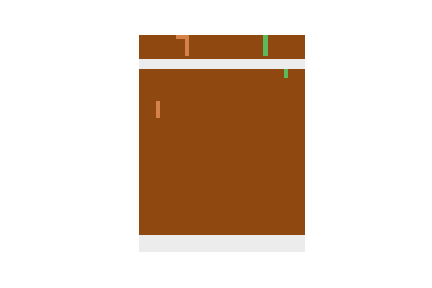
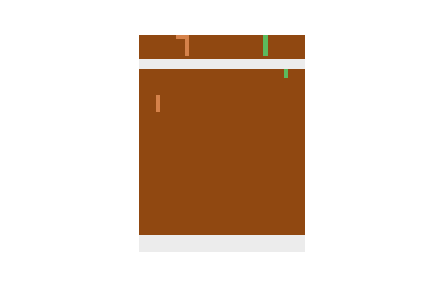
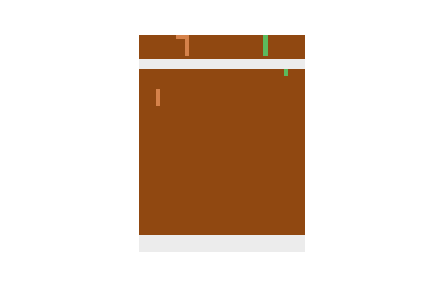
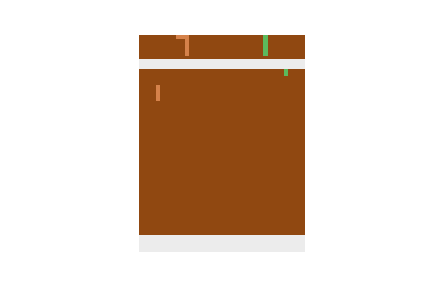
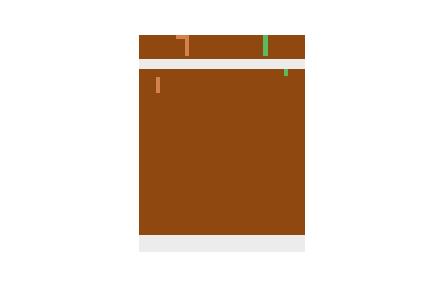
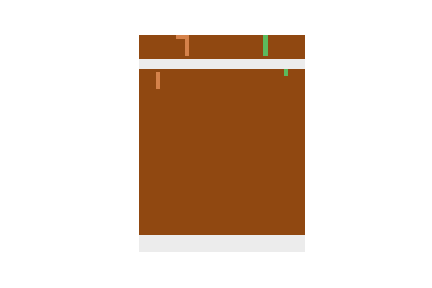
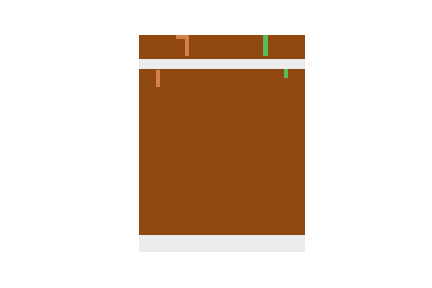
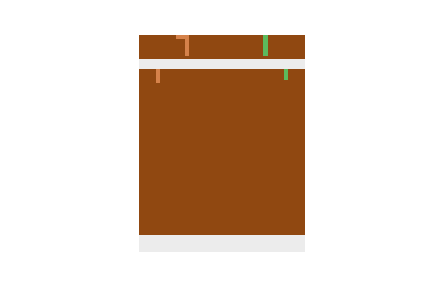
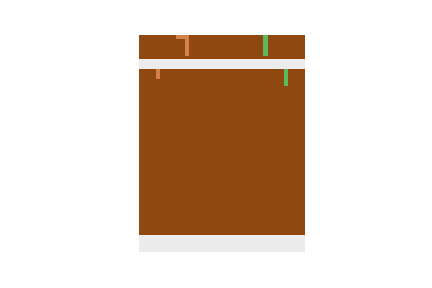
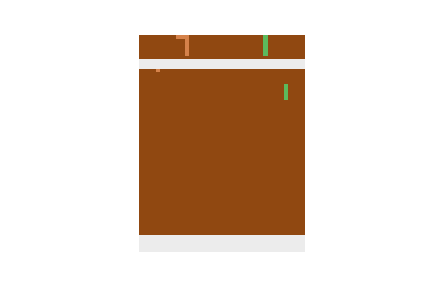
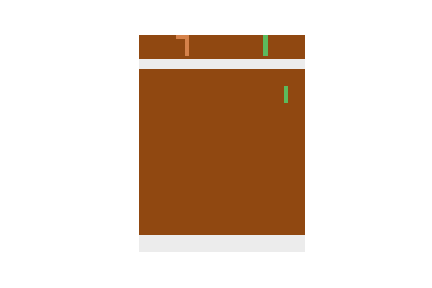
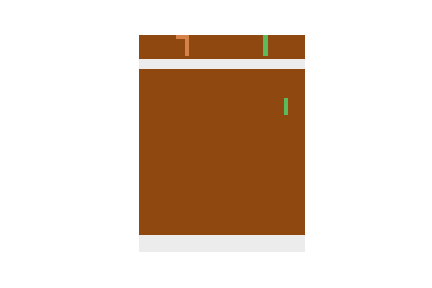
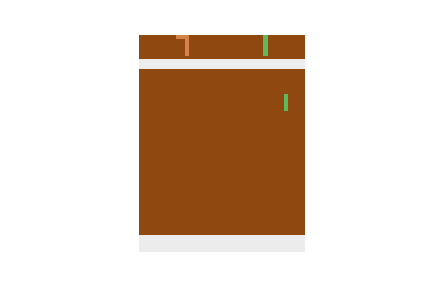
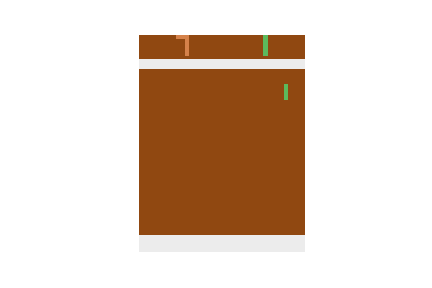
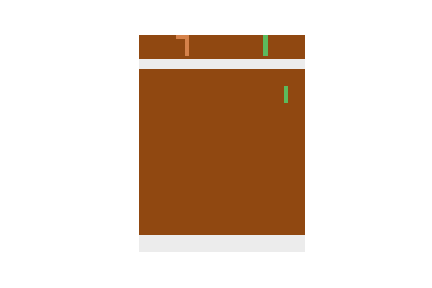
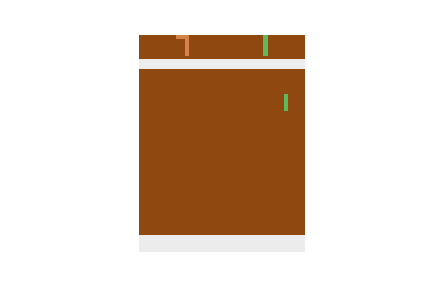
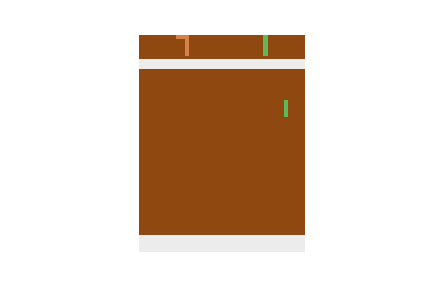
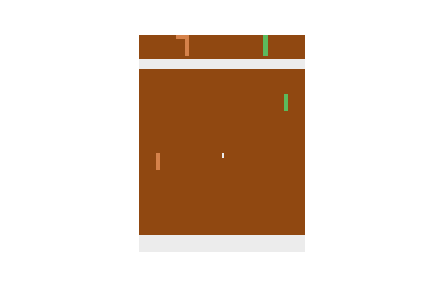
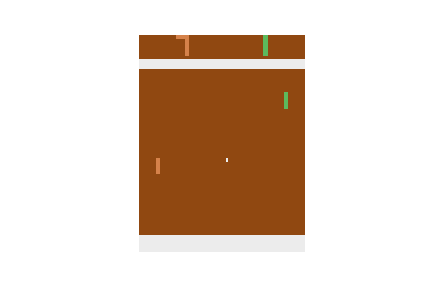
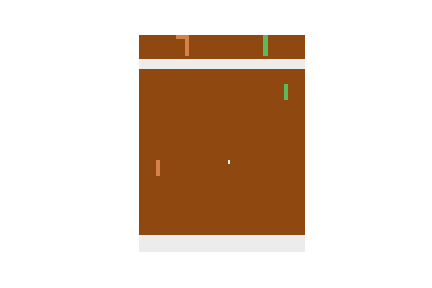
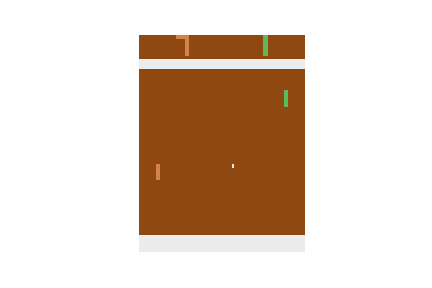
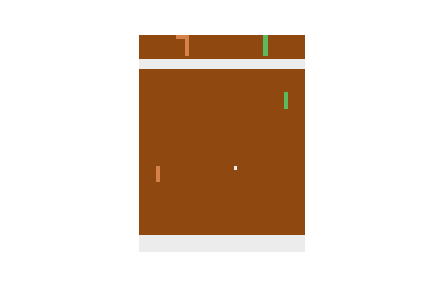
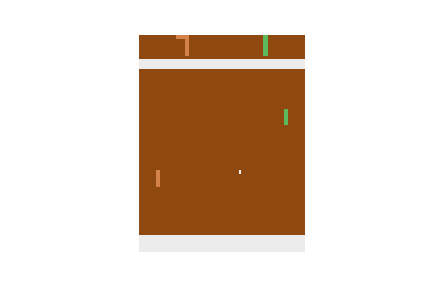
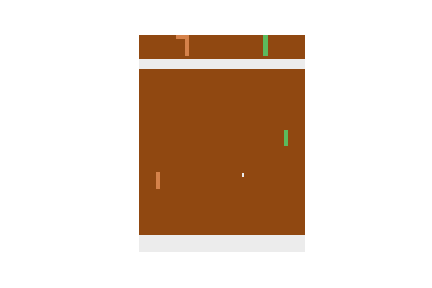
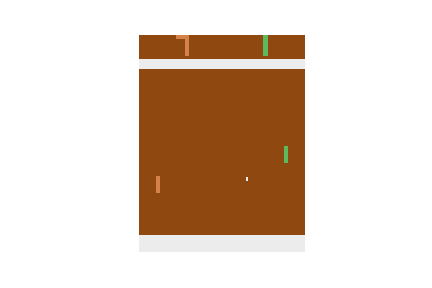
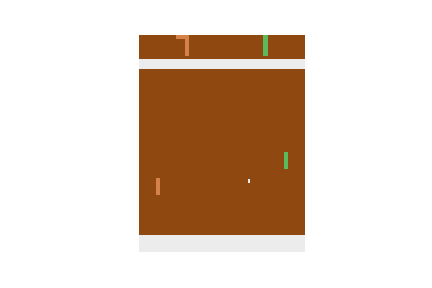
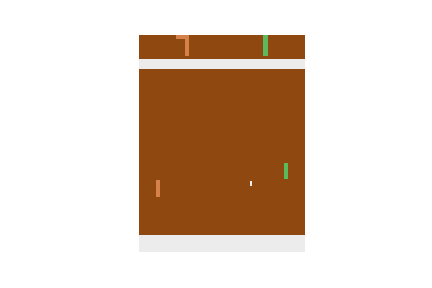
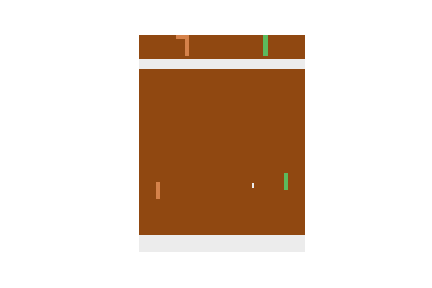
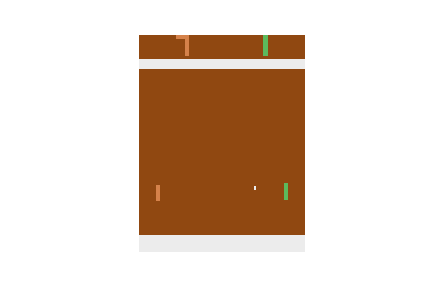
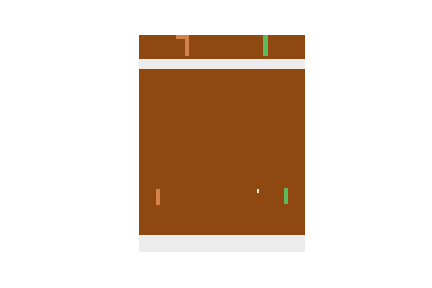
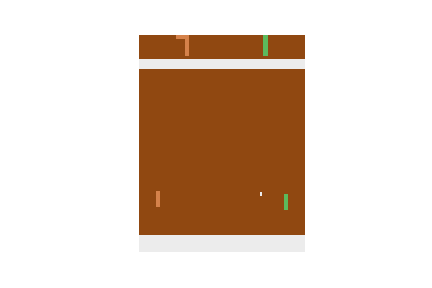
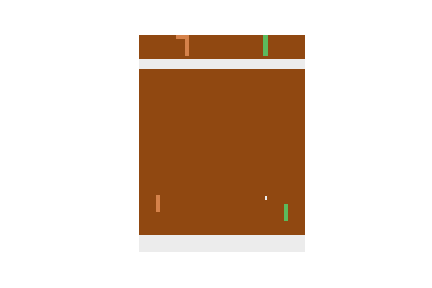
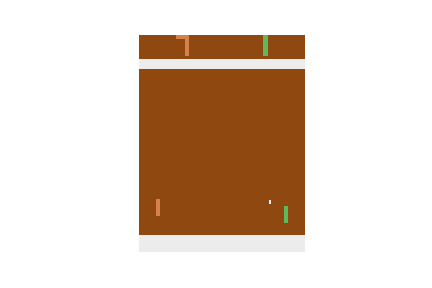
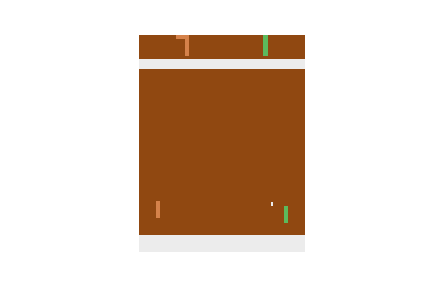
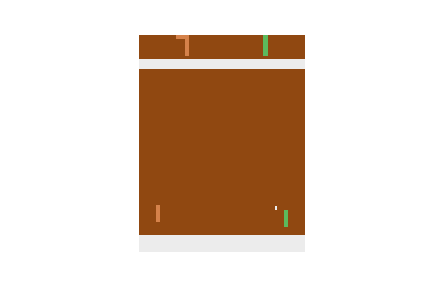
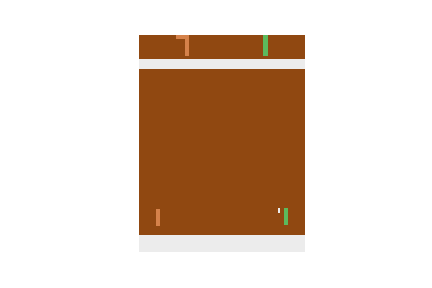
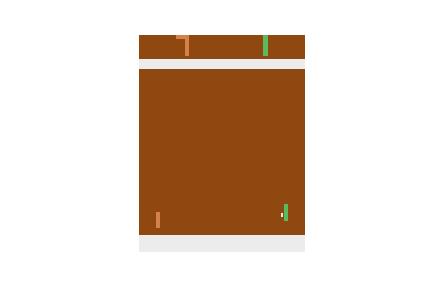
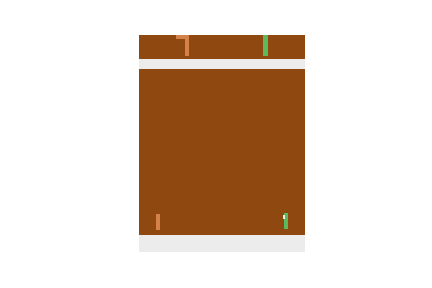
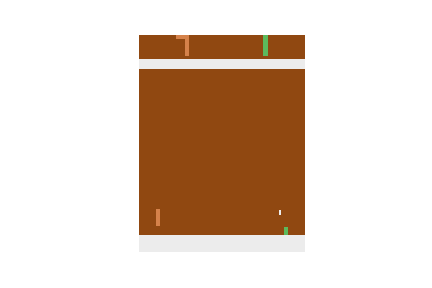
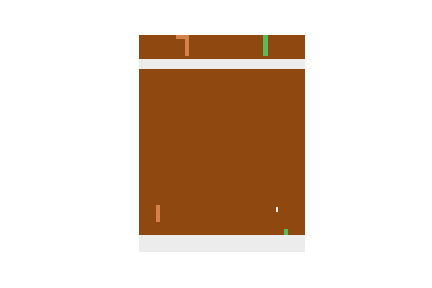
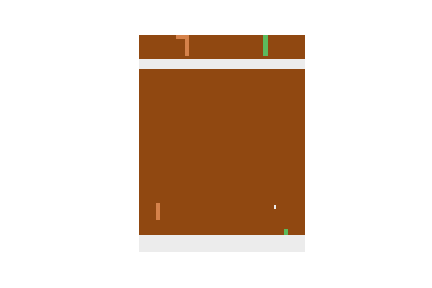
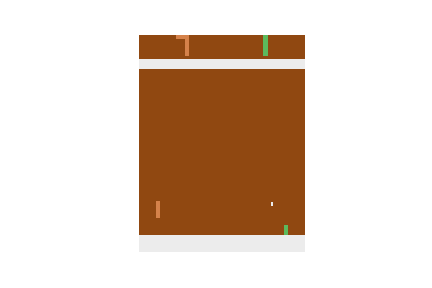
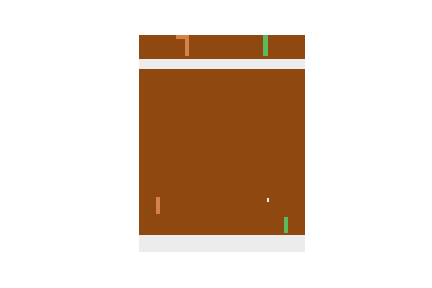
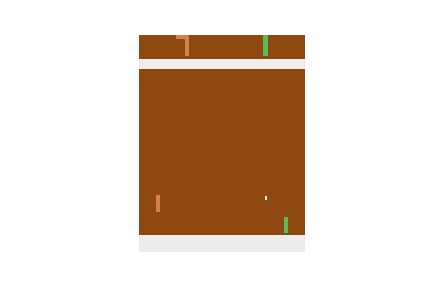
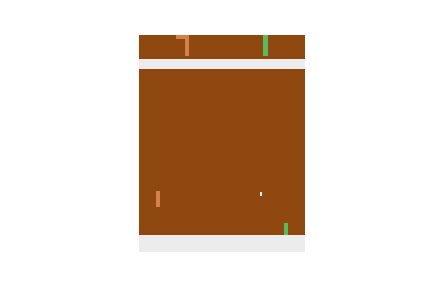
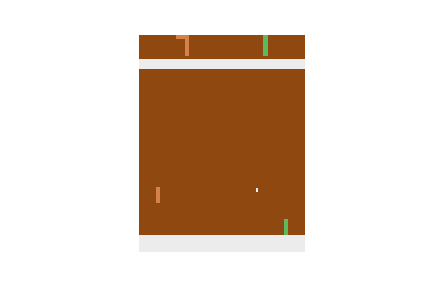
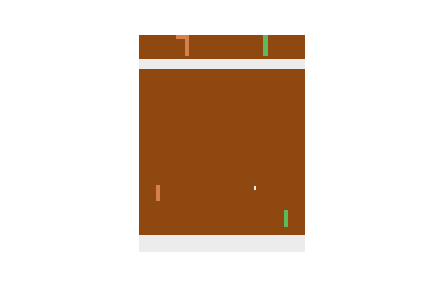
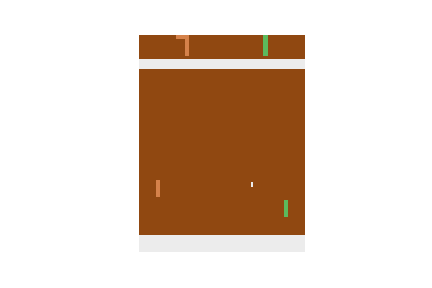
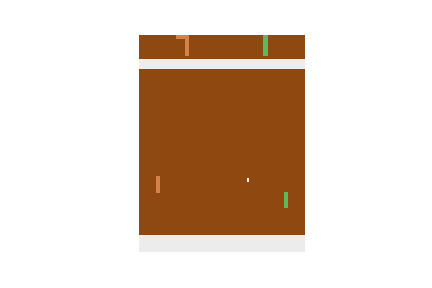
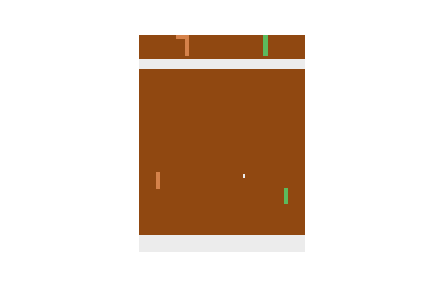
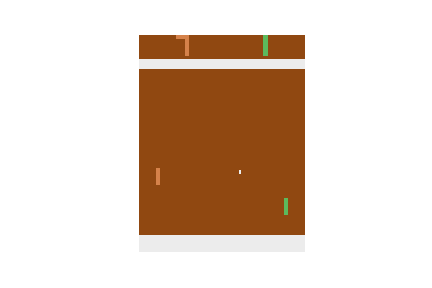
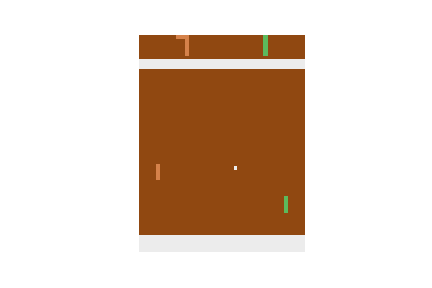
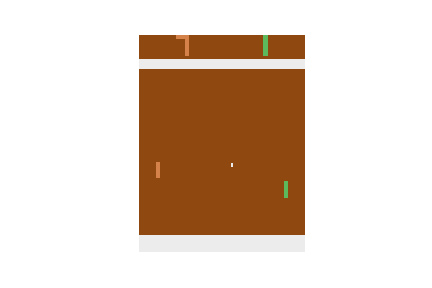
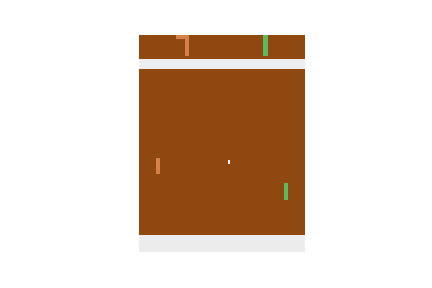
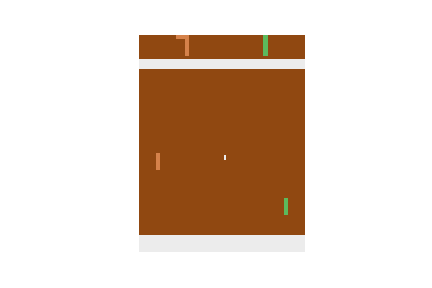
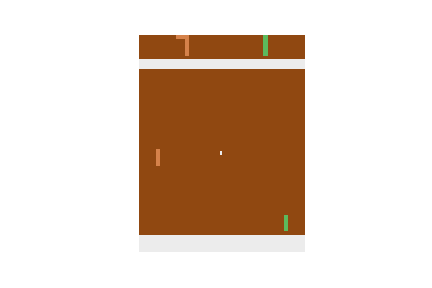
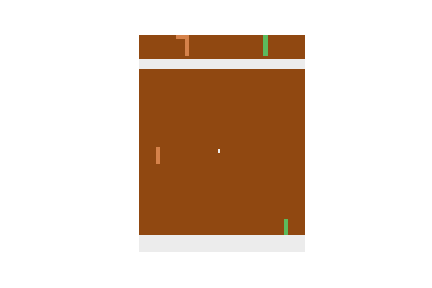
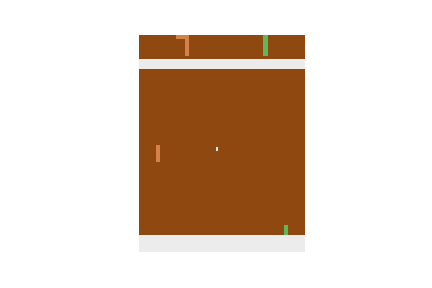
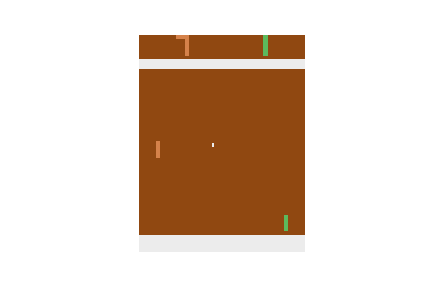
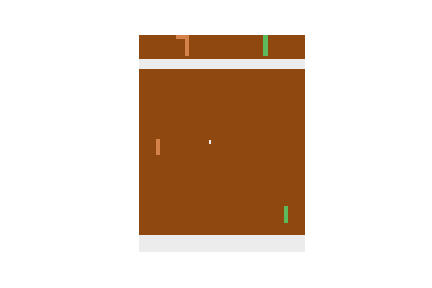
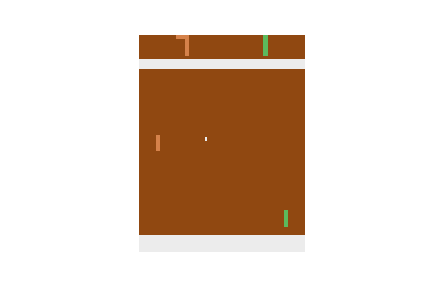
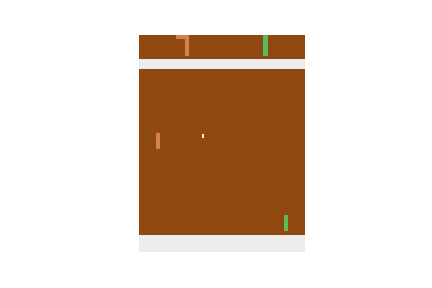
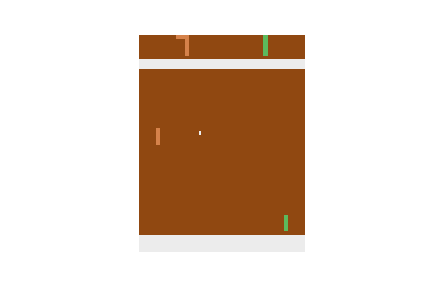
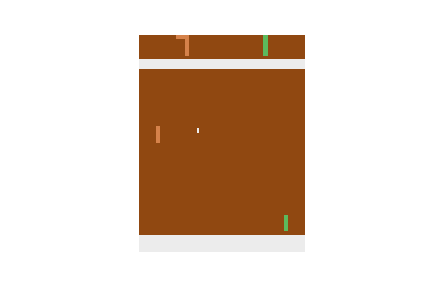
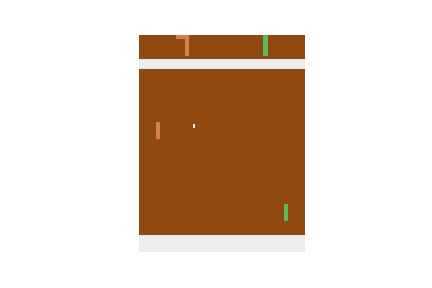
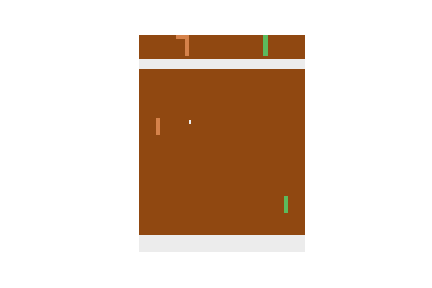
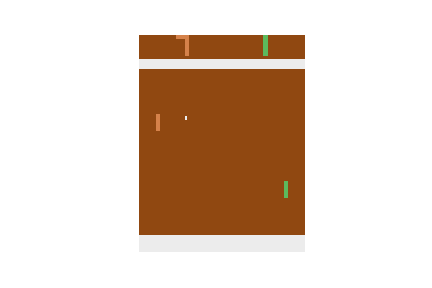
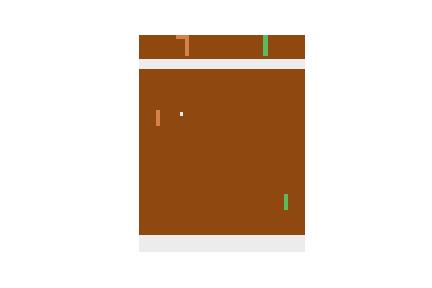
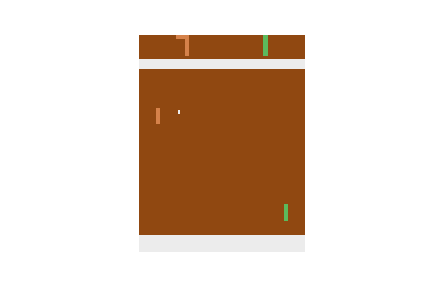
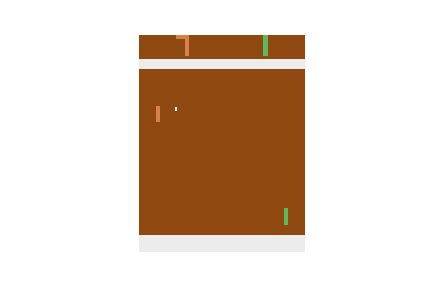
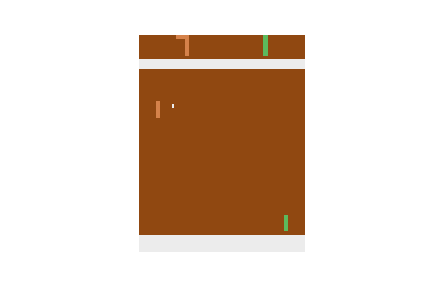
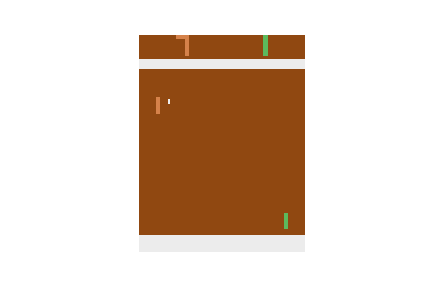
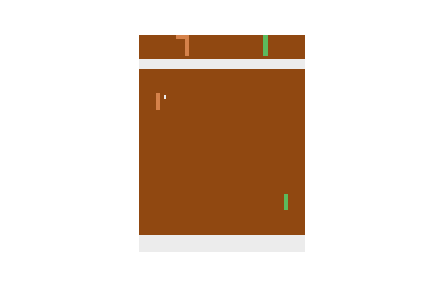
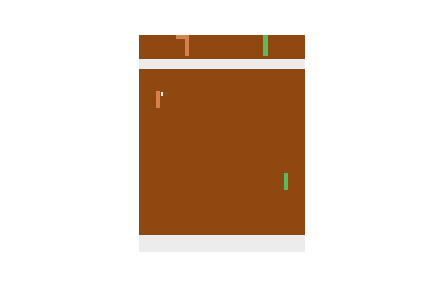
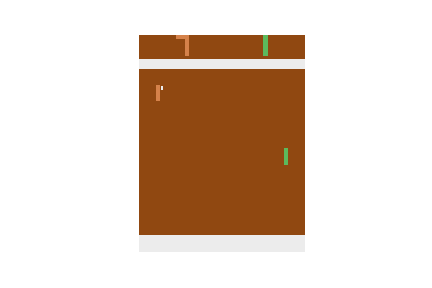
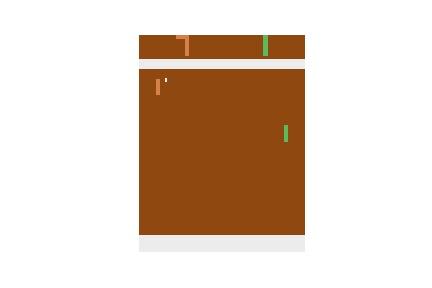
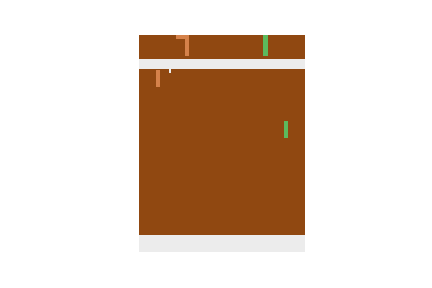
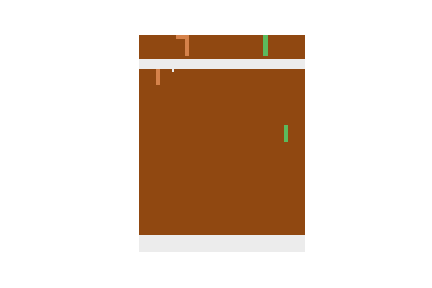
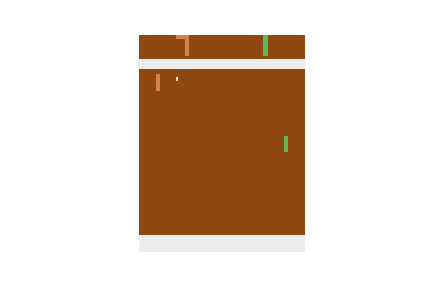
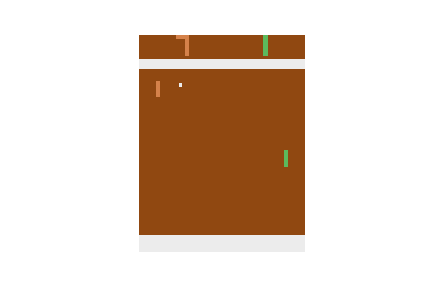
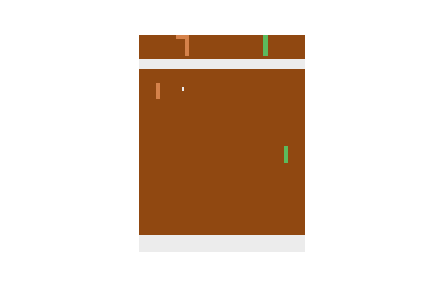
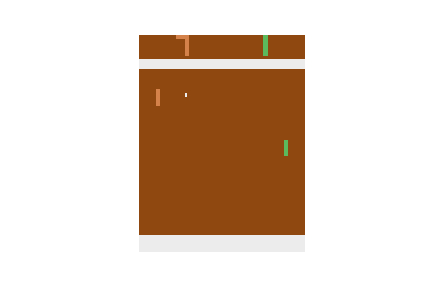
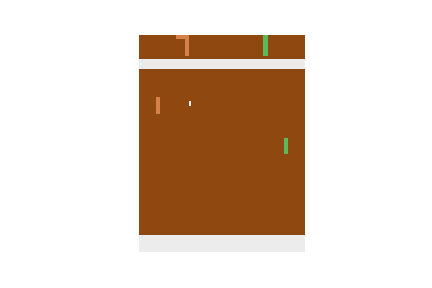
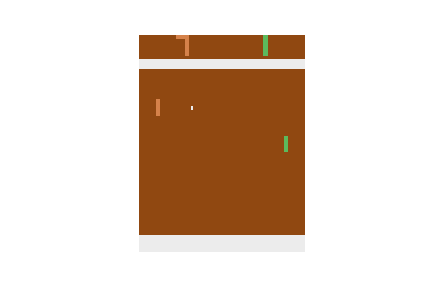
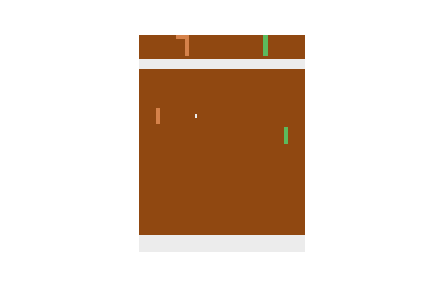
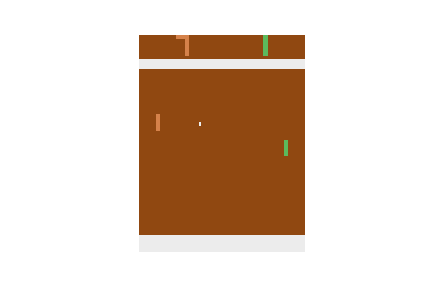
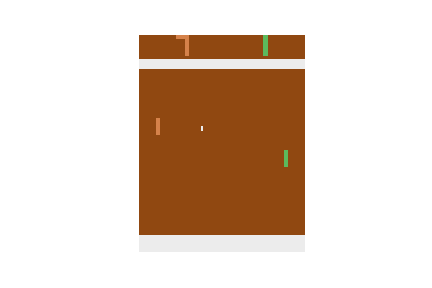
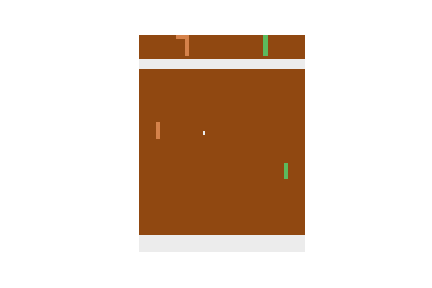
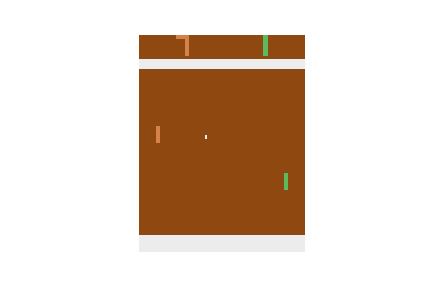
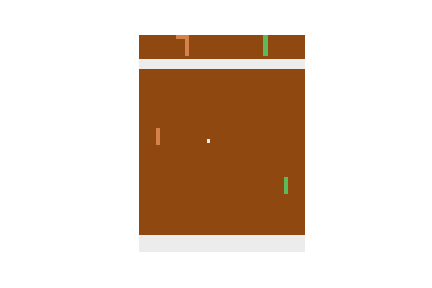
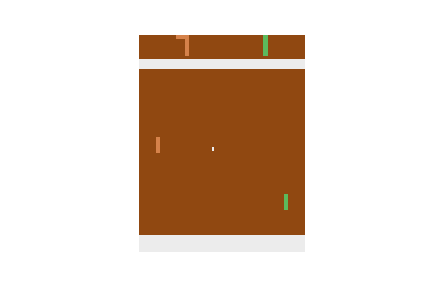
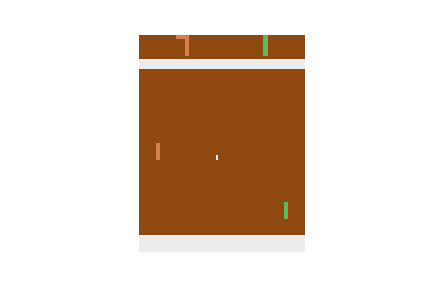
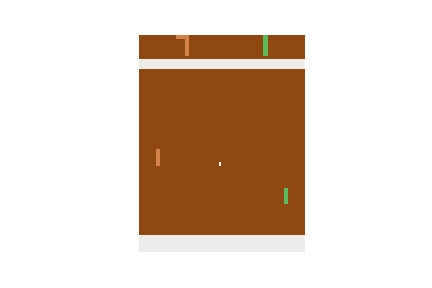
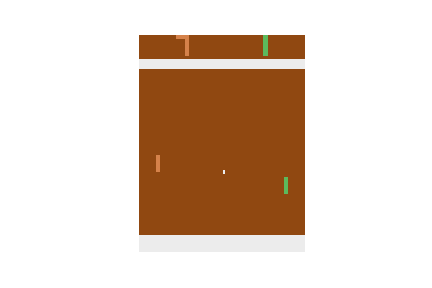
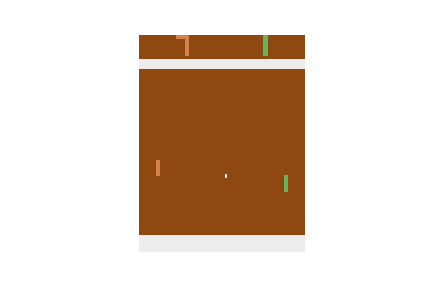
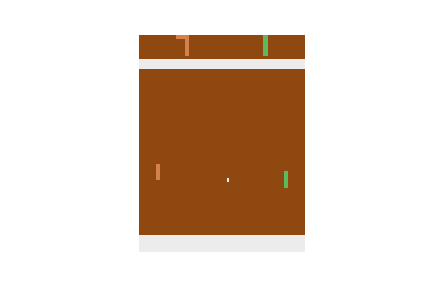
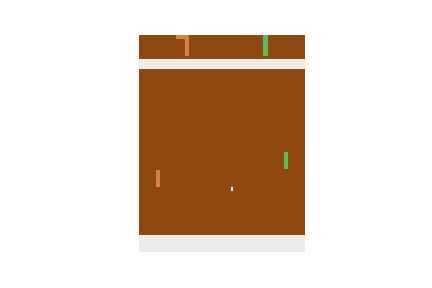
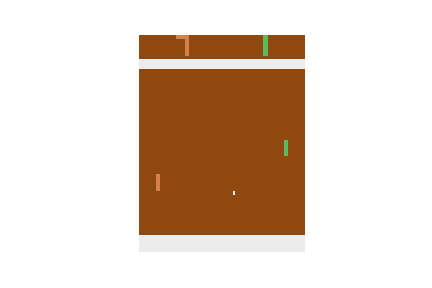
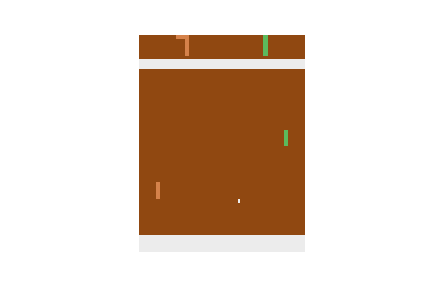
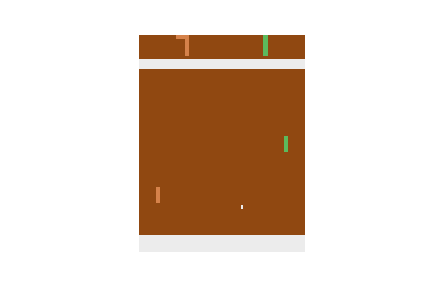
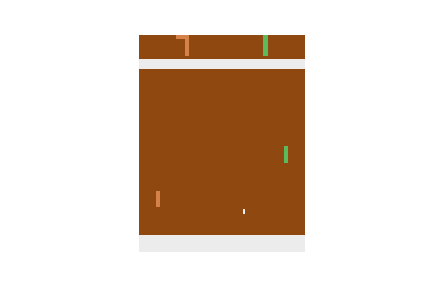
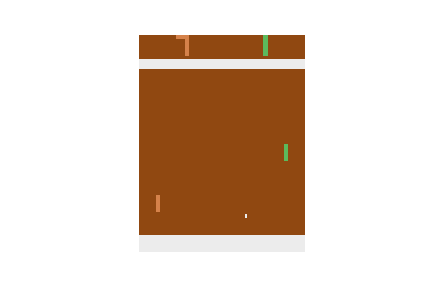
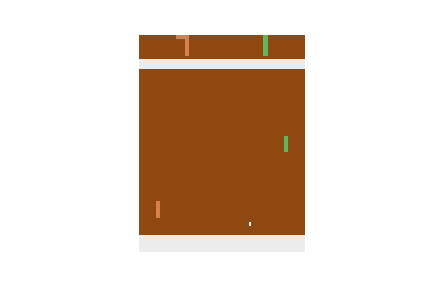
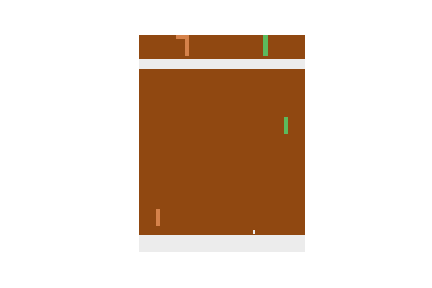
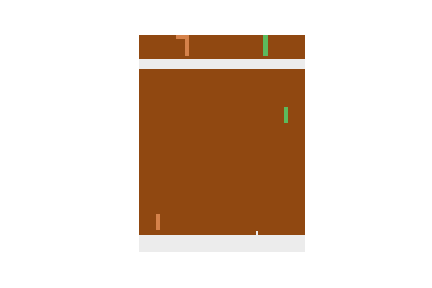
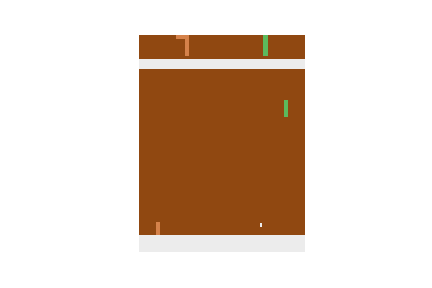
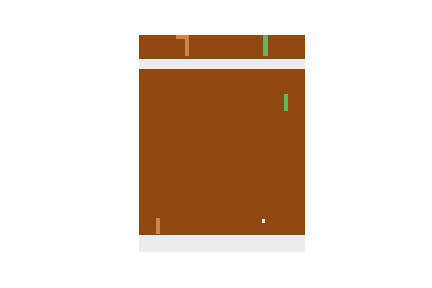
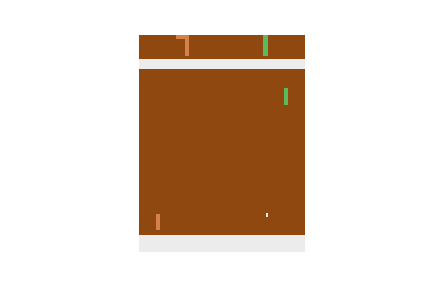
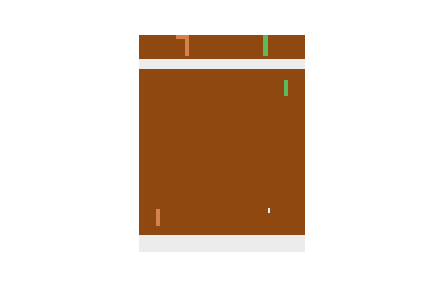
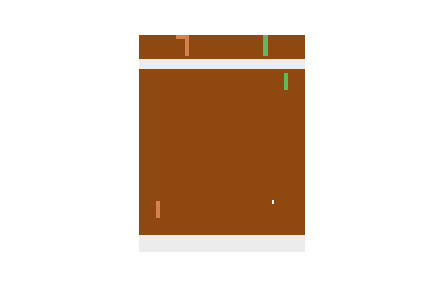
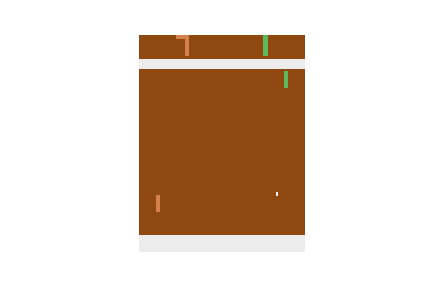
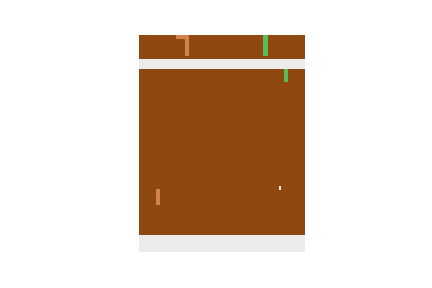
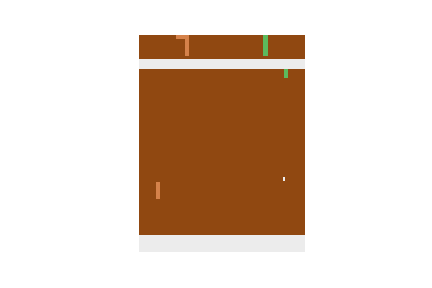
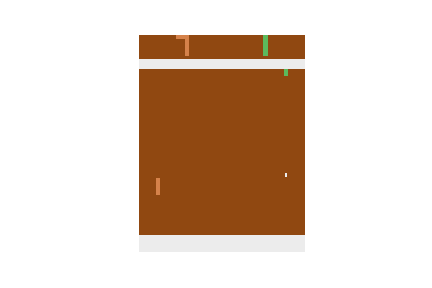
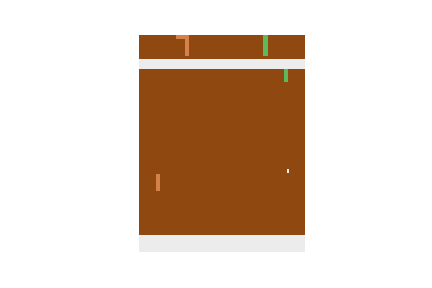
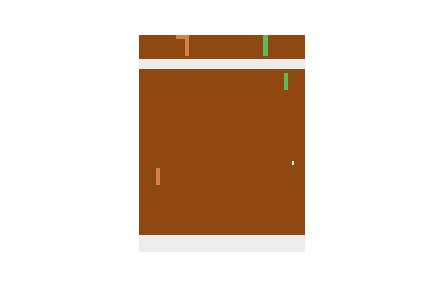
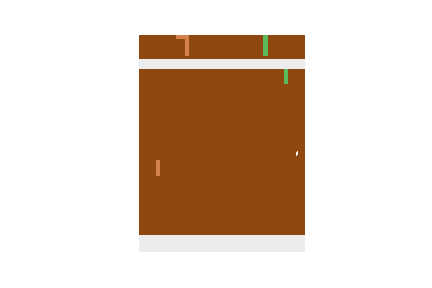
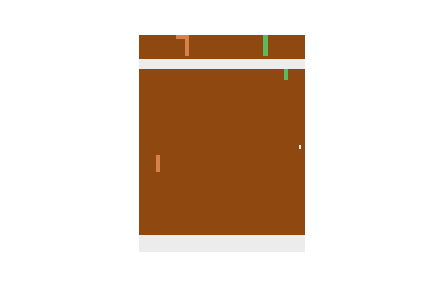
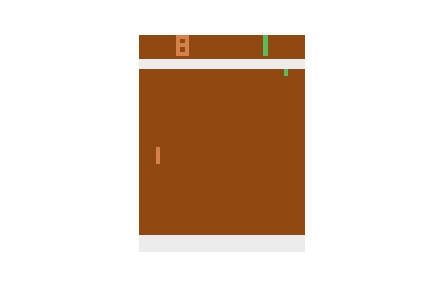
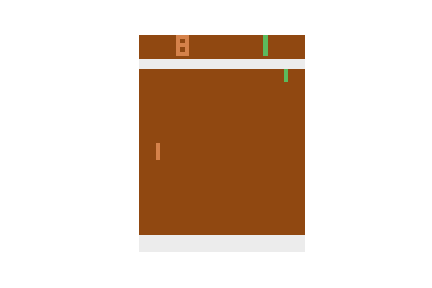
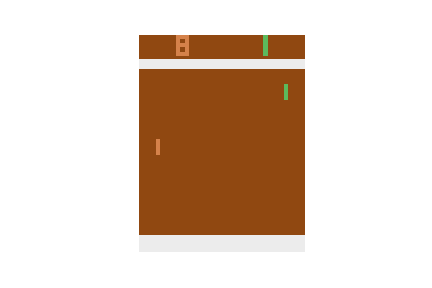
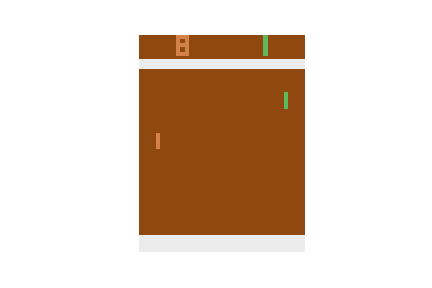
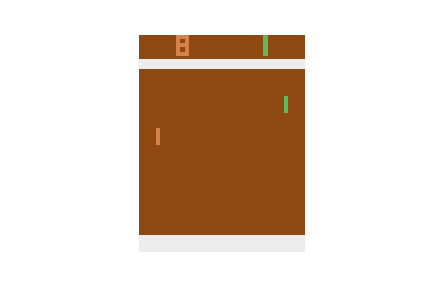
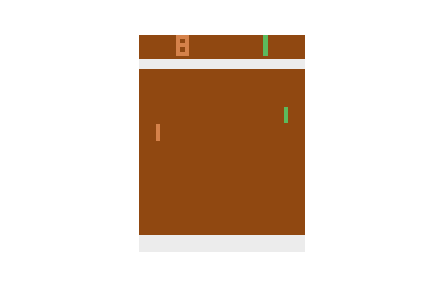
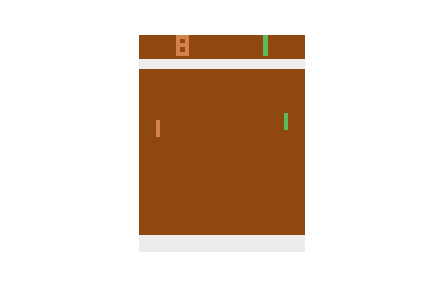
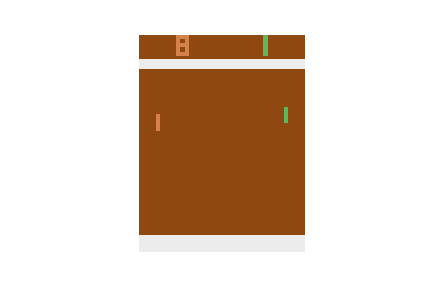
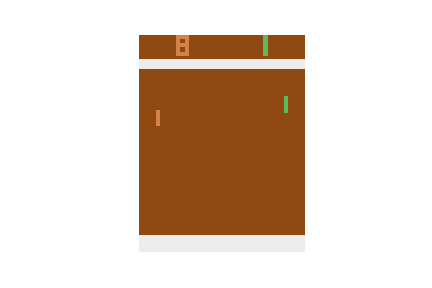
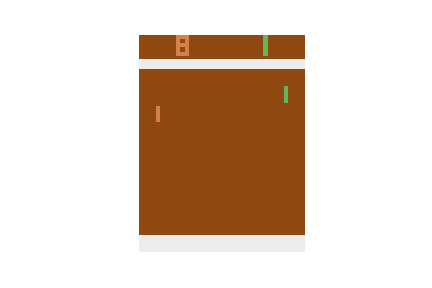
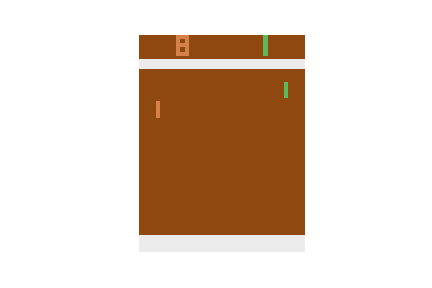
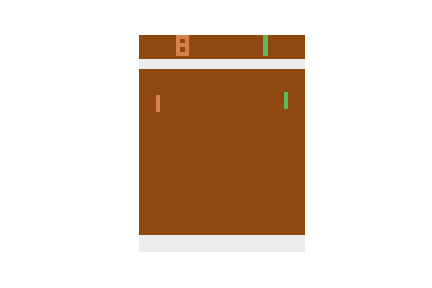
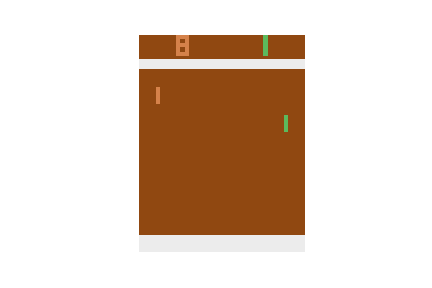
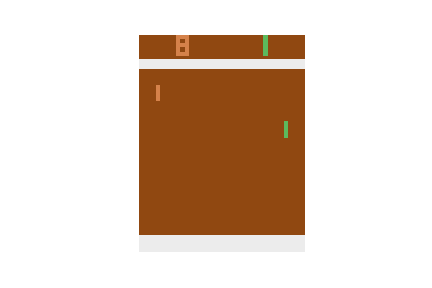
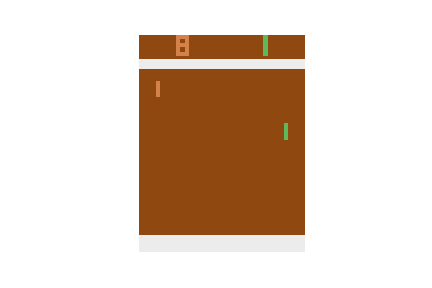
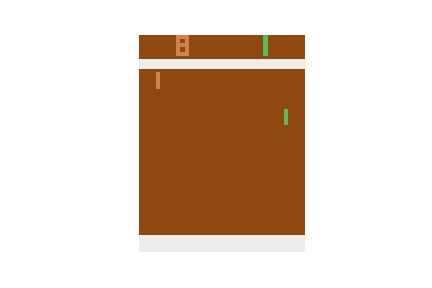
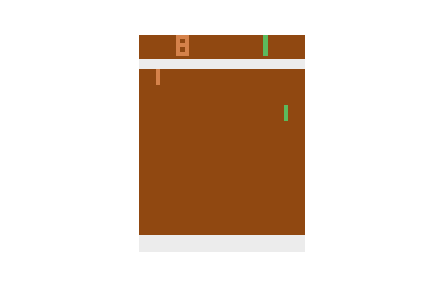
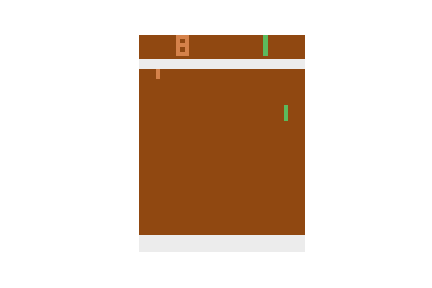
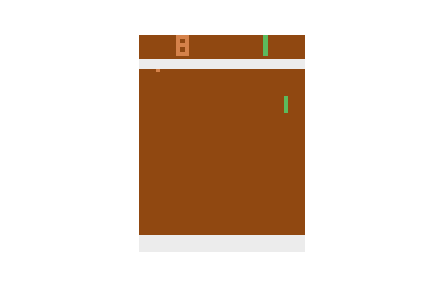
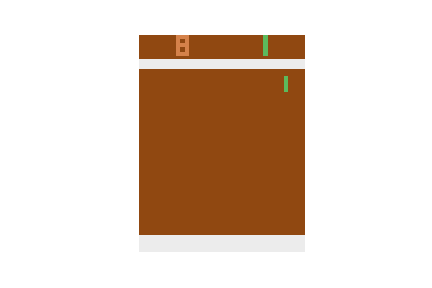
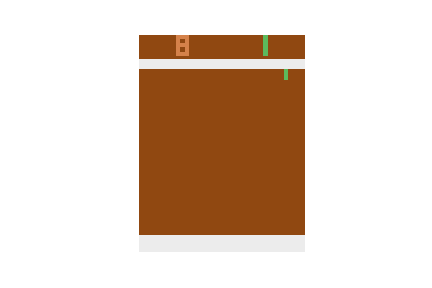
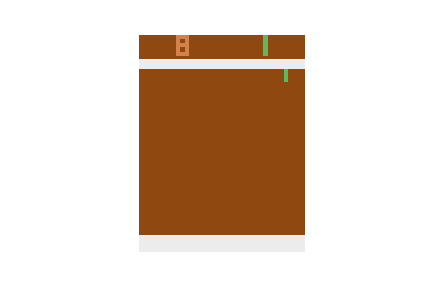
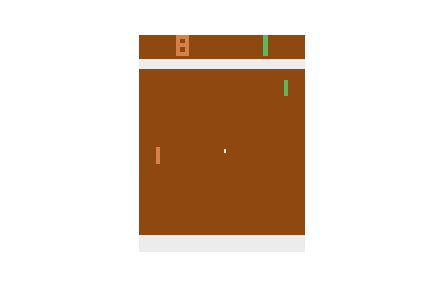
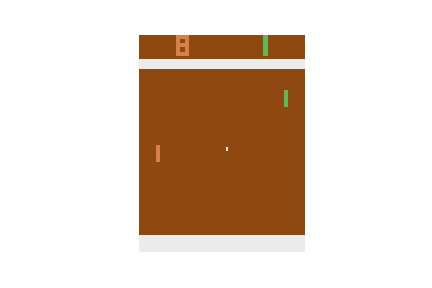
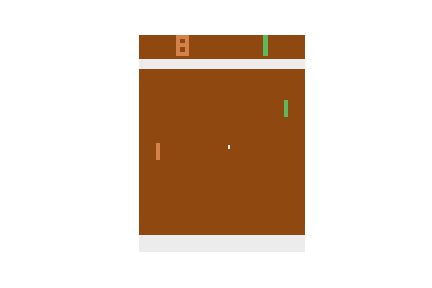
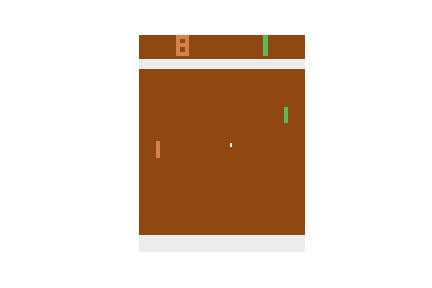
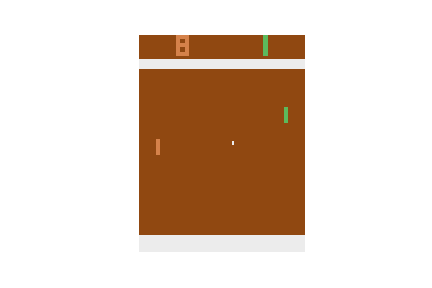
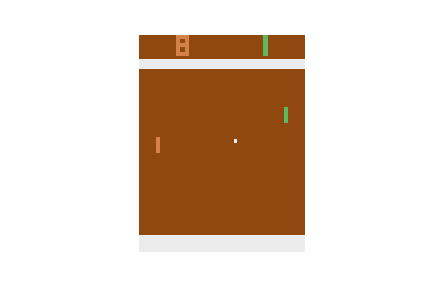
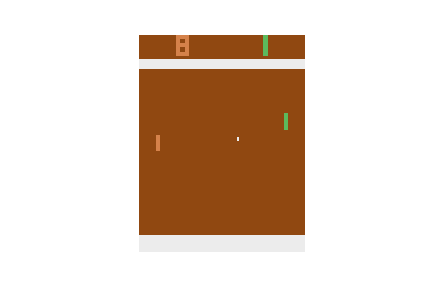
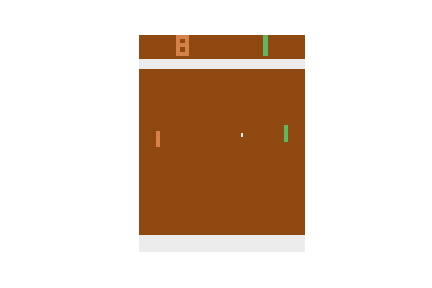
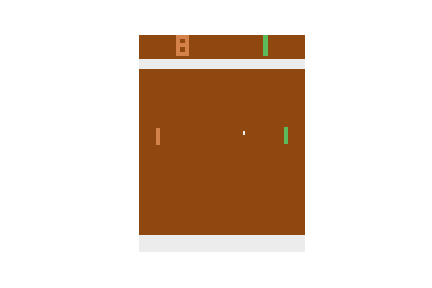
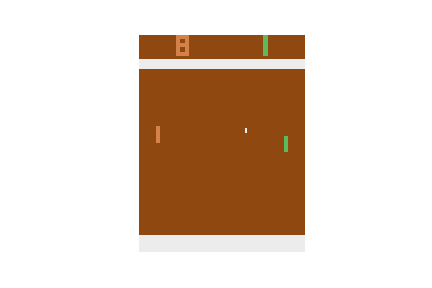
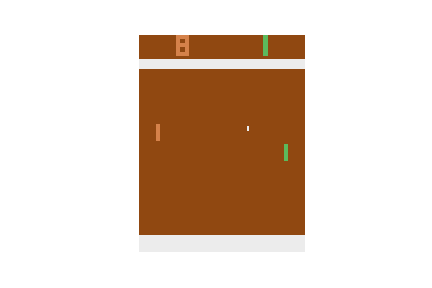
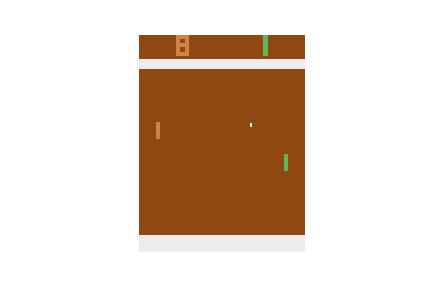
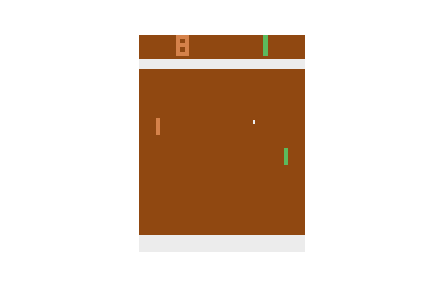
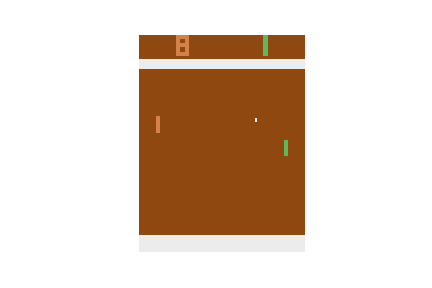
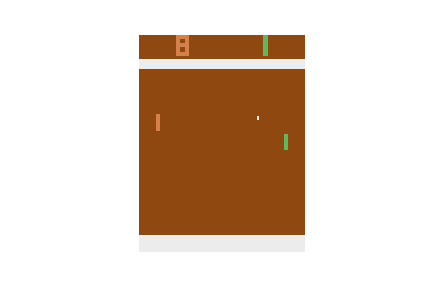
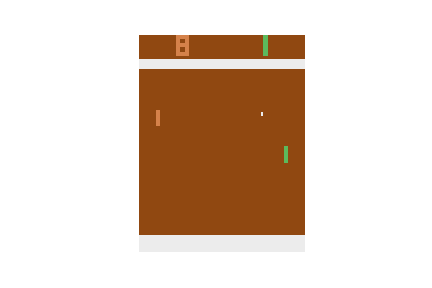
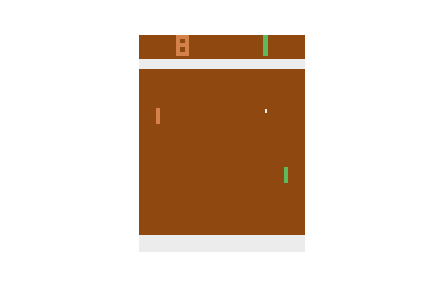
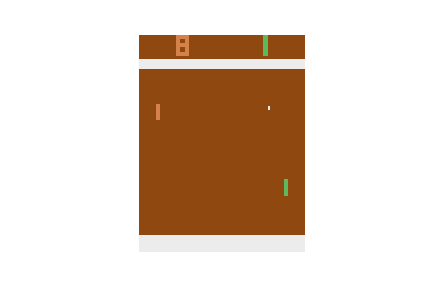
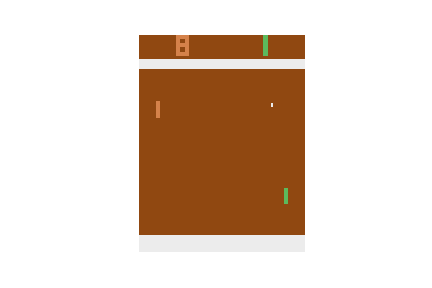
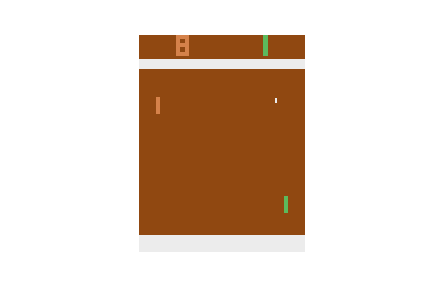
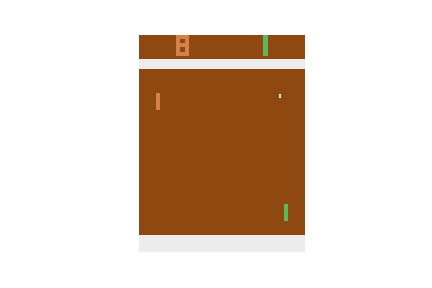
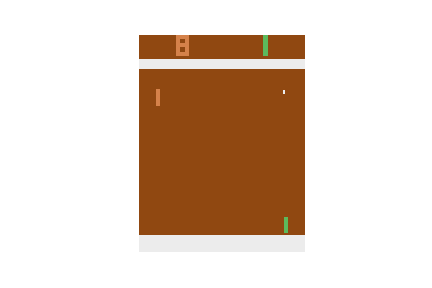
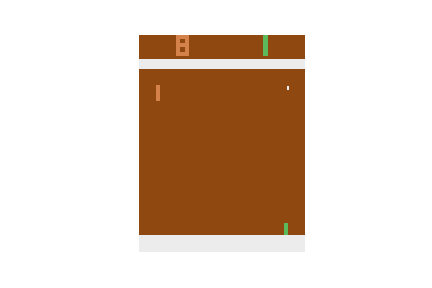
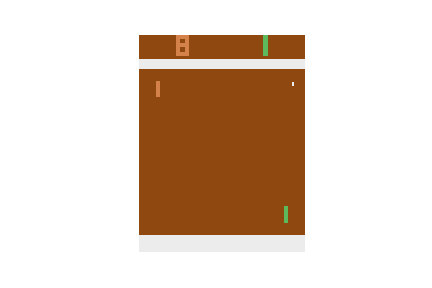
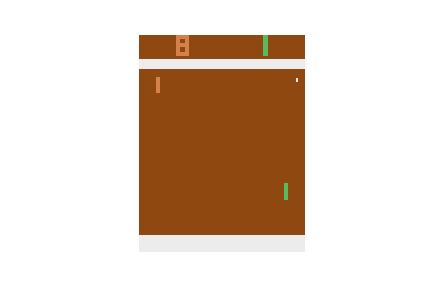
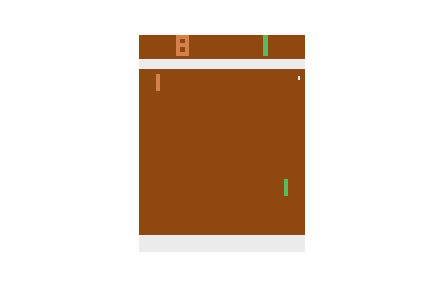
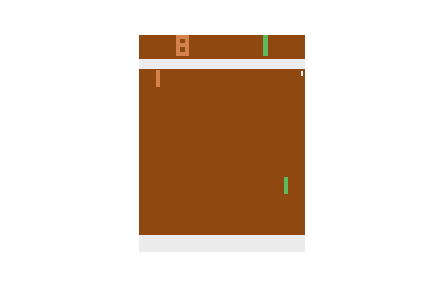
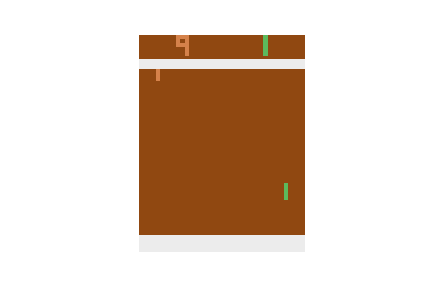
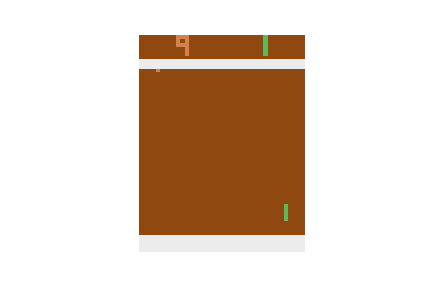
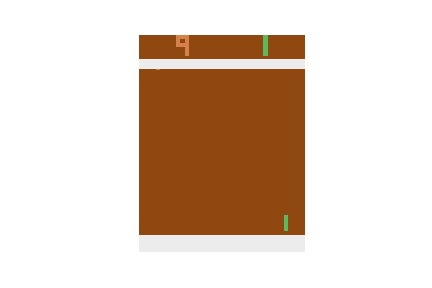
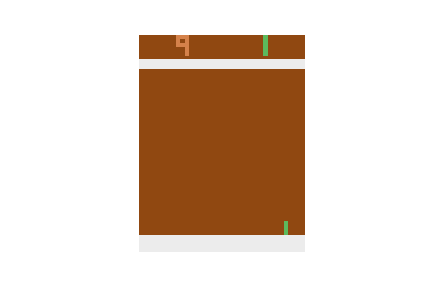
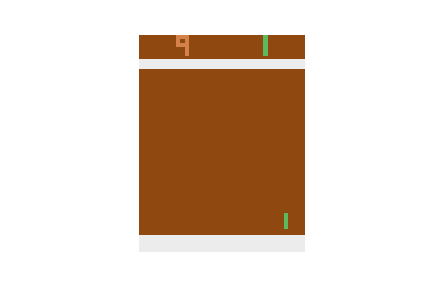
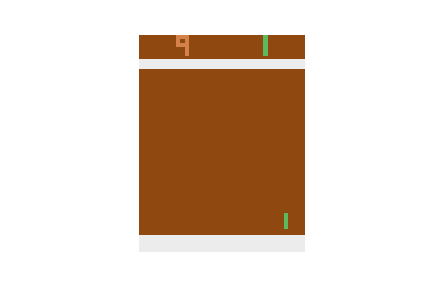
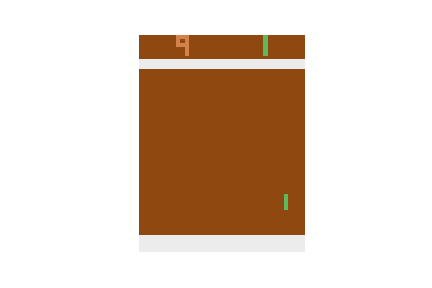
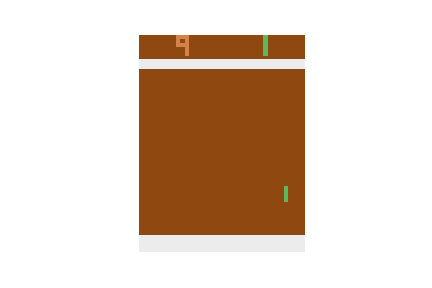
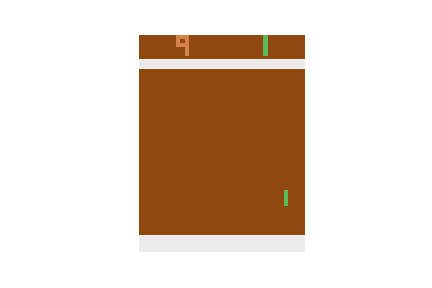
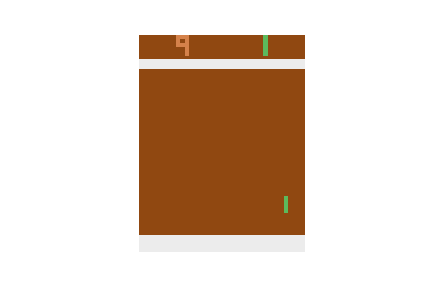
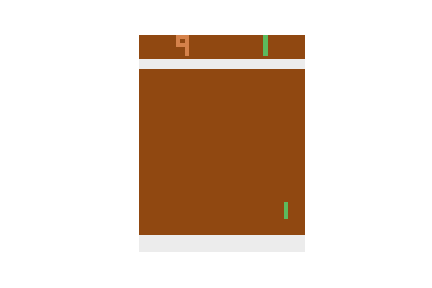
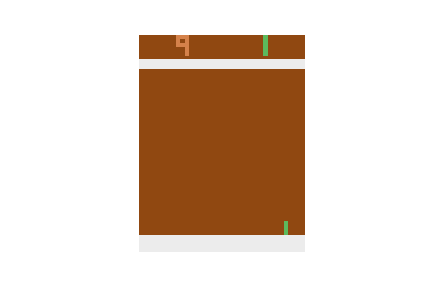
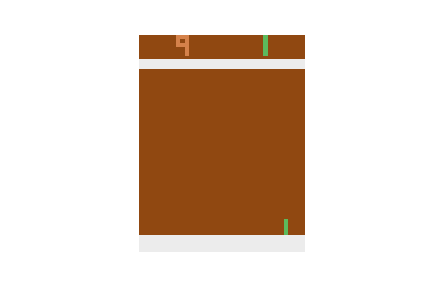
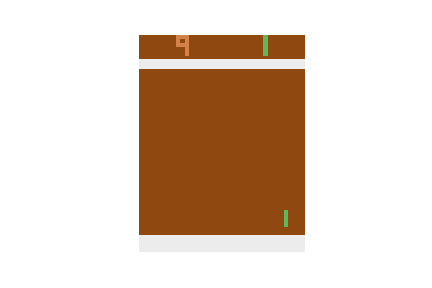
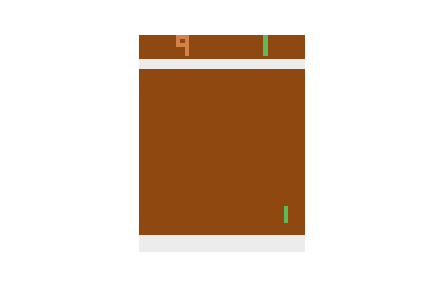
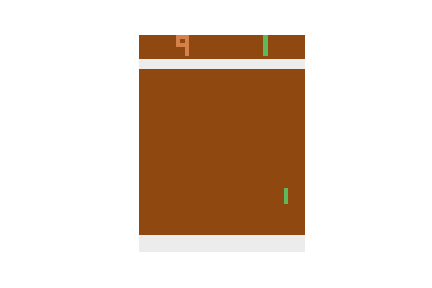
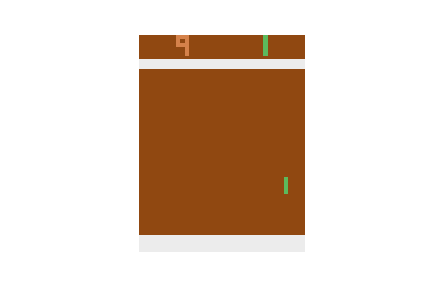
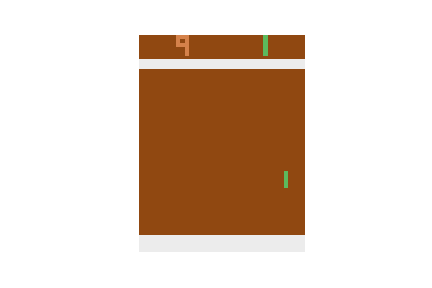
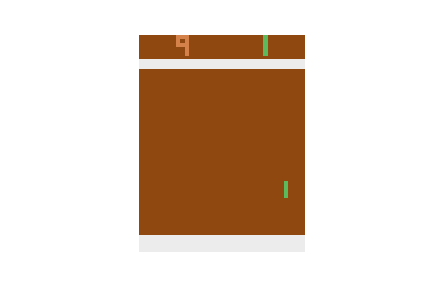
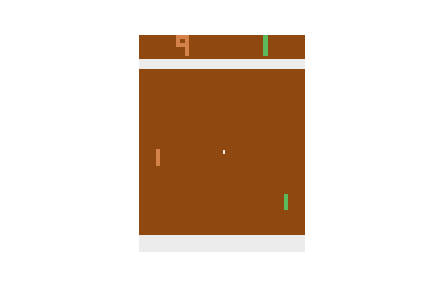
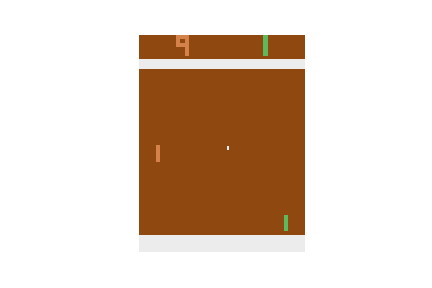
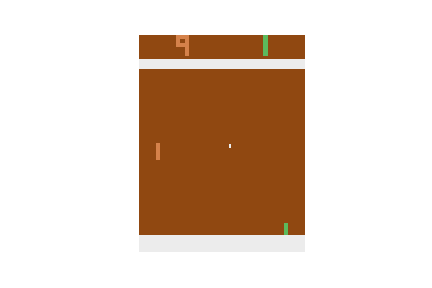
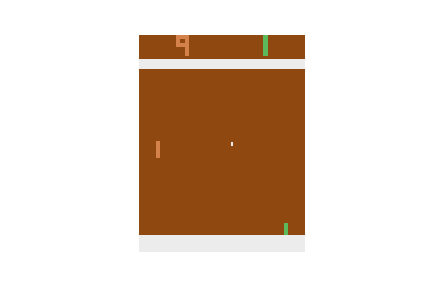
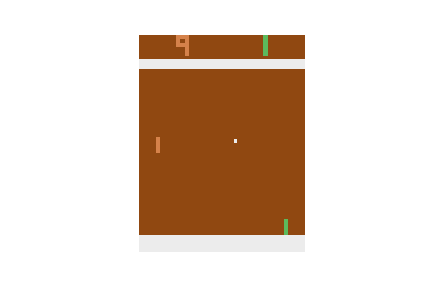
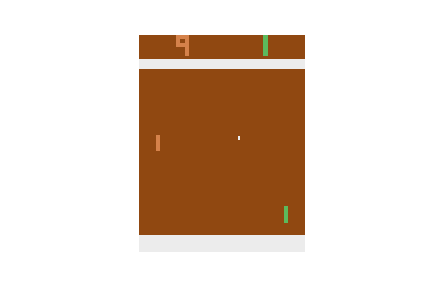
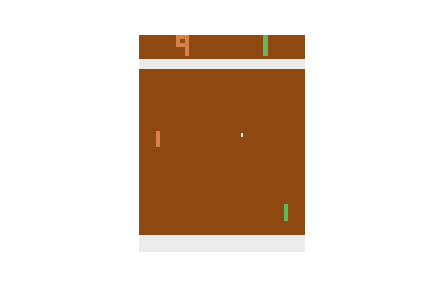
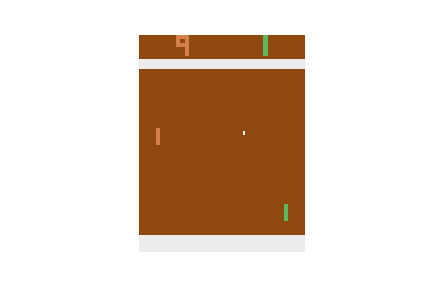
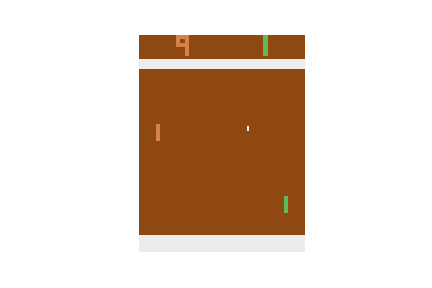
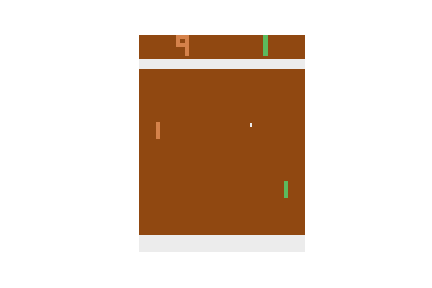
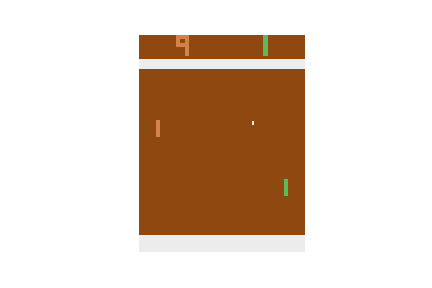
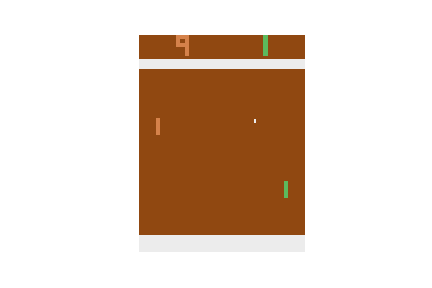
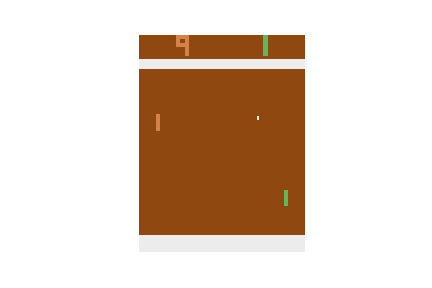
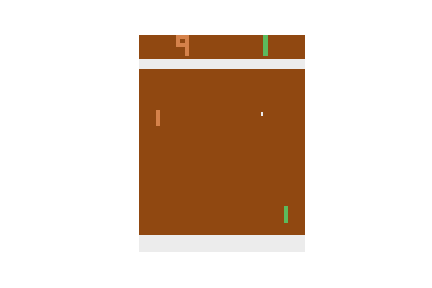
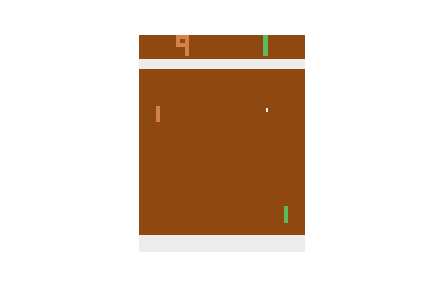
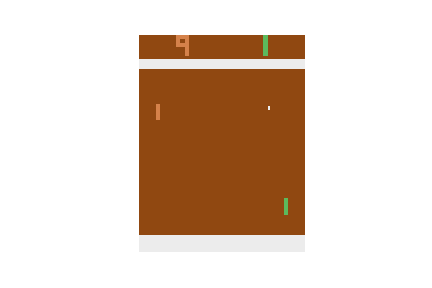
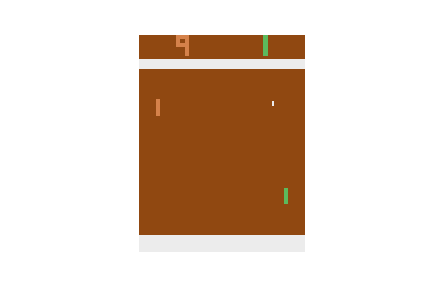
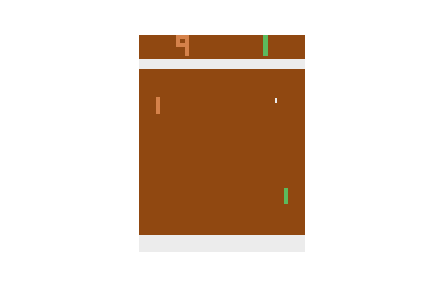
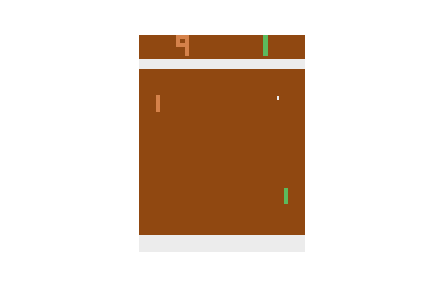
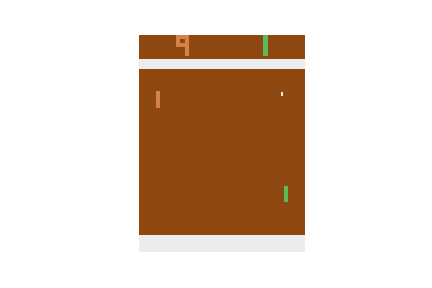
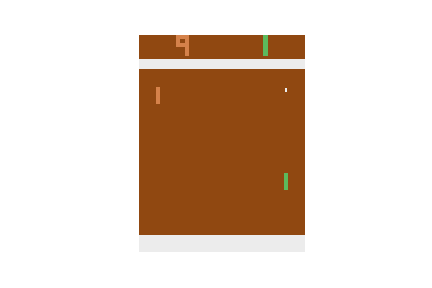
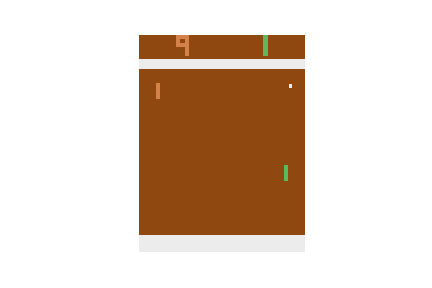
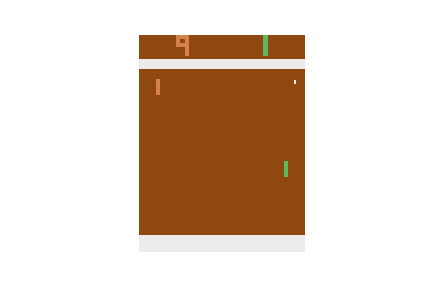
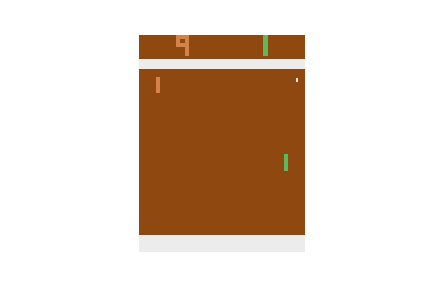
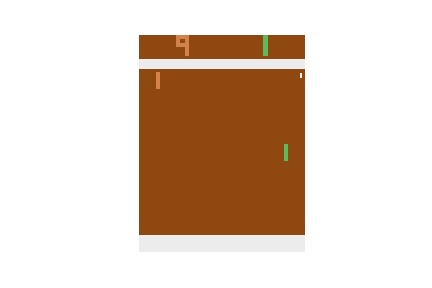
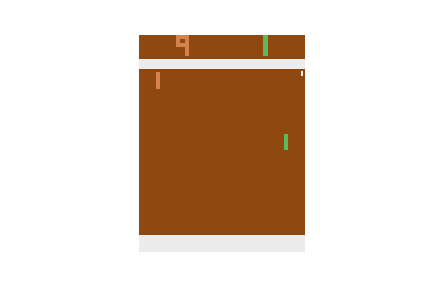
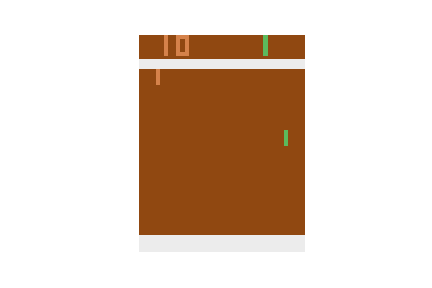
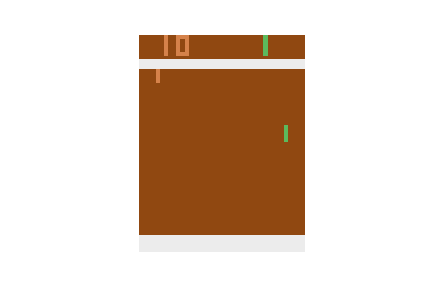
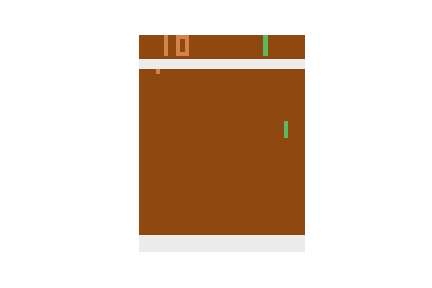
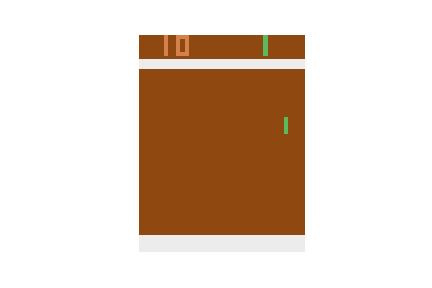
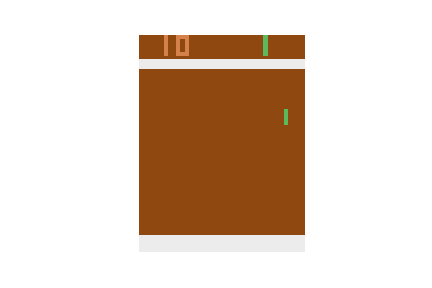
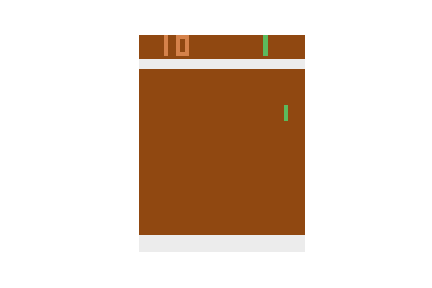
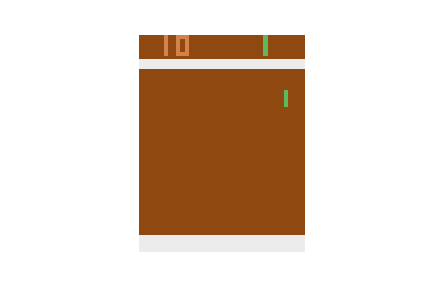
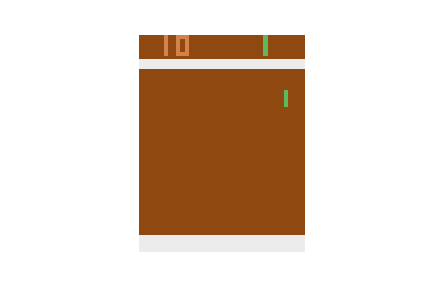
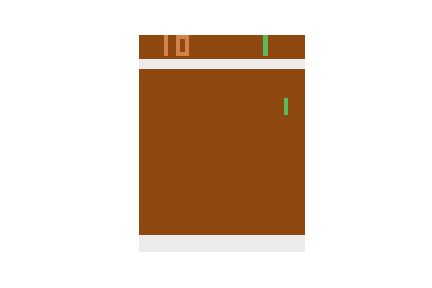
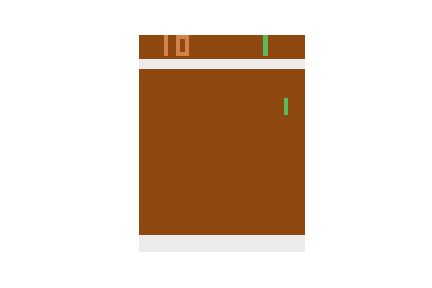
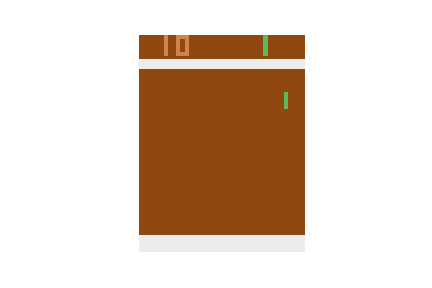
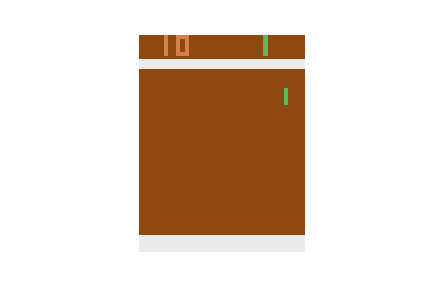
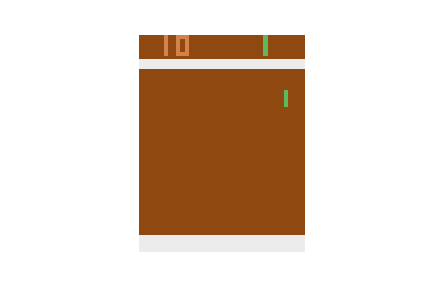
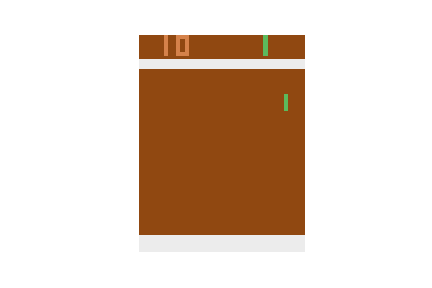
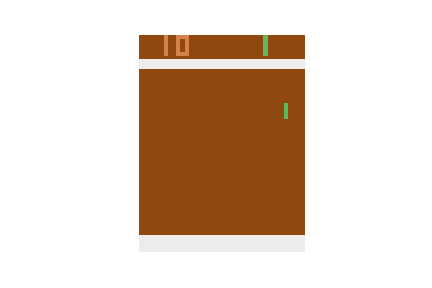
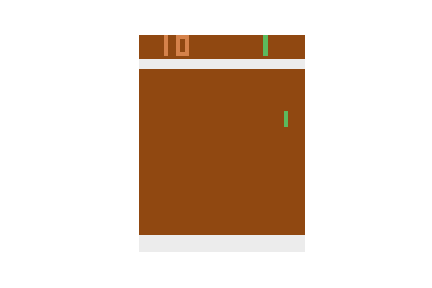
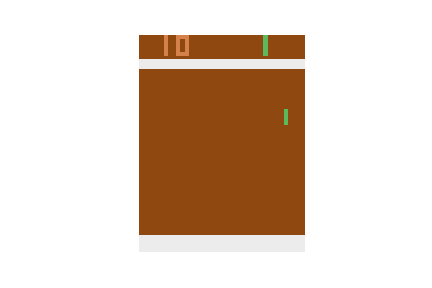
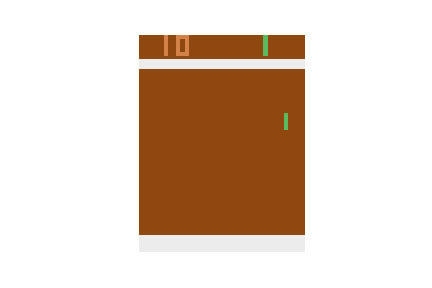
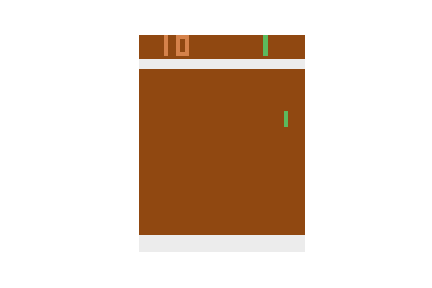
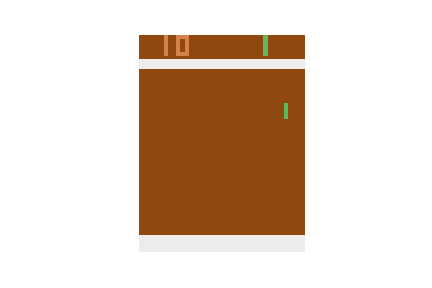
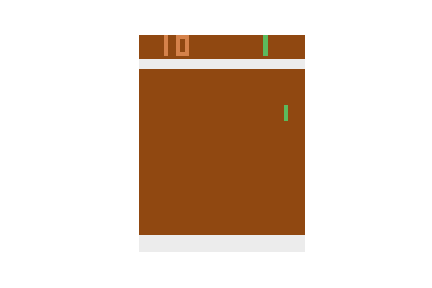
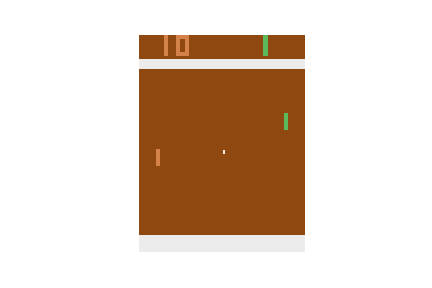
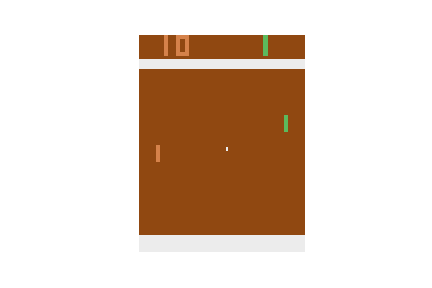
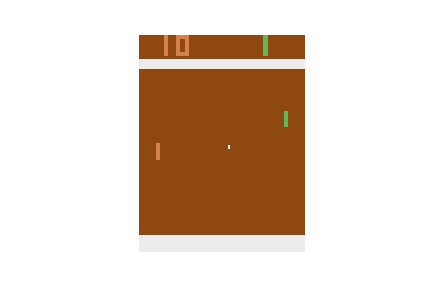
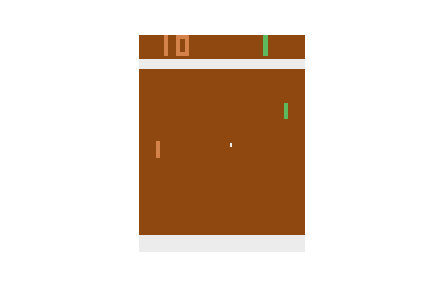
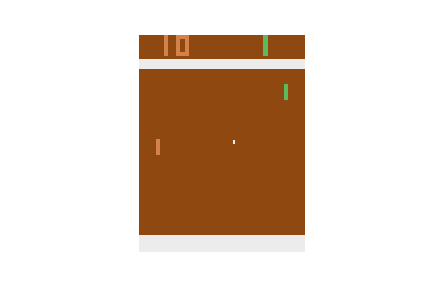
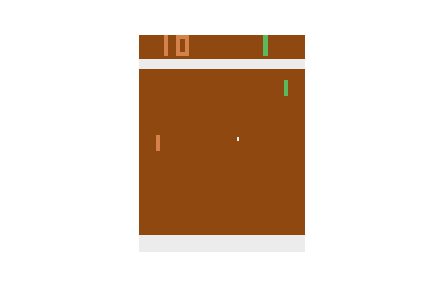
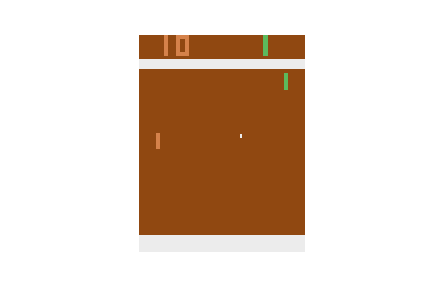
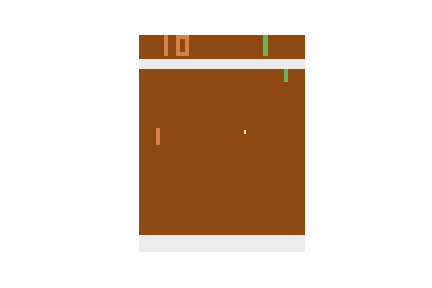
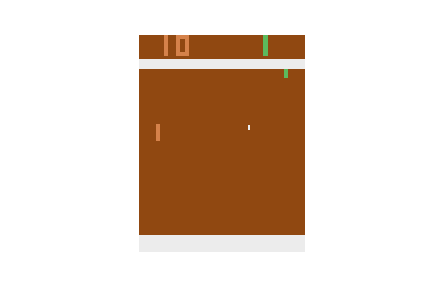
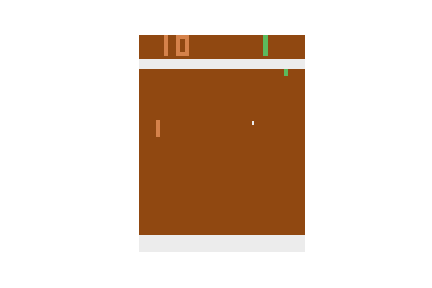
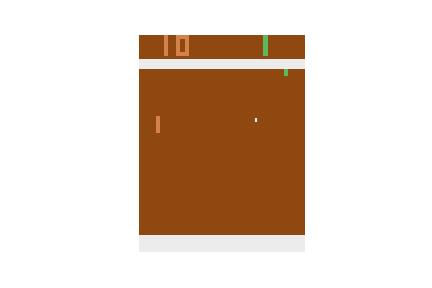
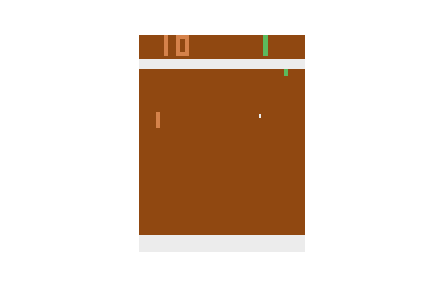
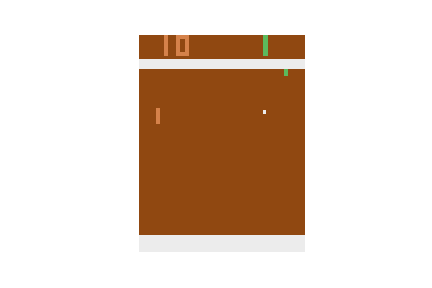
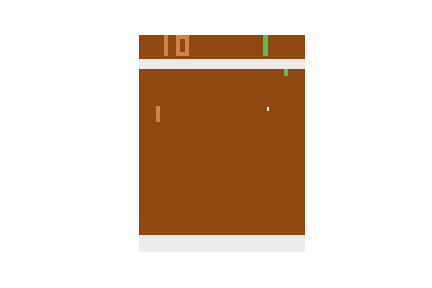
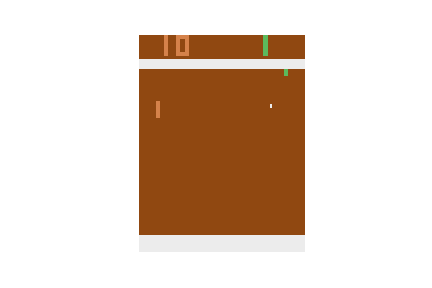
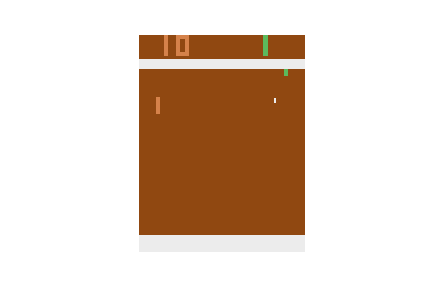
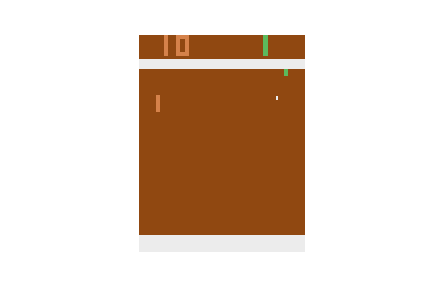
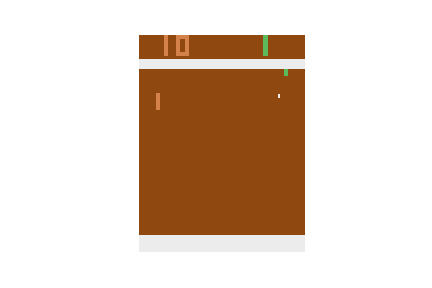
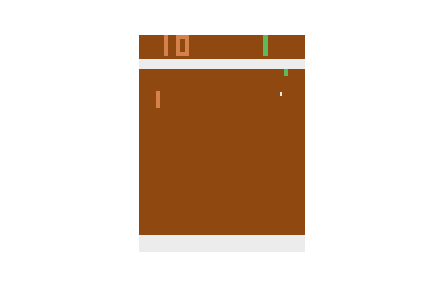
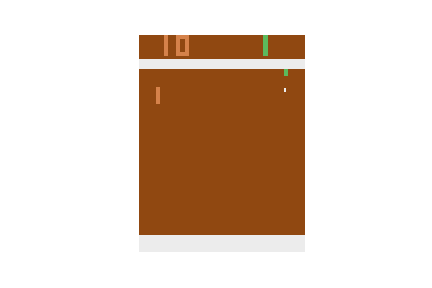
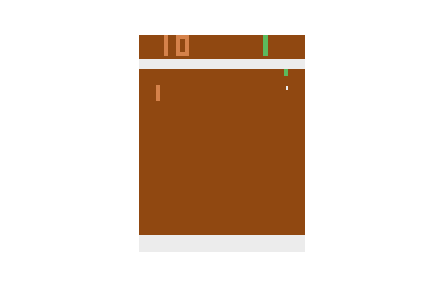
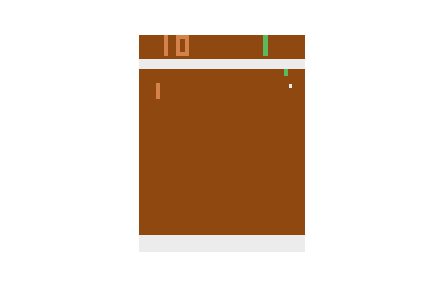
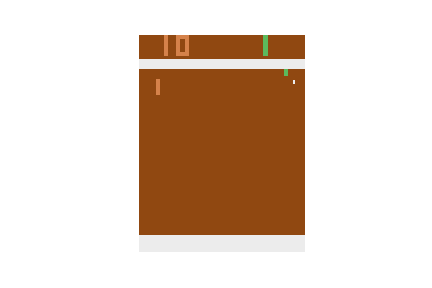
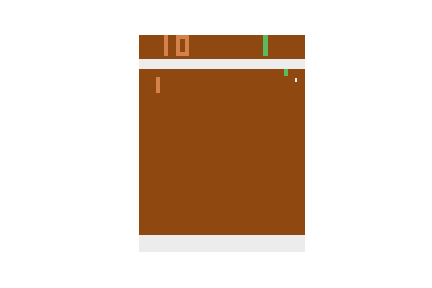
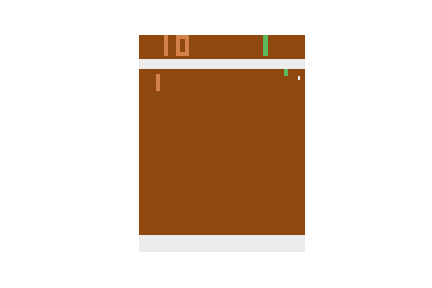
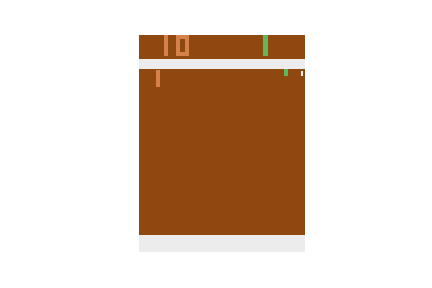
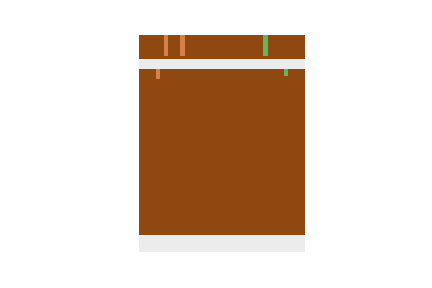
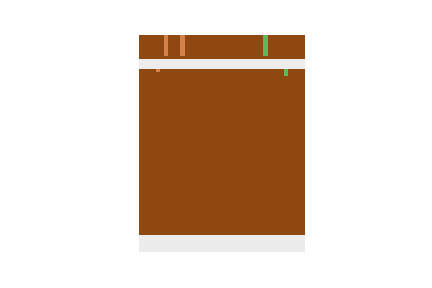
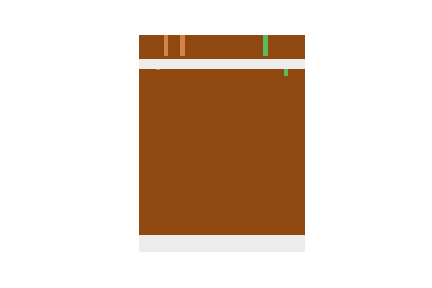
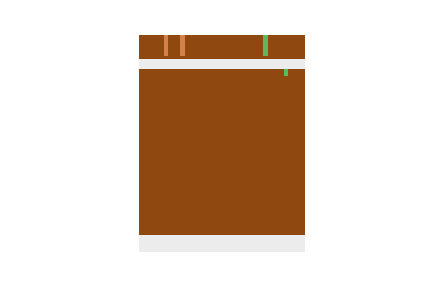
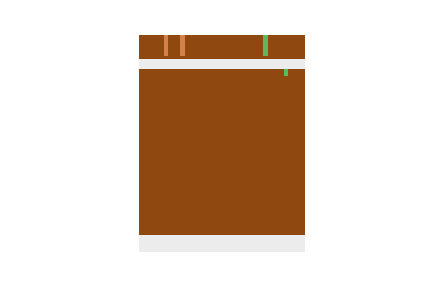
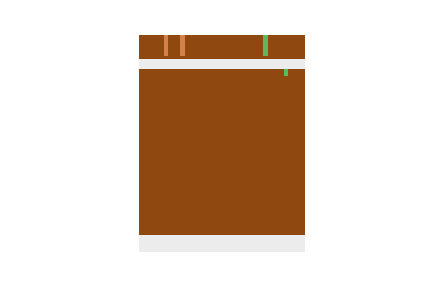
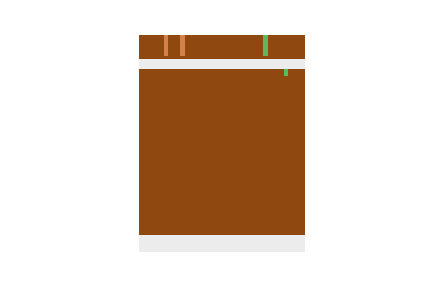
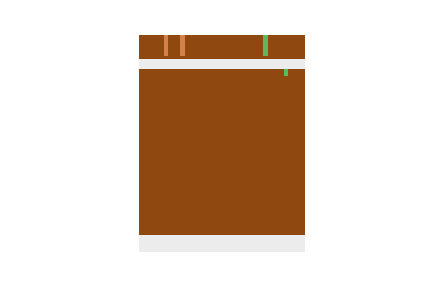
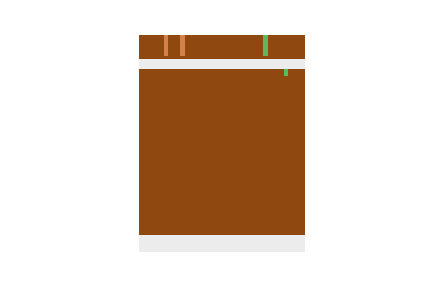
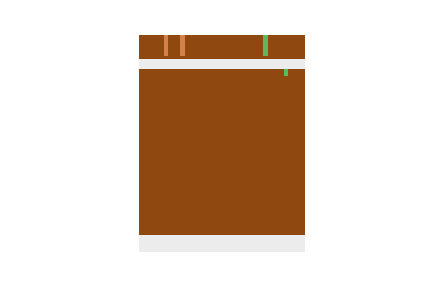
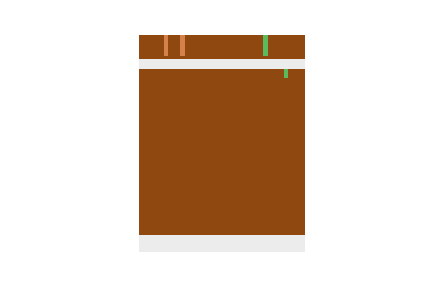
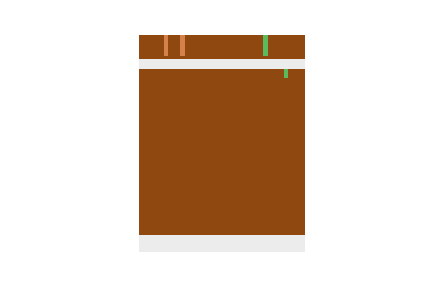
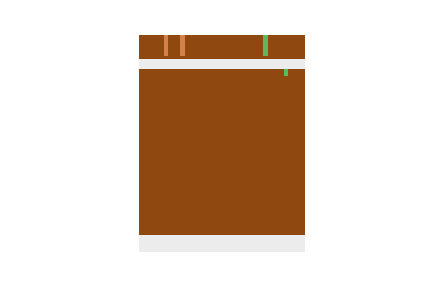
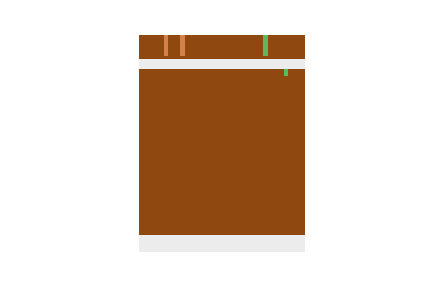
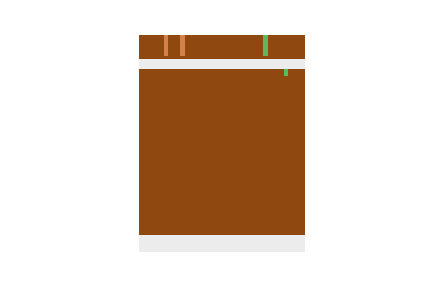
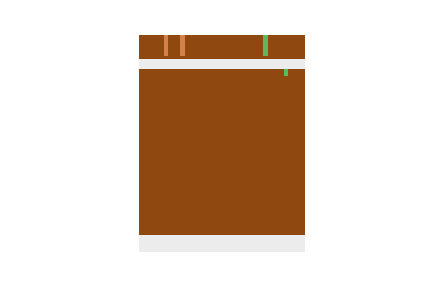
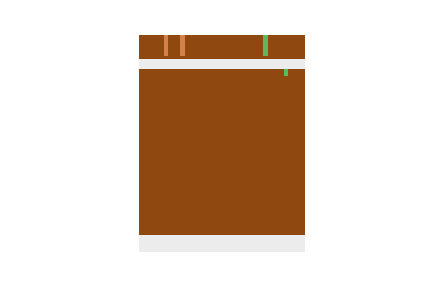
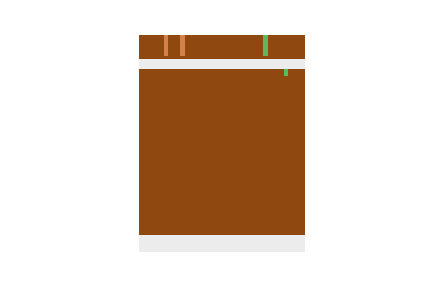
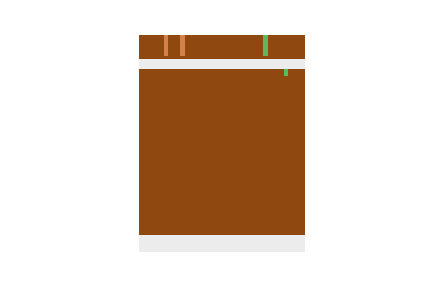
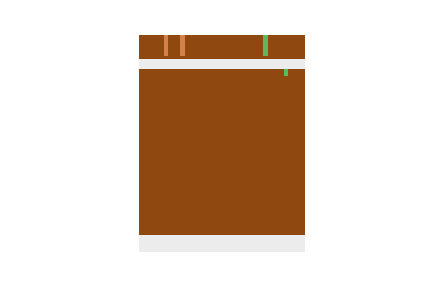
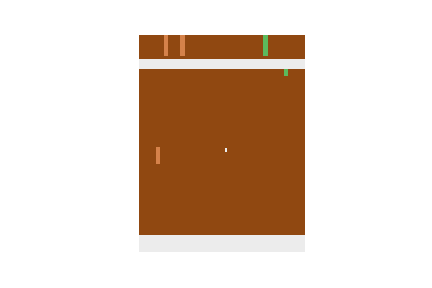
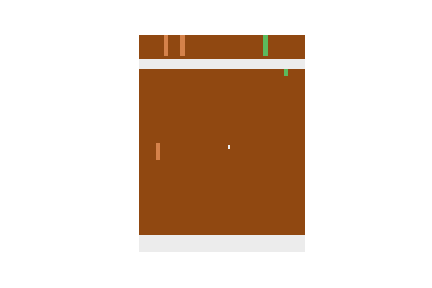
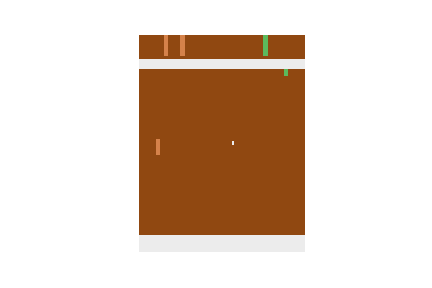
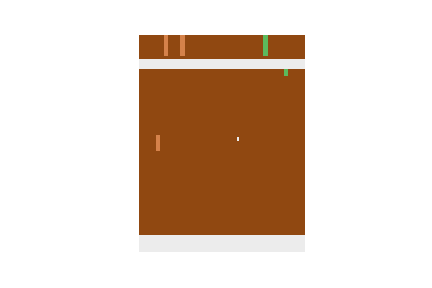
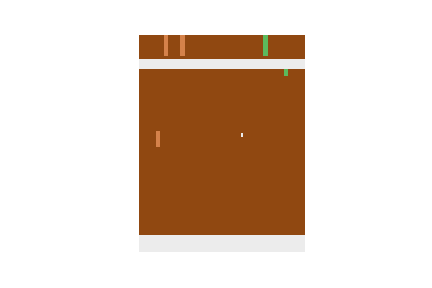
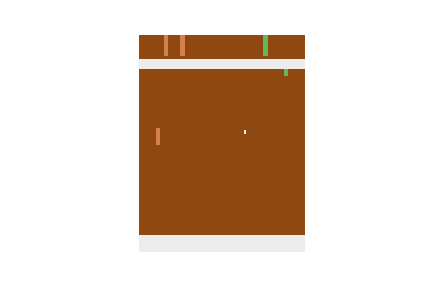
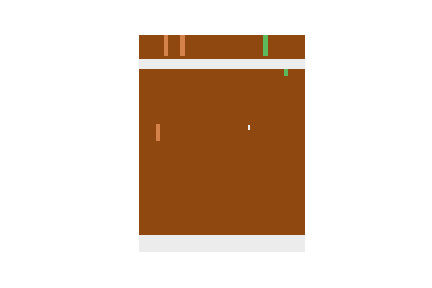
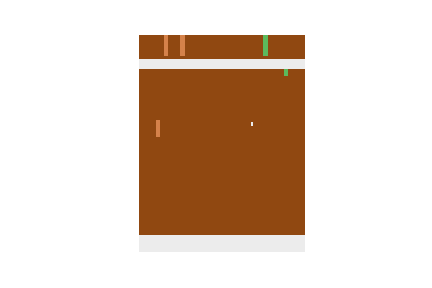
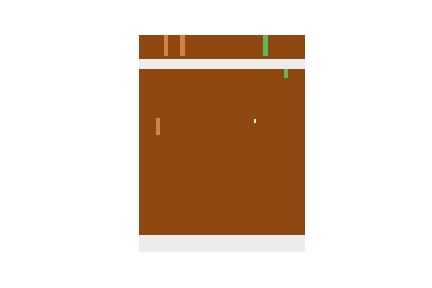
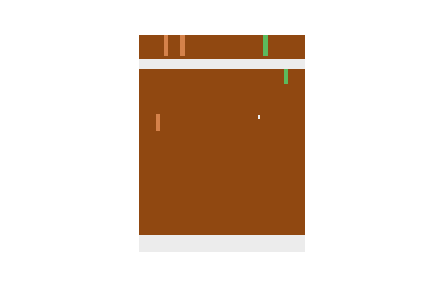
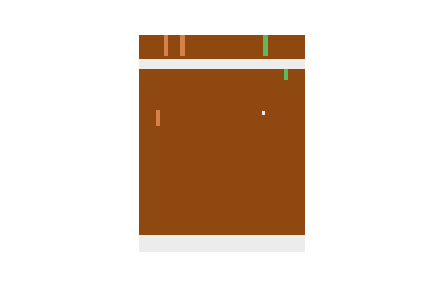
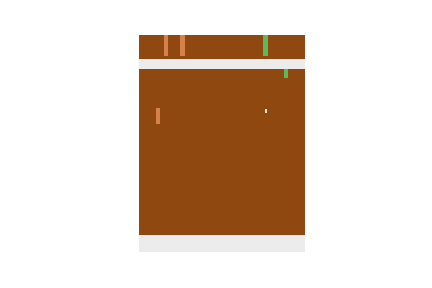
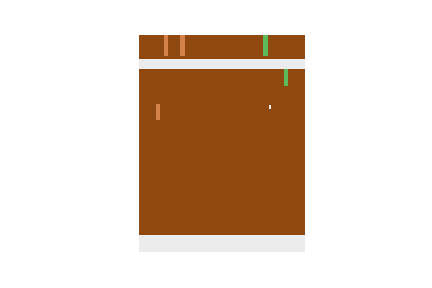
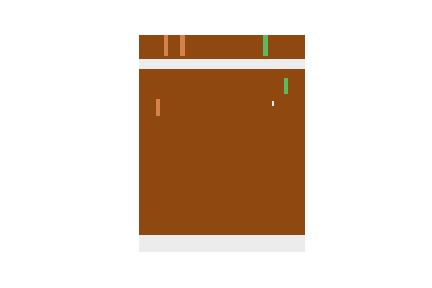
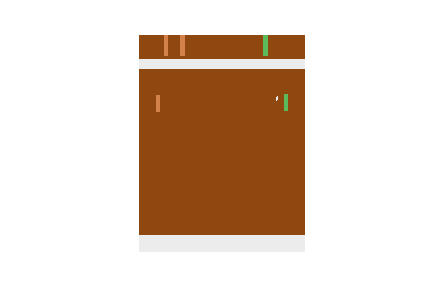
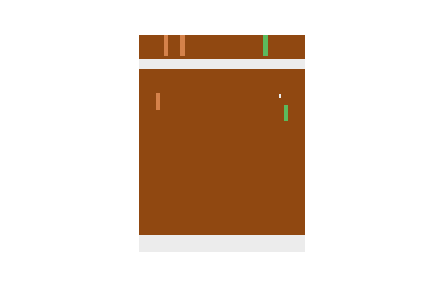
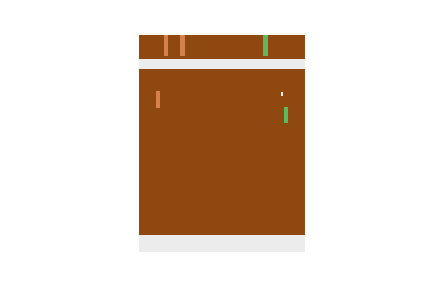
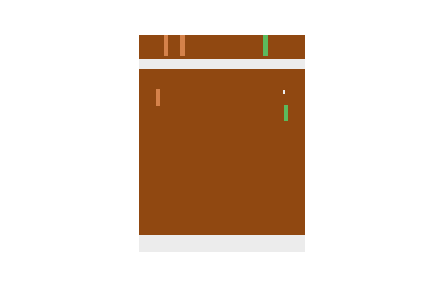
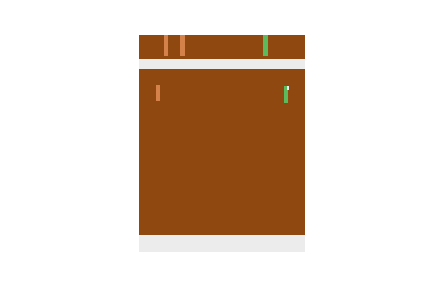
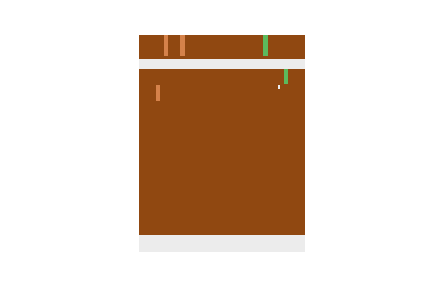
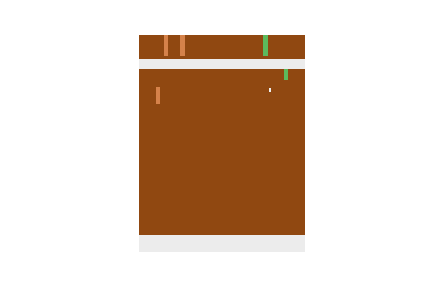
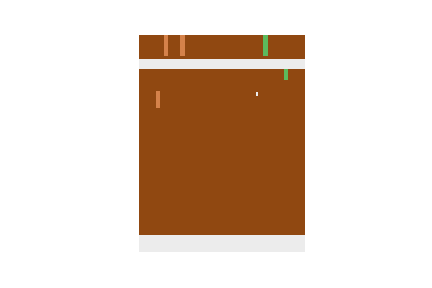
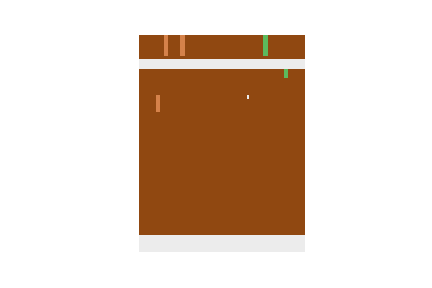
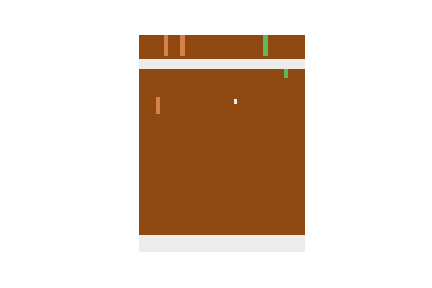
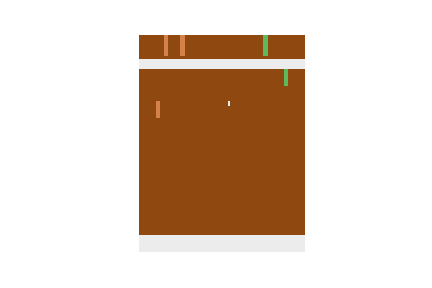
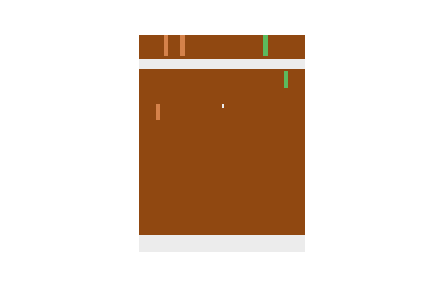
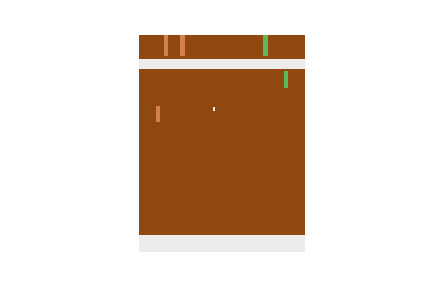
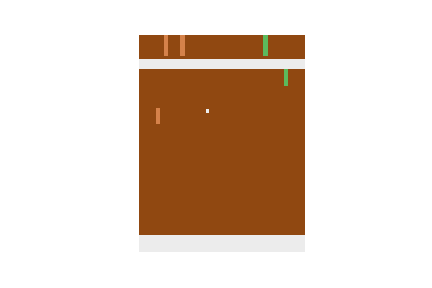
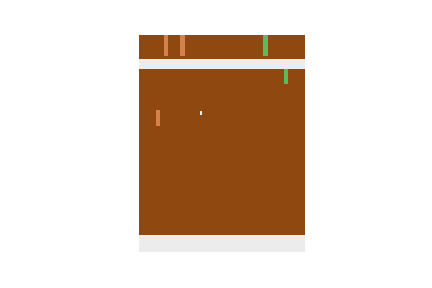
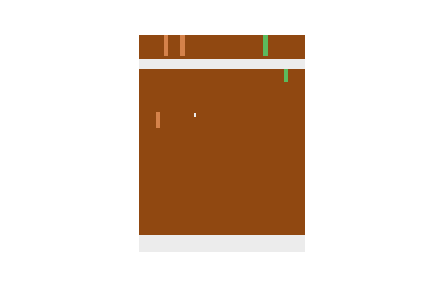
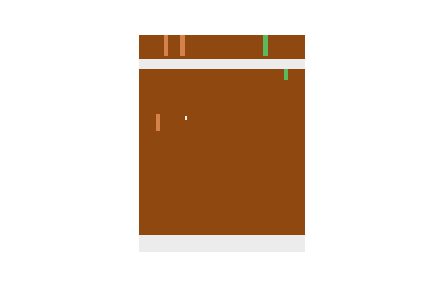
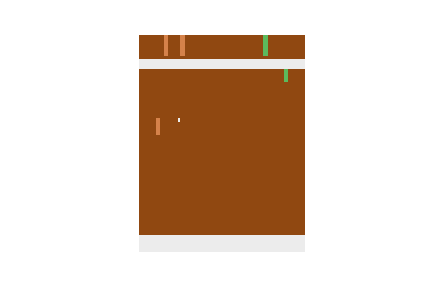
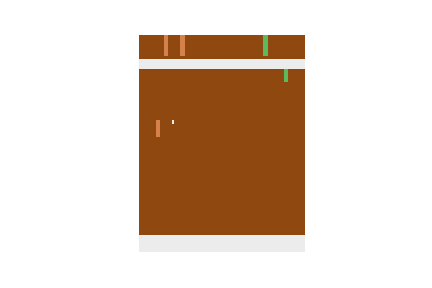
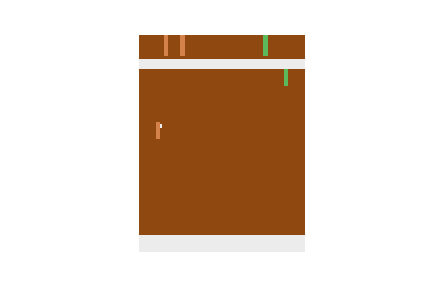
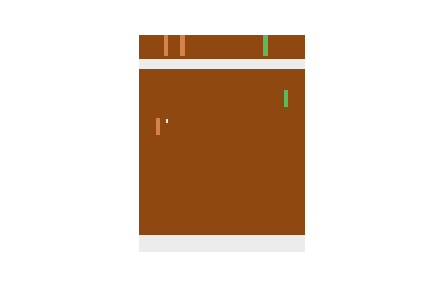
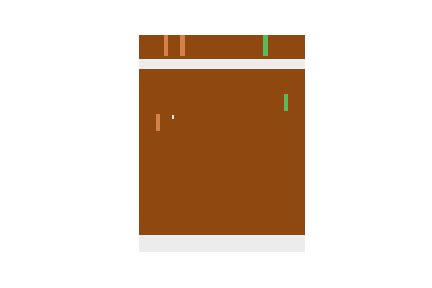
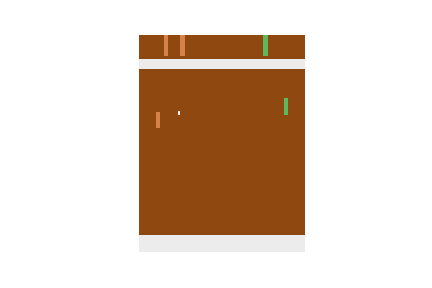
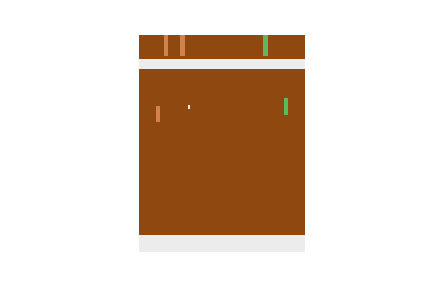
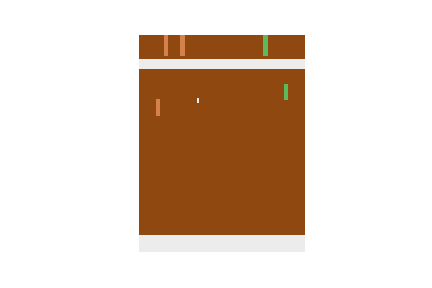
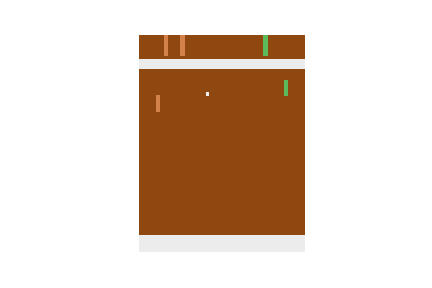
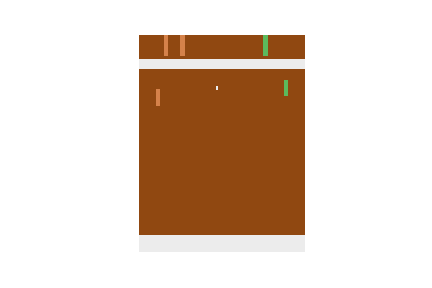
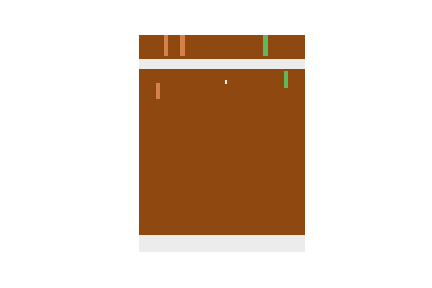
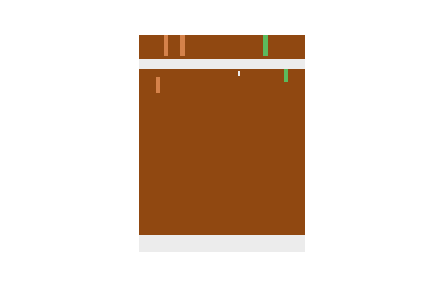
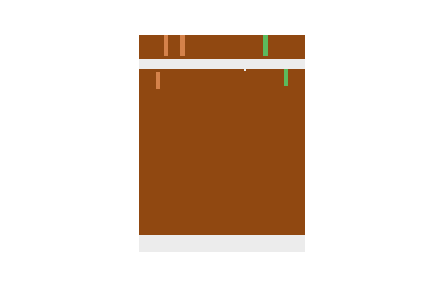
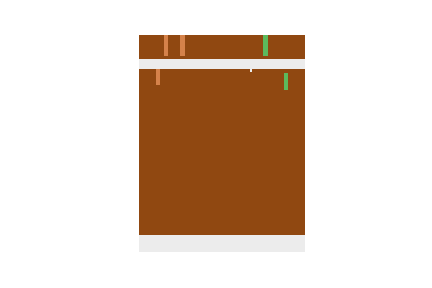
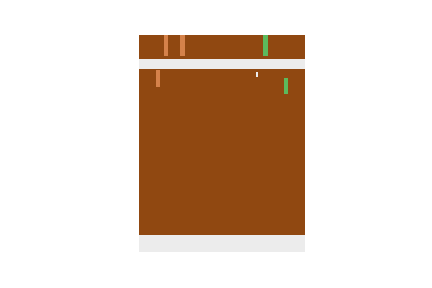
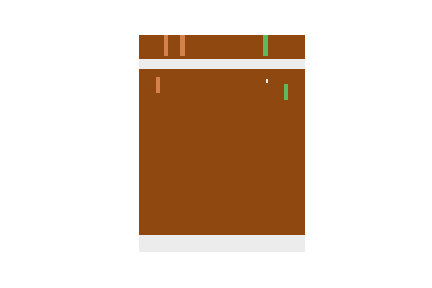
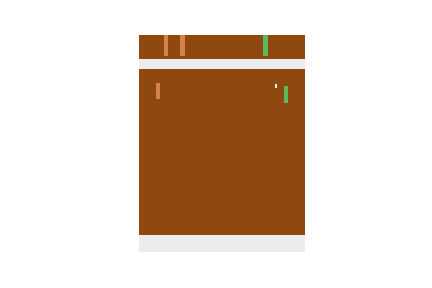
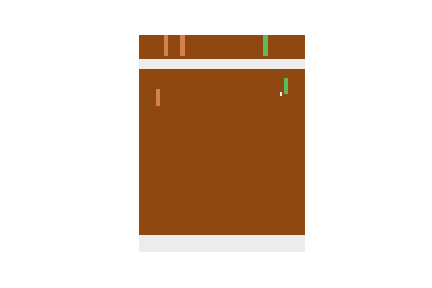
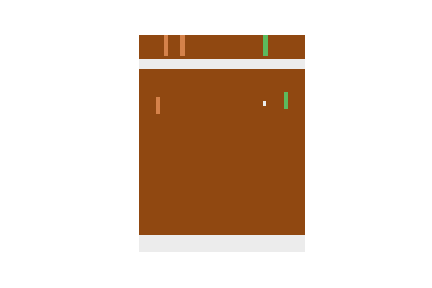
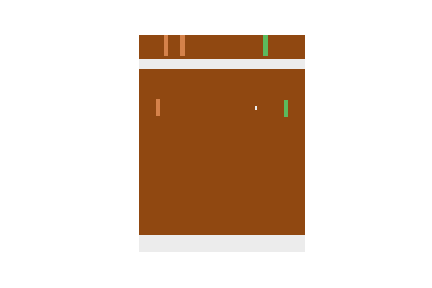
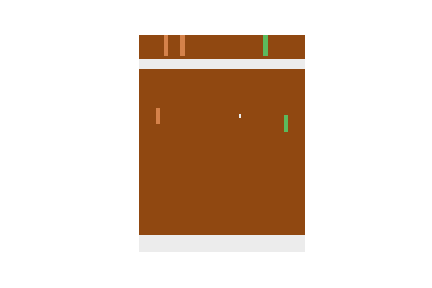
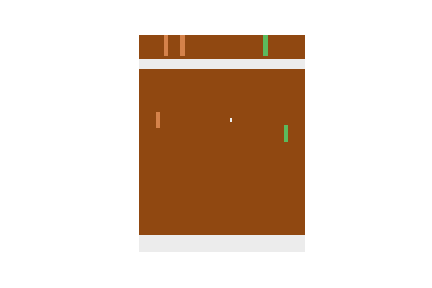
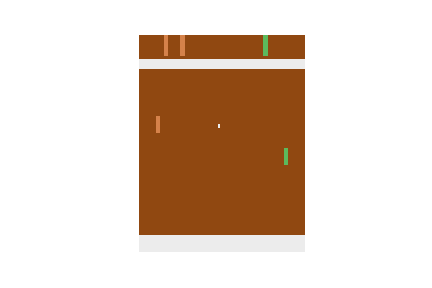
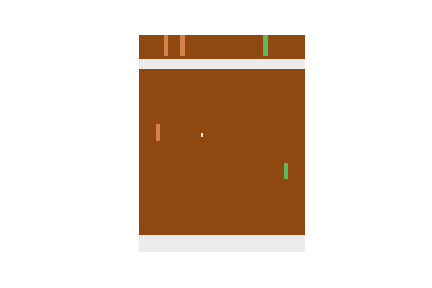
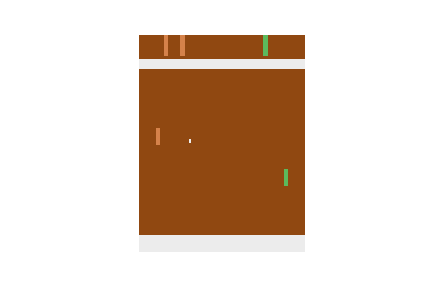
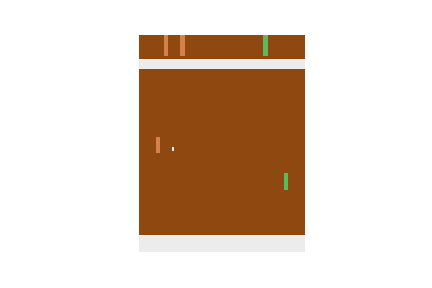
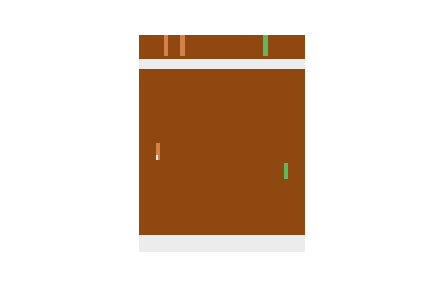
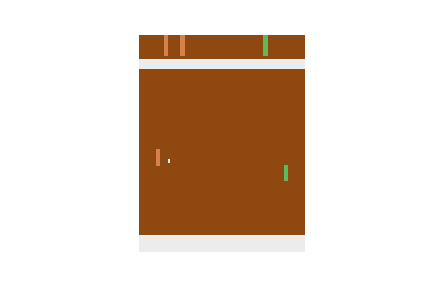
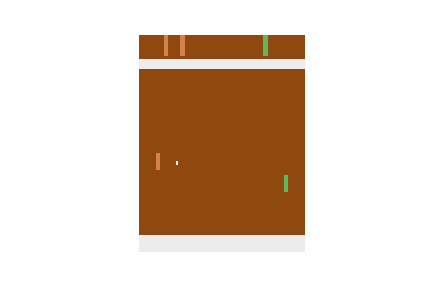
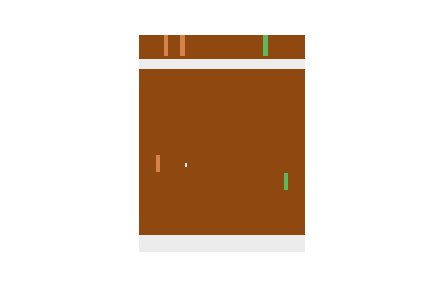
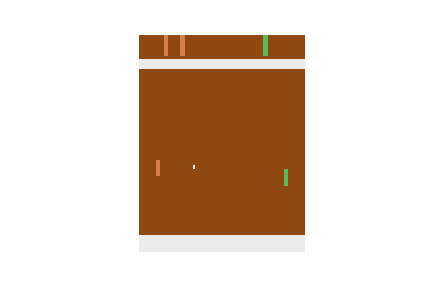
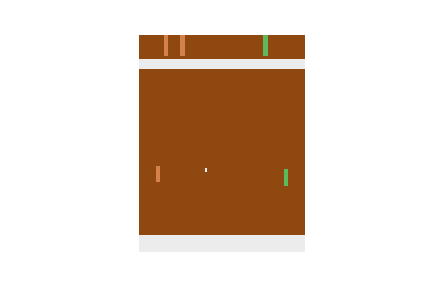
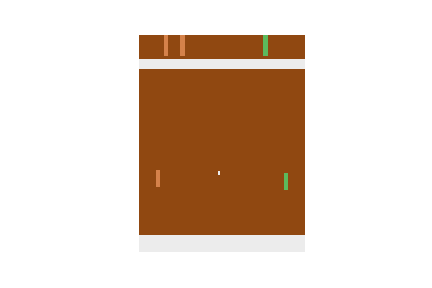
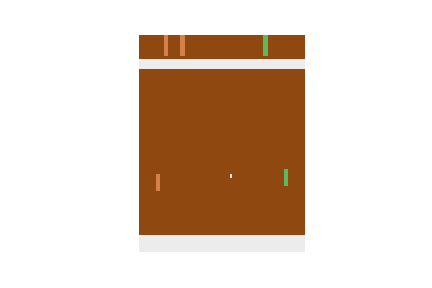
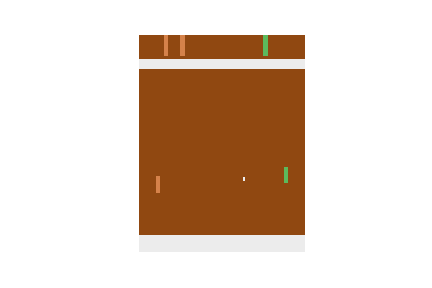
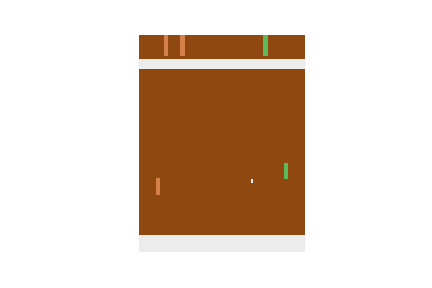
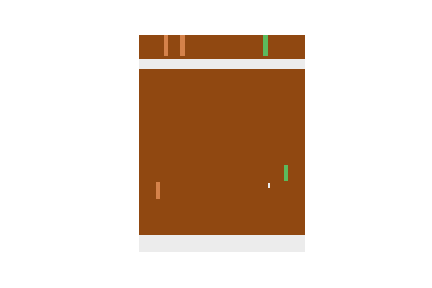
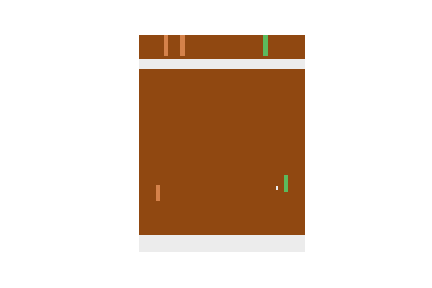
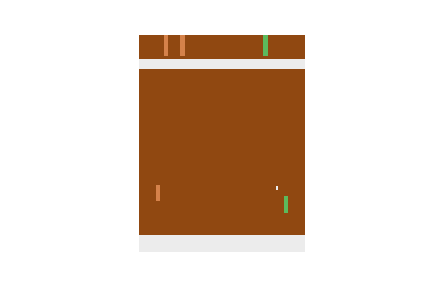
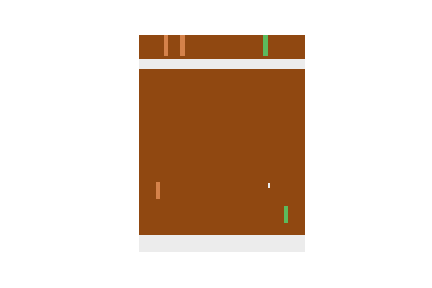
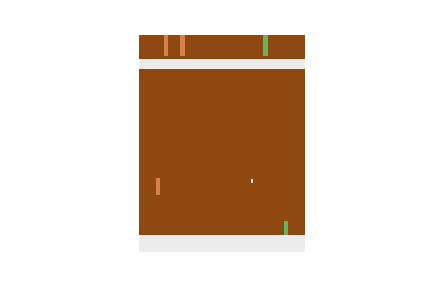
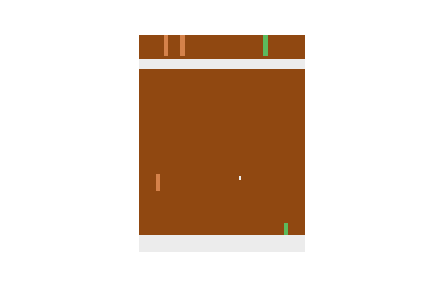
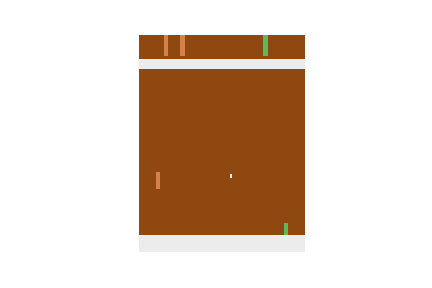
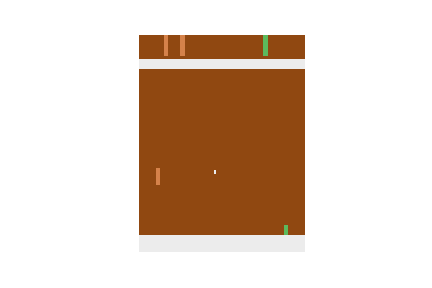
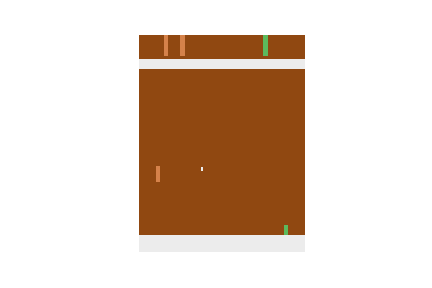
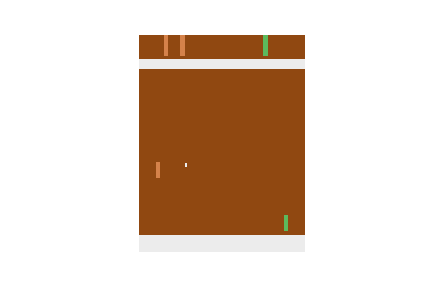
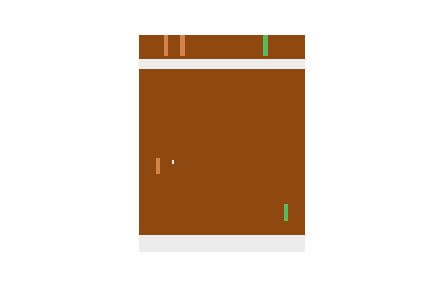
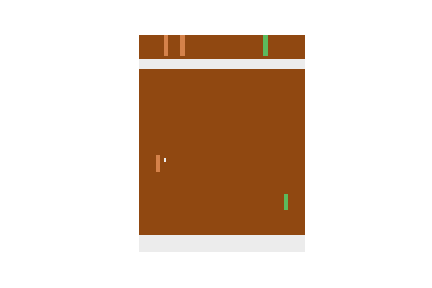
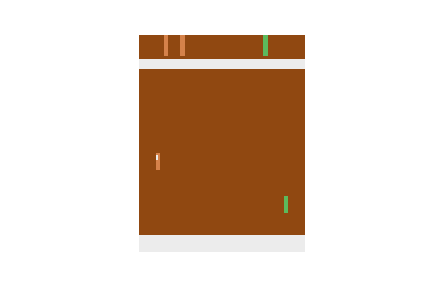
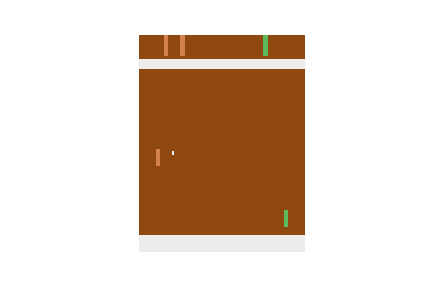
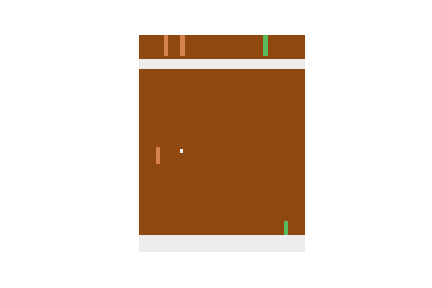
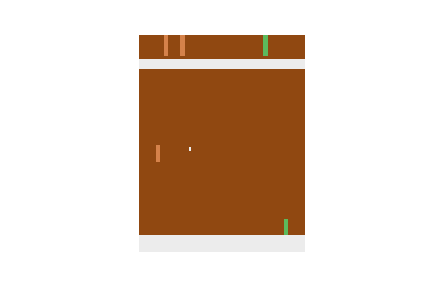
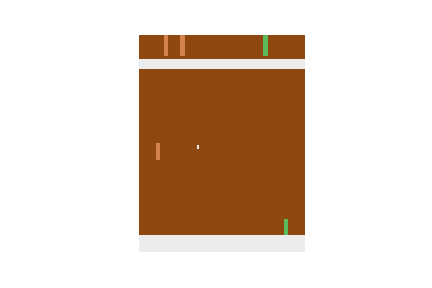
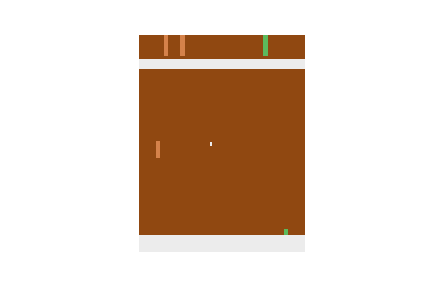
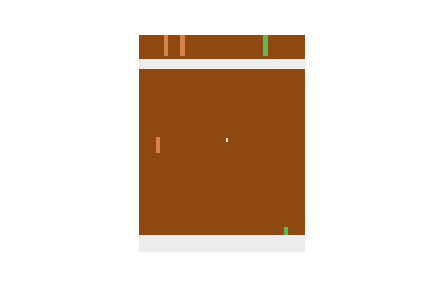
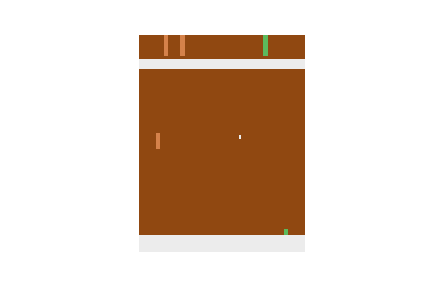
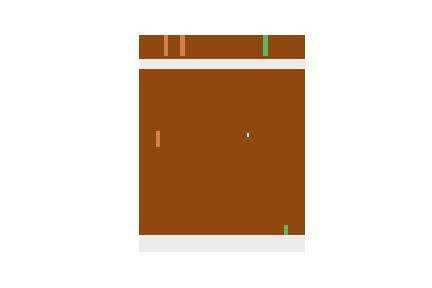
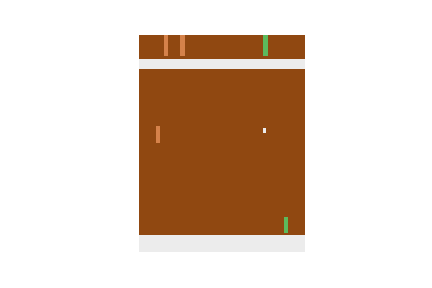
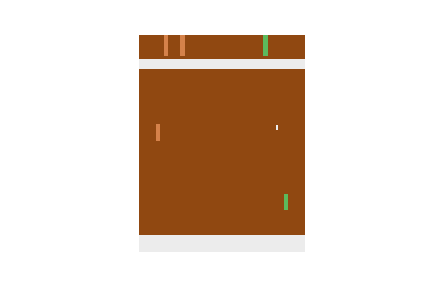
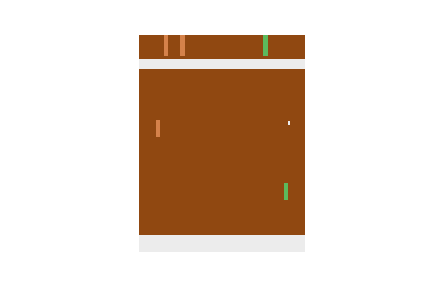
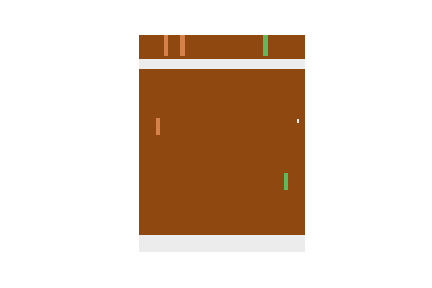
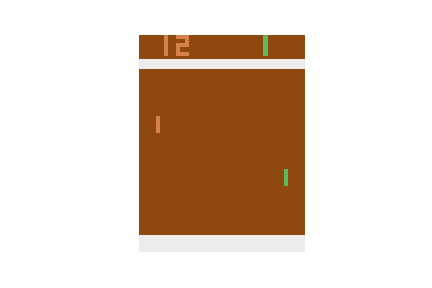
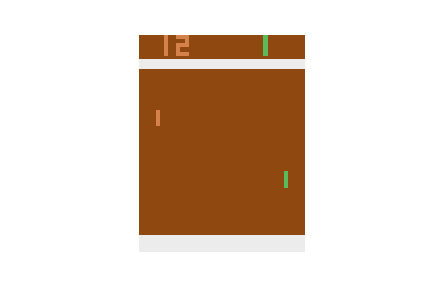
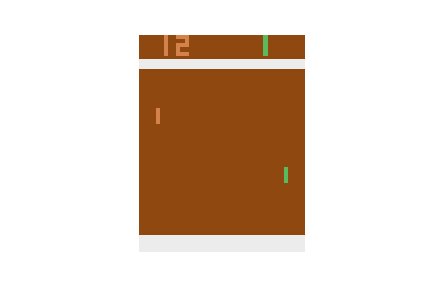
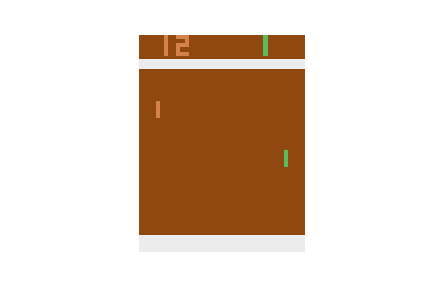
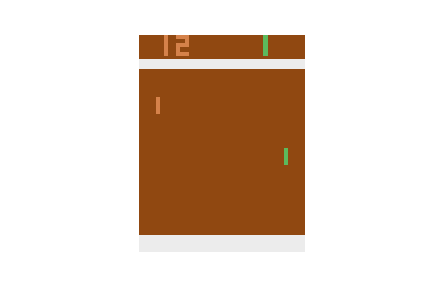
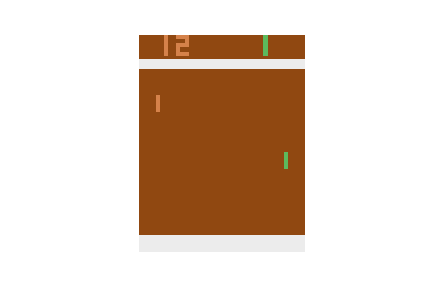
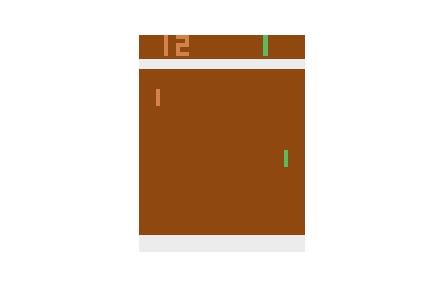
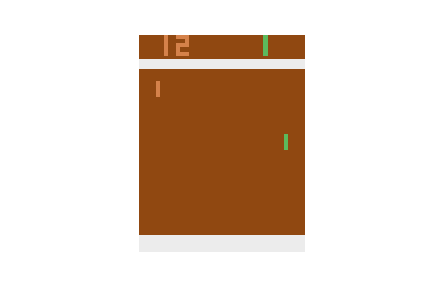
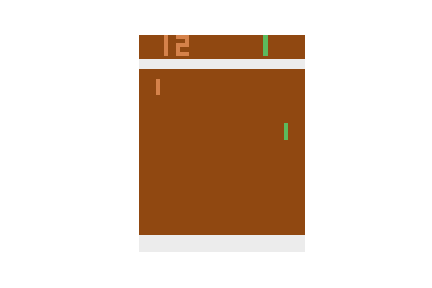
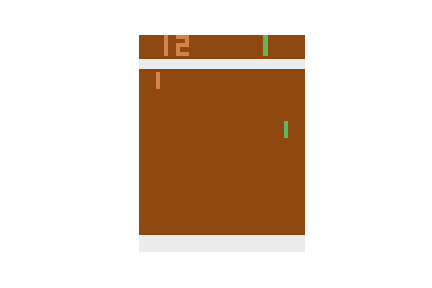
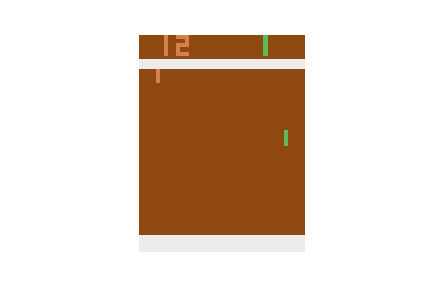
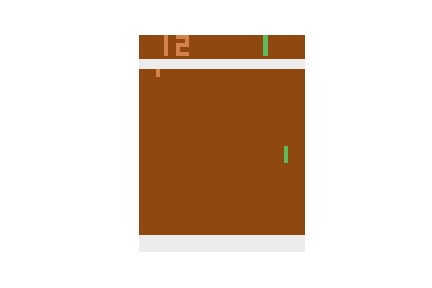
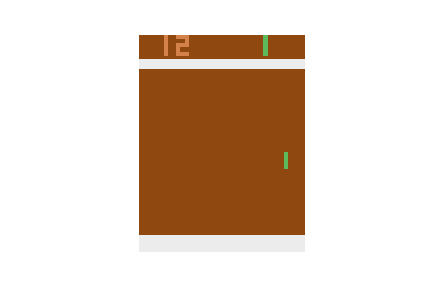
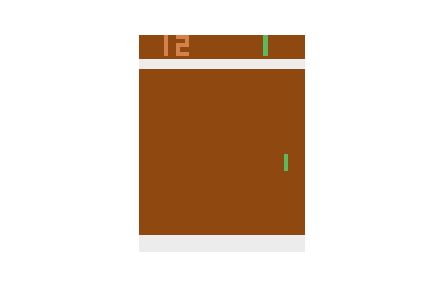
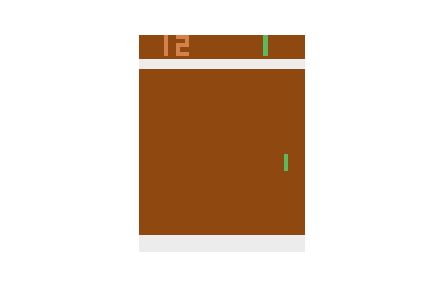
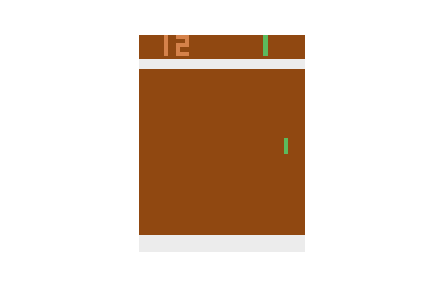
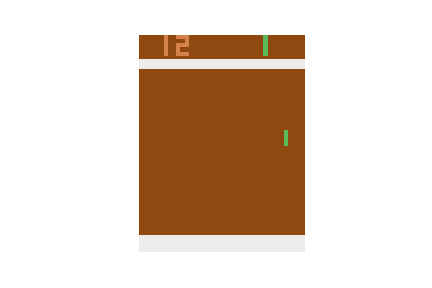
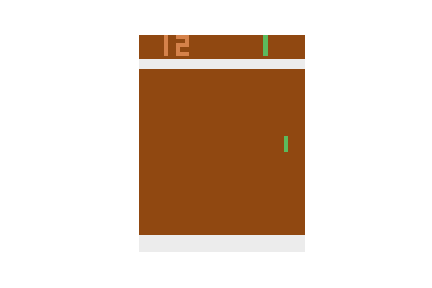
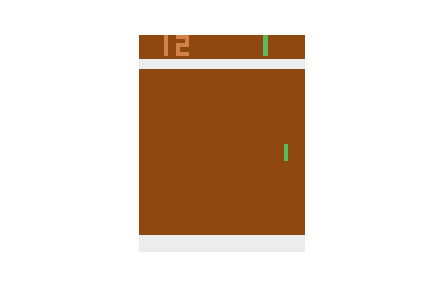
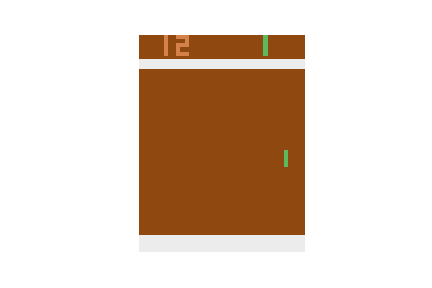
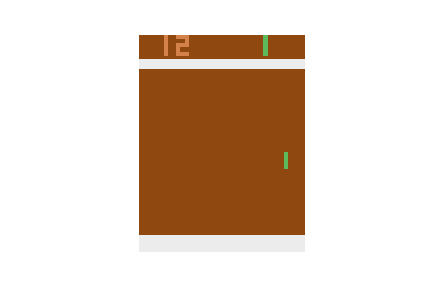
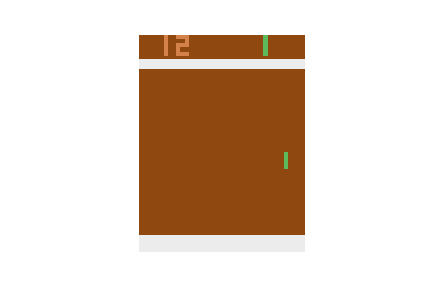
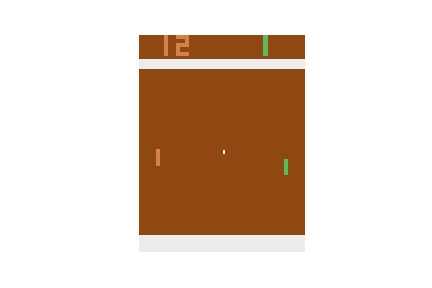
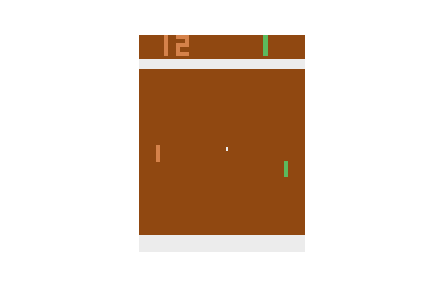
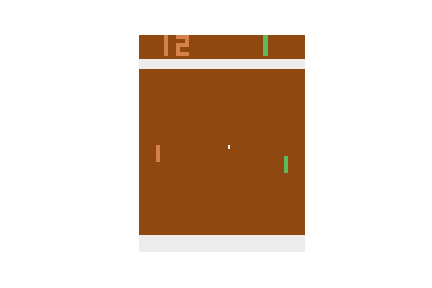
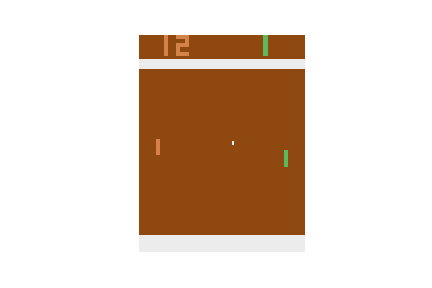
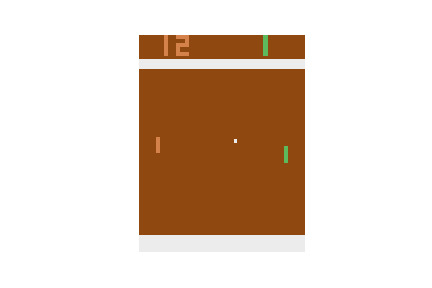
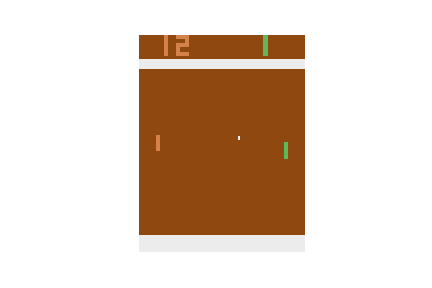
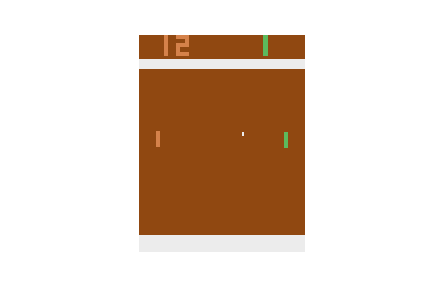
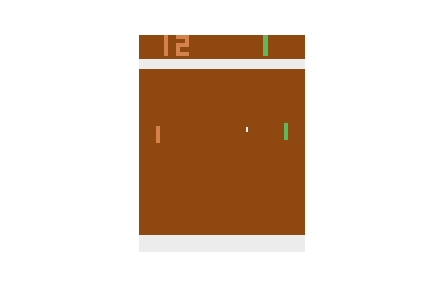
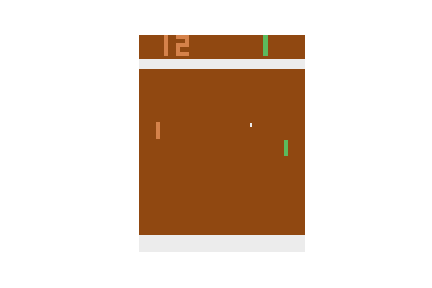
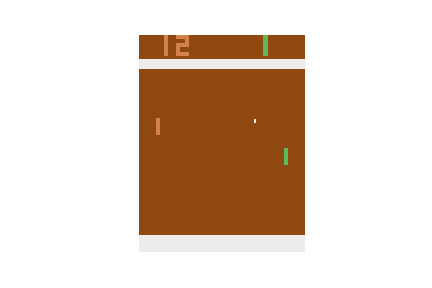
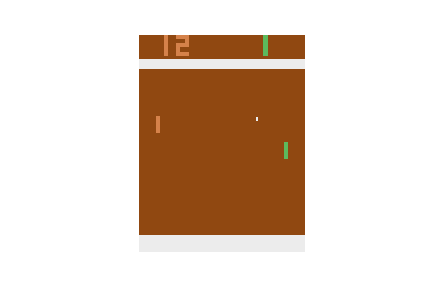
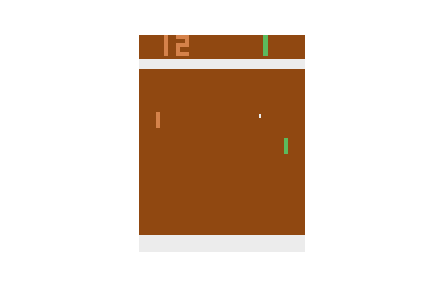
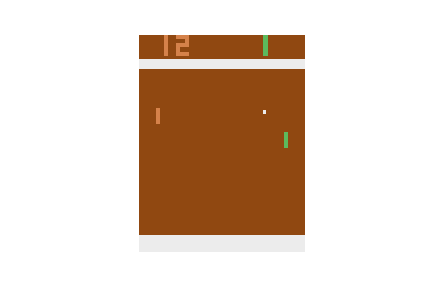
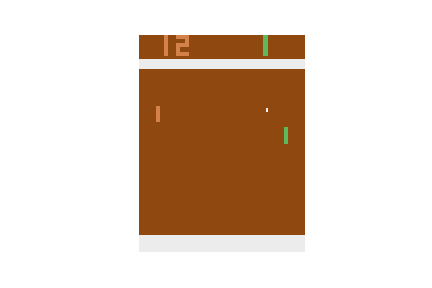
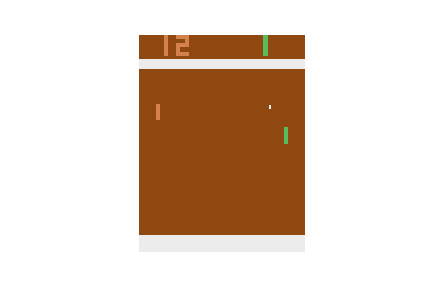
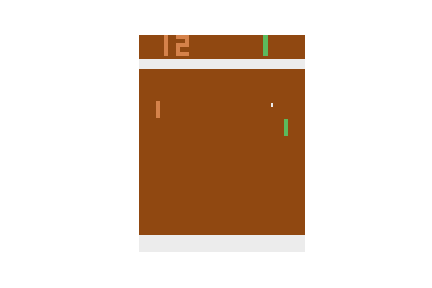
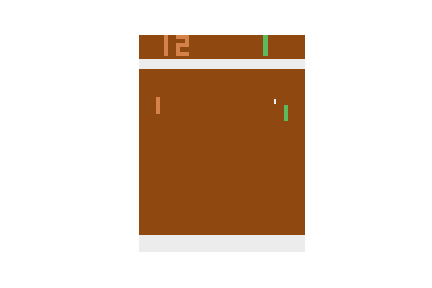
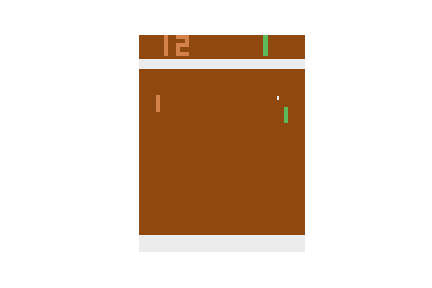
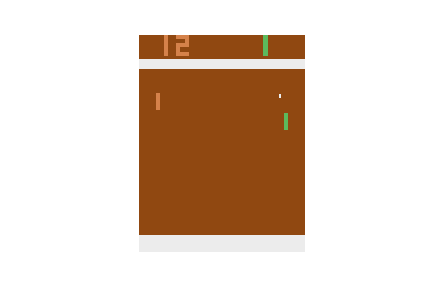
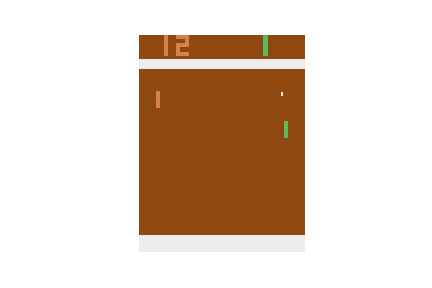
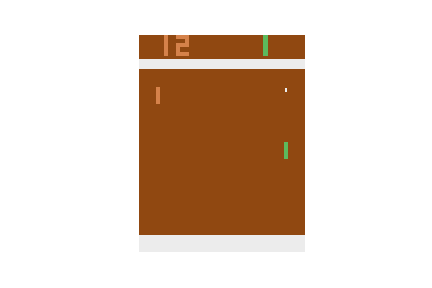
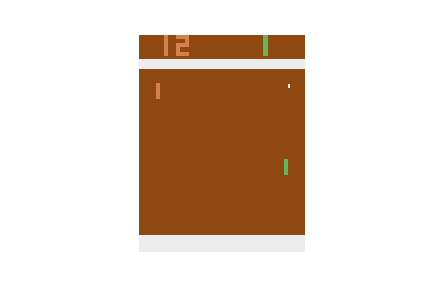
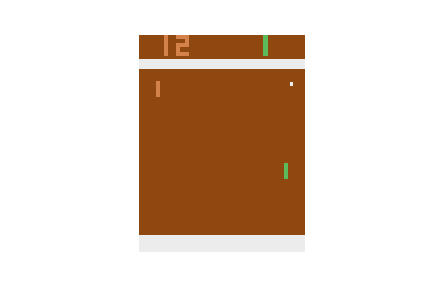
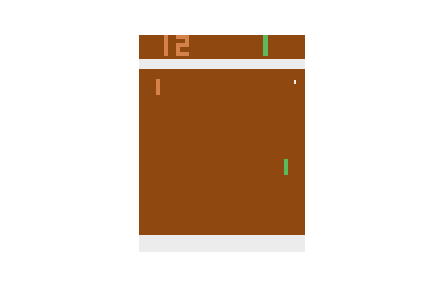
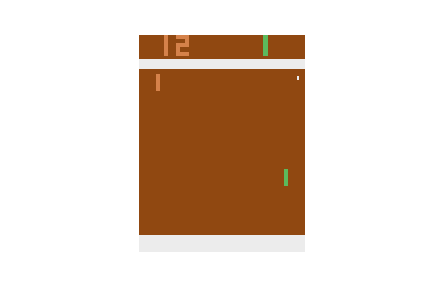
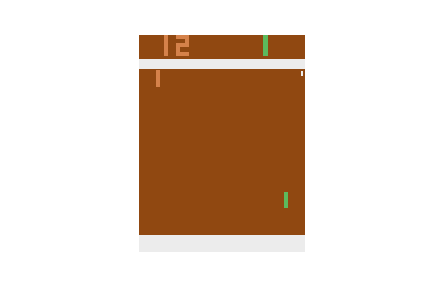
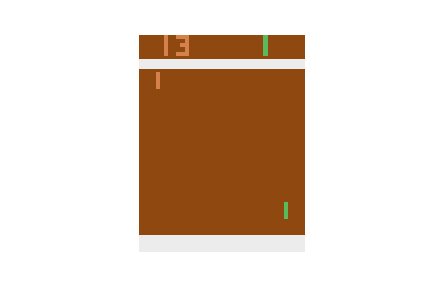
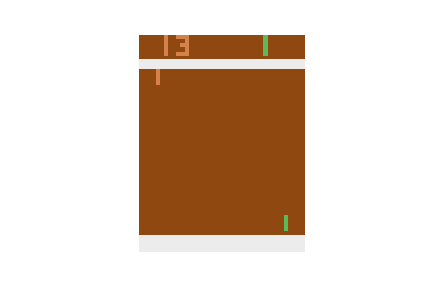
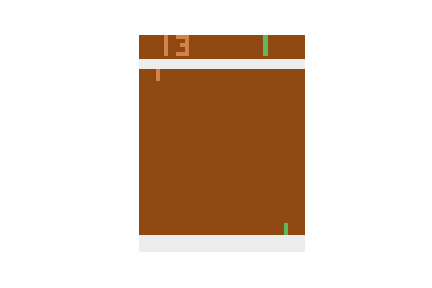
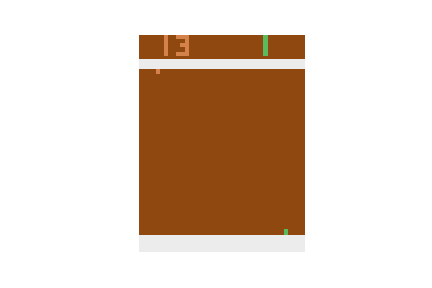
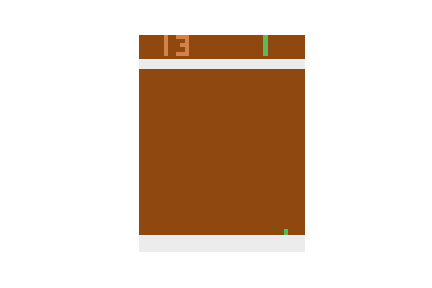
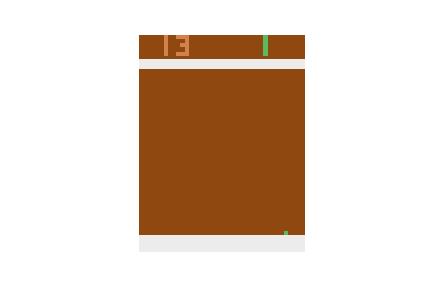
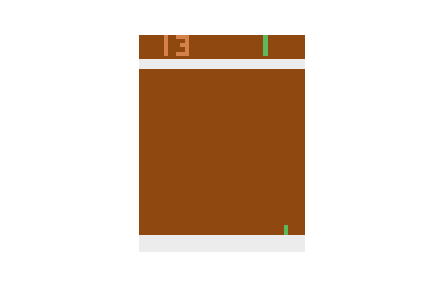
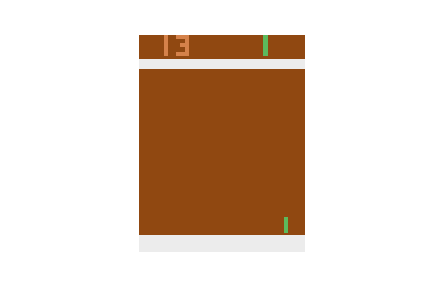
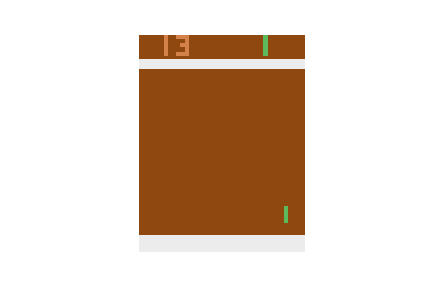
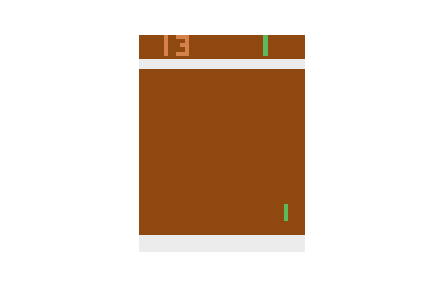
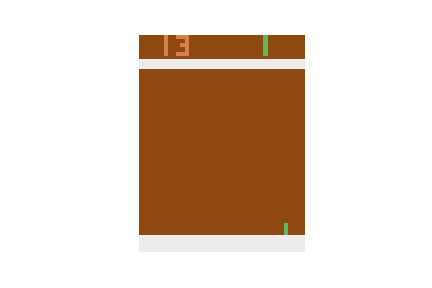
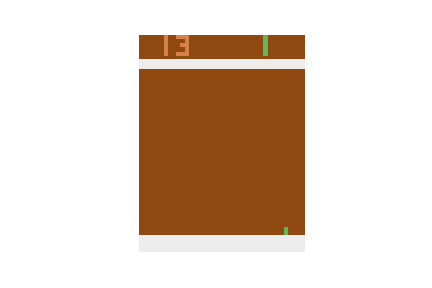
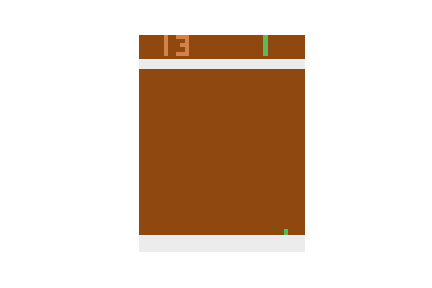
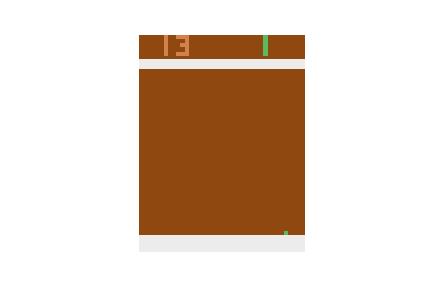
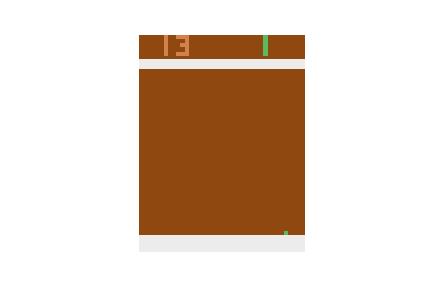
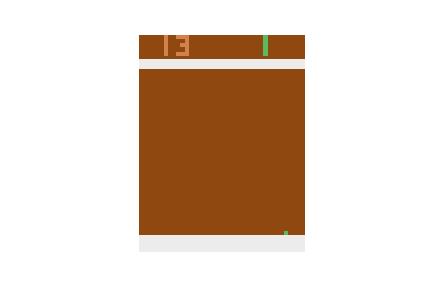
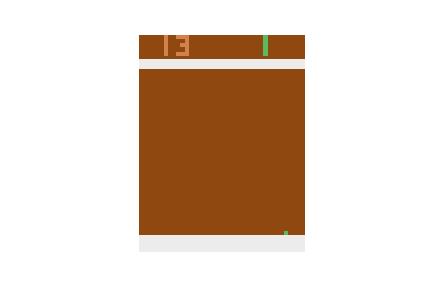
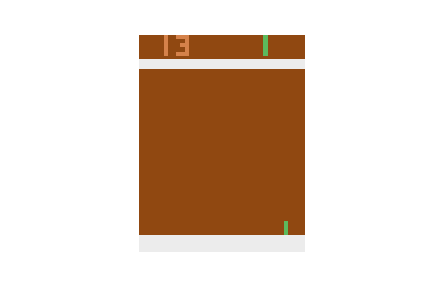
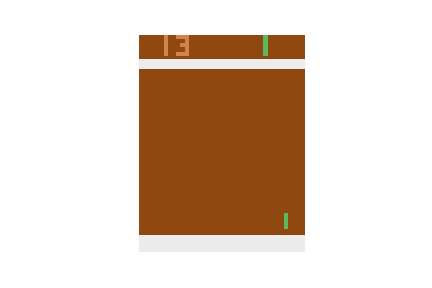
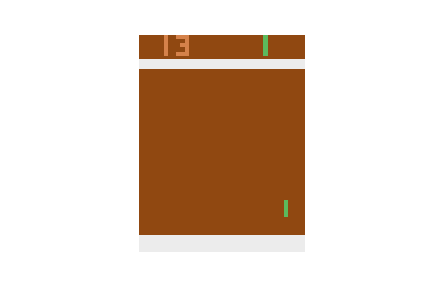
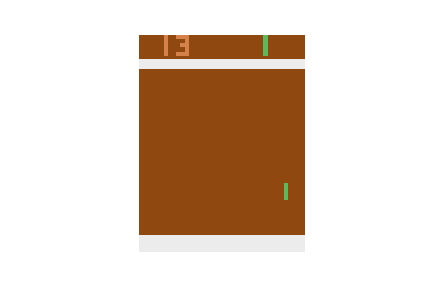
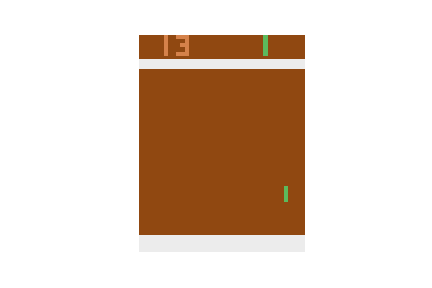
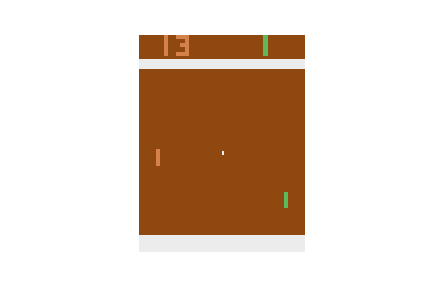
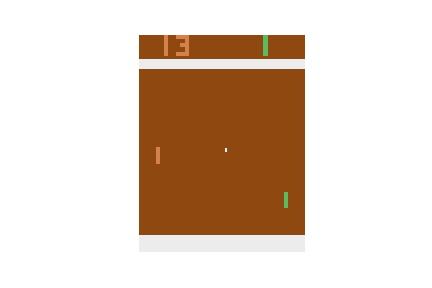
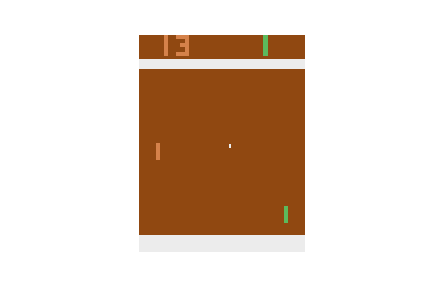
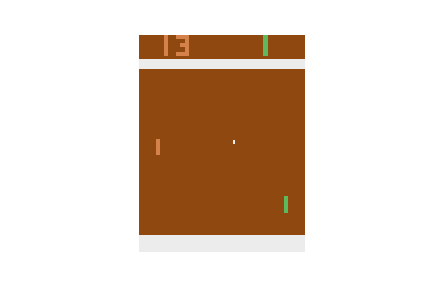
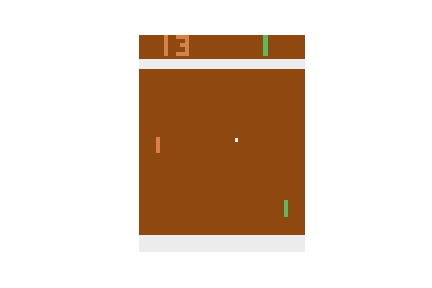
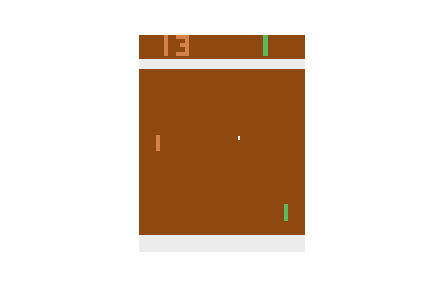
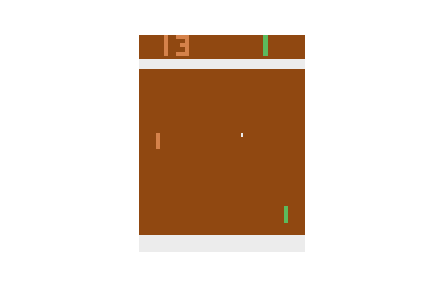
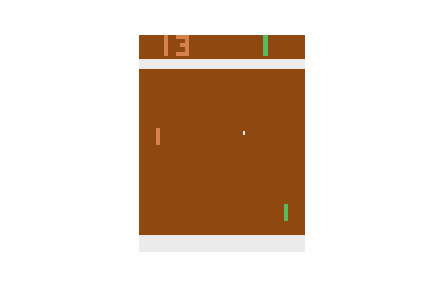
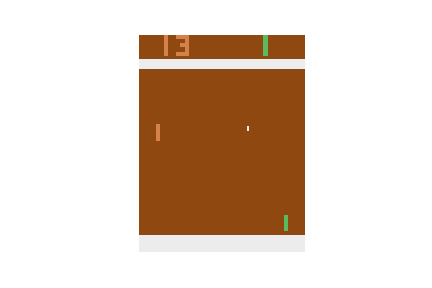
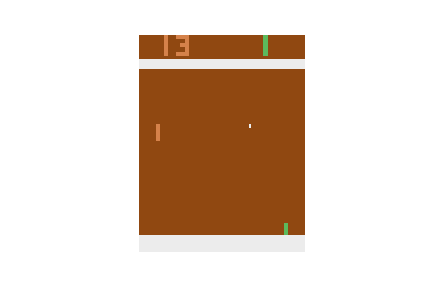
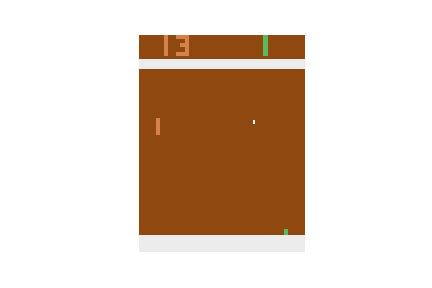
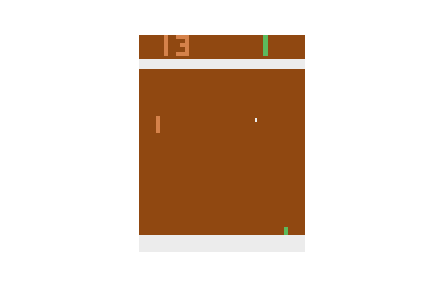
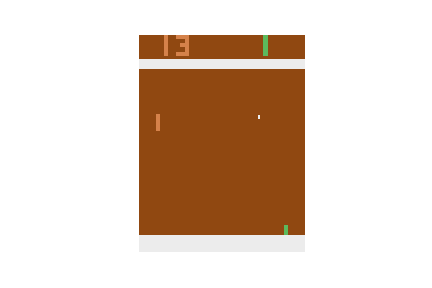
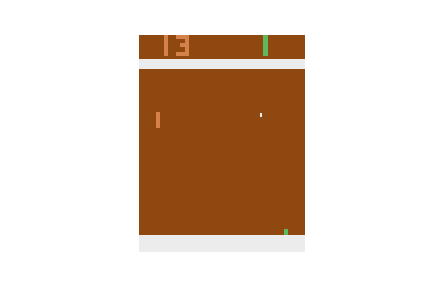
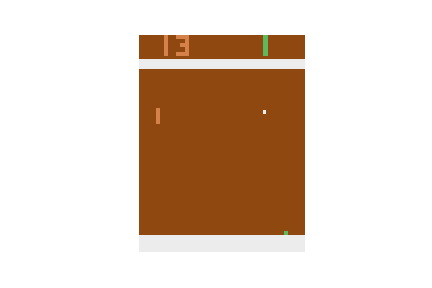
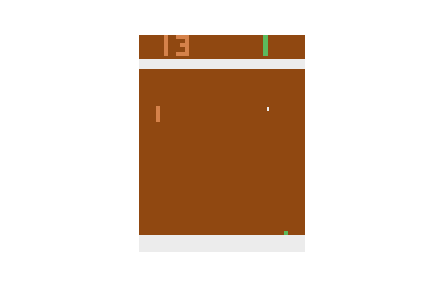
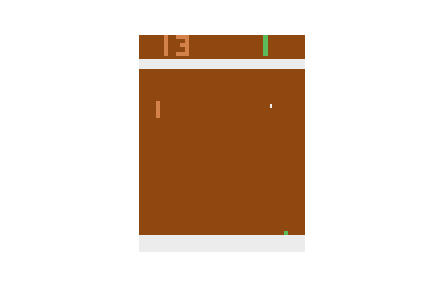
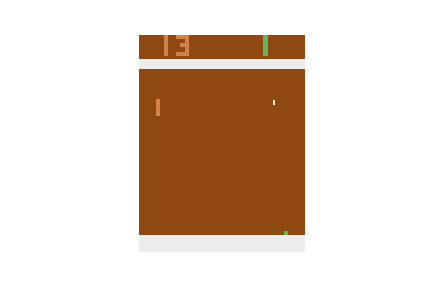
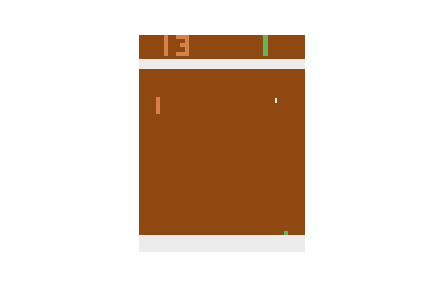
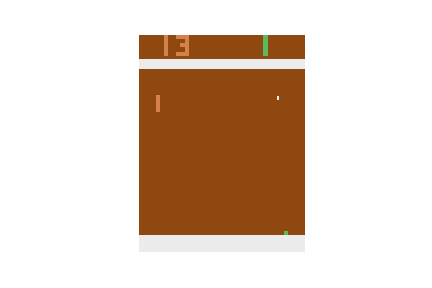
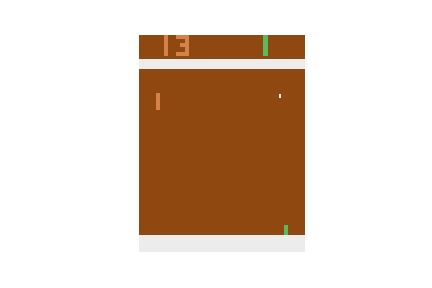
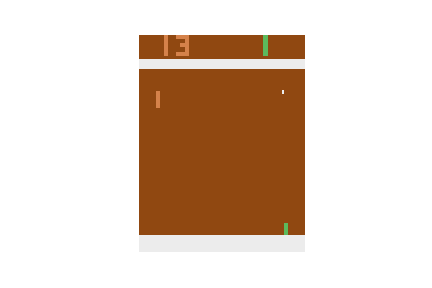
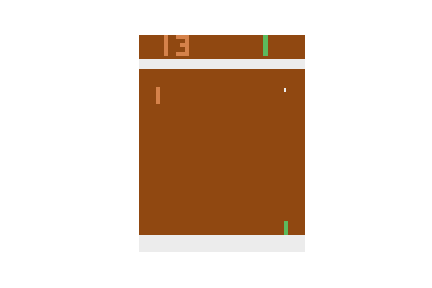
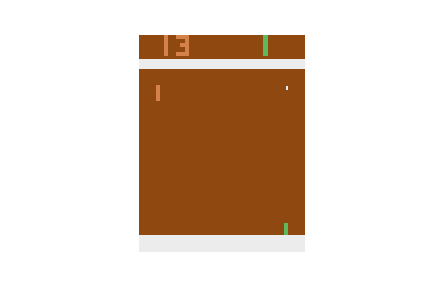
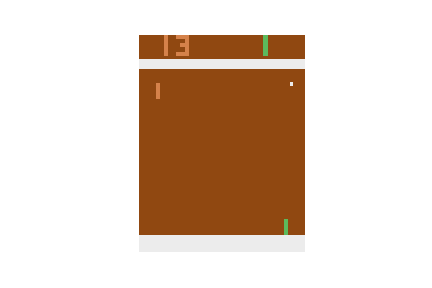
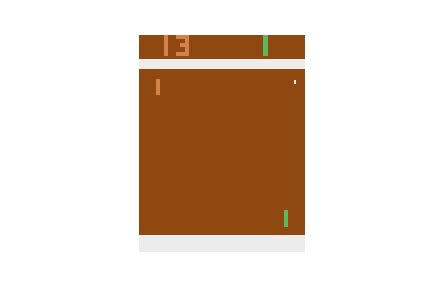
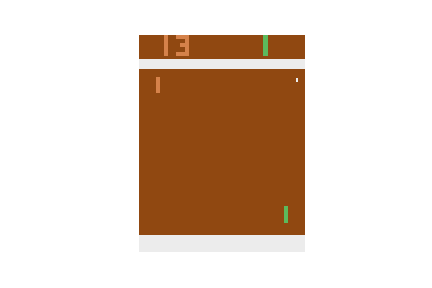
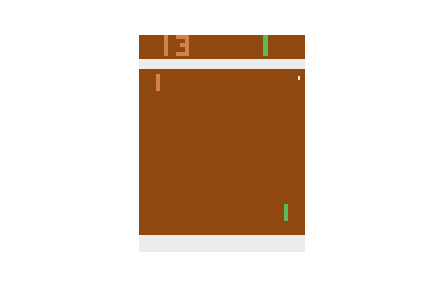
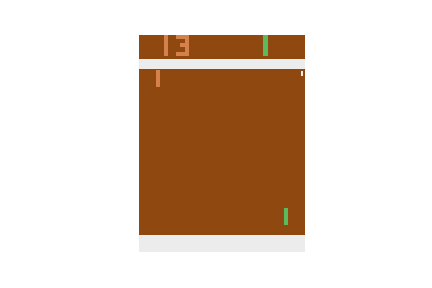
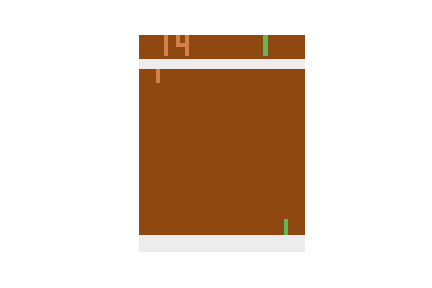
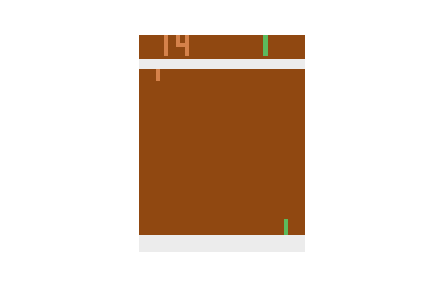
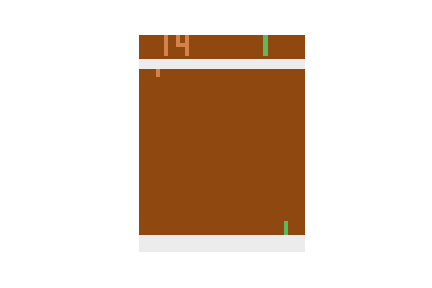
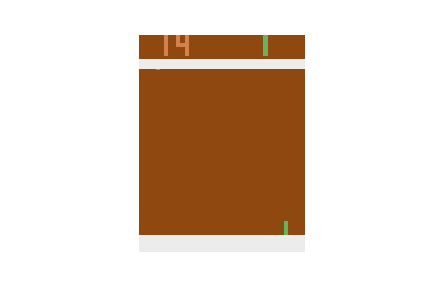
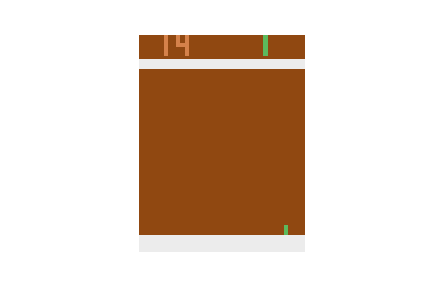
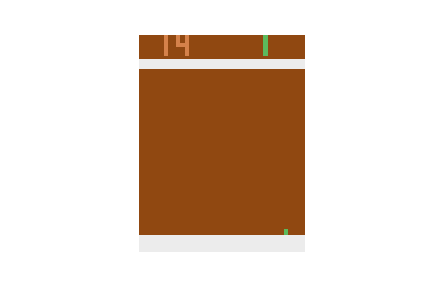
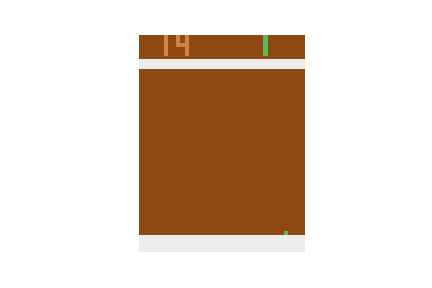
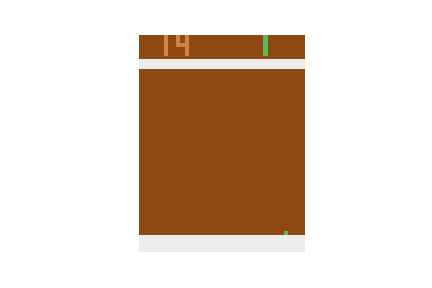
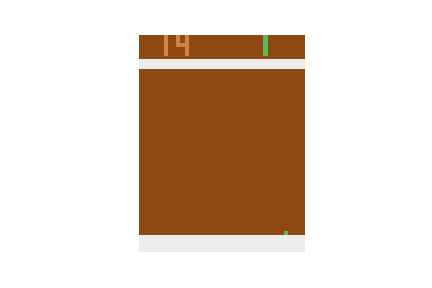
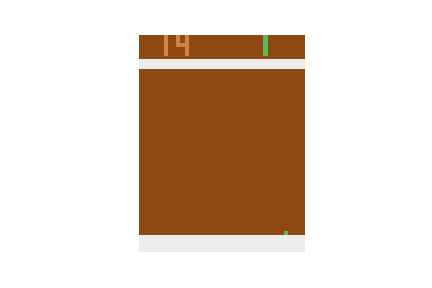
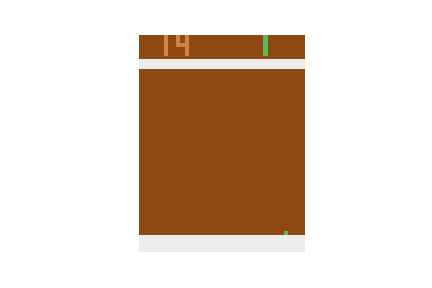
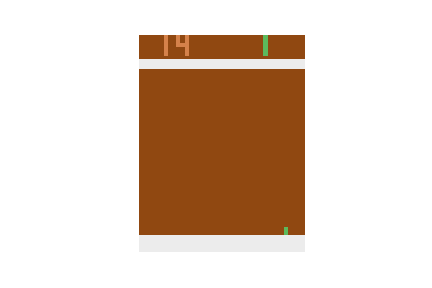
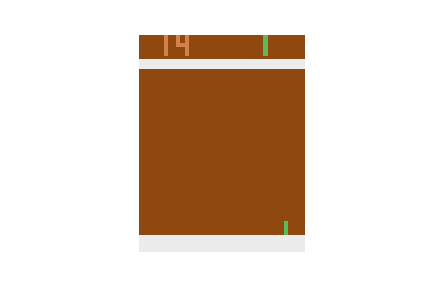
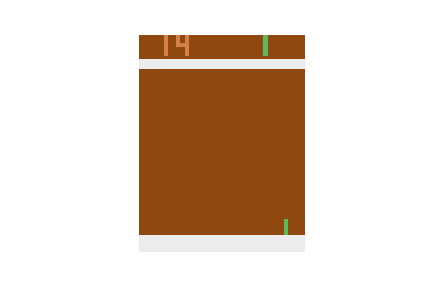
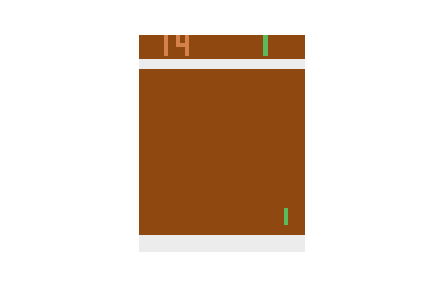
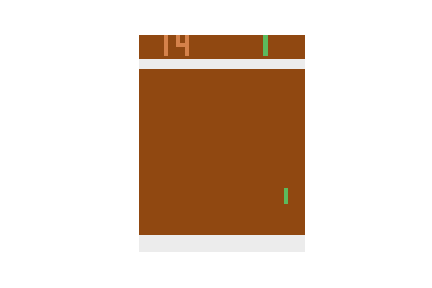
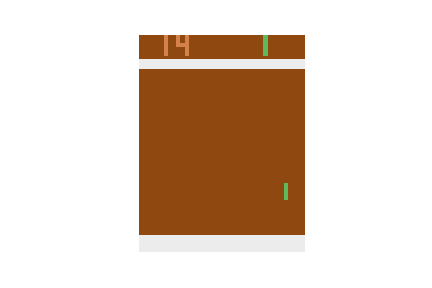
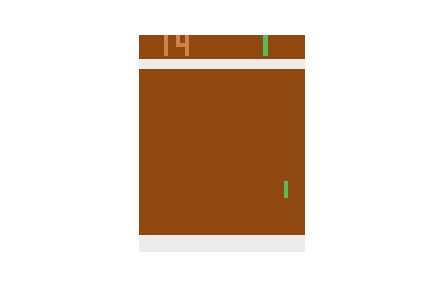
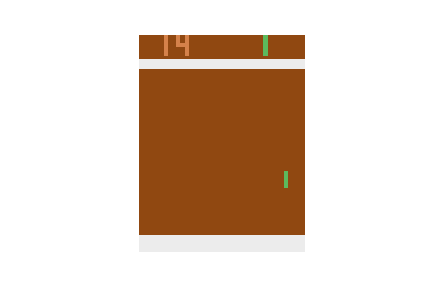
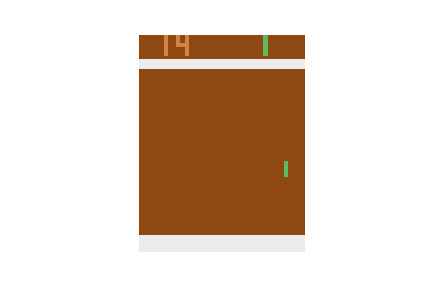
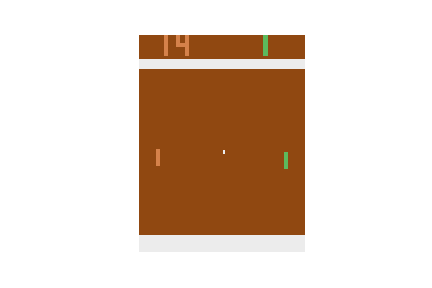
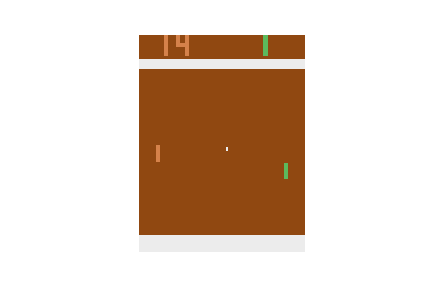
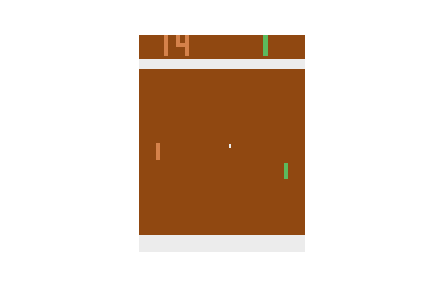
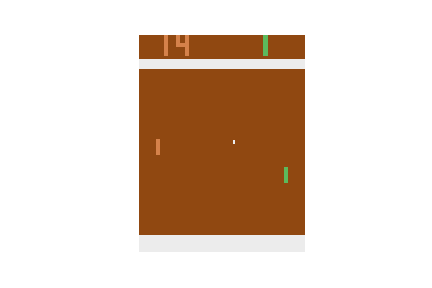
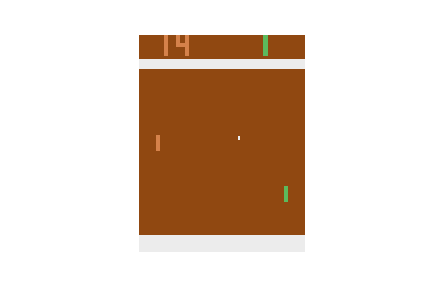
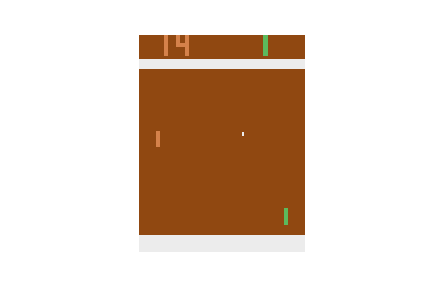
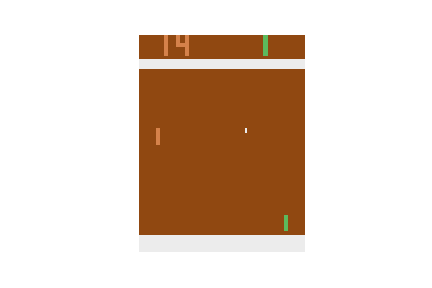
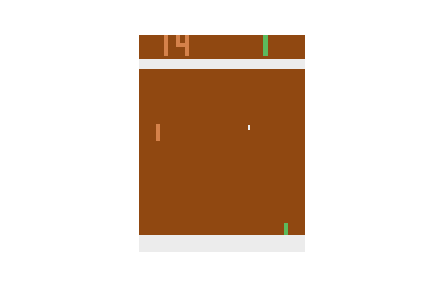
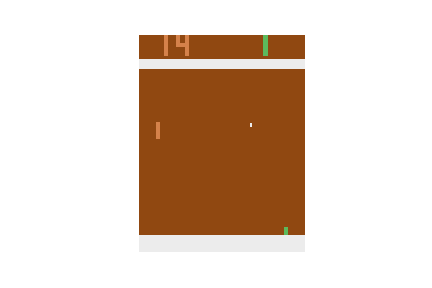

In [1]:
from src import test
from src import draw as dr

%matplotlib inline
dr.display_frames(test.simulate_with_random_policy(number_time_points=1000, random_seed=0))

In this video, the agent is in green. Once the agent decides which way to move the paddle, the game simulator executes the chosen action, computes the physics, and updates the image on the screen. It also gives the agent a reward: +1 if the ball went past the opponent, -1 if the ball goes past the agent, and 0 otherwise. 

More formally, let $T+1$ be the time at which the first player wins 21 games. Then a trajectory (or episode) is defined by the finite sequence 

\begin{equation}
S^0 \xrightarrow[A^0, R^0]{} S^1 \xrightarrow[A^1, R^1]{} \mbox{ } \cdots S^{T+1}.
\end{equation}

Here, $S^t$ are states (these will be closely related to the images), $A^t$ are actions, and $R^t = R(S^t, A^t)$ are rewards. We adopt the convention that random variables are denoted by capital letters while realized values are denoted by lower-case letters. 
The actions are chosen stochastically, conditional upon the current state,

\begin{equation} 
P[ A^t = a^t \,|\, S^t = s^t] = \pi(a^t \,|\, s^t) ,
\end{equation}

while the next state $S^{t+1}$ is computed by the game simulator conditional upon the current state and current action. 




## Credit assignment problem 

When the agent's paddle hits the ball, the pong game simulator assigns a reward of zero. Yet, the result of that volley might be to launch the ball on a trajectory that evades the opponents paddle, winning the game. This suggests that some credit should be assigned to the agent's volley. Ambiguity in how to assign credit to actions is widespread in RL problems and is known as the *credit assignment problem*. 

We assign a discounted reward at time $t$ according to:

\begin{equation}
R_{disc}^t = \gamma^{G(t)-t} R^{G(t)}
\end{equation}

where $G(t)$ is the game endpoint nearest to $t$ and $\gamma<1$ is a discount factor. In addition to assigning +1 when the ball goes past the opponent, for example, this formula assigns positive rewards to earlier timesteps in an exponentially decreasing manner. 

## Weighted Log Likelihood

The agent gains knowledge of the environment only through experience, i.e. taking  actions according to the current policy and measuring the rewards that they induce.  Consider one such experience: 

\begin{equation}
s^0 \xrightarrow[a^0, r^0]{} s^1 \xrightarrow[a^1, r^1]{} \mbox{ } \cdots s^{T+1}.
\end{equation}

We would like to alter the policy function $\pi$ so as to increase the probability of rare actions that resulted in positive discounted rewards while decreasing the probability of the frequent actions associated with negative discounted rewards. One way to do this is to alter $\pi$ so that it increases the weighted log likelihood associated with this particular trajectory:

\begin{equation} 
\boxed{
{\cal L} = \sum_{t=0}^T \log \pi(a^t \,|\, s^t)  \, R_{disc}^t .
}
\end{equation}

To gain some intuition into this formula, it is helpful to think of the realized trajectory as a data set,

\begin{equation} 
\tau = \{(s^i, a^i): i=1, \ldots , T\},
\end{equation}

and the policy function $\pi$ as a model of the data. In this picture, sampling an action produces a predicted label $A^i$ associated with the $i$th data point. 
Then, if all the discounted rewards are equal, ${\cal L}$ is proportional to the
probability that the model produces predicted labels that coincide with the observed labels: 

\begin{equation} 
{\cal L} \propto \log P[ A^0 = a^0, \ldots , A^T = a^T \,|\, S^0 = s^0 , \ldots , S^T = s^T] , 
\end{equation} 

i.e. the log likelihood familiar to us from supervised learning (though in RL a model is used not only to fit data but also to generate them).
The constant of proportionality in this formula is the common reward for each time step. If that reward is positive, then the observed sequence of actions is favorable (for this particular sequence of states), and increasing ${\cal L}$ amounts to increasing the chances of choosing those actions in those states in the future. Conversely, if the common reward is negative, then the observed sequence of actions is unfavorable (again for the given sequence of states), and increasing ${\cal L}$ amounts to decreasing the chances of taking those actions in the future. 

Another advantage of using weighted log likelihood as a measure of performance is that increasing it tends to accelerate wins (by minimizing the number of actions with positive discounted rewards) while at the same time delaying losses (by maximizing the number of actions with negative discounted rewards). 

You may find further insights into the meaning of $\cal L$ in [Andrej Karpathy's blog](http://karpathy.github.io/2016/05/31/rl/) in the sections entitled "Update: December 9, 2016 - alternative view" and "Deriving Policy Gradients". 

How might we increase the weighted log likelihood? A brute-force approach is to randomly explore policy function space, biasing the search towards higher-performant regions, as done in the [Cross Entropy Method](https://www.aaai.org/Papers/ICML/2003/ICML03-068.pdf). This is similar to natural selection, which randomly explores genotype space, selecting fitter individuals at the expense of those less fit. And just like natural selection leads to unexpected adaptations in biology, the Cross Entropy Methods often works surprisingly well.

Another way to increase $\cal L$ is the Policy Gradient Method: greedily increase $\cal L$ by adjusting the parameters $W$ of the policy function in the average direction $\nabla_W {\cal L}$ takes in a mini-batch of trajectories, $G_W = \sum_{i=1}^n \nabla_W {\cal L}(\tau_i)$: 

\begin{equation} 
W \leftarrow W + \alpha \, G_W.
\end{equation} 

However there is a problem with this naive approach: The components of the batch gradient vector $G_W$ vary in magnitude both among weights and during learning, making it difficult to choose a single suitable value for the learning rate $\alpha$. A technique called [RMS prop](https://www.youtube.com/watch?v=defQQqkXEfE) addresses both problems by dividing each component of the batch gradient by its root-mean-square, 

\begin{equation} 
\boxed{
W \leftarrow W + \alpha
\frac{G_W}{\sqrt{S_W} + 10^{-5}} ,
}
\end{equation} 

where $S_W$ is the exponential moving average over batches (labeled by $b$):

\begin{equation} 
S_W(b) = 
\eta \, G_W^2(b) + (1-\eta) \, S_W(b-1) 
\end{equation}




## Modeling the policy function

To compute a formula for the policy gradient, $\nabla_W \log\pi$, we need a model for the policy function $\pi(a \, | \, s)$. 
Since there are only two possible actions, the policy function can be specified by the probability of moving the paddle up, $p(s)$:

\begin{eqnarray} 
\pi(\uparrow | \, s) & = & p(s) \\
\pi(\downarrow | \, s) & = & 1 - p(s).
\end{eqnarray}

Following [Andrej Karpathy](http://karpathy.github.io/2016/05/31/rl/), we use a three-layer feedforward neural network to model the function $p(s)$:


![](images/NN_with_weights-01.png)


The layers of the neural network are connected via two weight matrices, $W^1$ and $W^2$ (no biases), whose initial values are set using Xavier normalization. Michael Nielsen gives a [nice discussion](http://neuralnetworksanddeeplearning.com/chap3.html#weight_initialization) of how Xavier normalization prevents neuron saturation and slowdown of learning. The math justifying the procedure can be found [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization).


A static image lacks important information for deciding how to move the paddle: the ball velocity. To extract some of that information, we will pass the *difference of successive  images* to the policy function. In other words, we choose the input nodes $s_j$ to be the difference of a pair of successive vectorized processed images. 

We process the images by stripping them down to the bare minimum needed to make informed decisions about which actions to take:





[2017-09-19 16:24:38,683] Making new env: Pong-v0


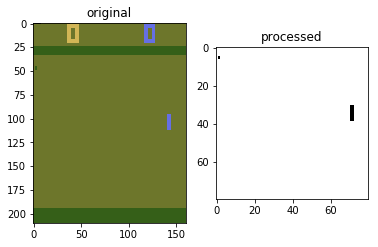

In [2]:
from src import draw as dr
image = dr.sample_image(random_seed=0) 

import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image)
ax1.set_title('original')
ax2.imshow(dr.process(image), cmap='Greys')
ax2.set_title('processed')

## Forward propagation 

The process of computing $p(s)$ is referred to as forward propagating through the network. We define the neurons in the hidden layer, $h_i$, to be Rectified Linear Units (ReLUs),

\begin{equation} 
h = \max(0, W^1s),
\end{equation} 

where $s$ and $h$ are column vectors. ReLUs can accelerate training relative to saturating neurons by (partially) circumventing the vanishing gradient problem (e.g. Fig 1 of [Krizhevsky 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)). 
Since probabilities must lie between $0$ and $1$, we model 
the activation of the output neuron with a sigmoid function $g$ according to:

\begin{equation} 
p = g(W^2h).
\end{equation} 

By defining our objective function ${\cal L}$ in terms of a cross-entropy ($\log\pi$), we avoid the problem of learning slowdown that would otherwise be associated with the fact that $g$ saturates (see Eq. (67) [here](http://neuralnetworksanddeeplearning.com/chap3.html)). 



## Backward propagation 

Having set up a model for the policy we may now compute its gradient, $\nabla_W \log \pi( a\, | \, s)$. Considering the two possible values of $a$ separately, and using the chain rule of differentiation, one may show that the matrix representing the gradient of the policy with respect to $W^2$ (the weights coming out of the second layer of the policy network) is

\begin{equation} 
\nabla_{W^2} \log \pi( a\, | \, s) = \delta^3(s,a) h^{\text{Tr}}(s) 
\end{equation} 

where Tr denotes transpose. The first factor on the right-hand side is defined by

\begin{eqnarray} 
\delta^3(s,a) & = & y(a) - p(s) \\
y(a) & = &
\left\{ 
\begin{array}{cc}
1 & \text{ if } a = \uparrow \\
0 & \text{ if } a = \downarrow
\end{array}
\right. .
\end{eqnarray} 

and measures the sensitivity of $\log \pi(a \, | \, s)$ to changes in the weighted input to the output neuron. 

We may now compute $\nabla_{W} {\cal L}(\tau)$ for a sample trajectory $\tau = \{ s^0, a^0; s^1, a^1; \ldots ; s^T \}$ as:

\begin{equation} 
\boxed{
\nabla_{W^2} {\cal L} = \left(\hat{\delta^3}\right)^{\text{Tr}} H
}
\end{equation} 

where

\begin{equation} 
H = 
\left[
\begin{array}{rcl} 
\cdots & h^0 & \cdots\\
\cdots & h^1 & \cdots\\
 & \vdots & \\
\cdots & h^T & \cdots\\ 
\end{array} 
\right],
\end{equation}

and the notation $\cdots h^t \cdots$ indicates that the vector of hidden-layer activations at time $t$, $h^t$, should be written as a row vector. Also, 

\begin{equation} 
\hat{\delta^3} = 
\left[
\begin{array}{c} 
\delta^{3,0} \, R^0_{\text{disc}} \\
\delta^{3,1} \, R^1_{\text{disc}} \\
 \vdots\\
\delta^{3,T} \, R^T_{\text{disc}} 
\end{array} 
\right],
\end{equation}

where $\delta^{3,t} = \delta^3(s^t, a^t)$. 

A similar but more involved calculation yields

\begin{equation} 
\boxed{
\nabla_{W^1} {\cal L}  = \left(\hat{\delta^2}\right)^{\text{Tr}}  S
}
\end{equation} 
where 

\begin{equation} 
S = 
\left[
\begin{array}{rcl} 
\cdots & s^0 & \cdots\\
\cdots & s^1 & \cdots\\
 & \vdots & \\
\cdots & s^T & \cdots\\ 
\end{array} 
\right]
\end{equation}

is the matrix formed by vertically stacking the states at each time point, with each state  written as a row vector. 
The error term $\hat{\delta^3}$ is 'back-propagated' to a similar error term, 


\begin{equation} 
\hat{\delta^2} = \left( \hat{\delta^3} \otimes W^2 \right) \odot u(H),
\end{equation} 

associated with variations in inputs to the hidden layer. In this formula, 
the Outer Product is defined by

\begin{equation} 
(u \otimes v)_{ij} = u_i v_j,
\end{equation}

and the Hadamard Product by

\begin{equation} 
(A \odot B)_{ij} = A_{ij} B_{ij} .
\end{equation} 

The function $u$ is the Heaviside function, 

\begin{equation} 
u(h) = 
\left\{
\begin{array}{cc} 
0 & h = 0 \\
1 & h > 0 
\end{array}
\right. ,
\end{equation} 

and comes from back-propagating through ReLUs in the hidden layer. It tells us that, should a hidden neuron ever become zero (dead) at all time points in a trajectory, then $\nabla_{W^1} {\cal L}=0$ for all the associated incoming weights $W^1$, which therefore do not change when a gradient descent update is performed. To the extent that the neuronal activations experienced during the trajectory were typical, the hidden neuron is therefore destined to remain dead, and no learning associated with this neuron is possible. This is a well-known problem associated with ReLU neurons. It can be monitored by reporting the number of dead neurons as training progresses, and mitigated by reducing the learning rate $\alpha$ should the number of dead neurons become unacceptably high. 


## Trained AI

I performed about a dozen half-hour-long training runs on my MacBook Pro (OS X 10.12.6) to get a feel for the impact on learning performance of things like ReLUs versus sigmoid activations in the hidden layer, RMS Prop versus vanilla gradient descent, and standardizing the rewards to have zero mean and unit variance (for a discussion of reward standarization, see [Andrej Karpathy's blog](http://karpathy.github.io/2016/05/31/rl/) under 'More general advantage functions'). I concluded that all three elements improved performance (possibly synergistically). 

I then trained the model overnight on an imac (OS X 10.11.6). You can execute the `train.sh` bash script to replicate the training results below. The notation '$\langle \text{reward} \rangle$' represents an exponential moving average of rewards; 'dead neuron frac.' indicates the fraction of hidden neurons that are completely deactivated.  



In [3]:
import pandas as pd 
df = pd.read_table('./data/train.dat', names=['trajectory','reward','<reward>','$\cal L$','dead neuron frac.']) 
df[:10]

,trajectory,reward,<reward>,$\cal L$,dead neuron frac.
0,1,-20,-20.000,-0.276,0.508
1,2,-20,-20.000,-1.364,0.517
2,3,-21,-20.010,1.307,0.512
3,4,-21,-20.020,-0.141,0.505
4,5,-20,-20.020,-0.143,0.508
5,6,-21,-20.030,-1.036,0.516
6,7,-21,-20.039,0.186,0.503
7,8,-20,-20.039,-0.300,0.513
8,9,-21,-20.048,0.692,0.516
9,10,-21,-20.058,-0.365,0.508


(-21, 21)

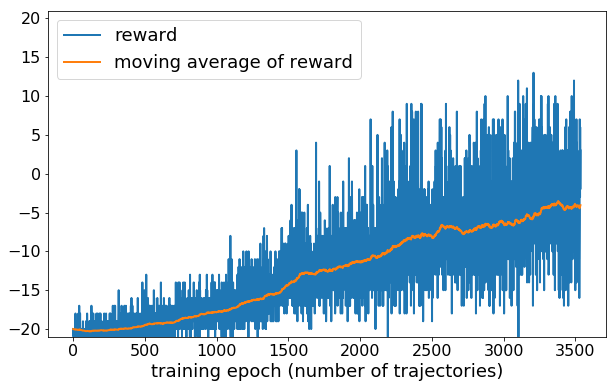

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

fontsize = 18
fontsize_tick = 16

fig = plt.figure(figsize=(10,6), facecolor='w')
ax = fig.add_subplot(111)
reward, = ax.plot(df['trajectory'], df['reward'], linewidth=2, label='reward')
reward_average, = ax.plot(df['trajectory'], df['<reward>'], linewidth=2, label='moving average of reward')
plt.legend(handles=[reward, reward_average], fontsize=fontsize)
ax.set_xlabel('training epoch (number of trajectories)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)
ax.set_ylim(-21, 21)

And here is a clip of the trained agent playing pong against the game simulator. The trained AI eventually wins, i.e. reaches 21 points first. (Use `test.sh` at the command line if you want to see the entire trajectory.) Not bad for 4 hours of training without the help of GPUs!


[2017-09-19 16:24:39,820] Making new env: Pong-v0



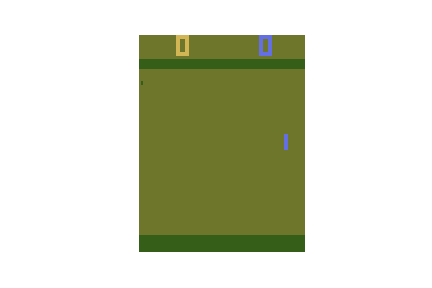
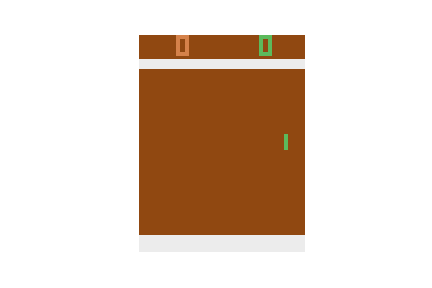
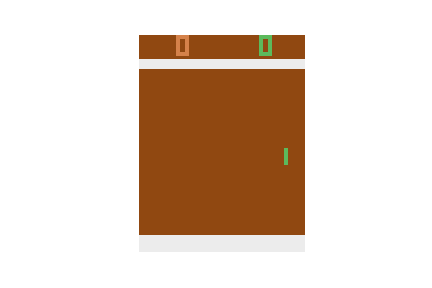
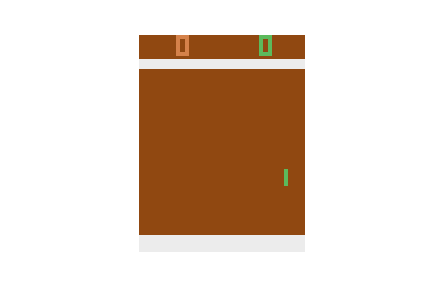
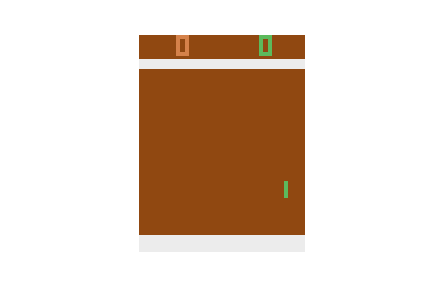
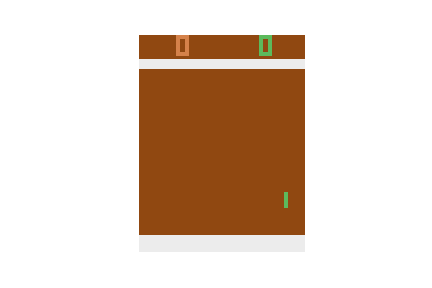
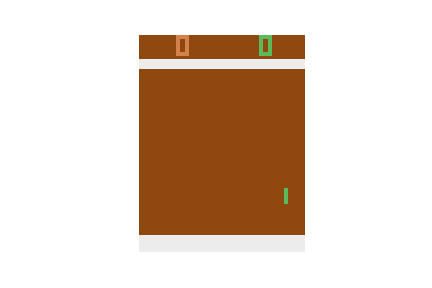
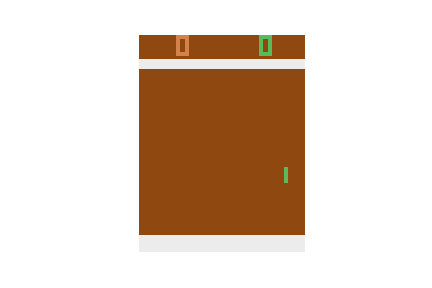
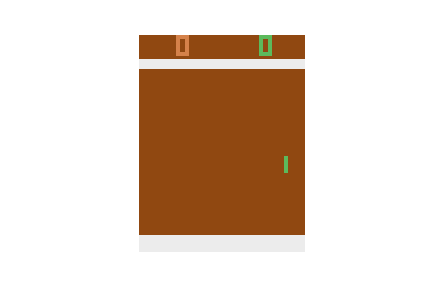
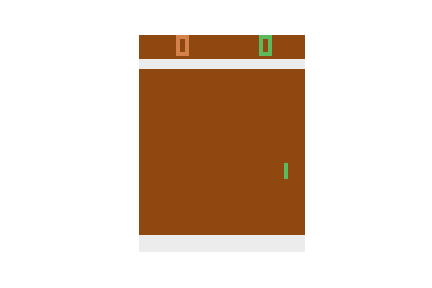
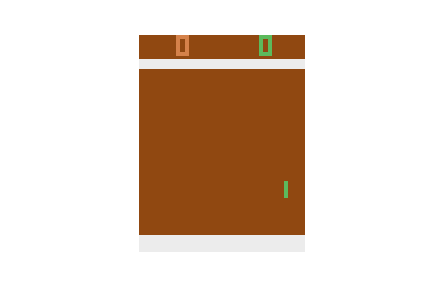
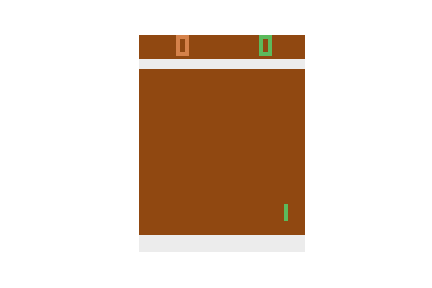
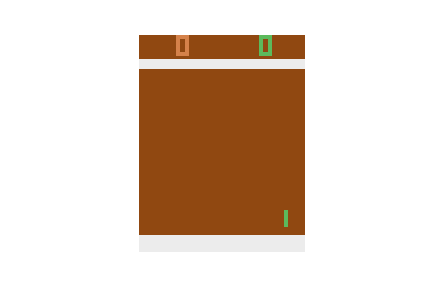
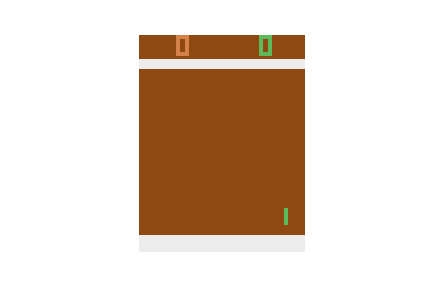
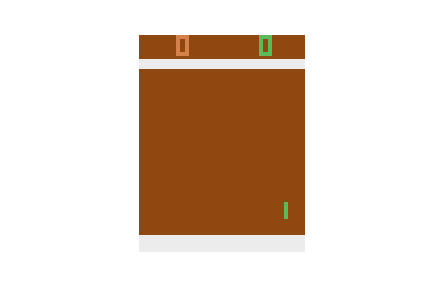
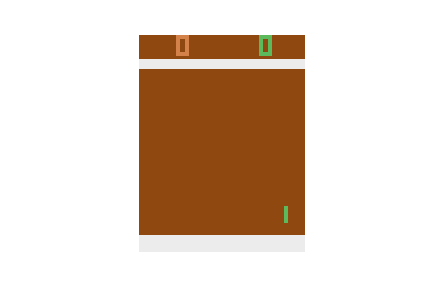
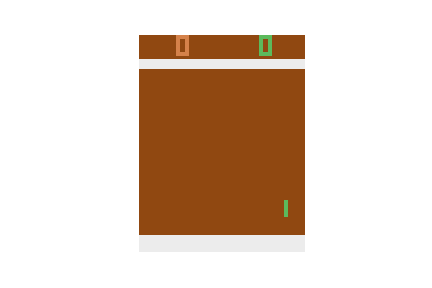
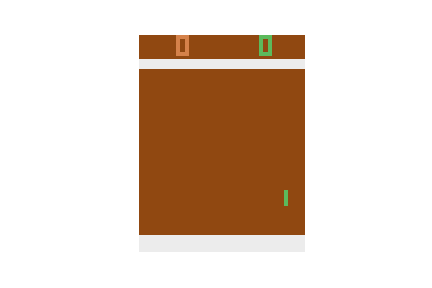
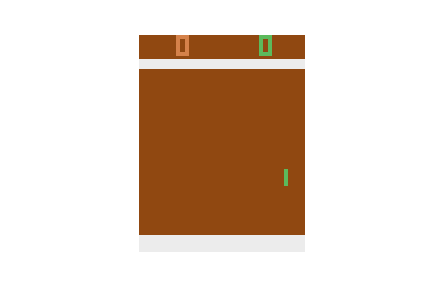
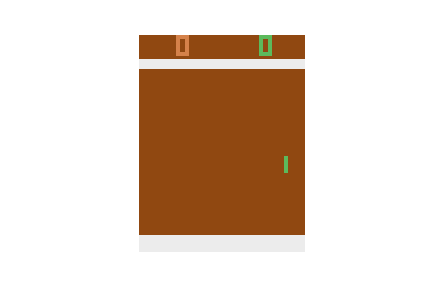
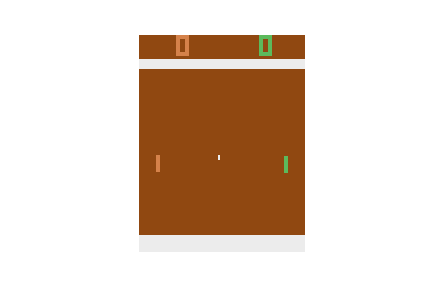
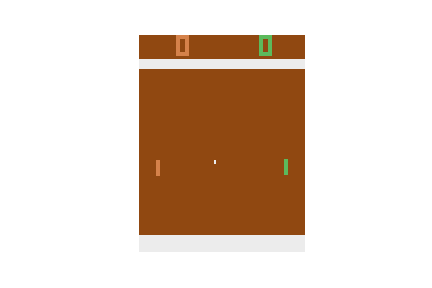
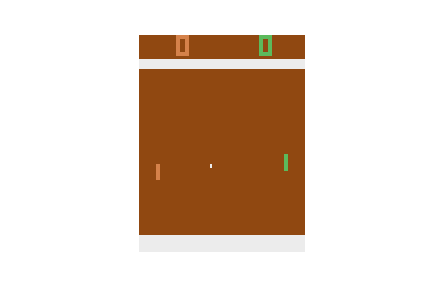
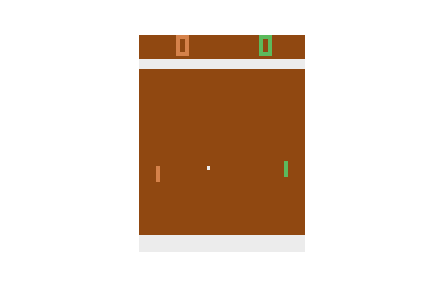
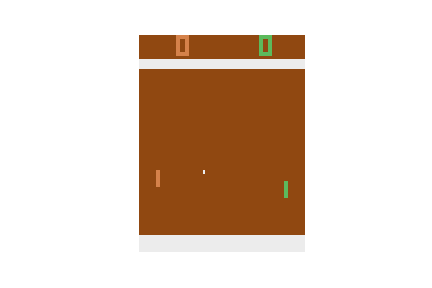
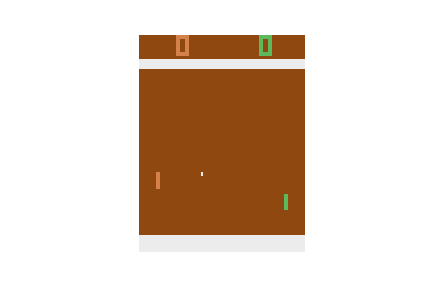
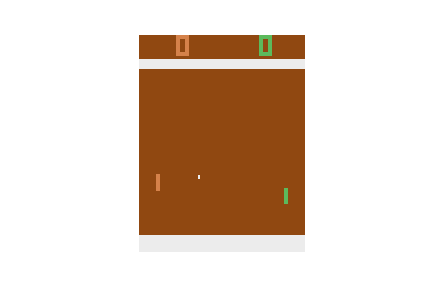
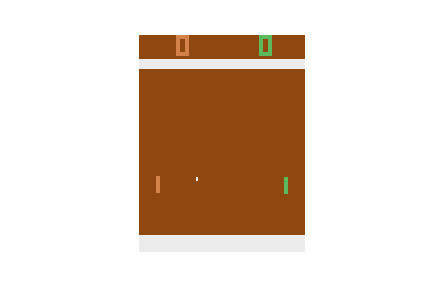
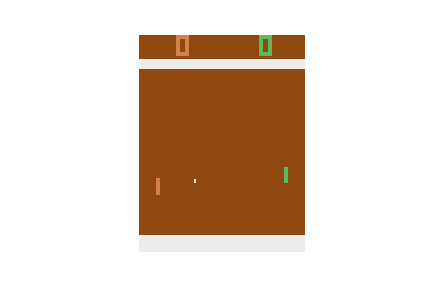
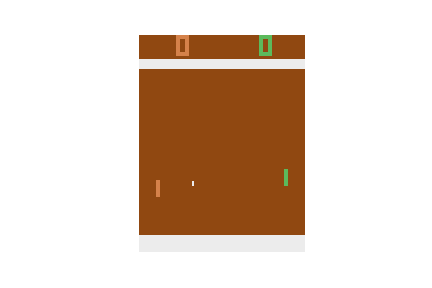
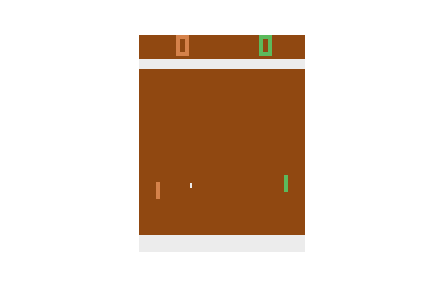
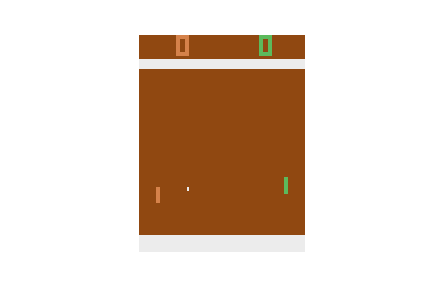
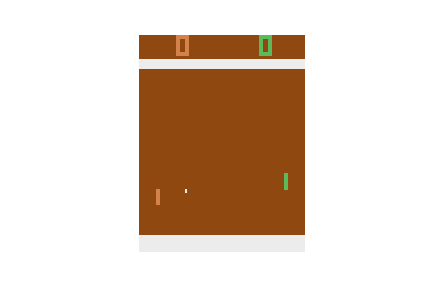
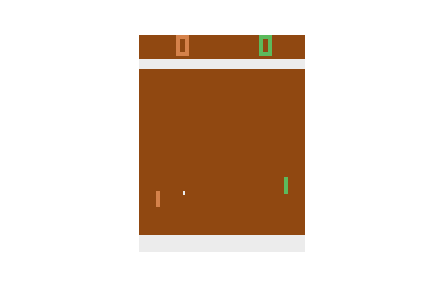
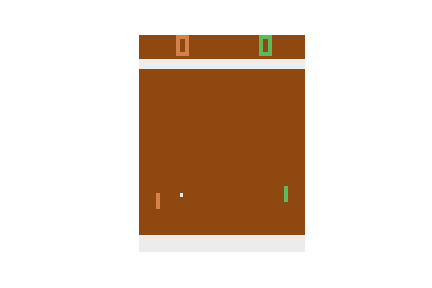
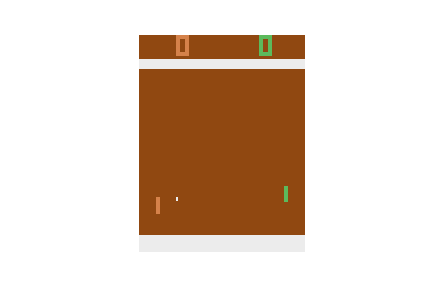
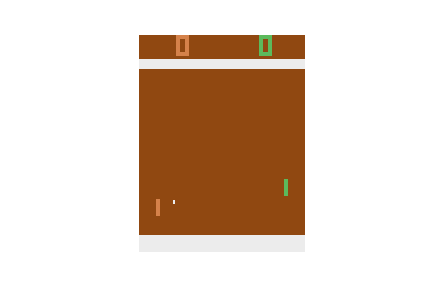
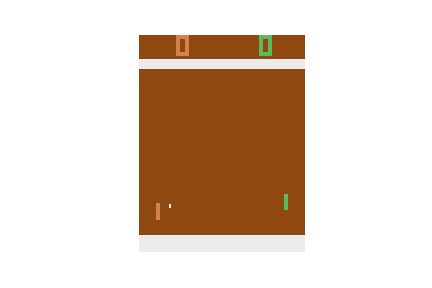
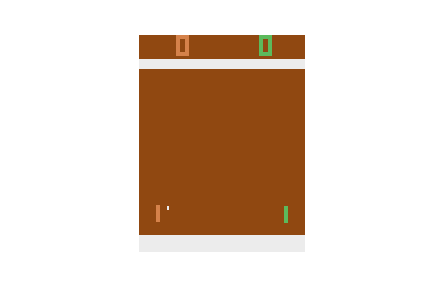
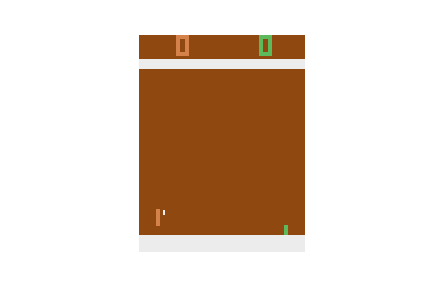
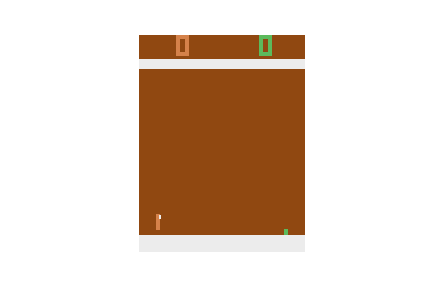
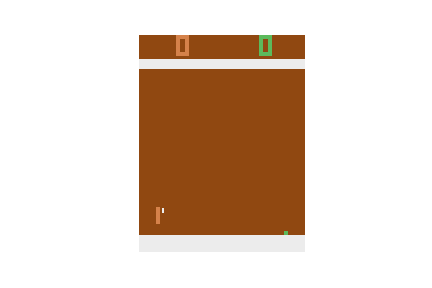
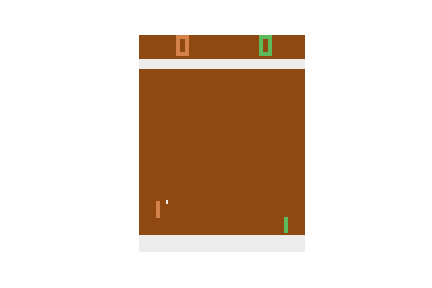
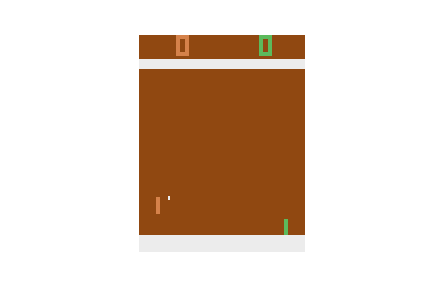
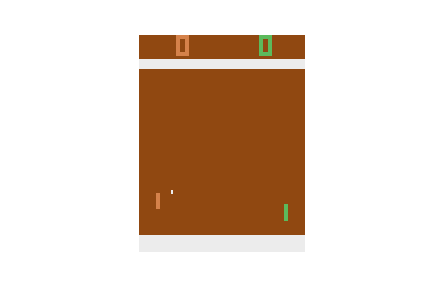
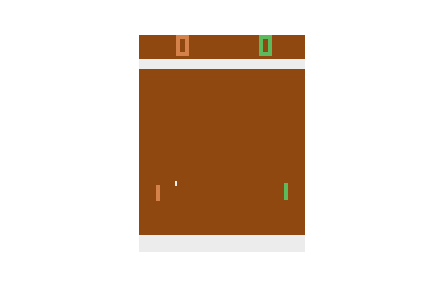
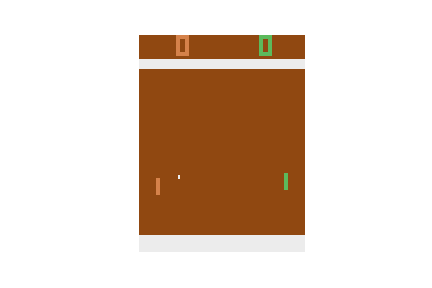
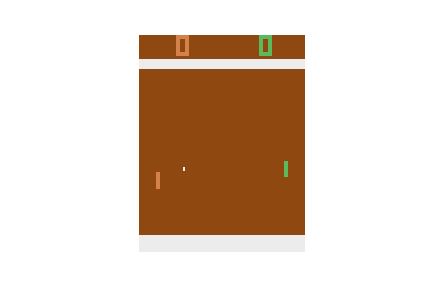
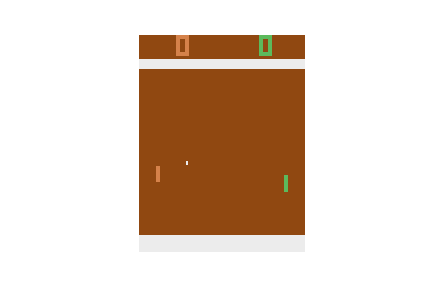
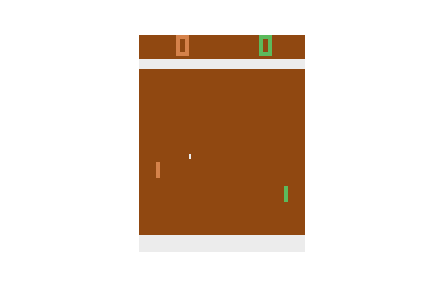
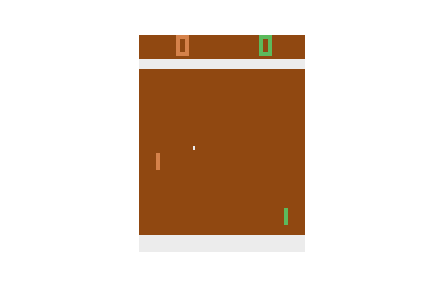
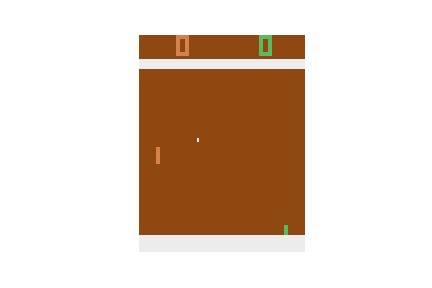
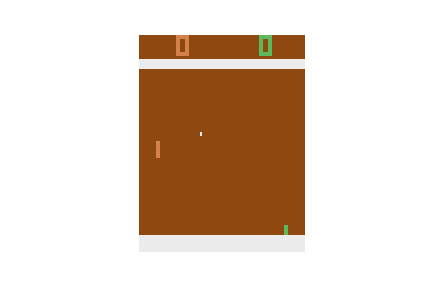
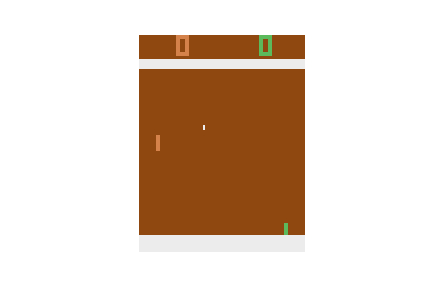
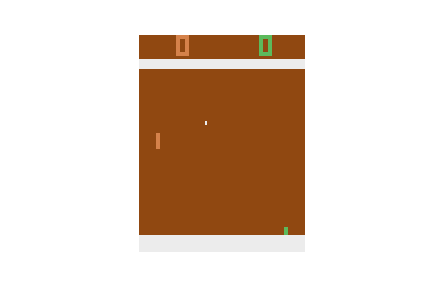
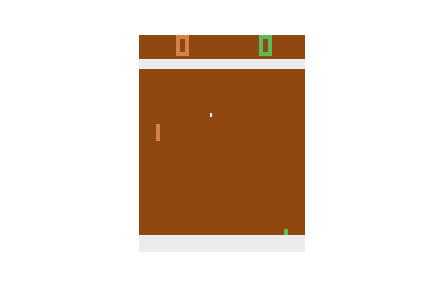
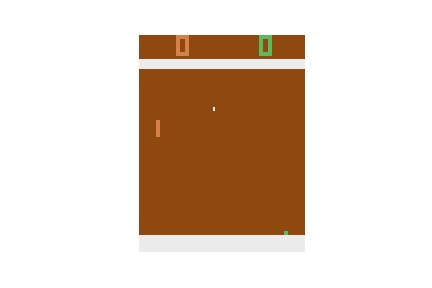
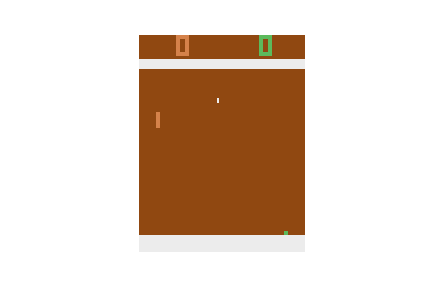
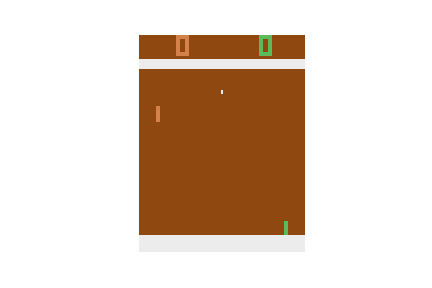
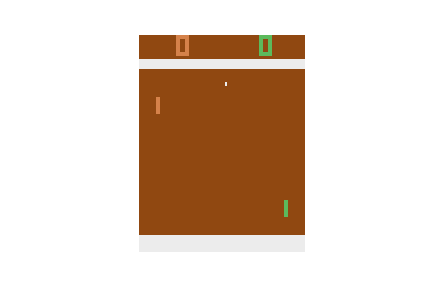
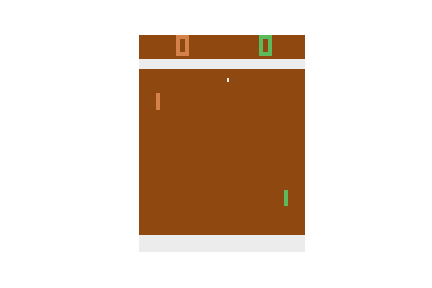
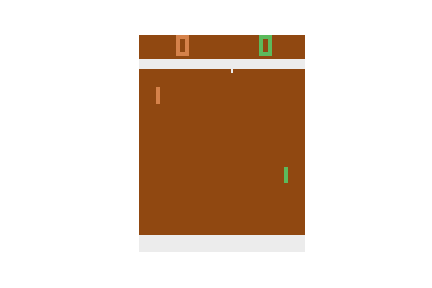
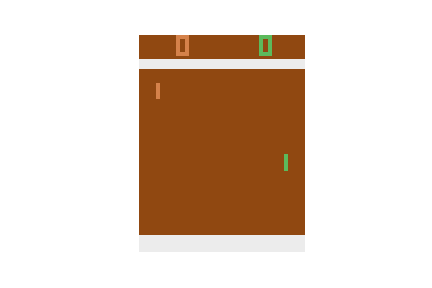
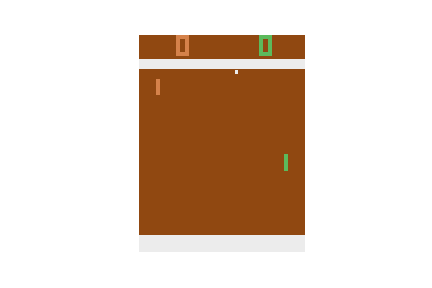
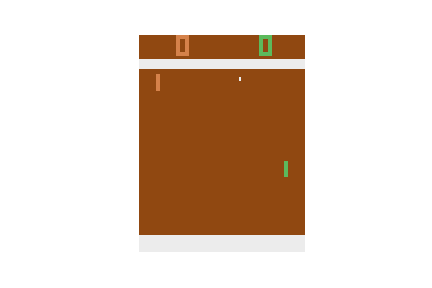
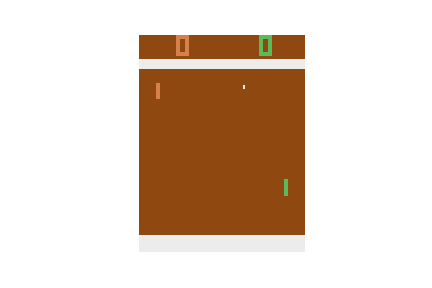
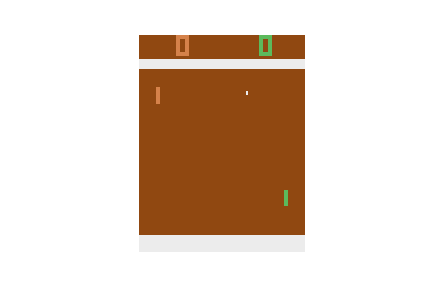
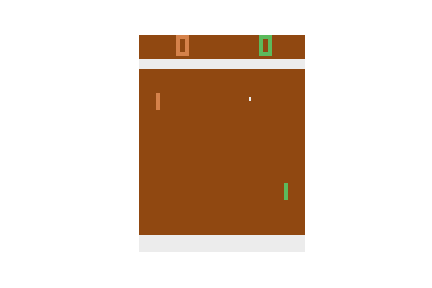
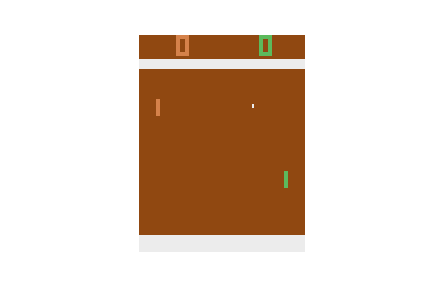
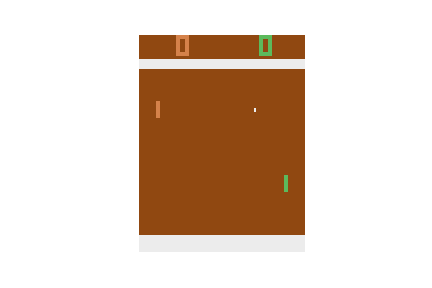
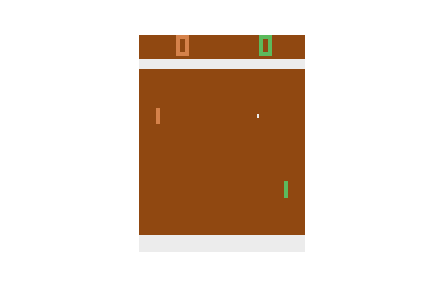
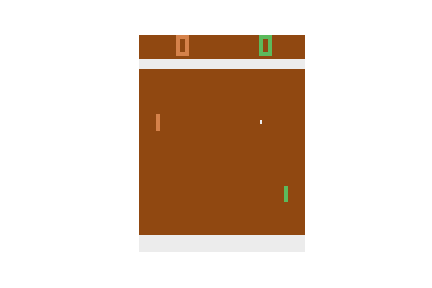
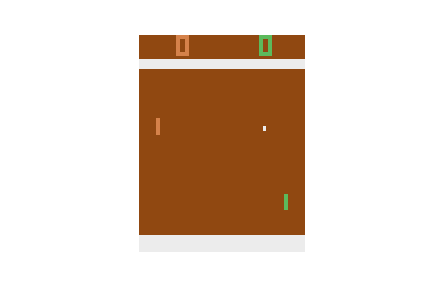
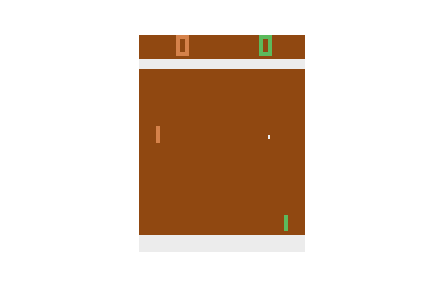
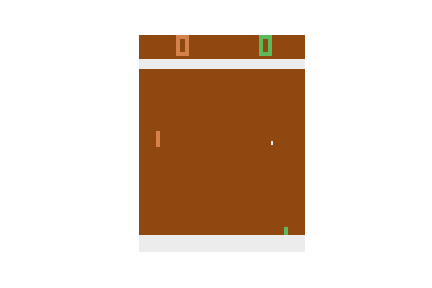
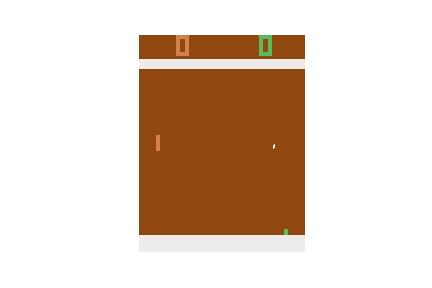
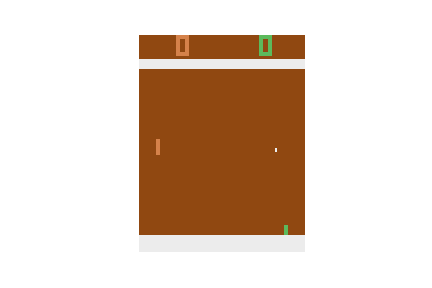
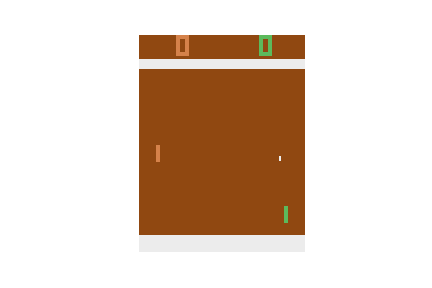
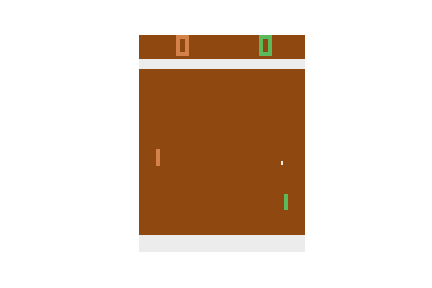
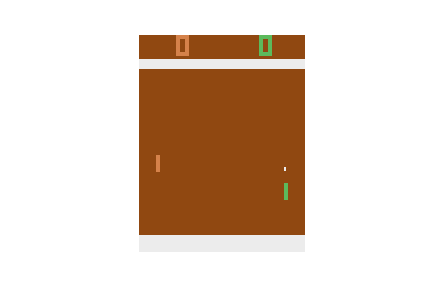
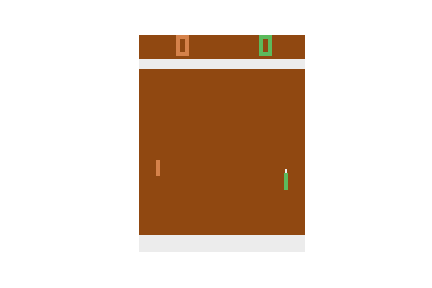
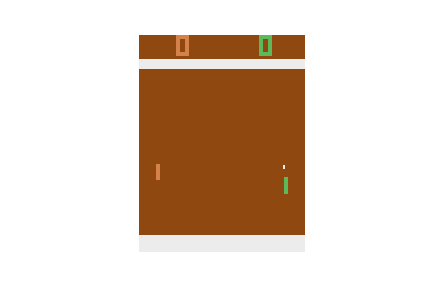
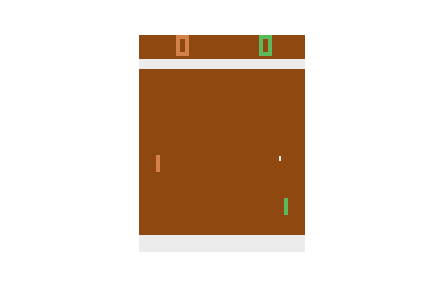
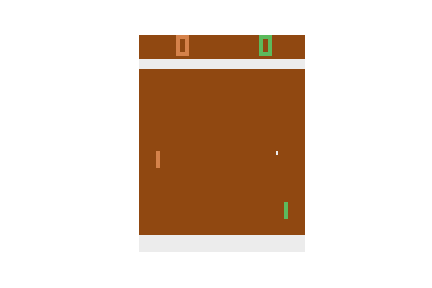
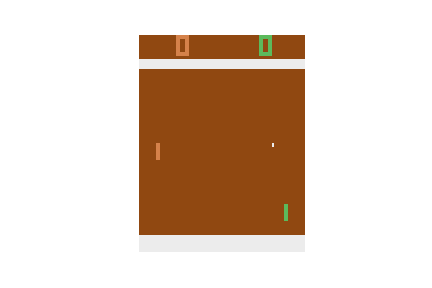
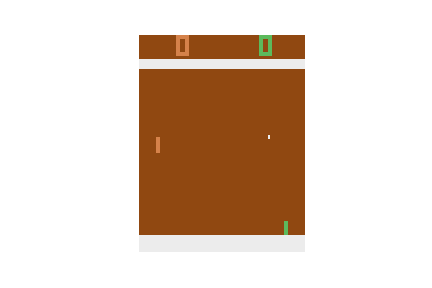
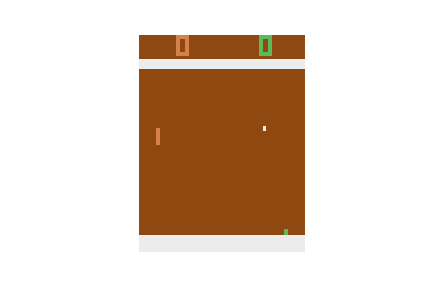
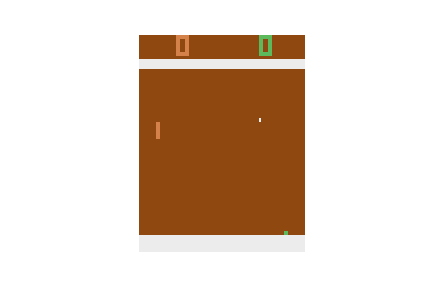
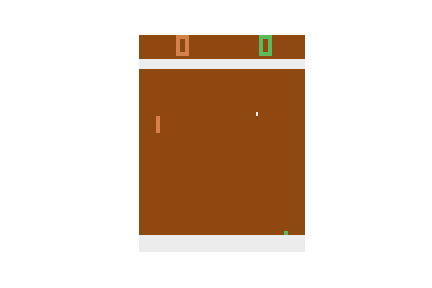
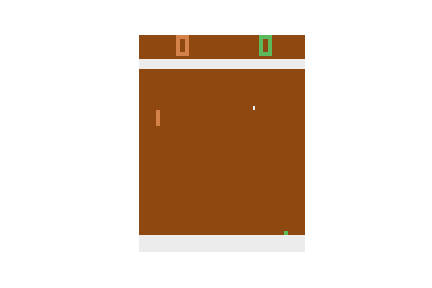
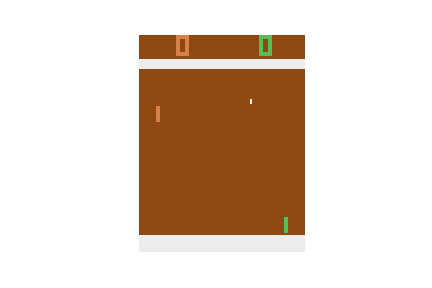
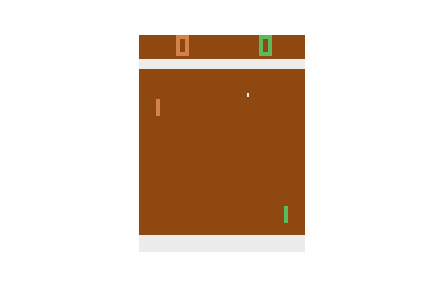
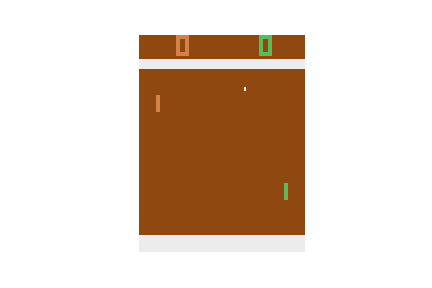
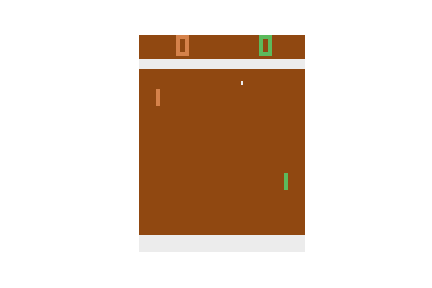
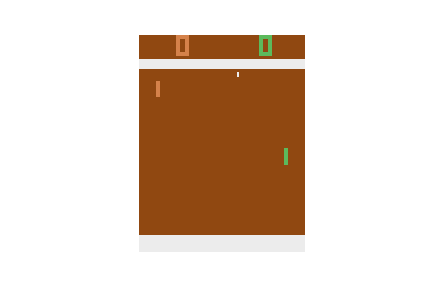
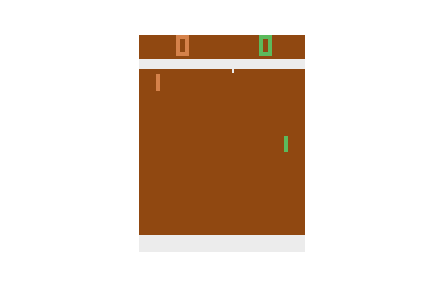
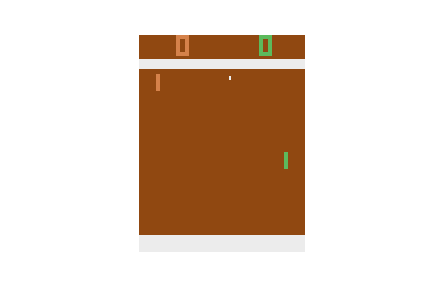
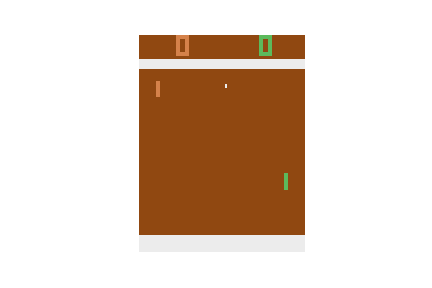
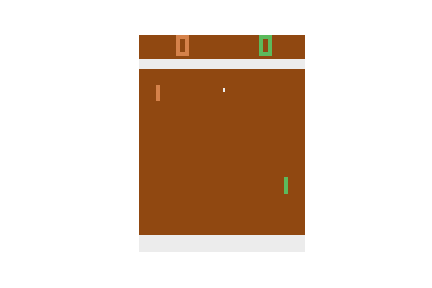
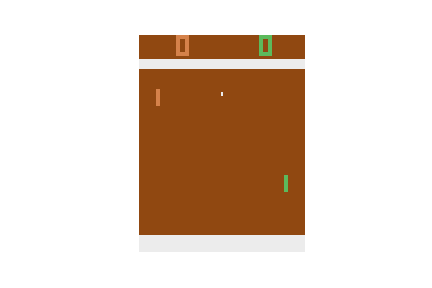
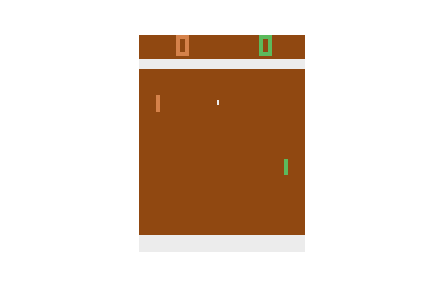
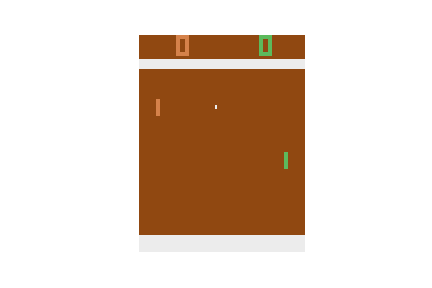
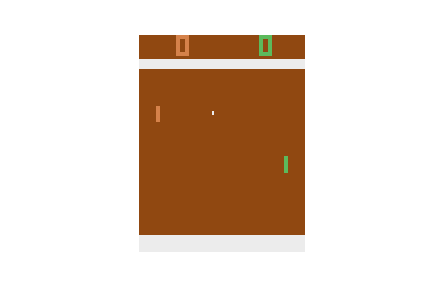
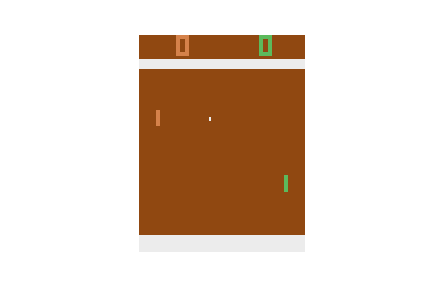
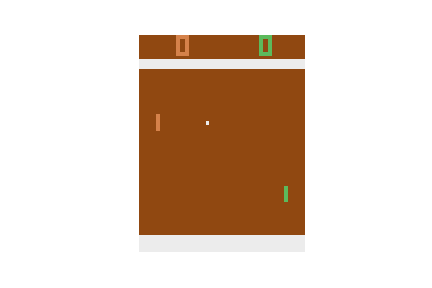
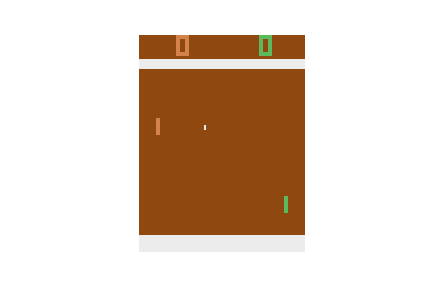
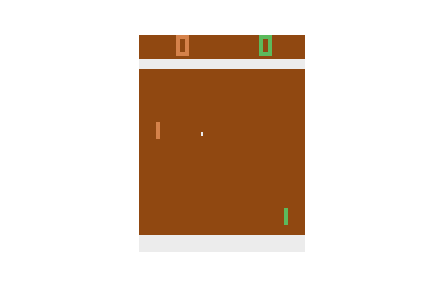
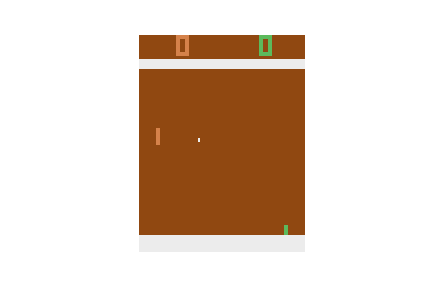
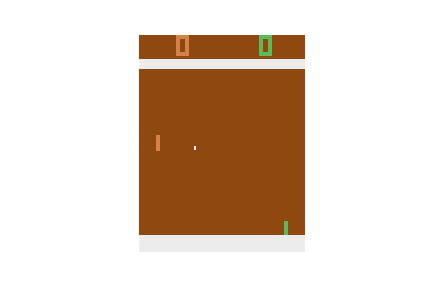
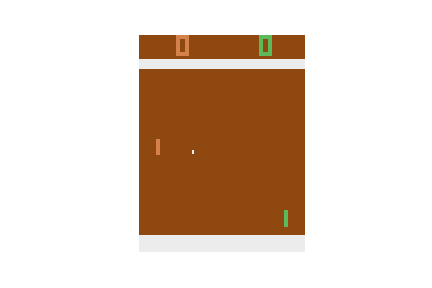
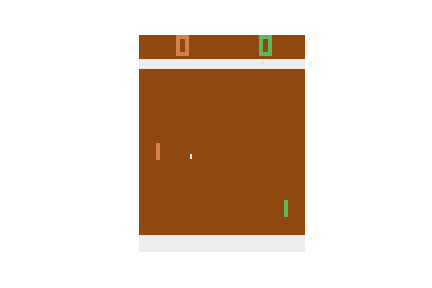
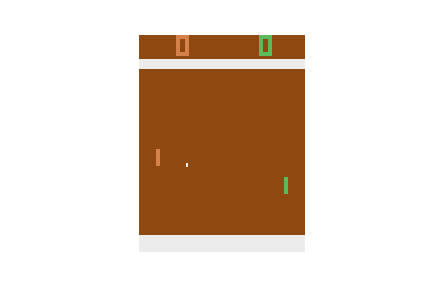
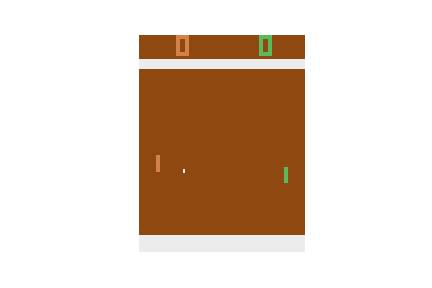
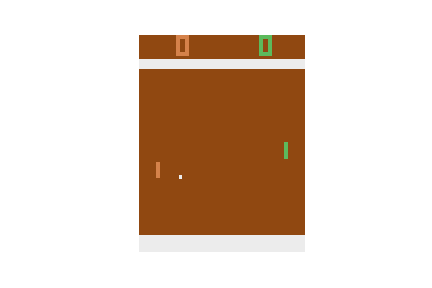
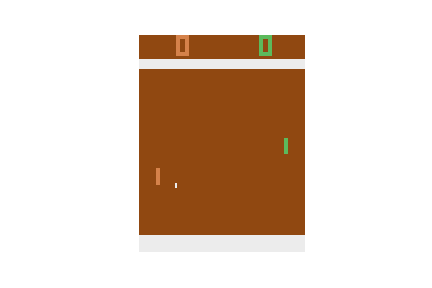
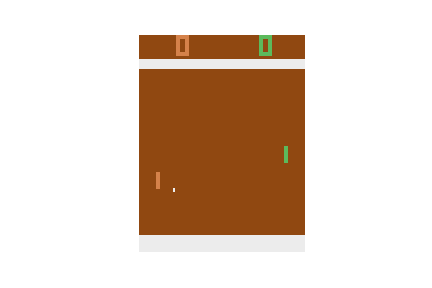
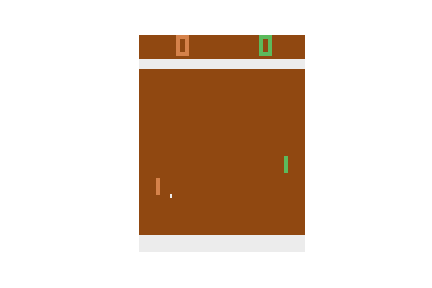
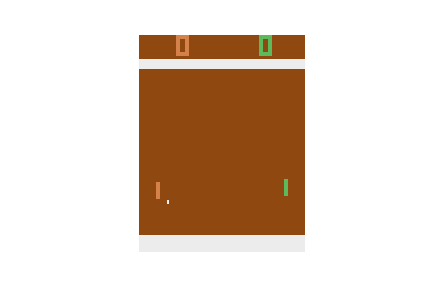
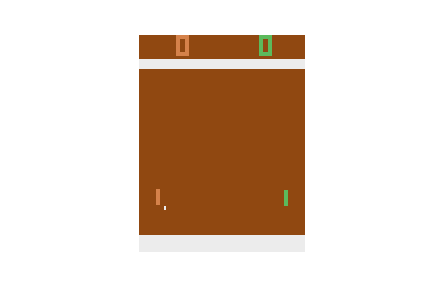
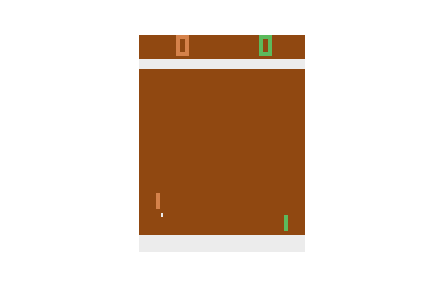
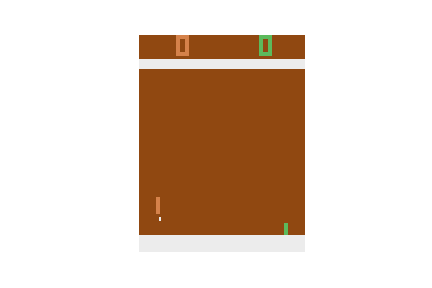
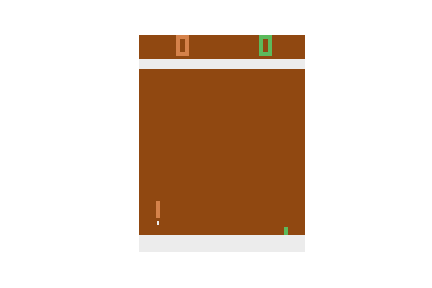
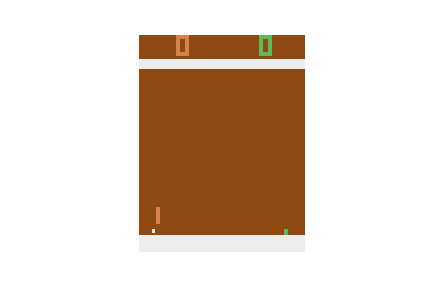
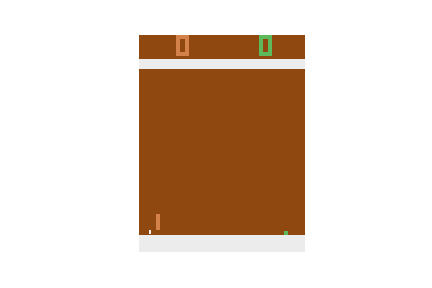
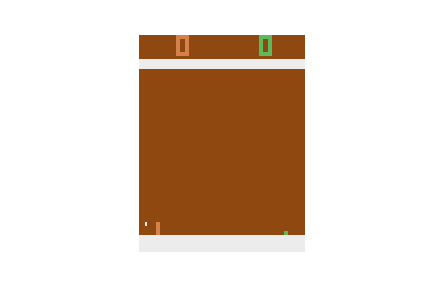
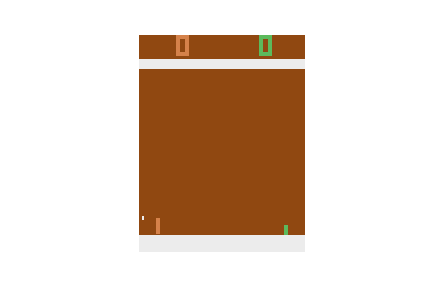
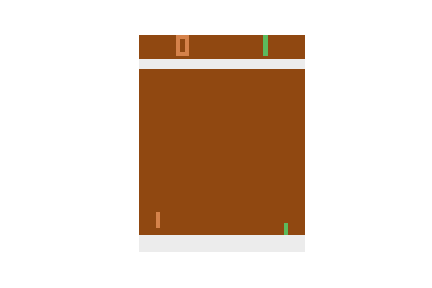
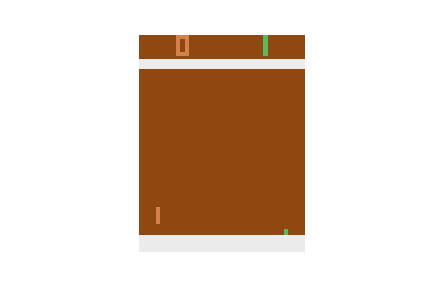
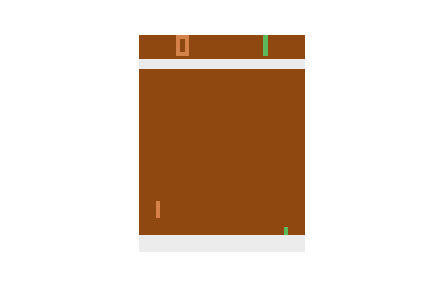
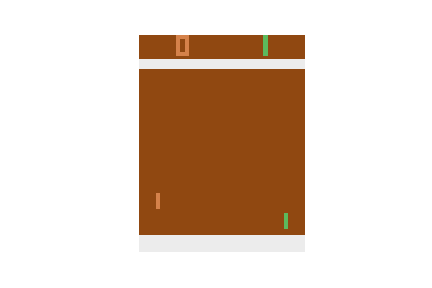
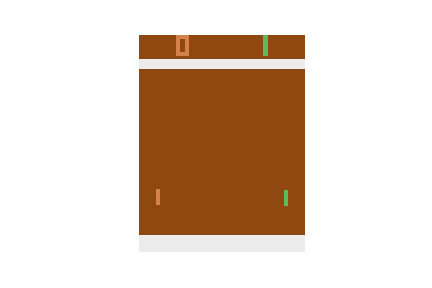
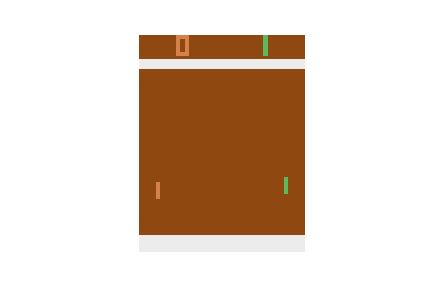
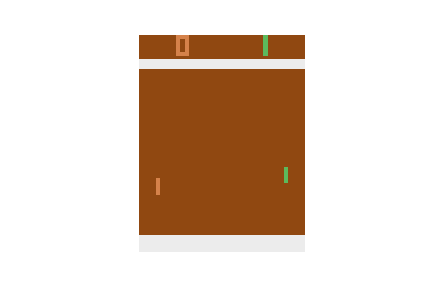
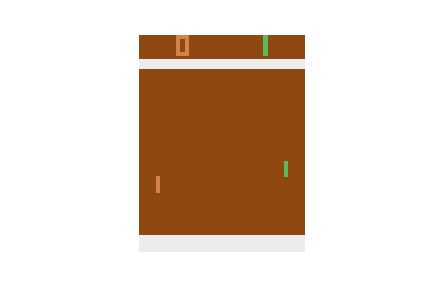
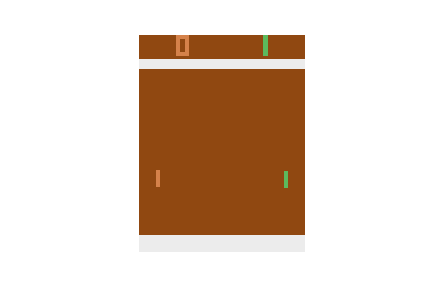
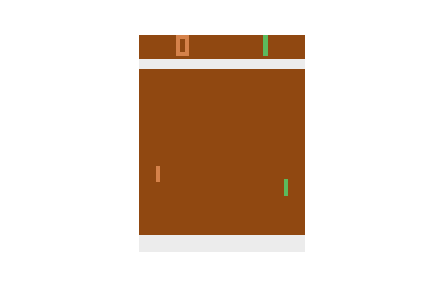
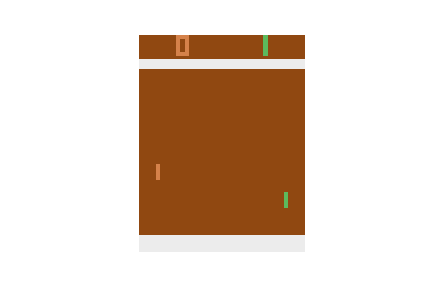
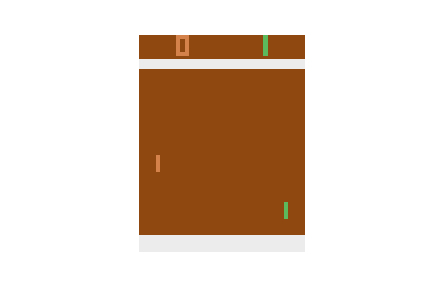
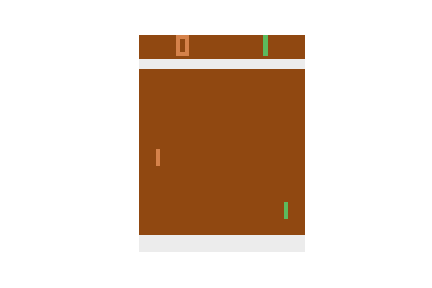
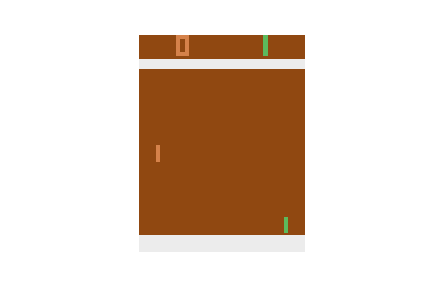
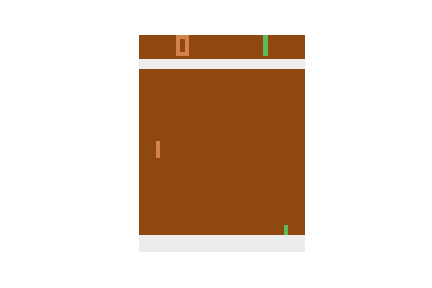
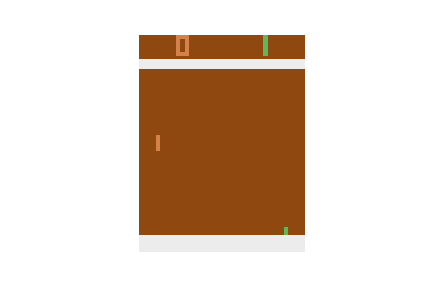
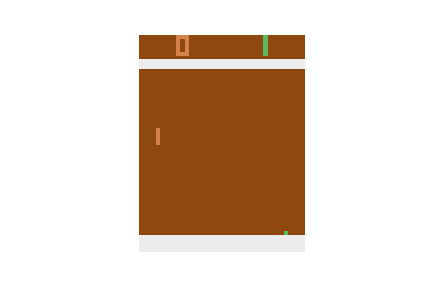
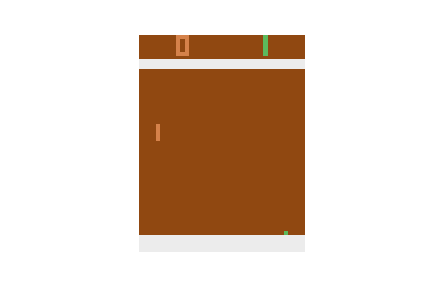
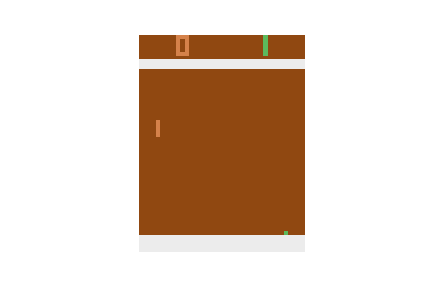
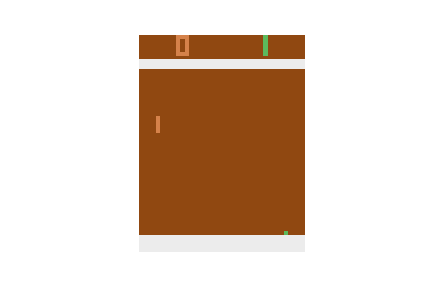
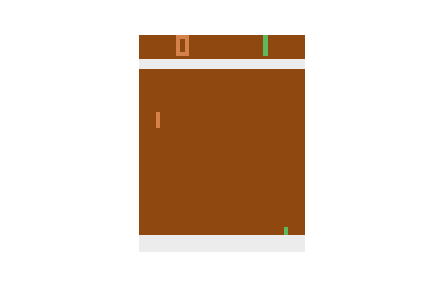
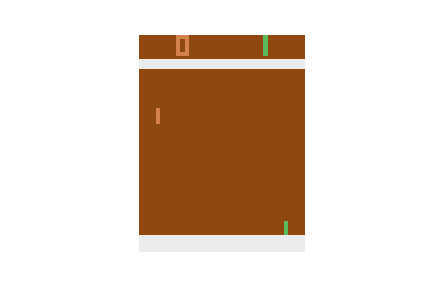
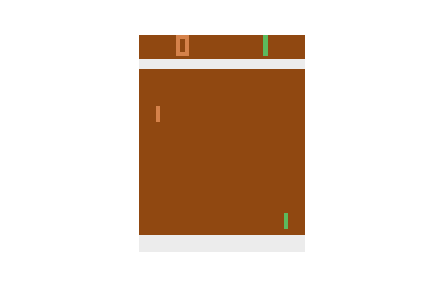
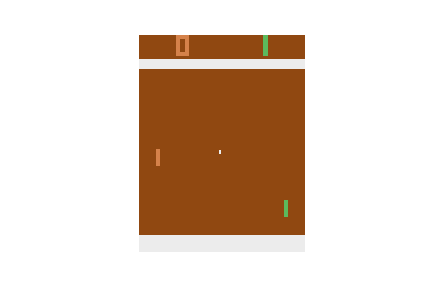
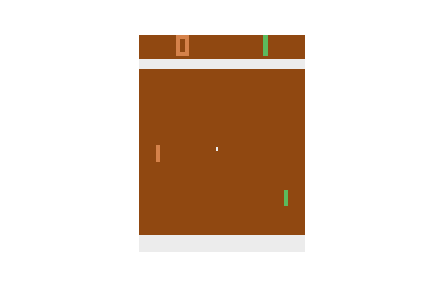
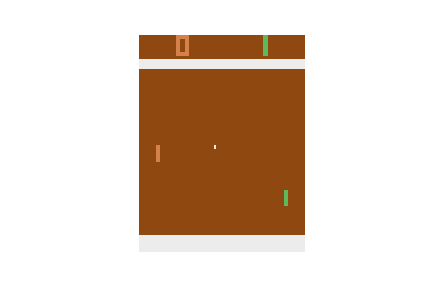
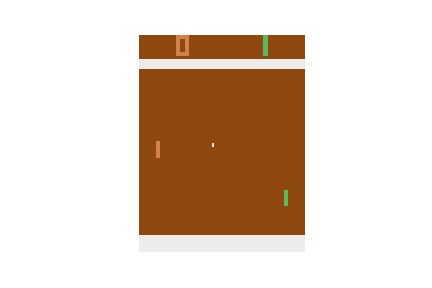
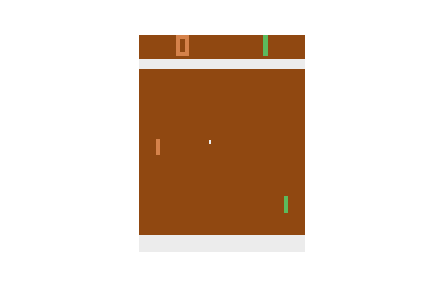
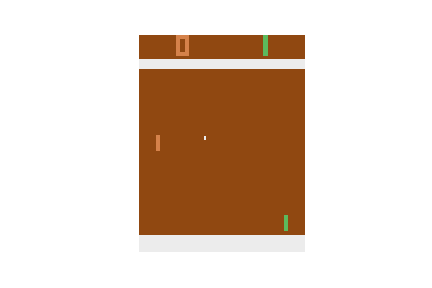
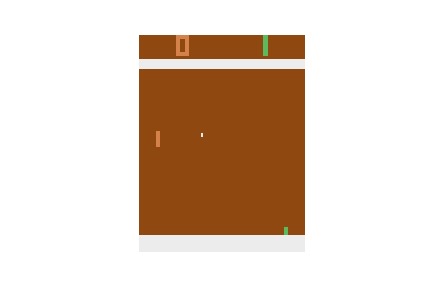
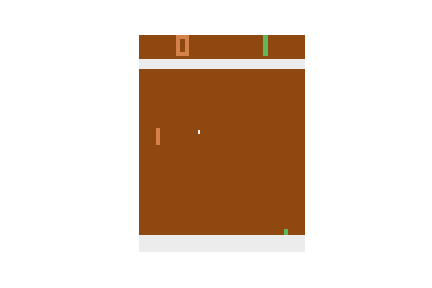
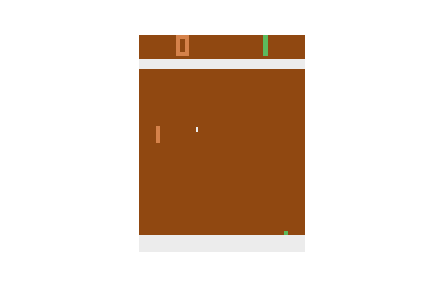
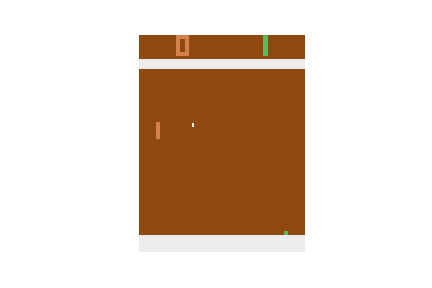
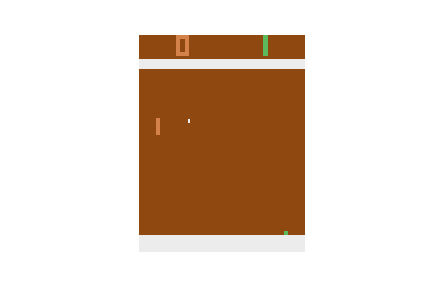
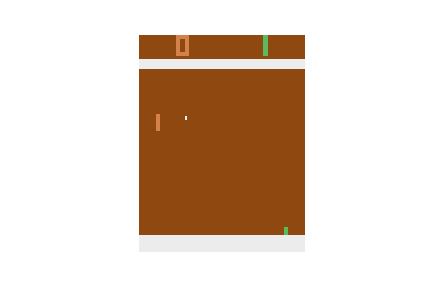
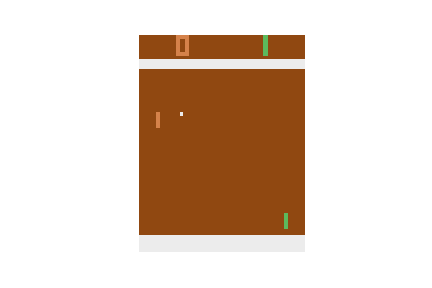
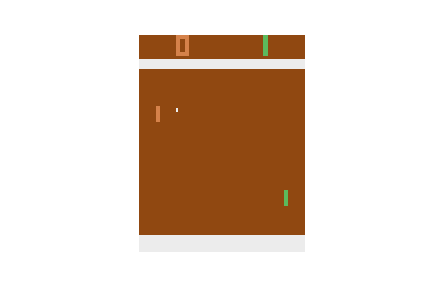
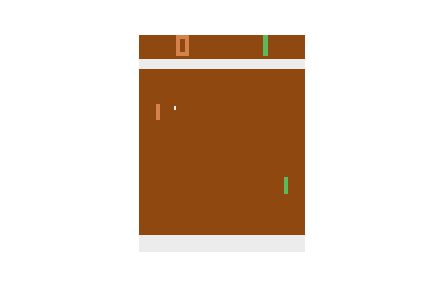
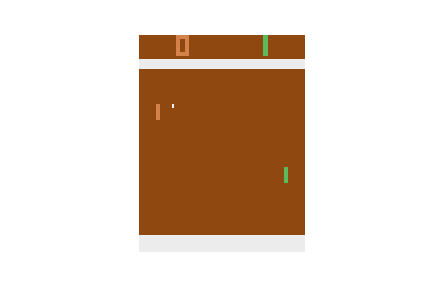
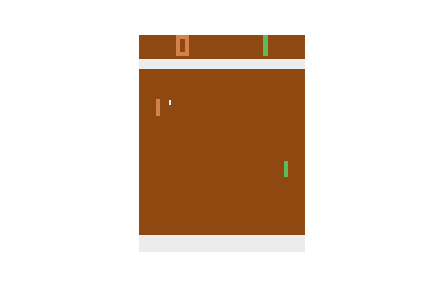
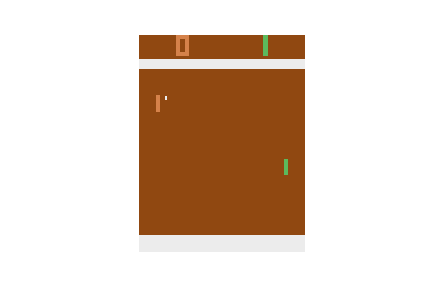
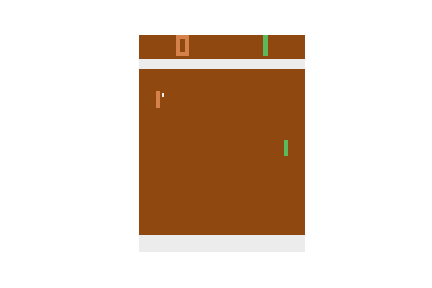
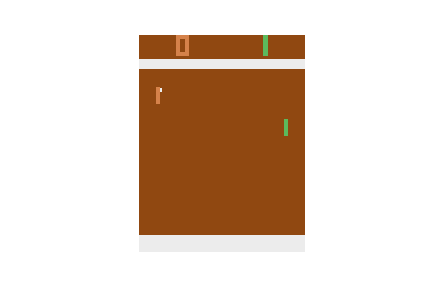
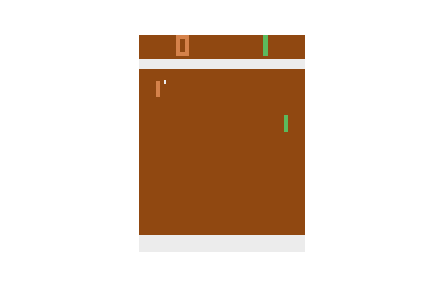
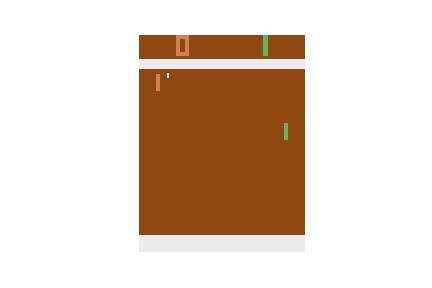
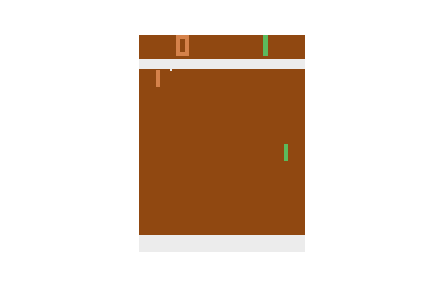
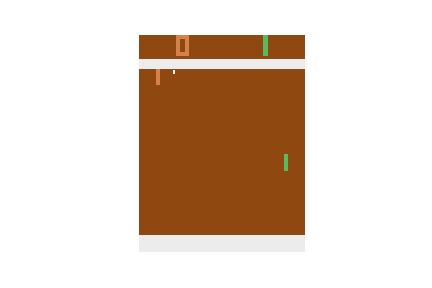
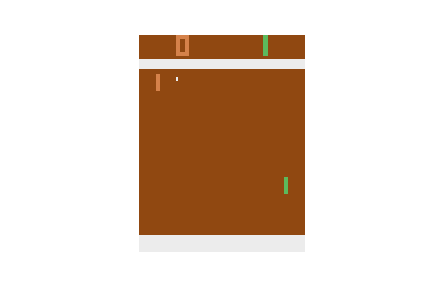
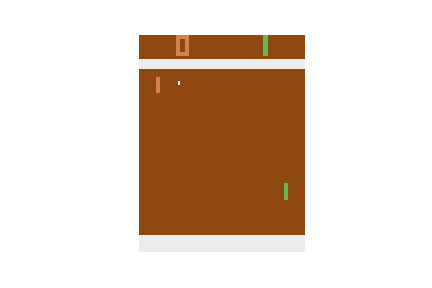
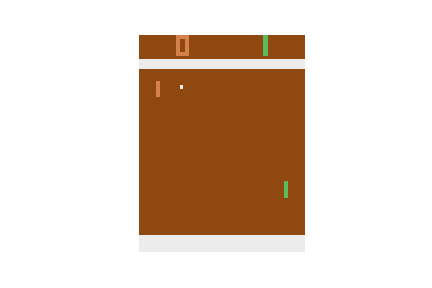
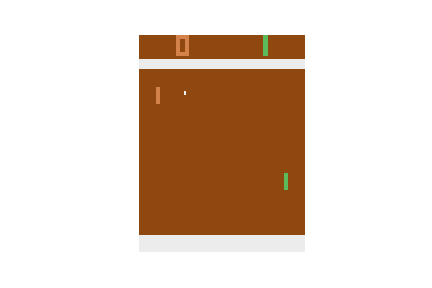
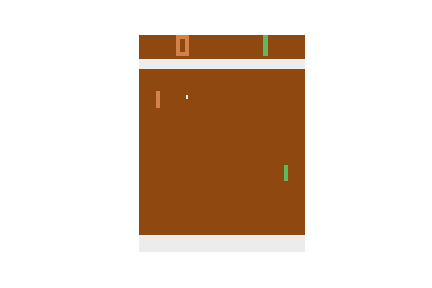
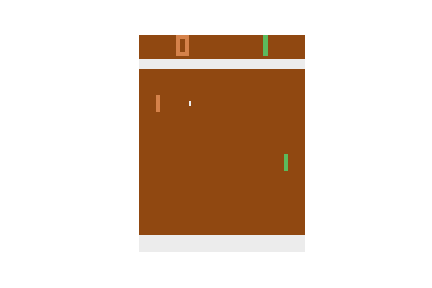
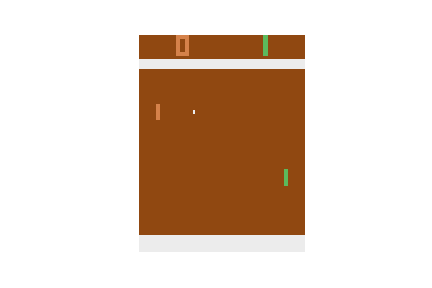
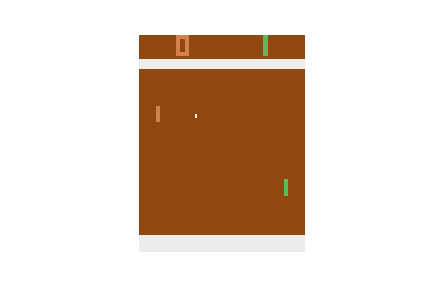
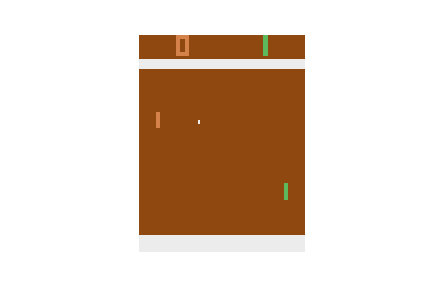
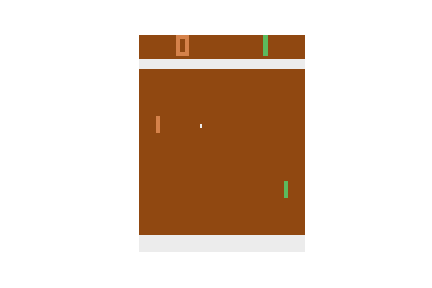
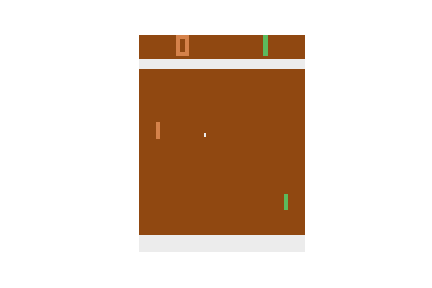
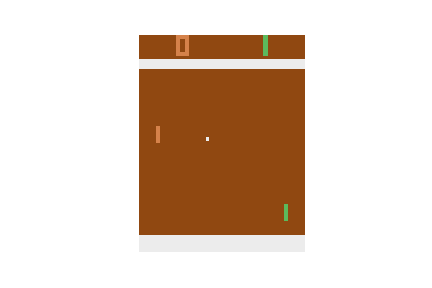
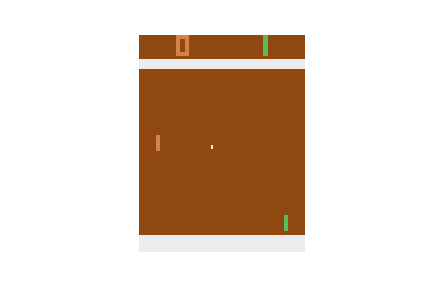
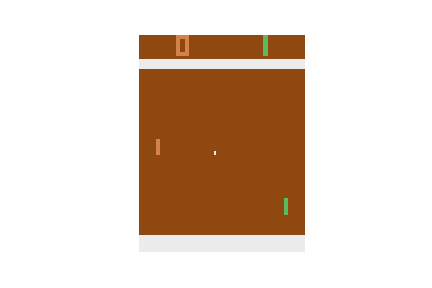
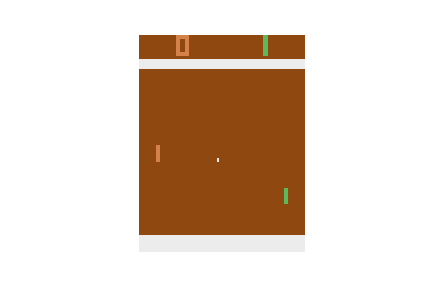
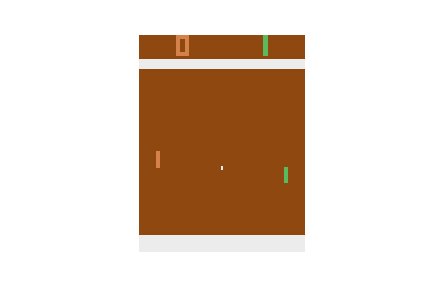
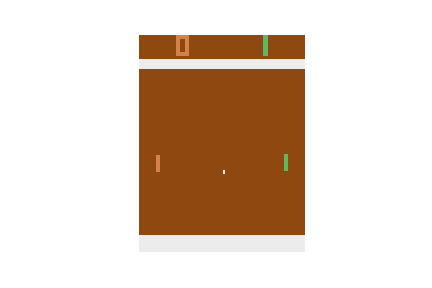
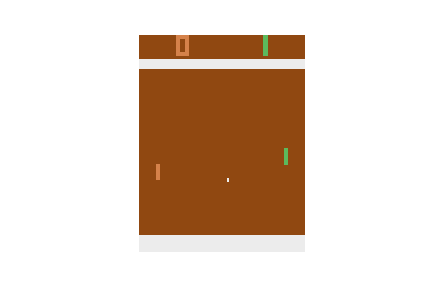
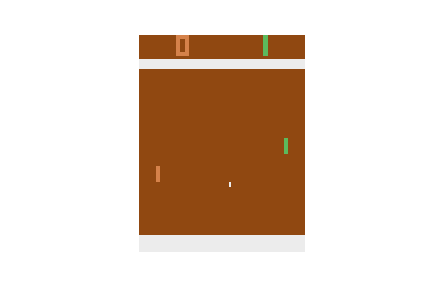
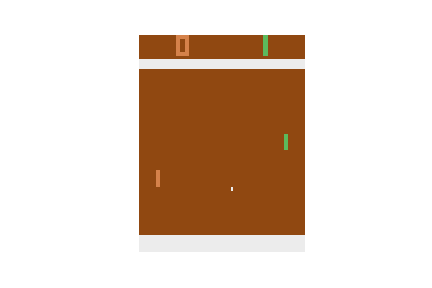
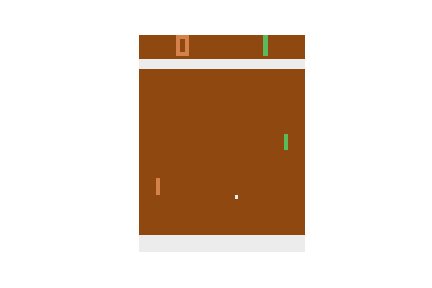
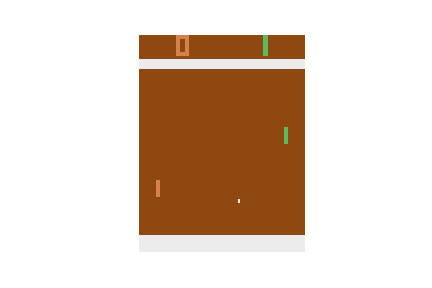
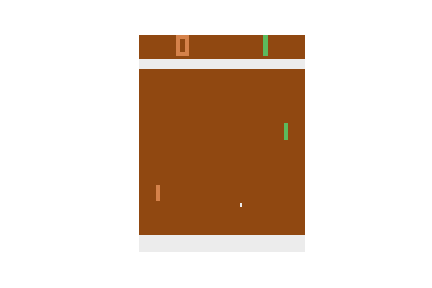
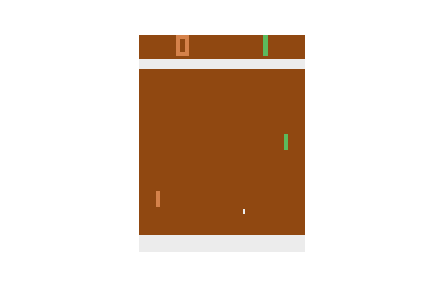
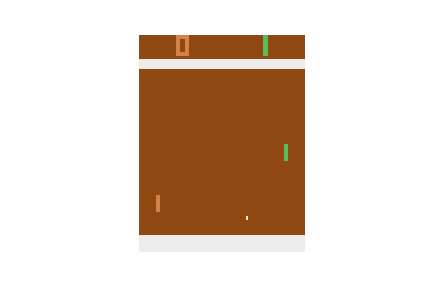
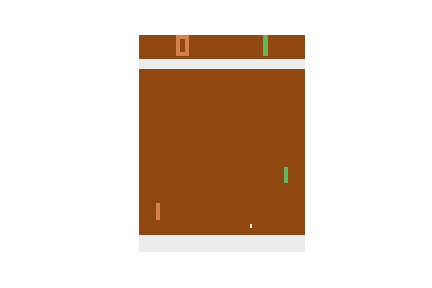
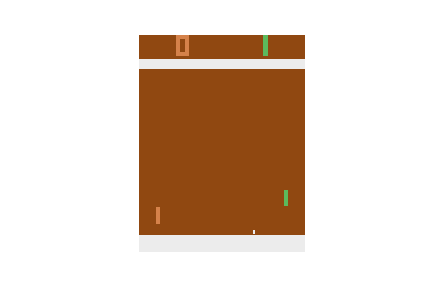
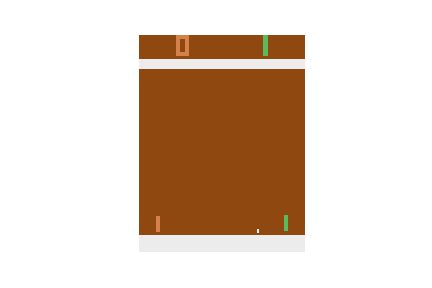
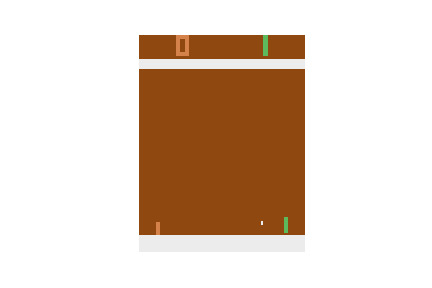
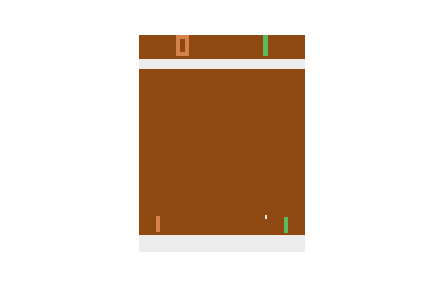
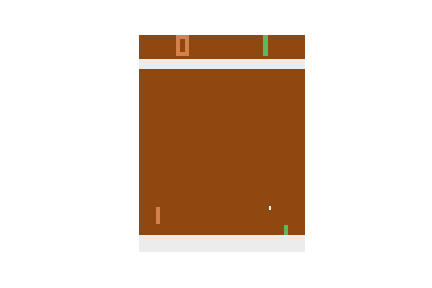
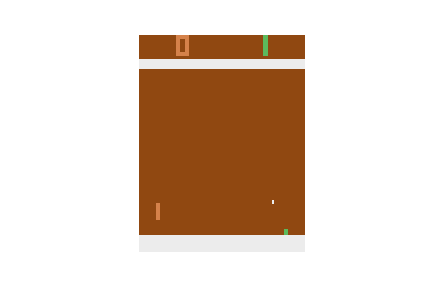
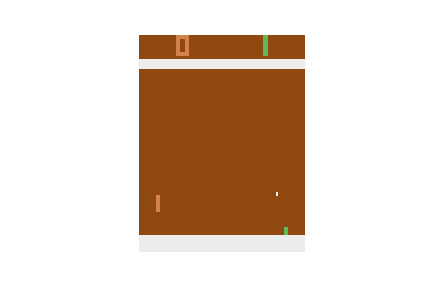
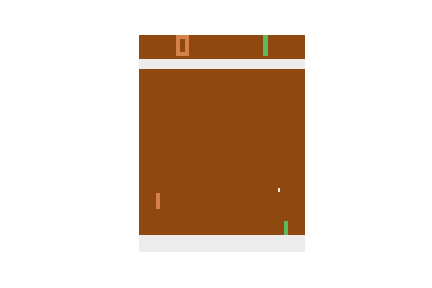
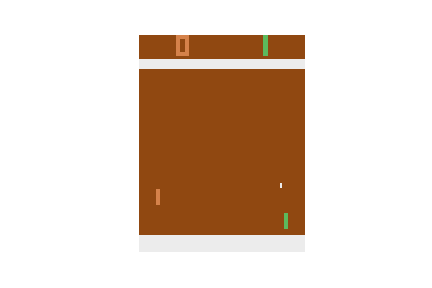
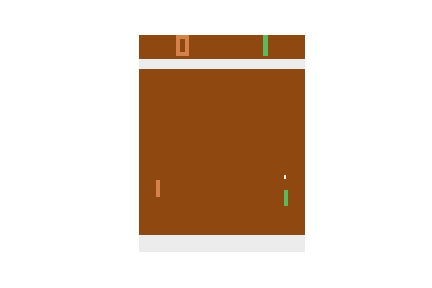
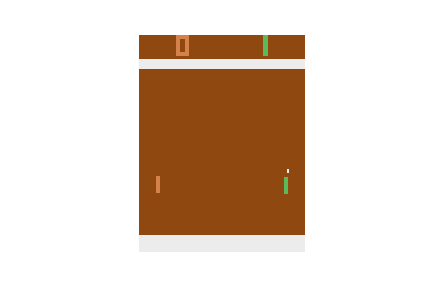
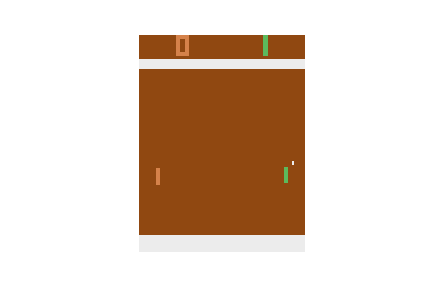
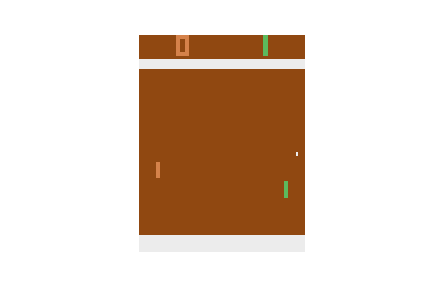
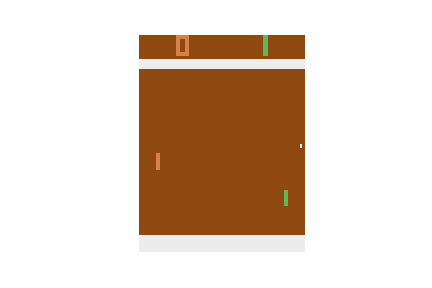
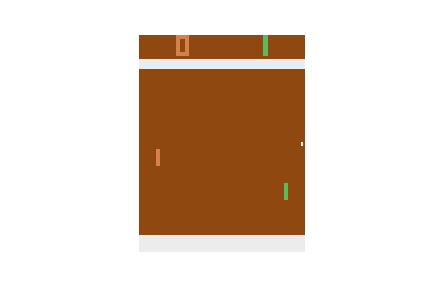
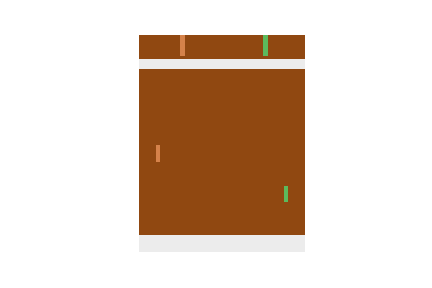
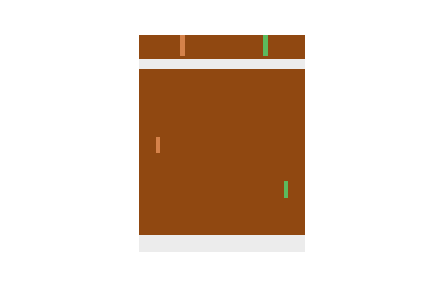
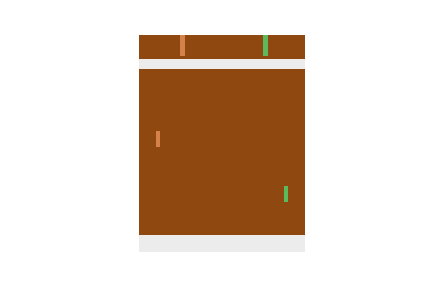
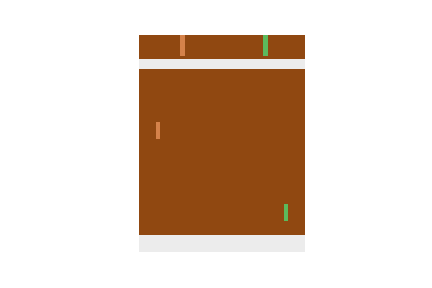
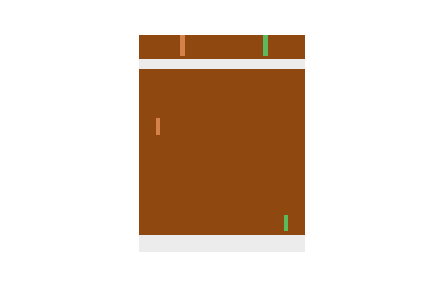
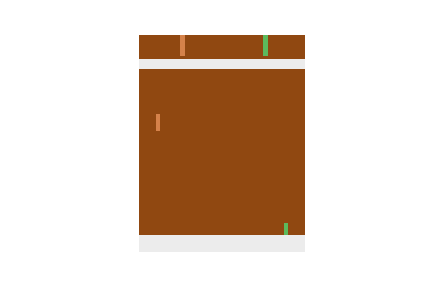
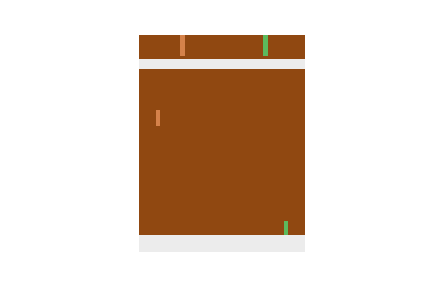
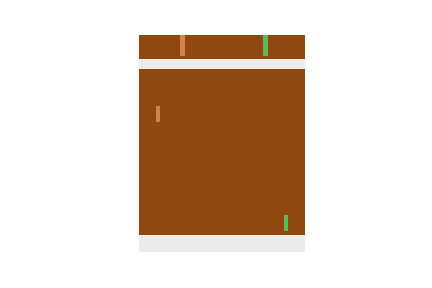
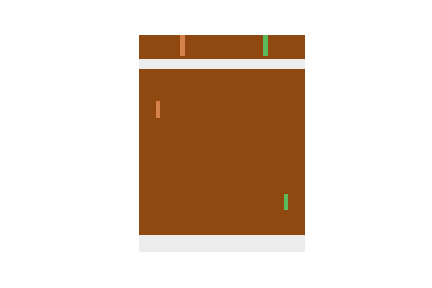
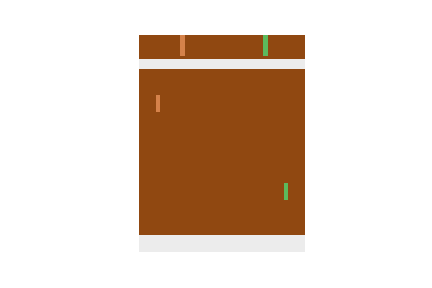
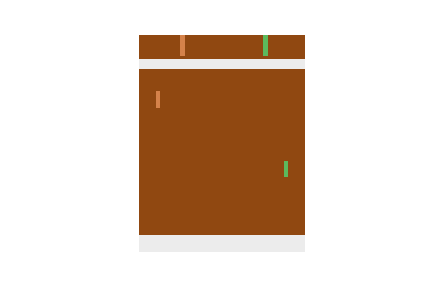
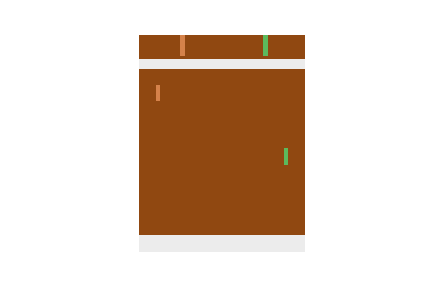
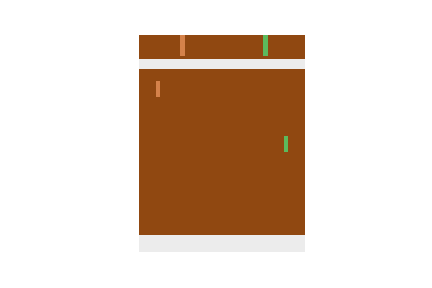
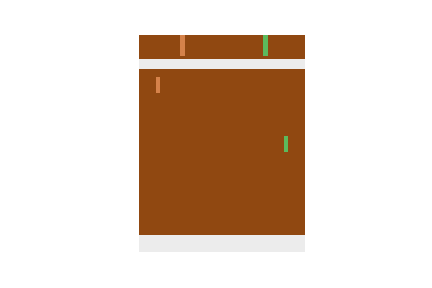
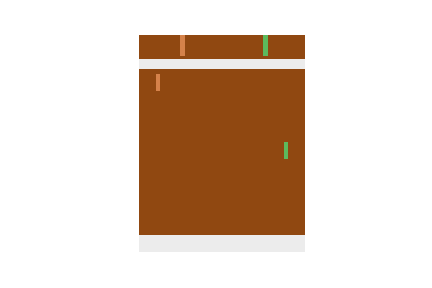
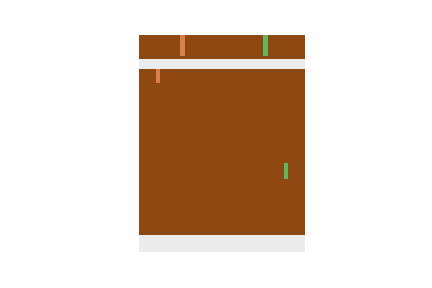
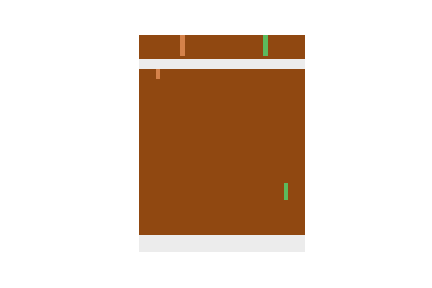
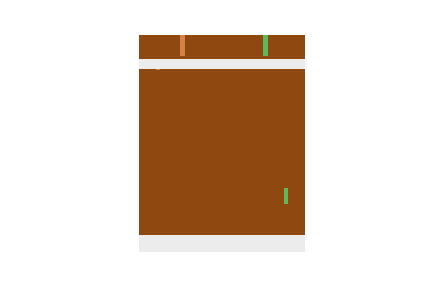
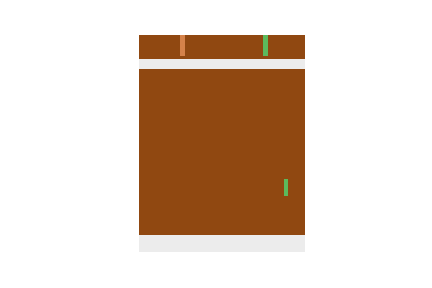
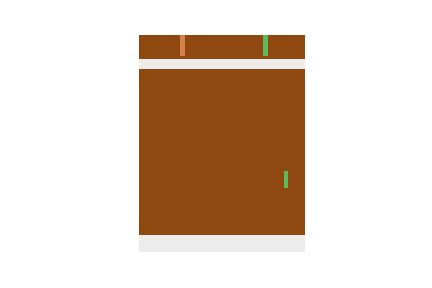
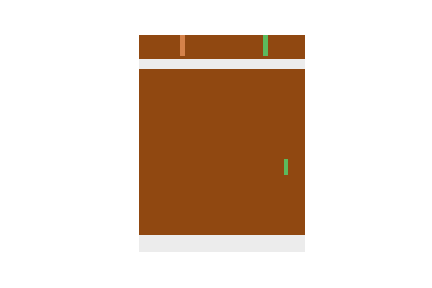
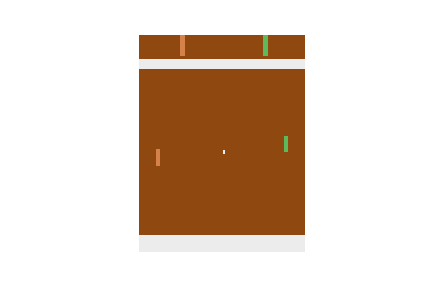
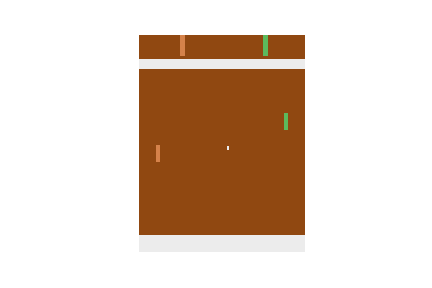
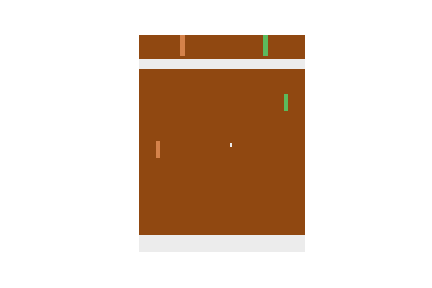
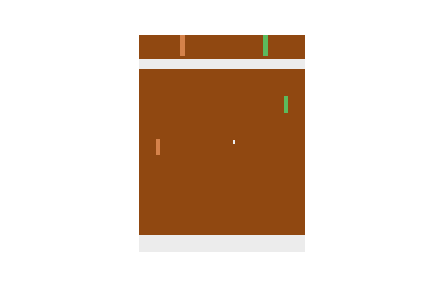
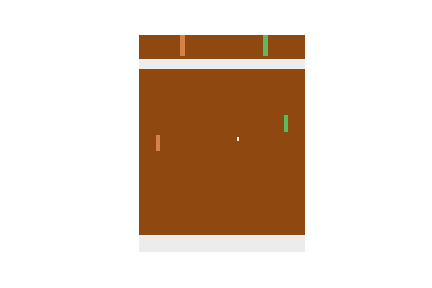
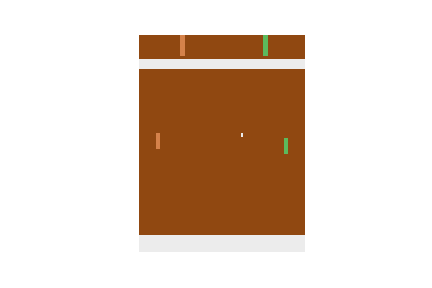
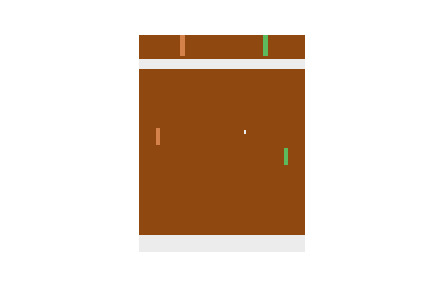
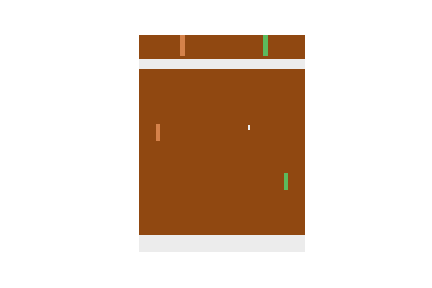
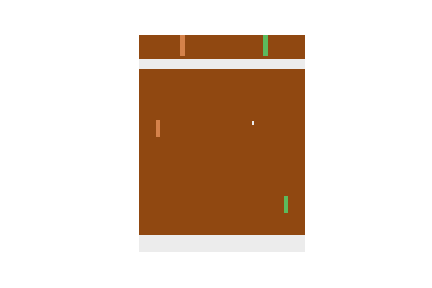
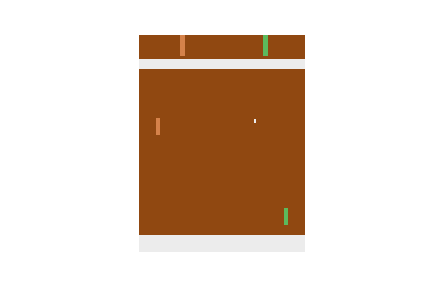
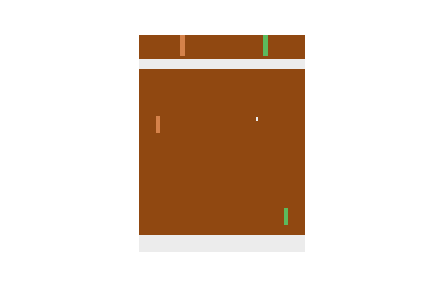
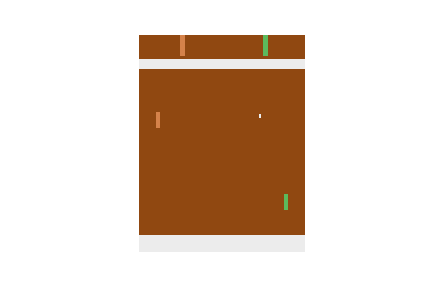
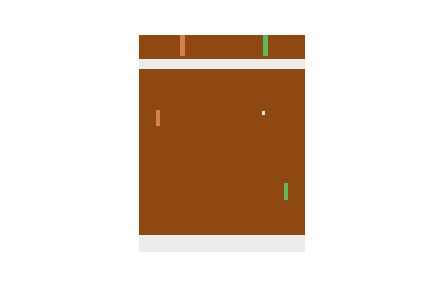
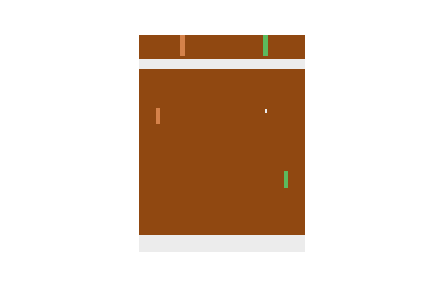
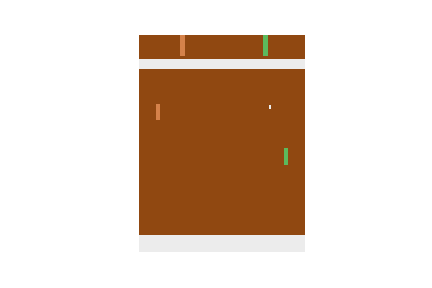
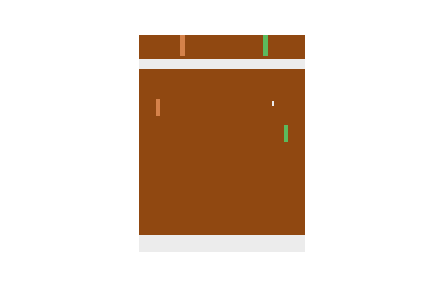
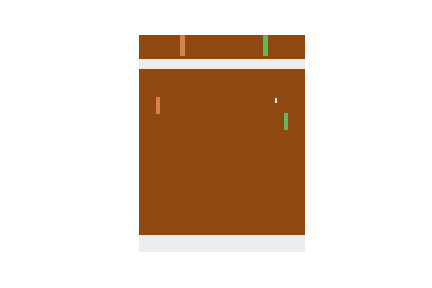
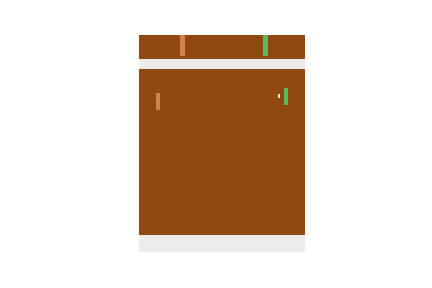
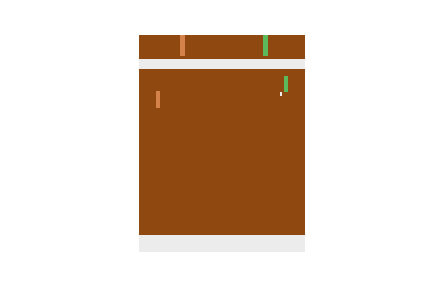
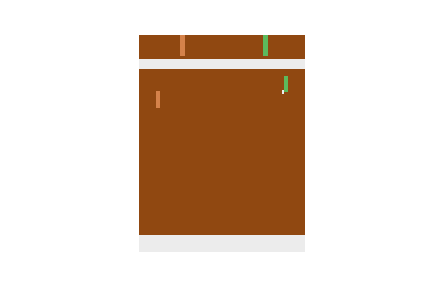
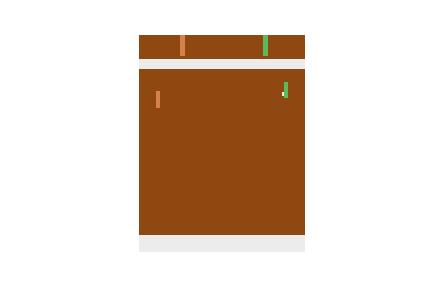
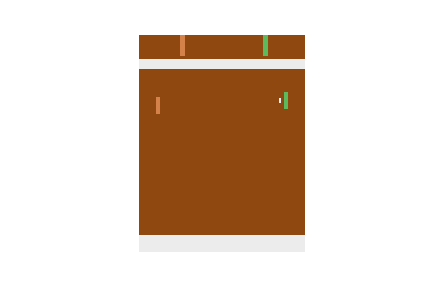
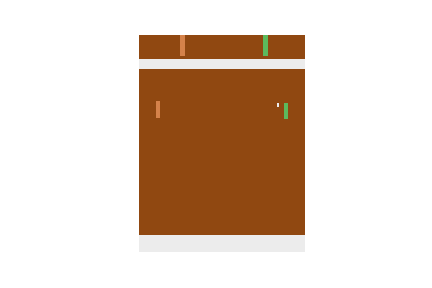
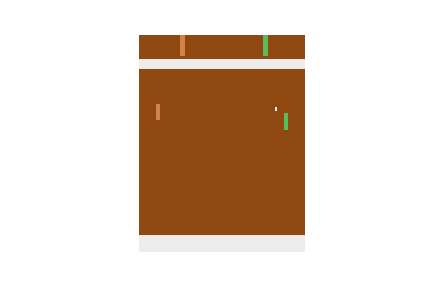
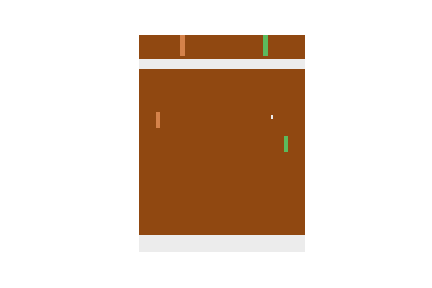
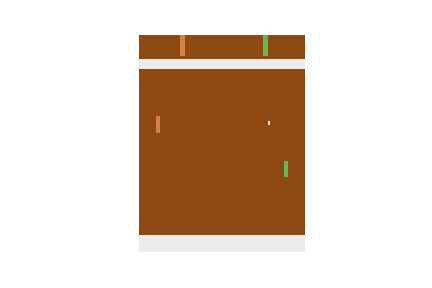
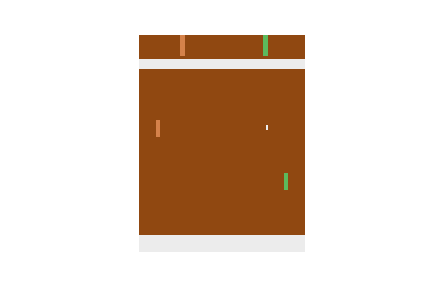
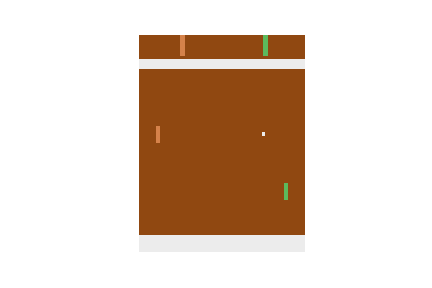
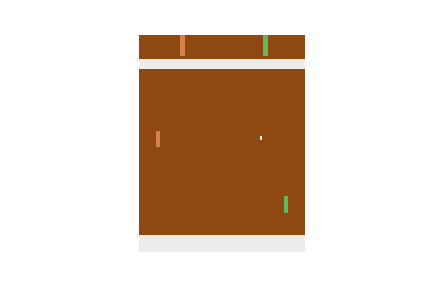
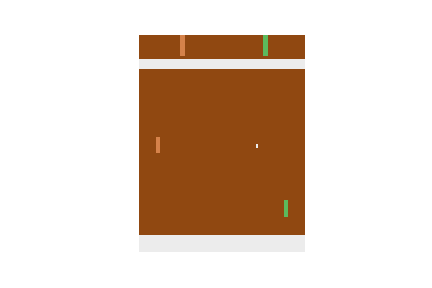
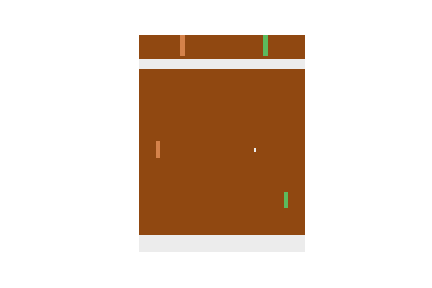
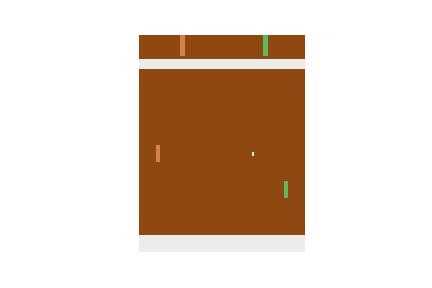
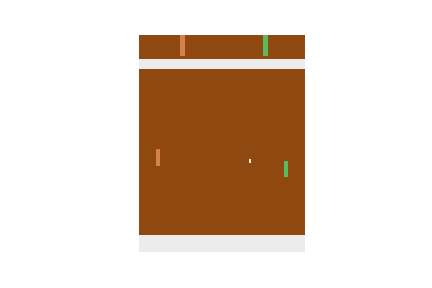
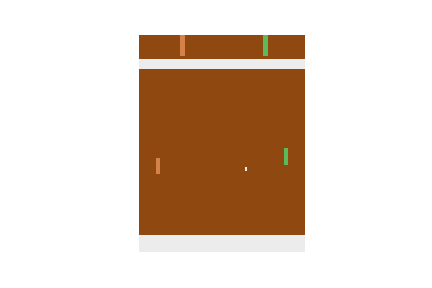
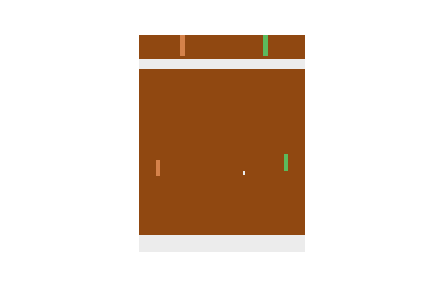
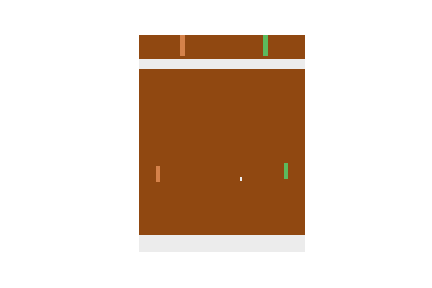
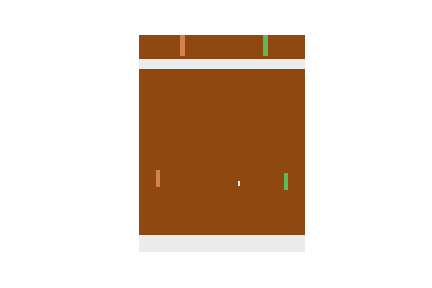
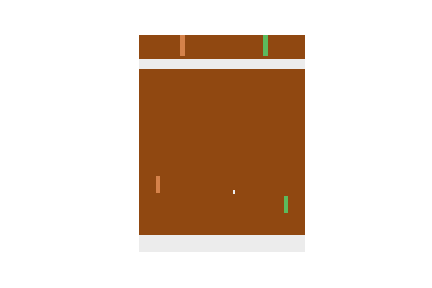
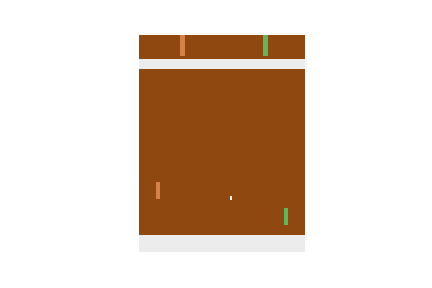
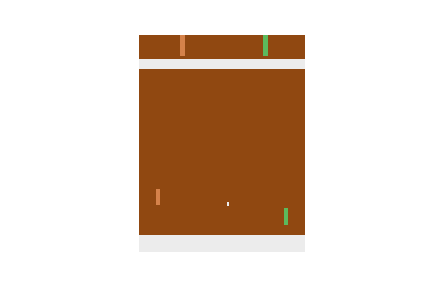
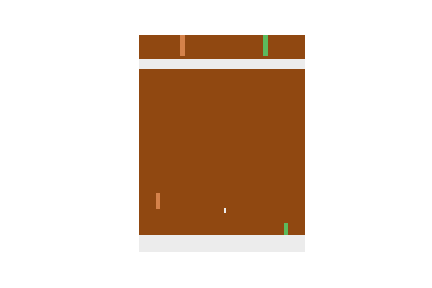
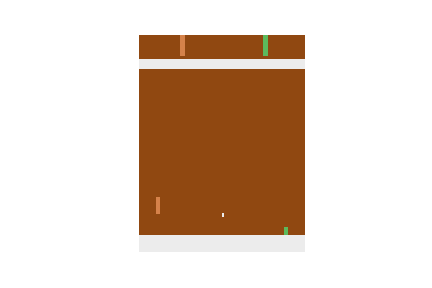
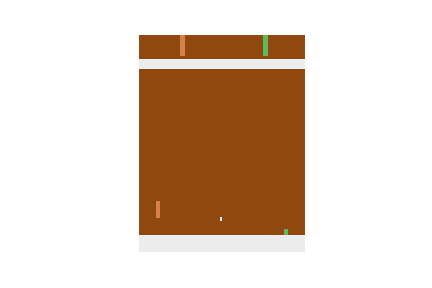
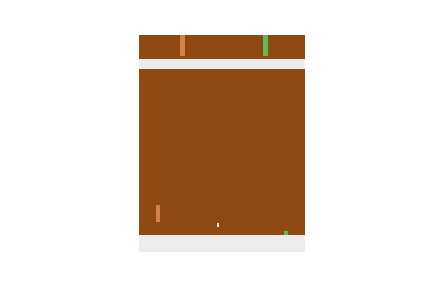
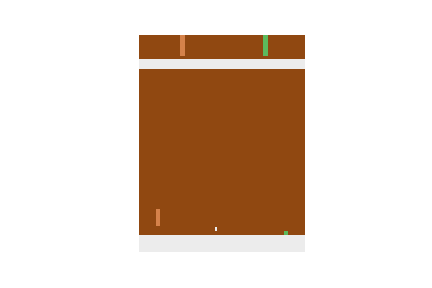
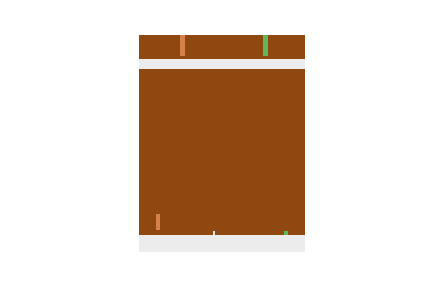
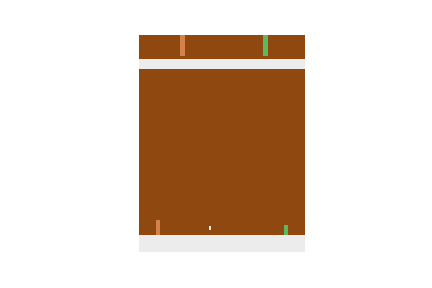
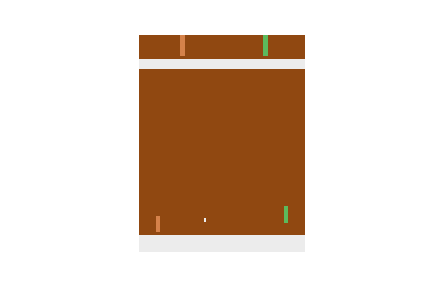
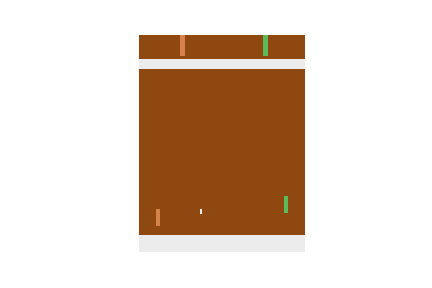
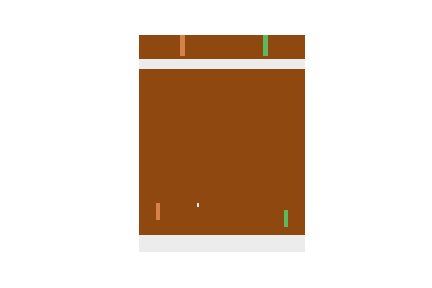
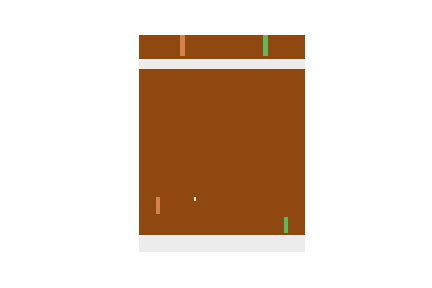
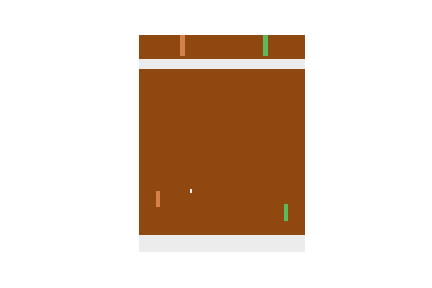
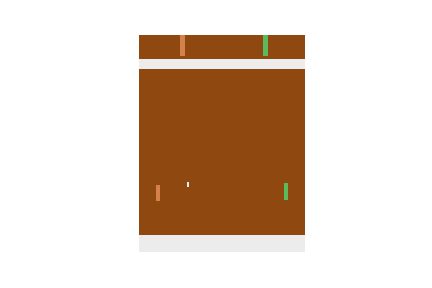
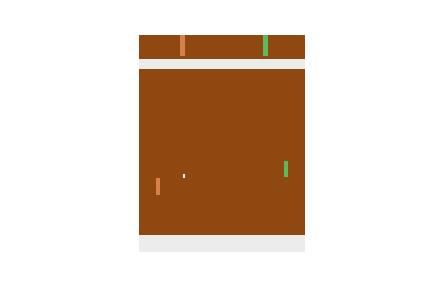
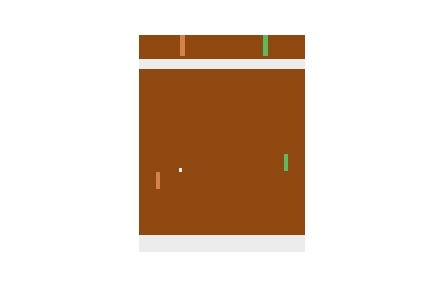
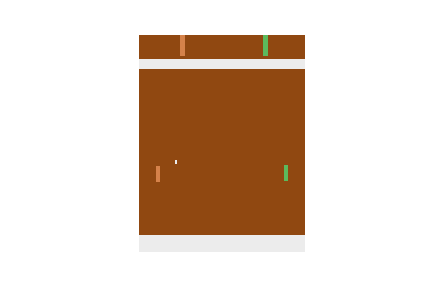
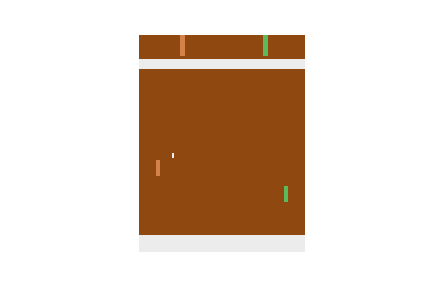
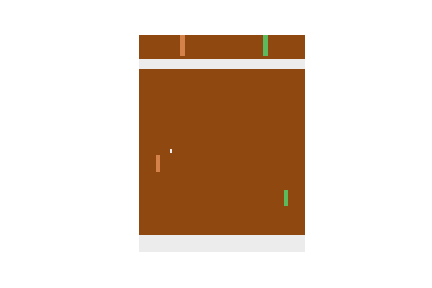
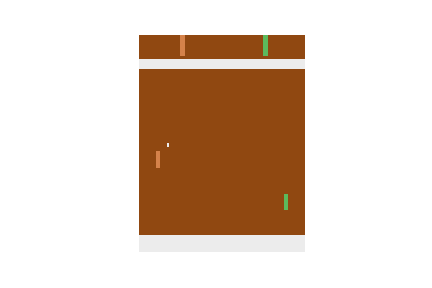
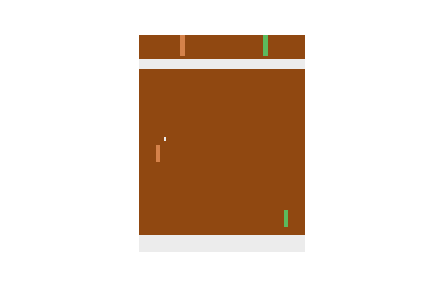
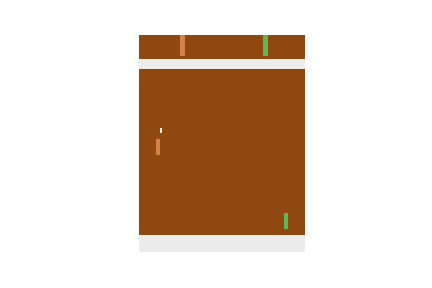
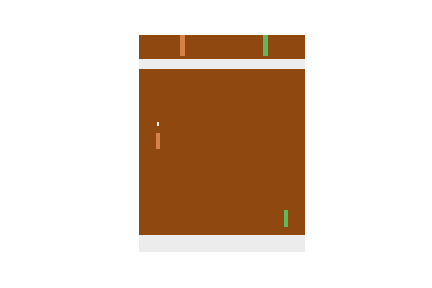
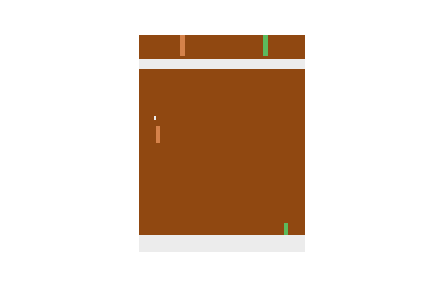
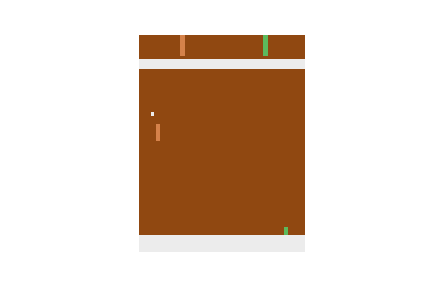
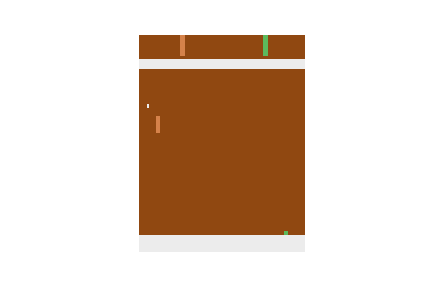
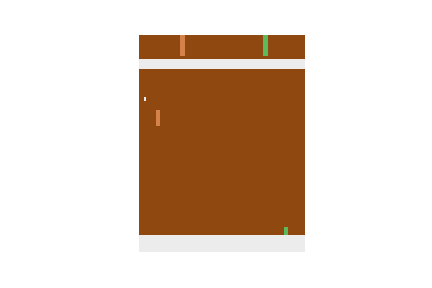
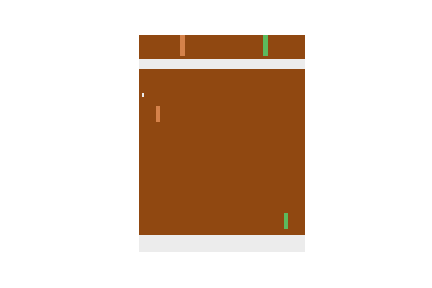
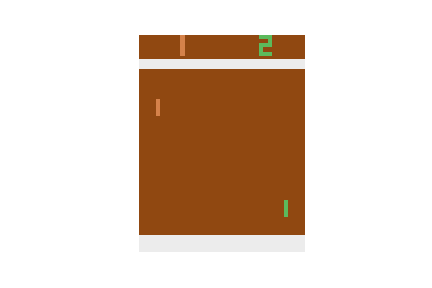
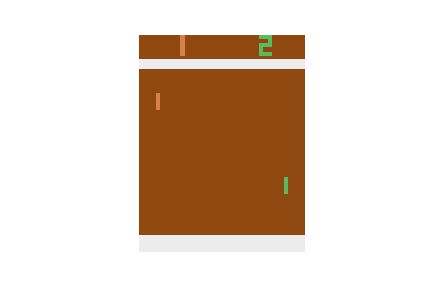
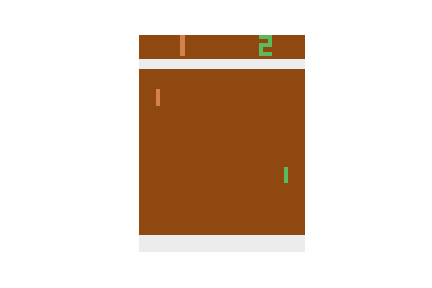
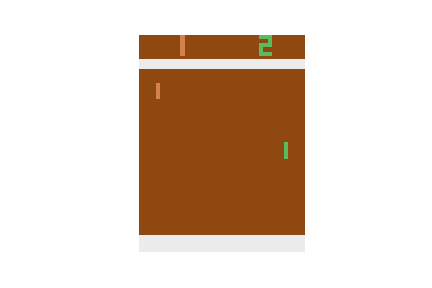
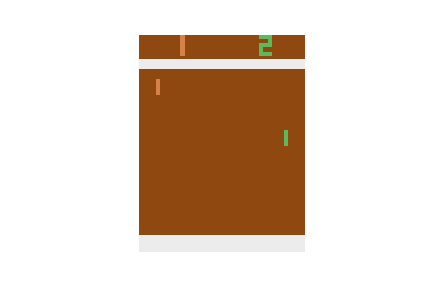
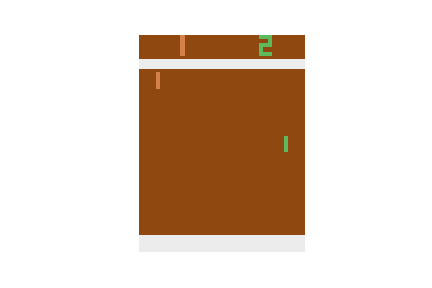
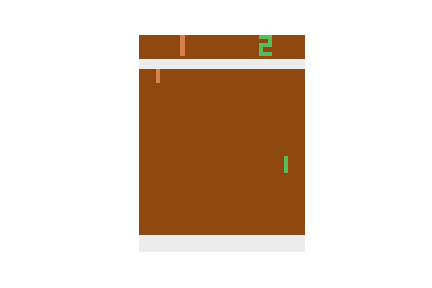
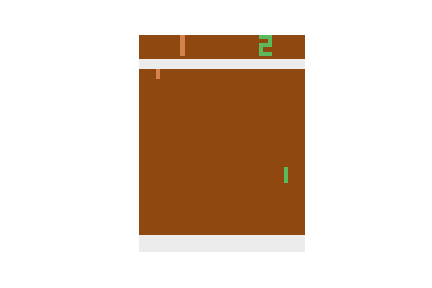
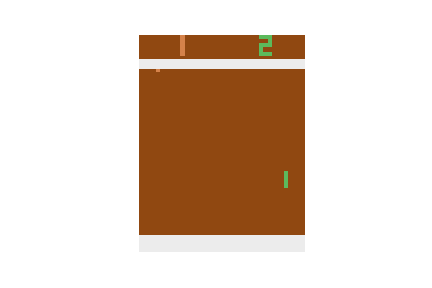
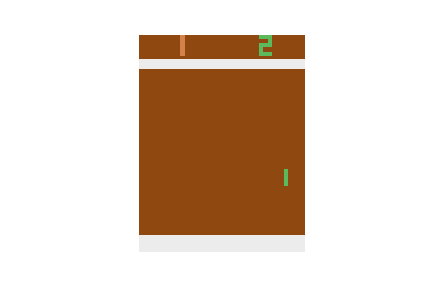
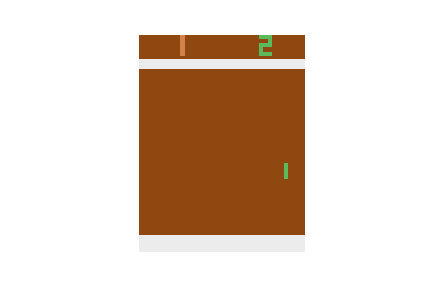
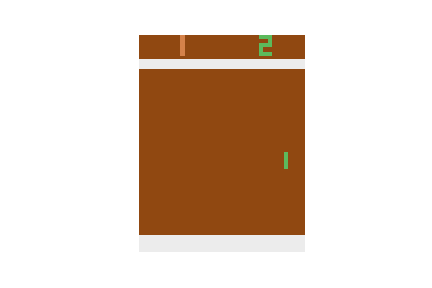
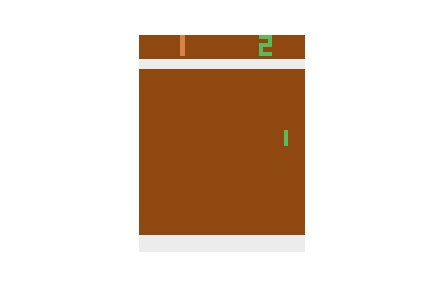
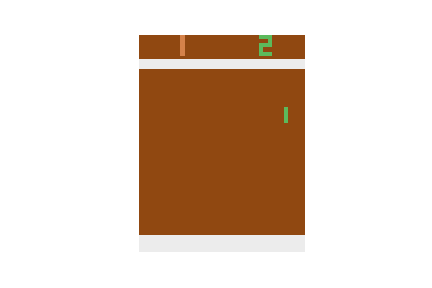
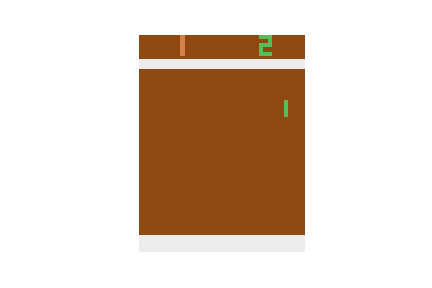
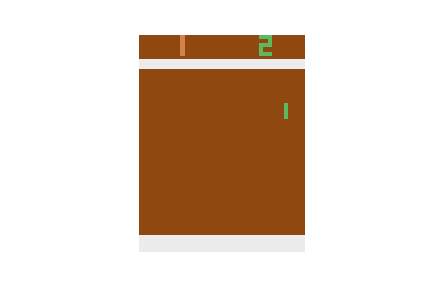
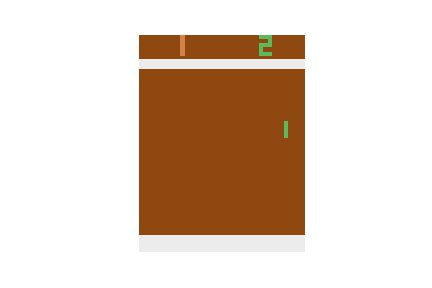
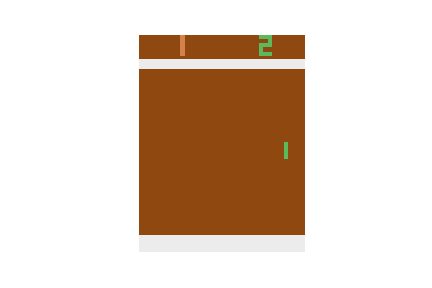
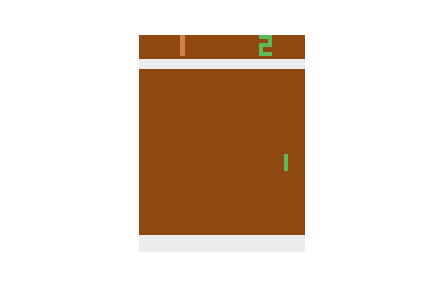
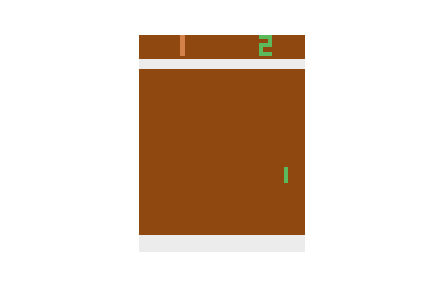
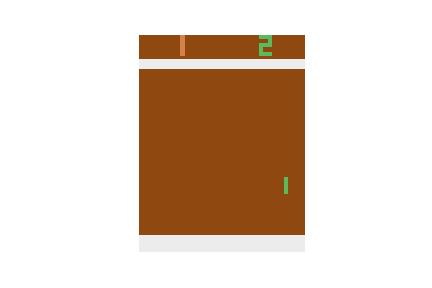
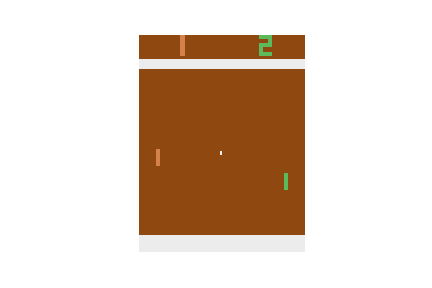
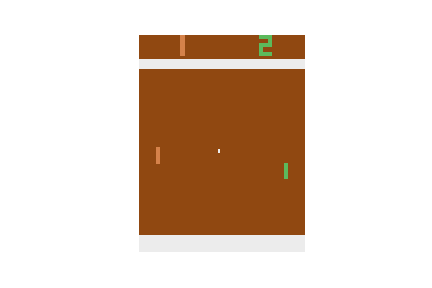
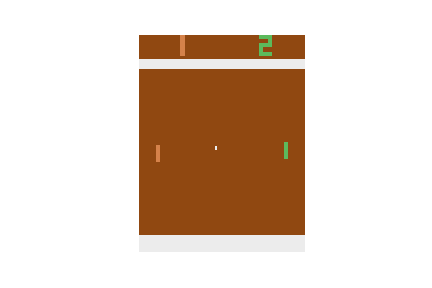
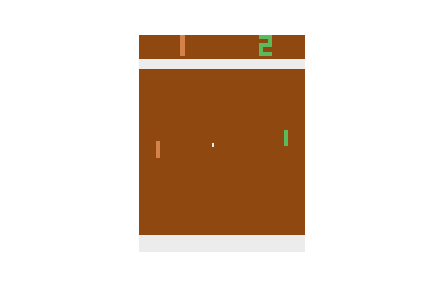
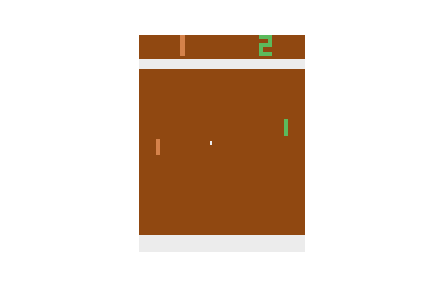
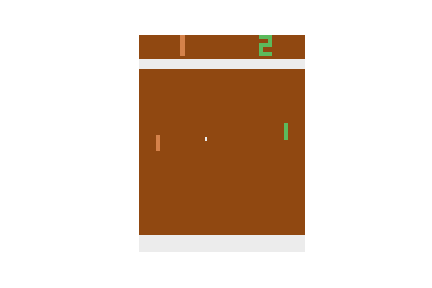
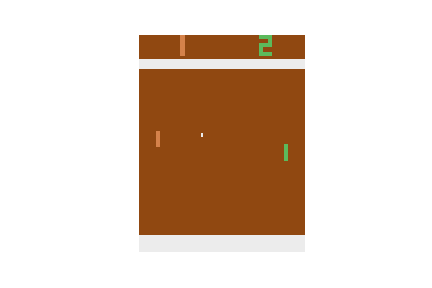
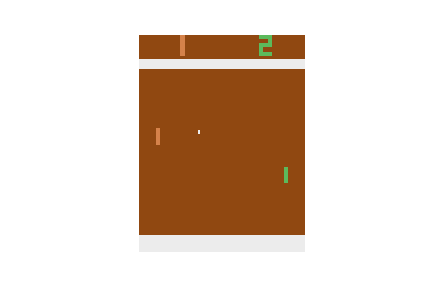
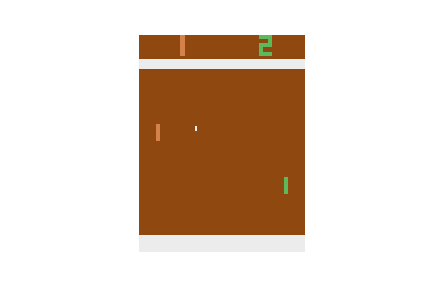
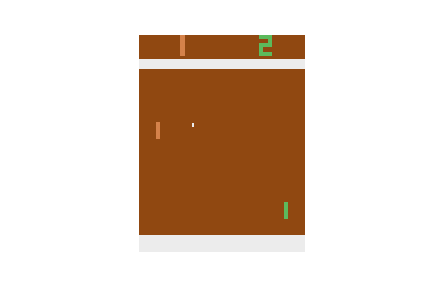
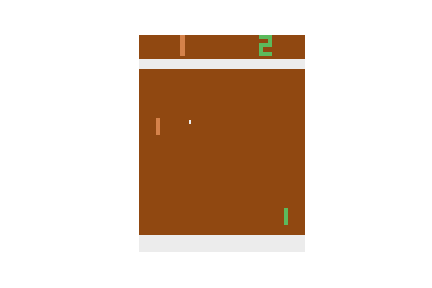
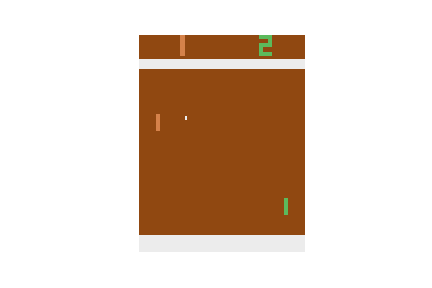
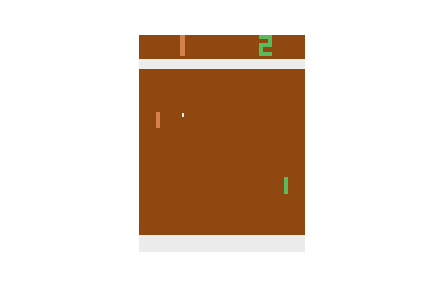
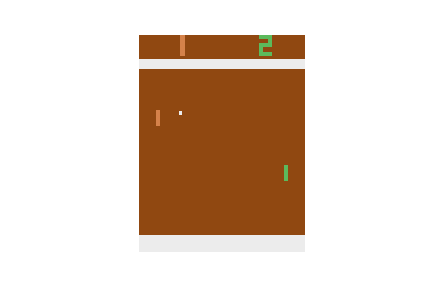
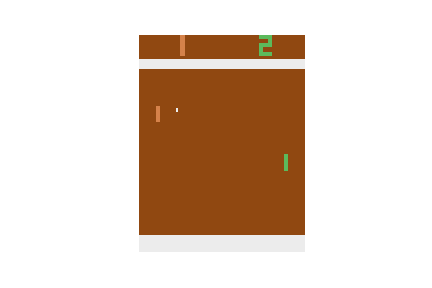
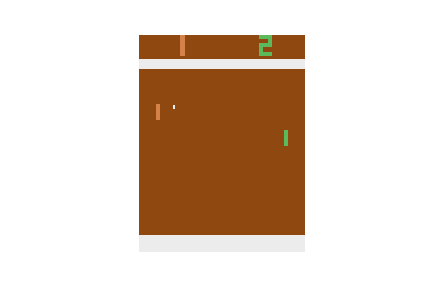
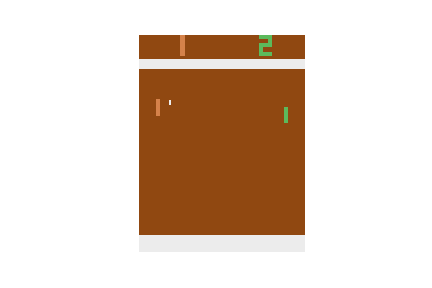
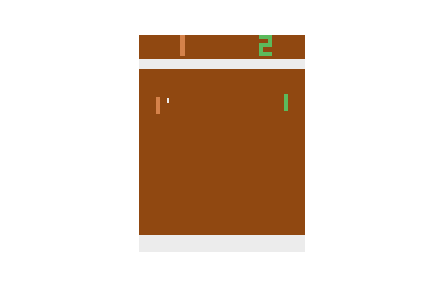
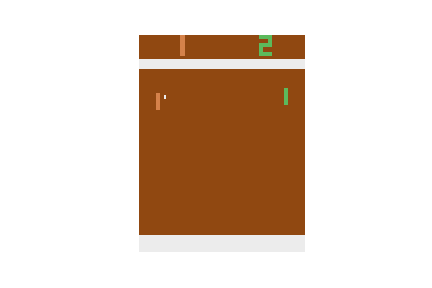
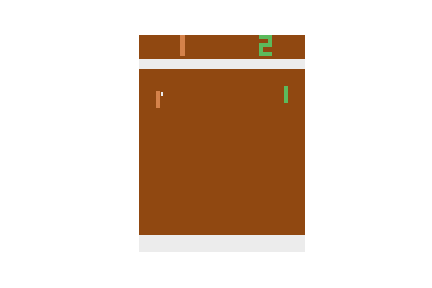
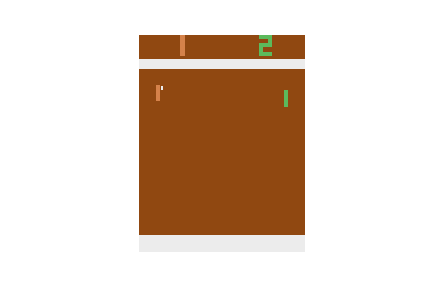
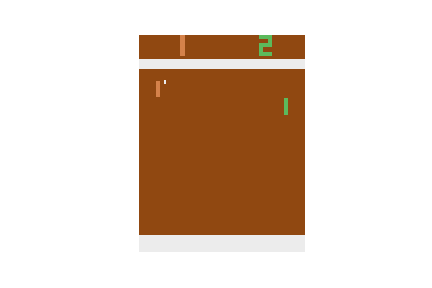
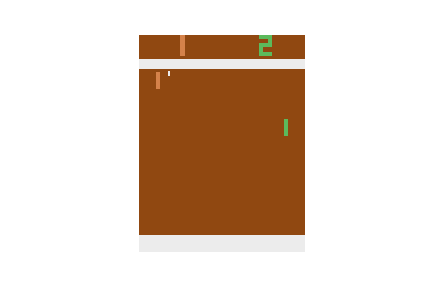
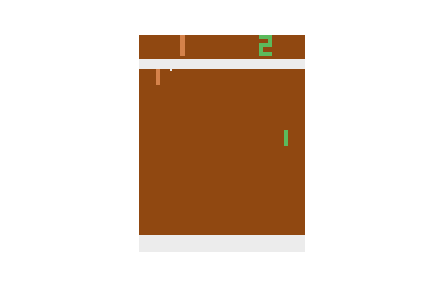
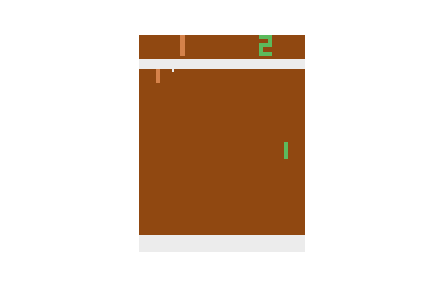
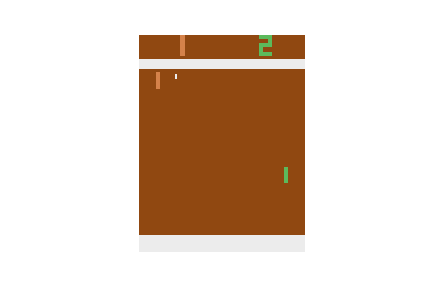
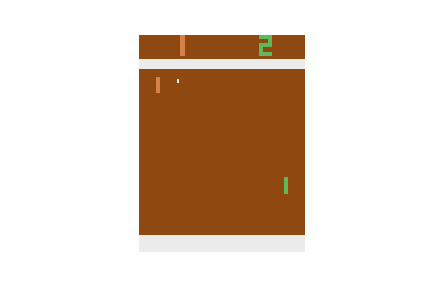
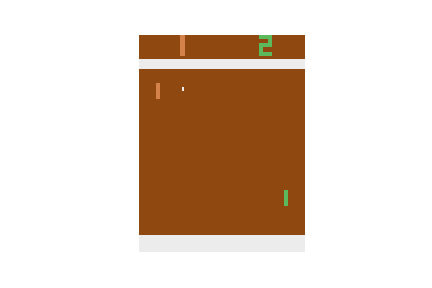
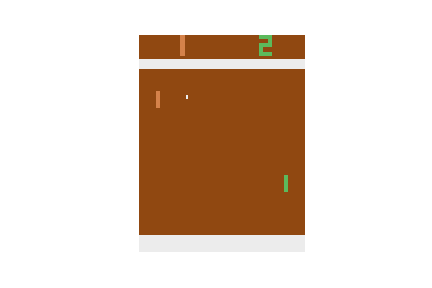
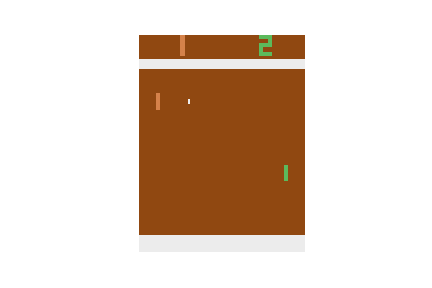
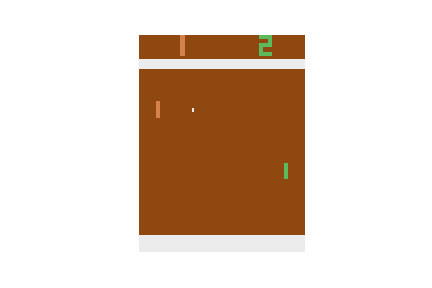
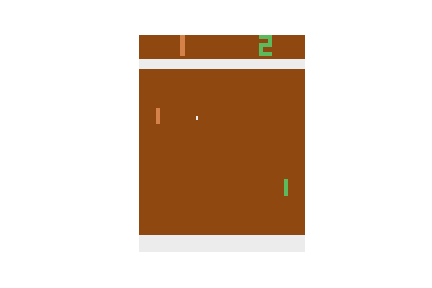
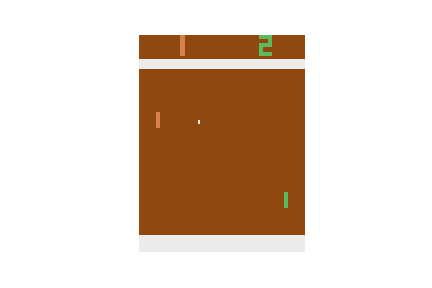
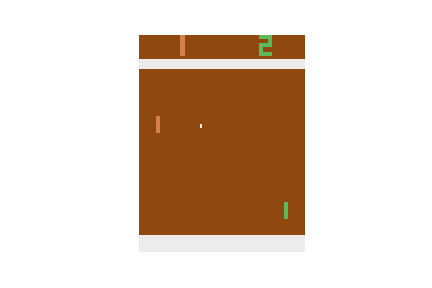
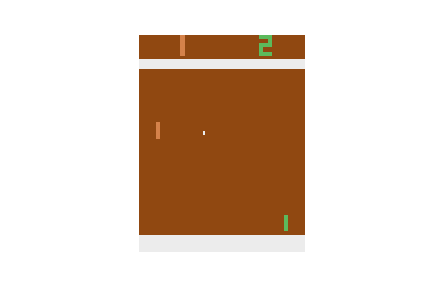
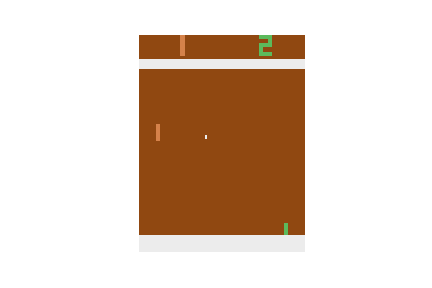
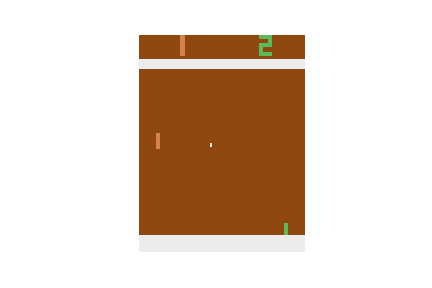
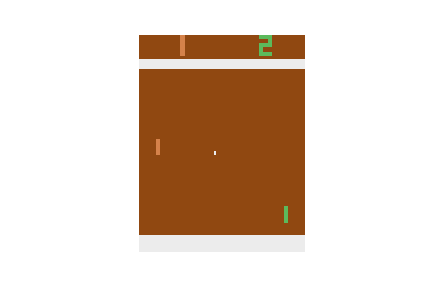
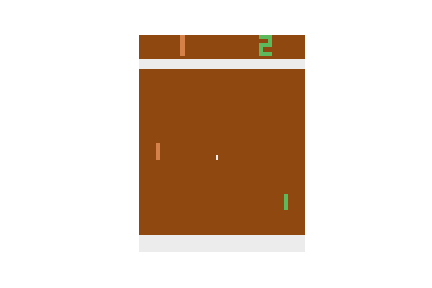
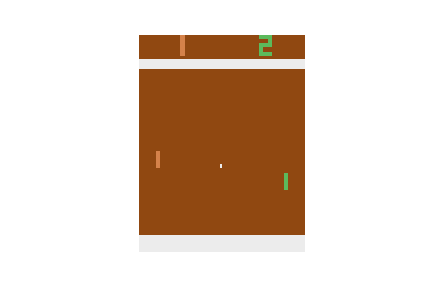
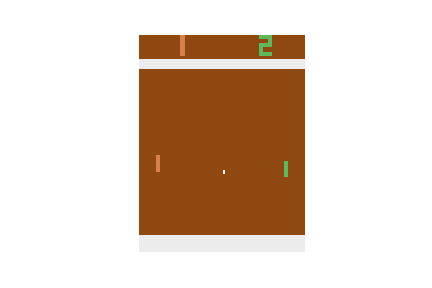
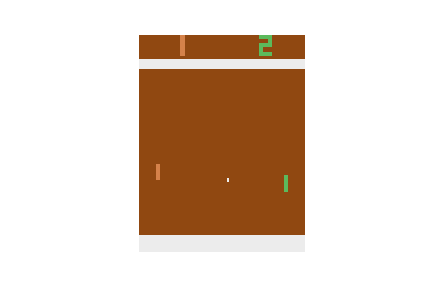
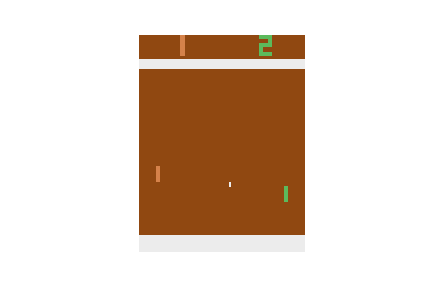
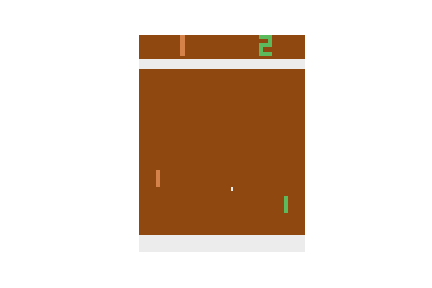
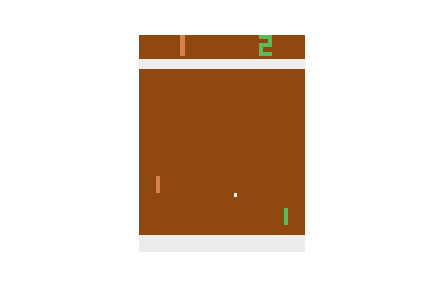
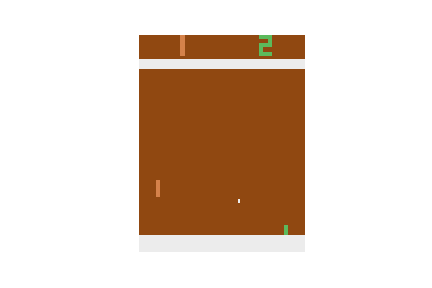
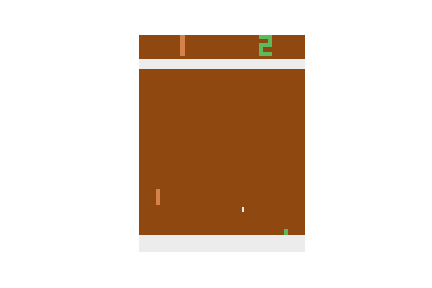
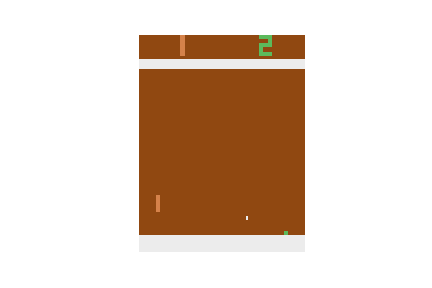
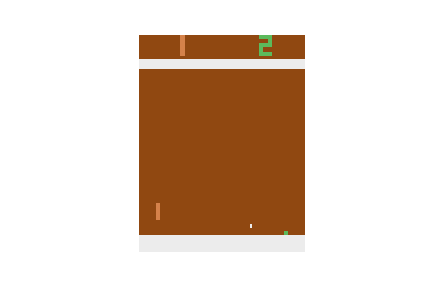
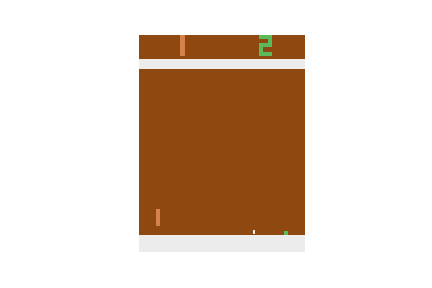
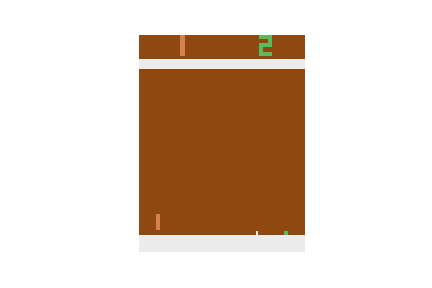
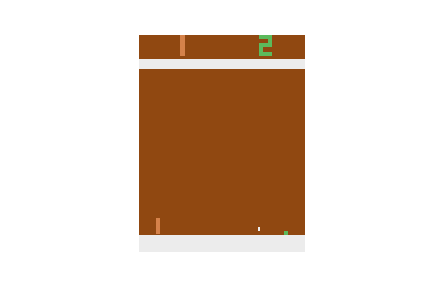
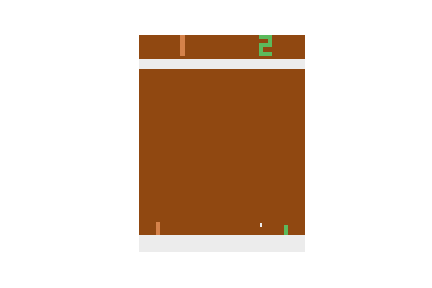
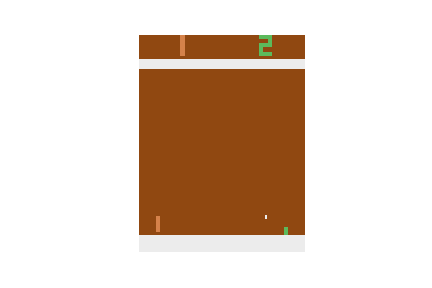
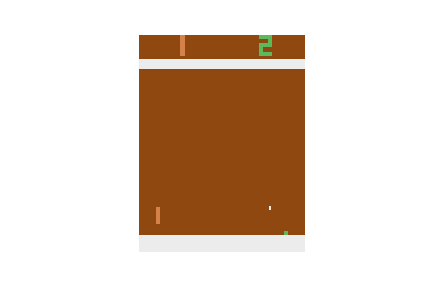
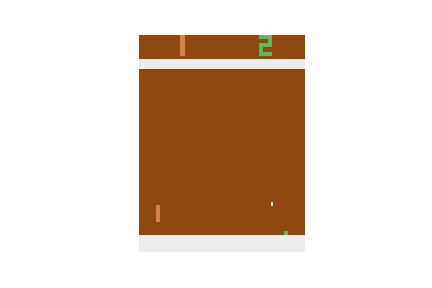
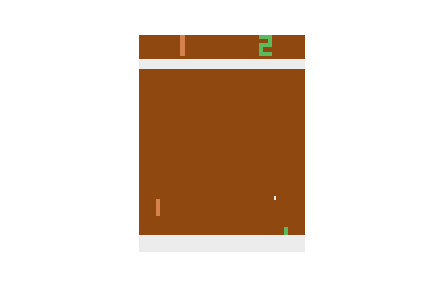
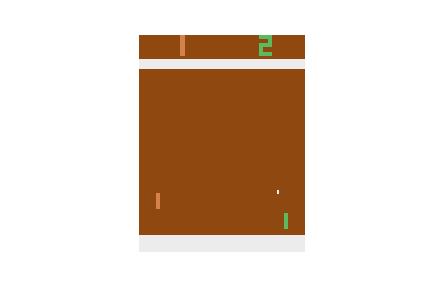
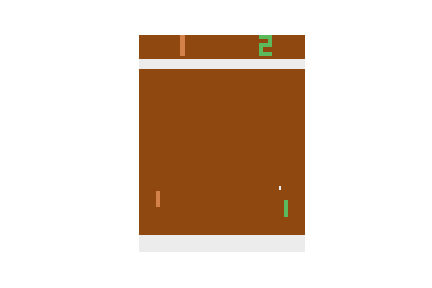
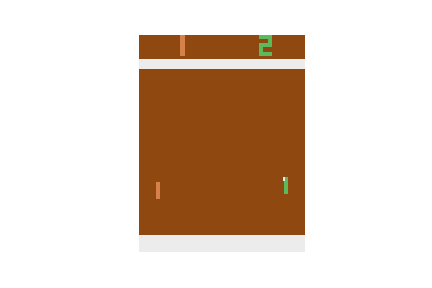
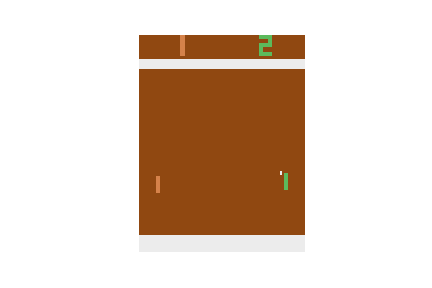
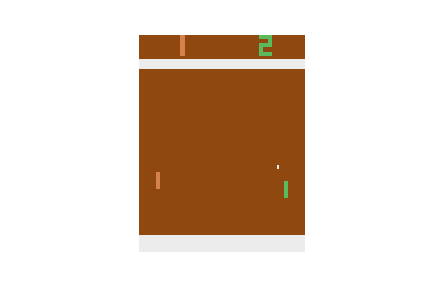
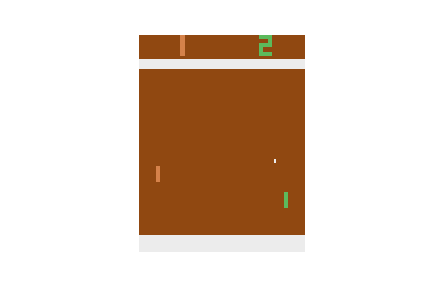
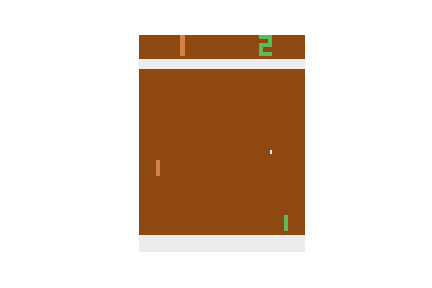
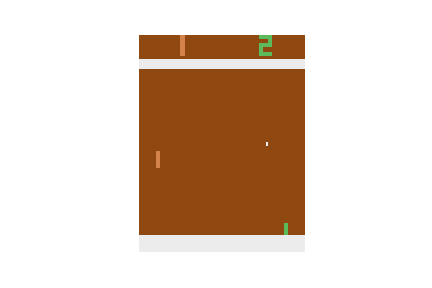
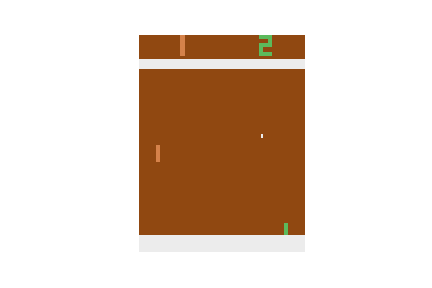
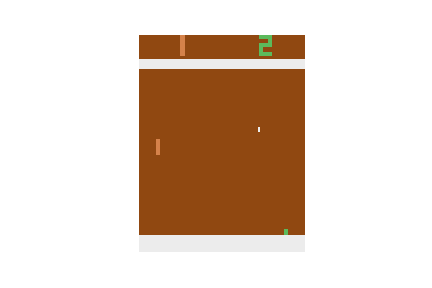
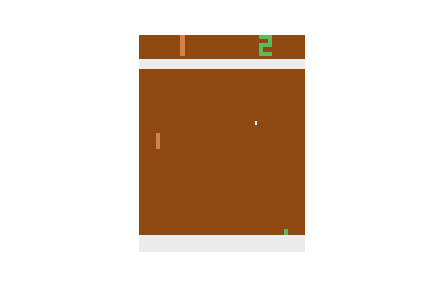
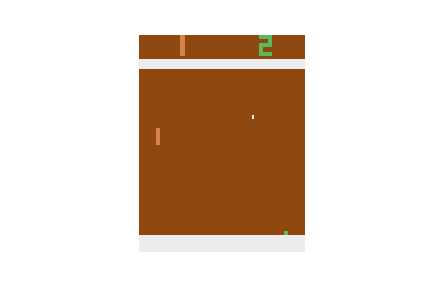
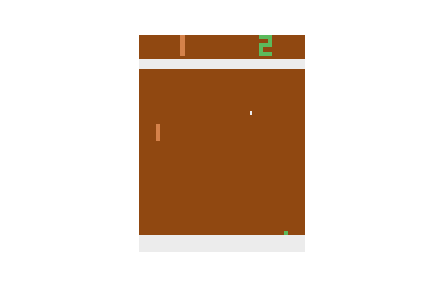
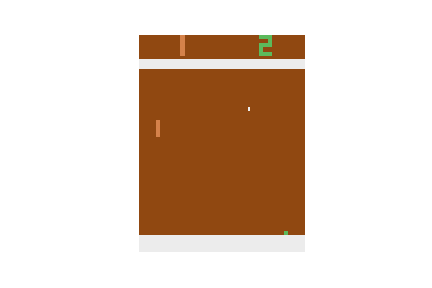
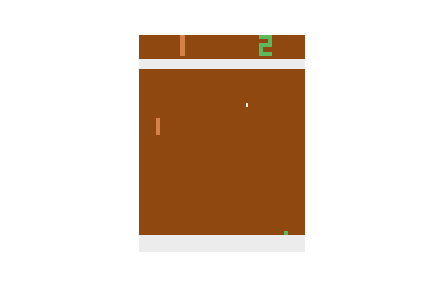
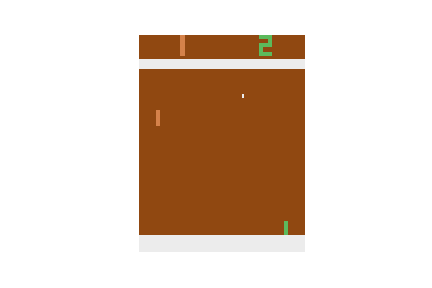
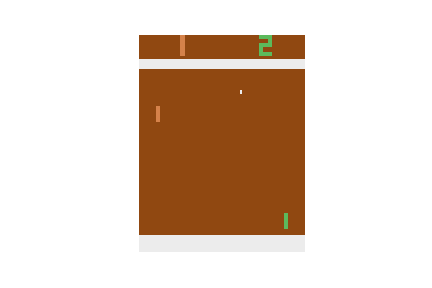
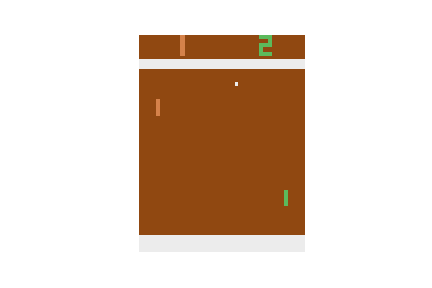
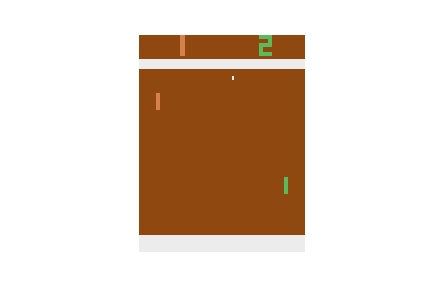
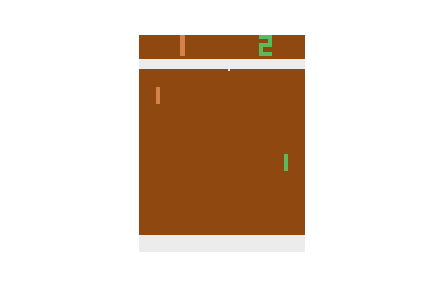
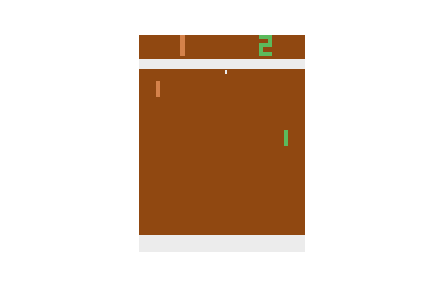
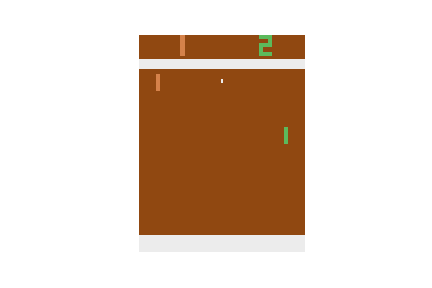
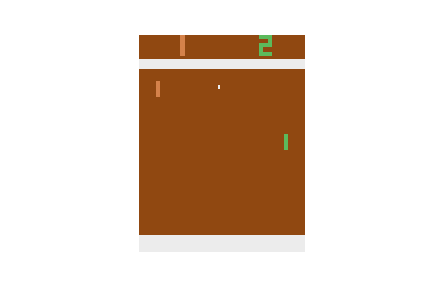
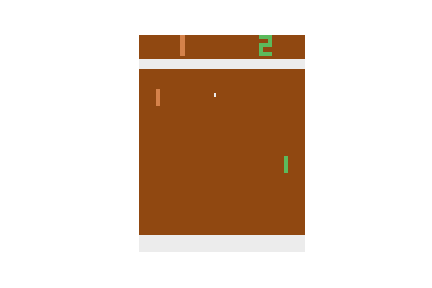
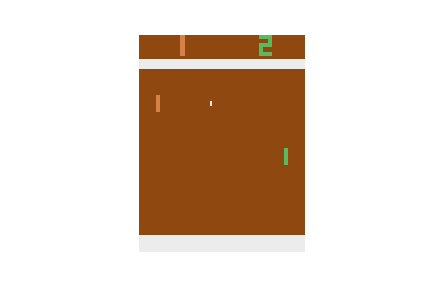
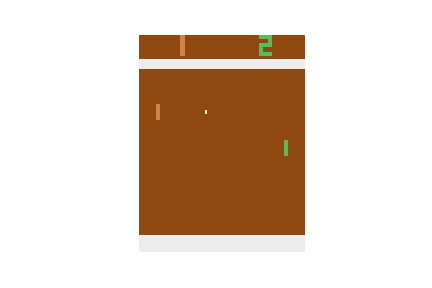
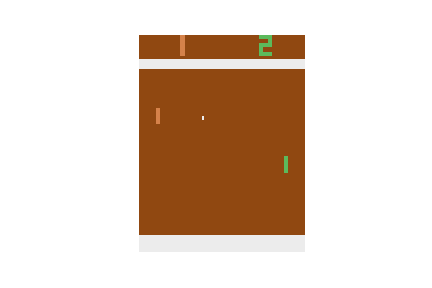
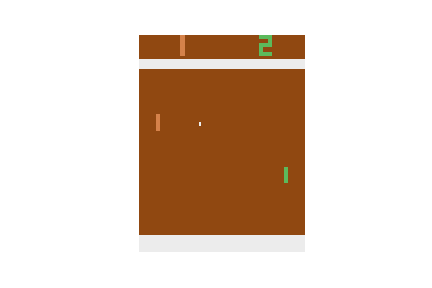
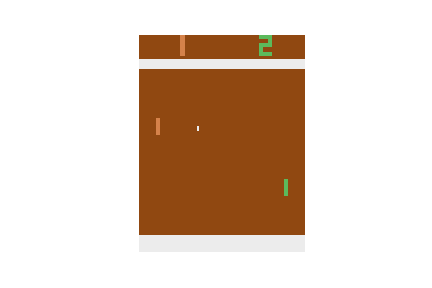
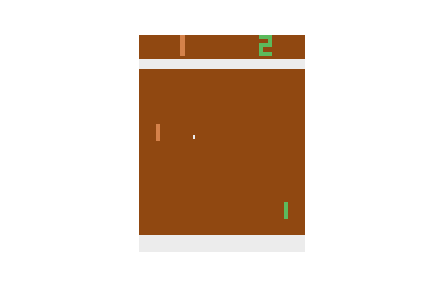
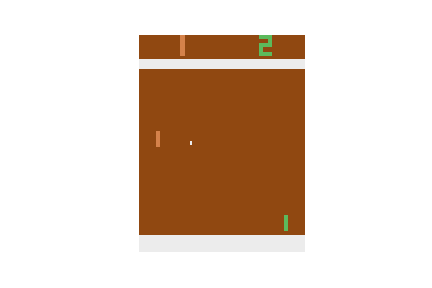
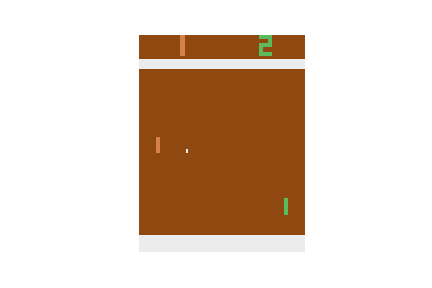
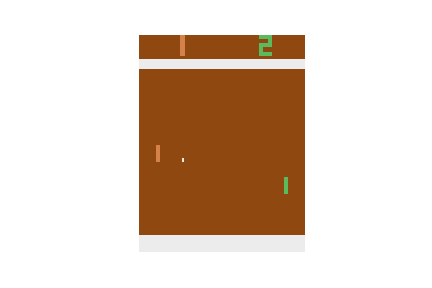
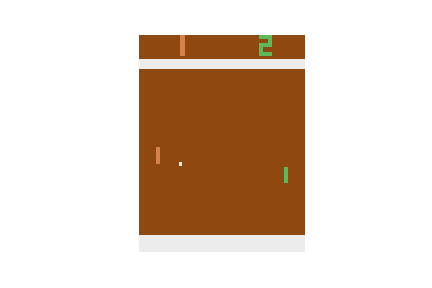
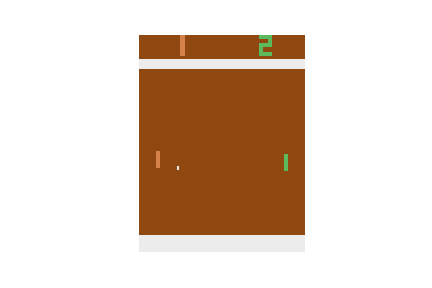
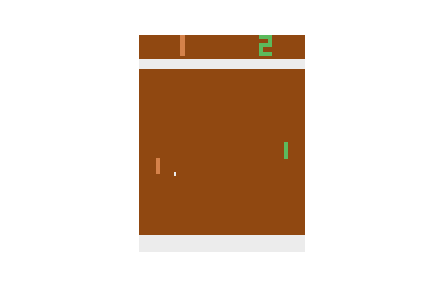
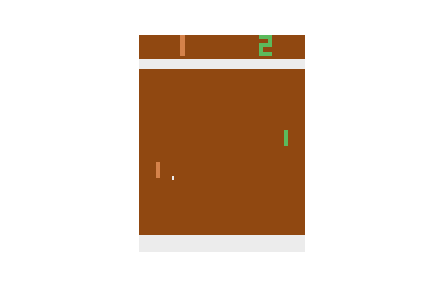
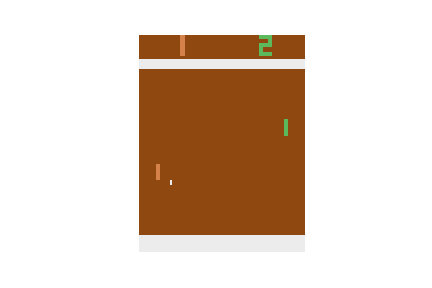
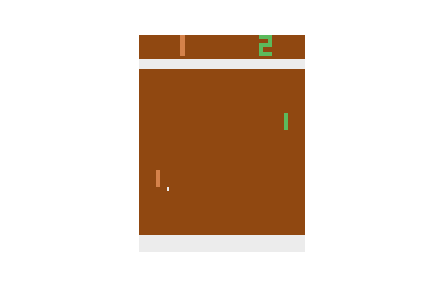
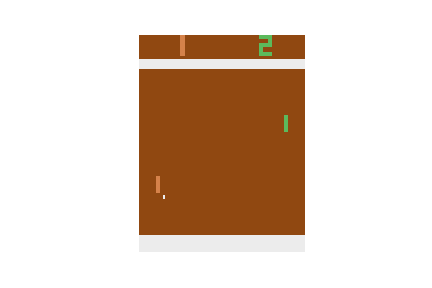
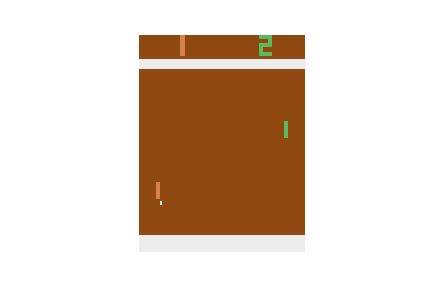
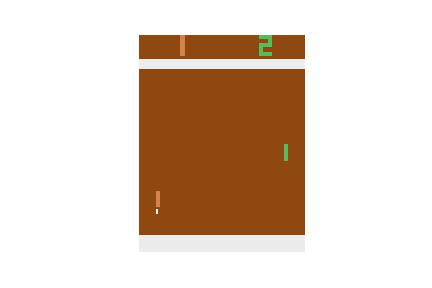
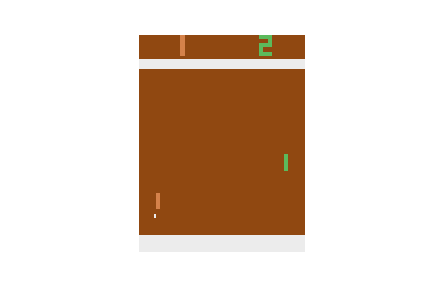
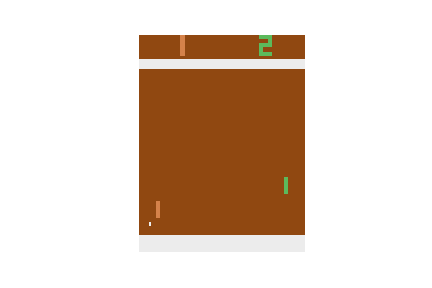
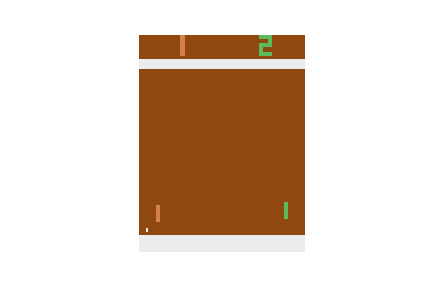
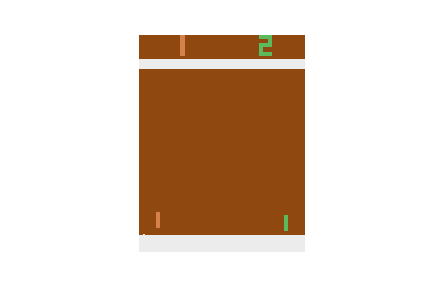
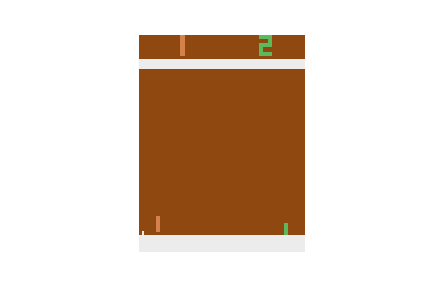
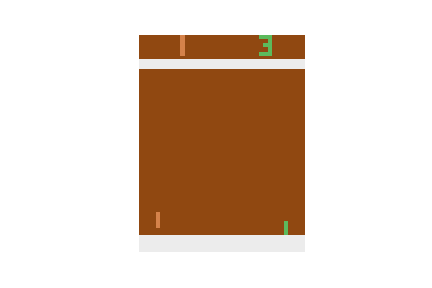
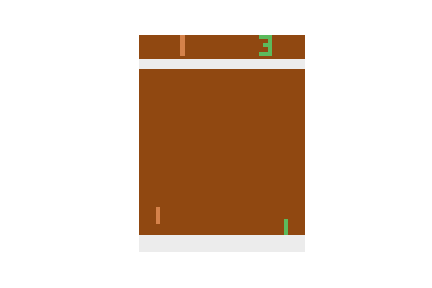
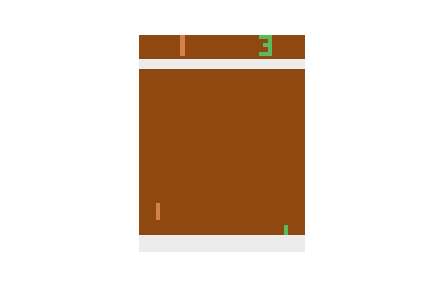
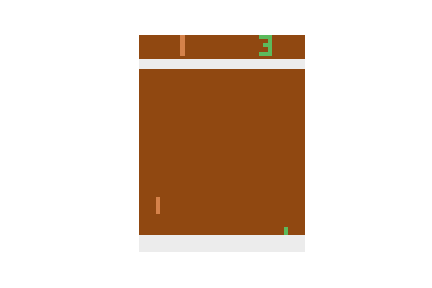
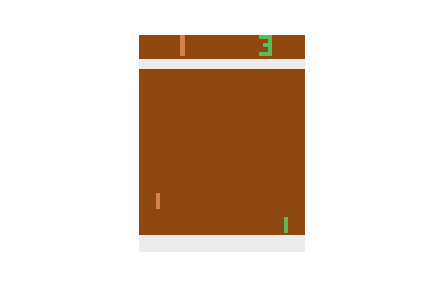
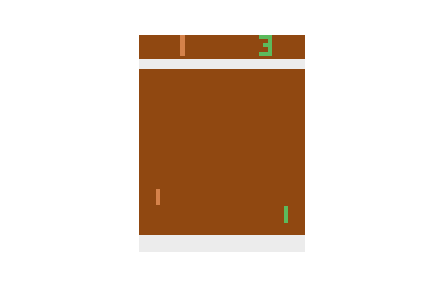
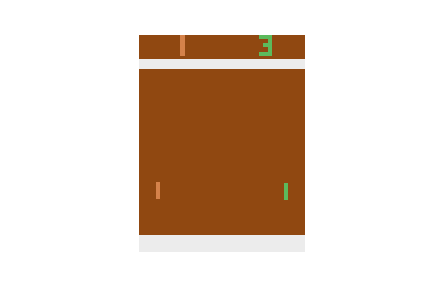
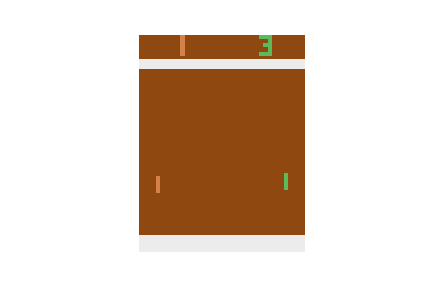
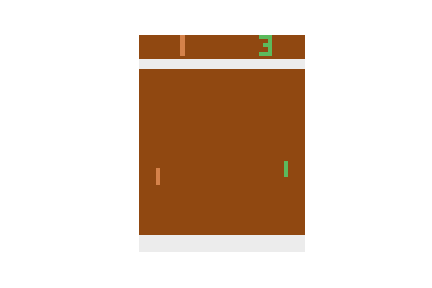
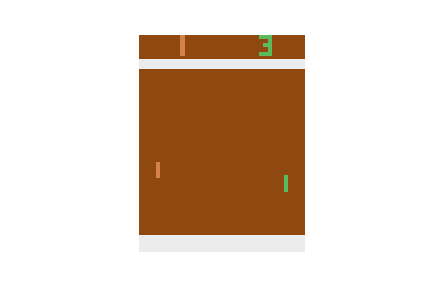
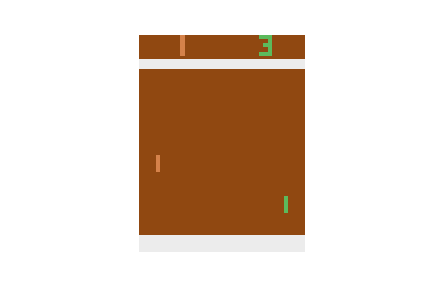
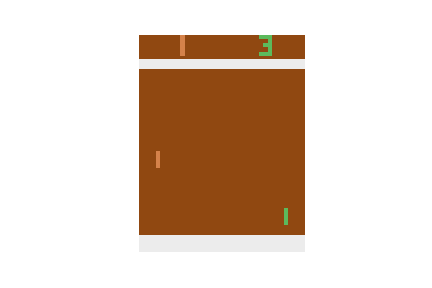
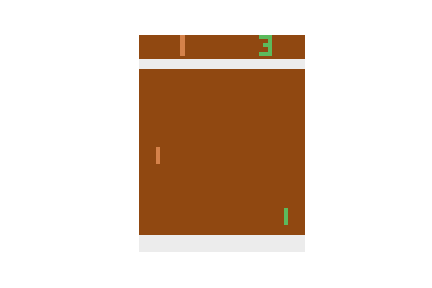
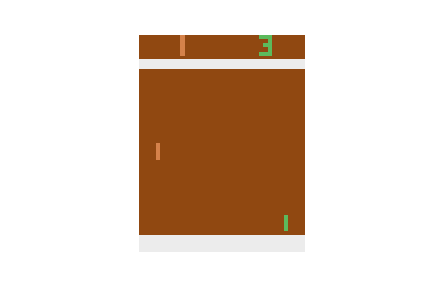
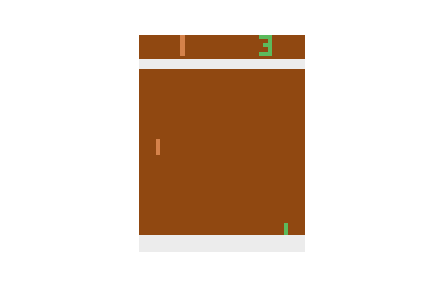
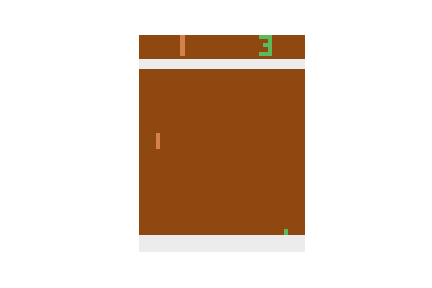
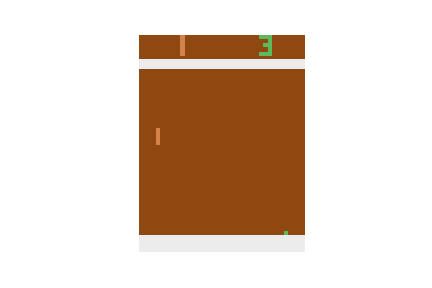
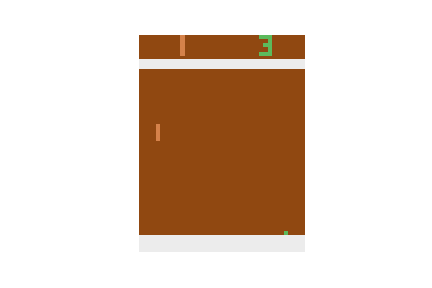
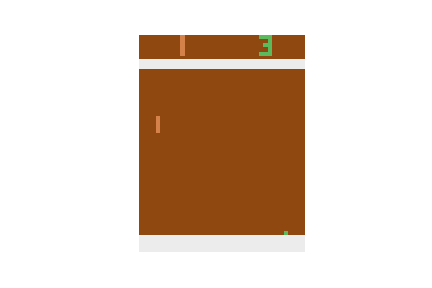
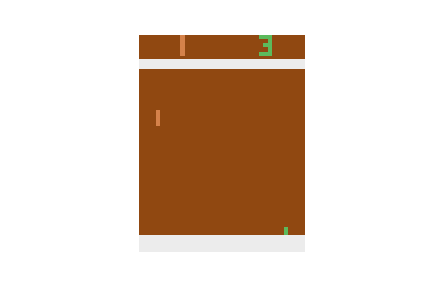
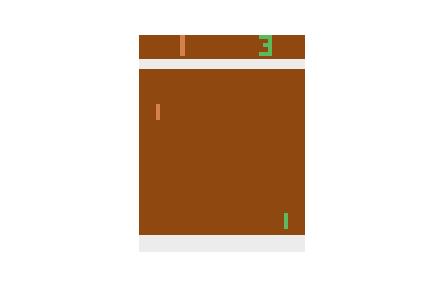
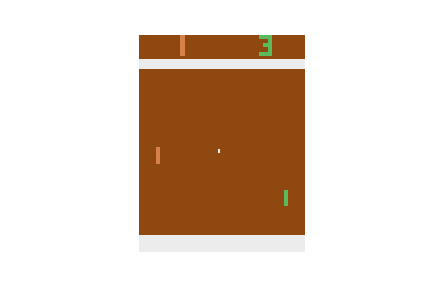
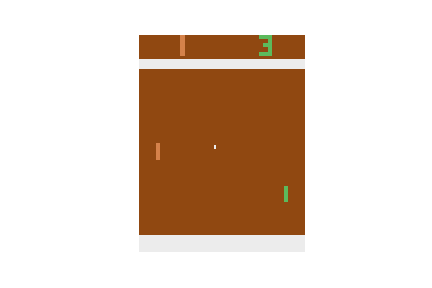
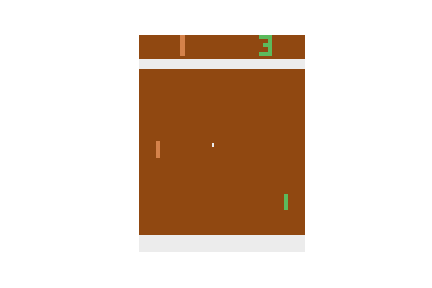
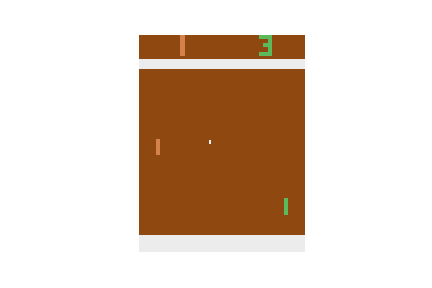
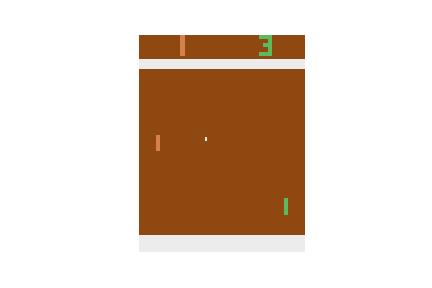
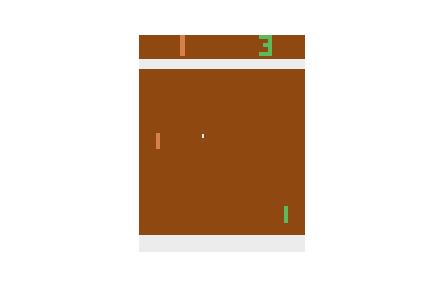
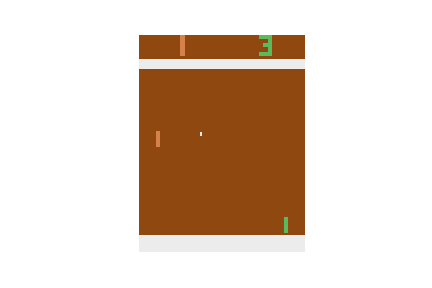
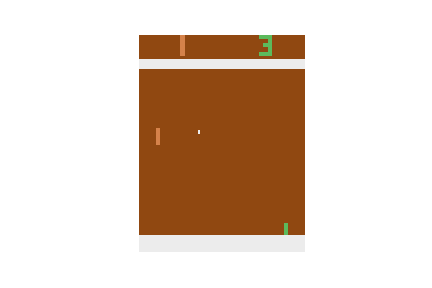
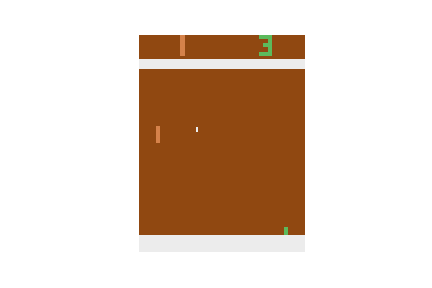
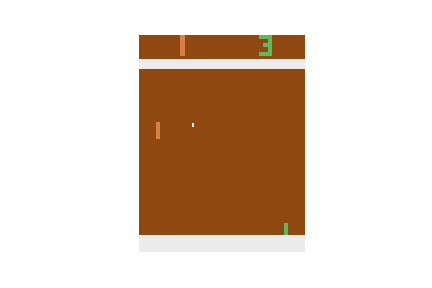
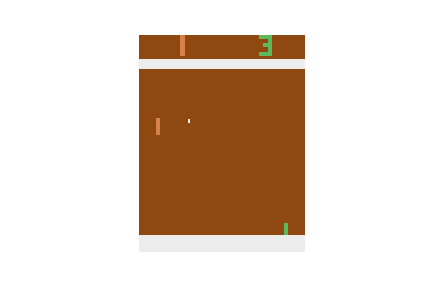
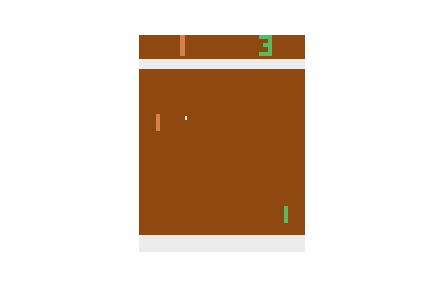
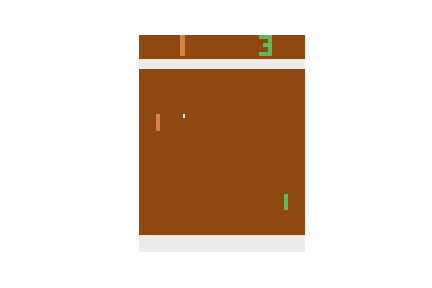
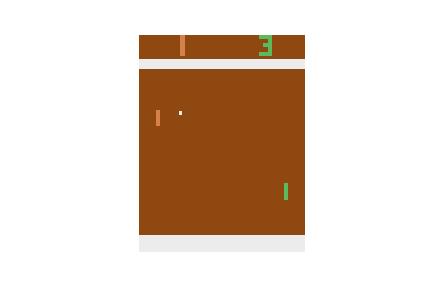
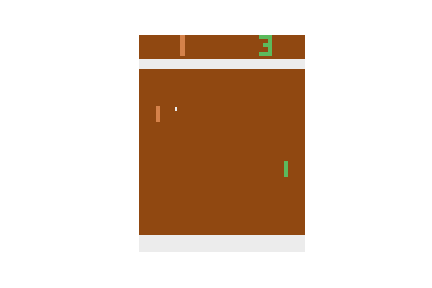
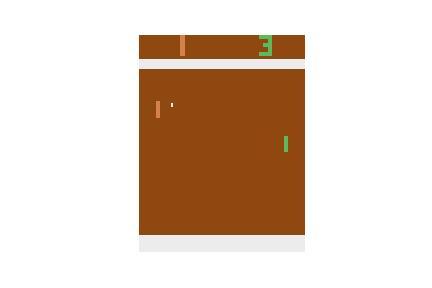
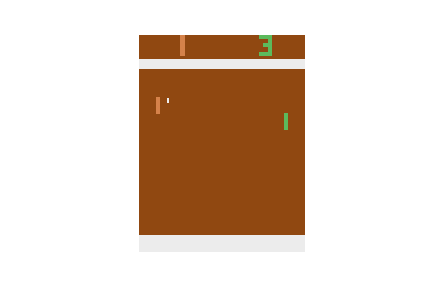
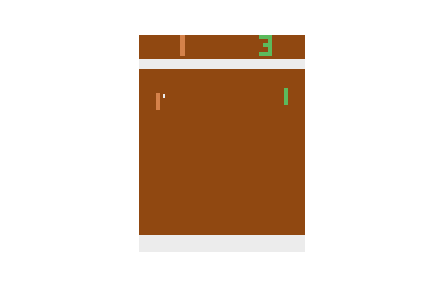
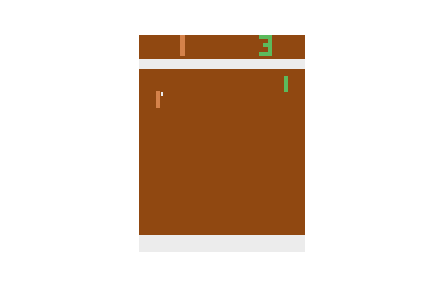
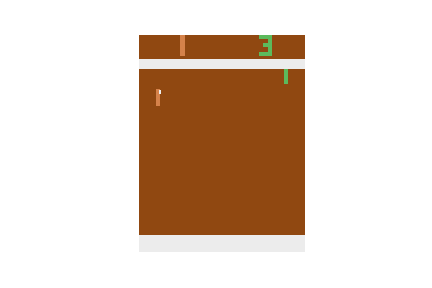
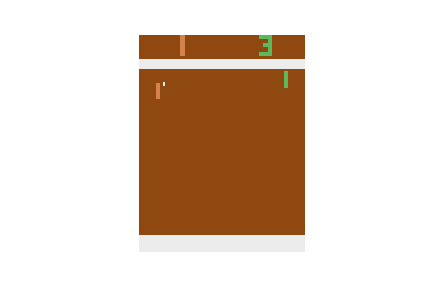
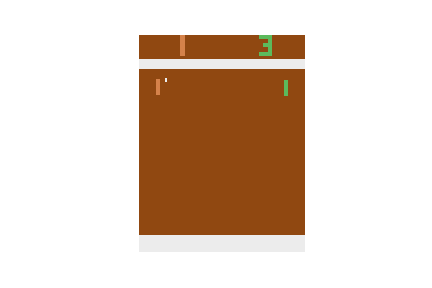
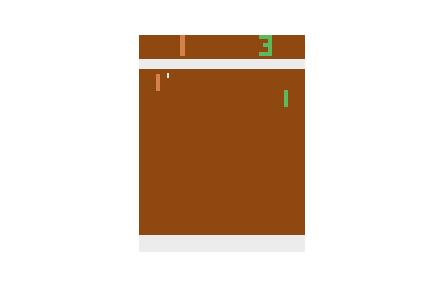
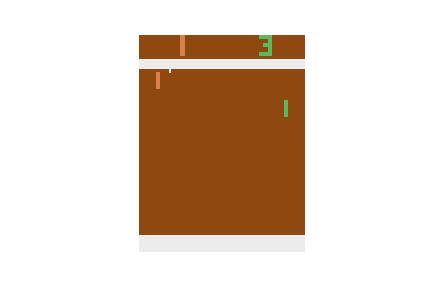
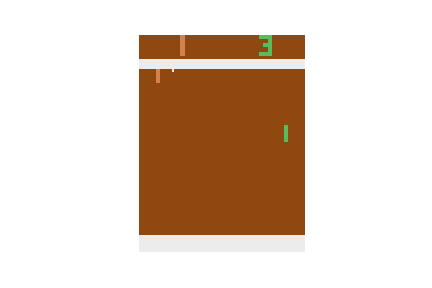
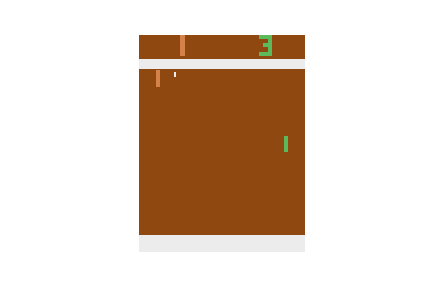
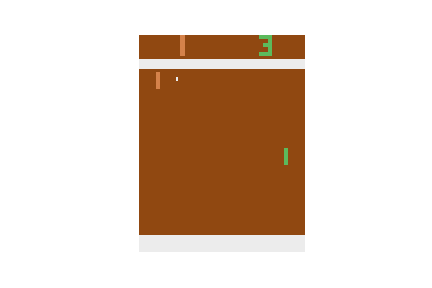
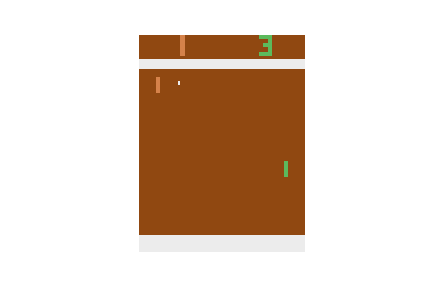
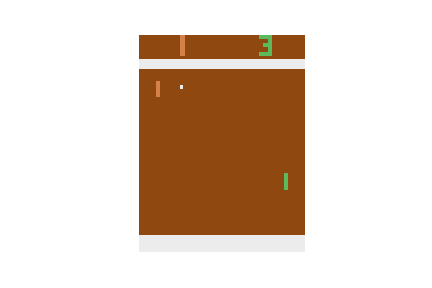
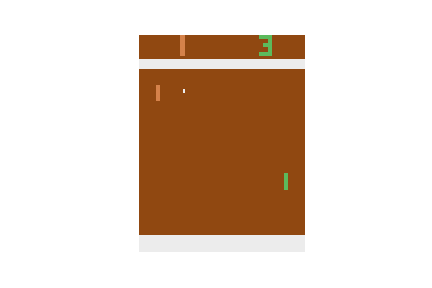
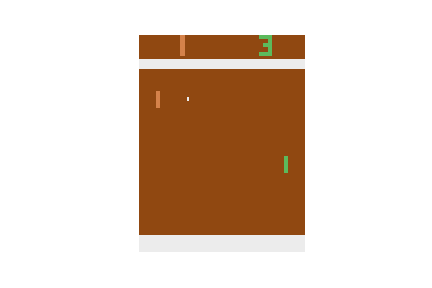
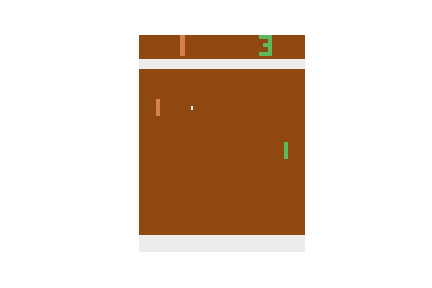
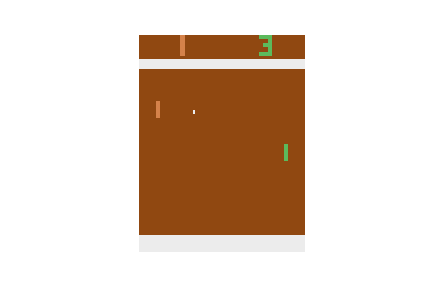
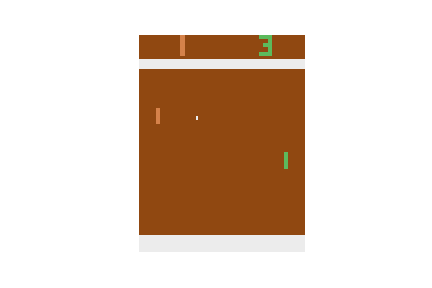
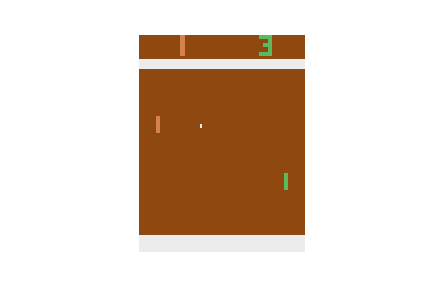
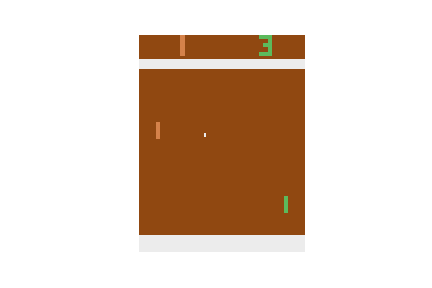
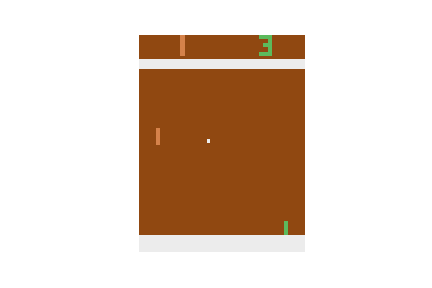
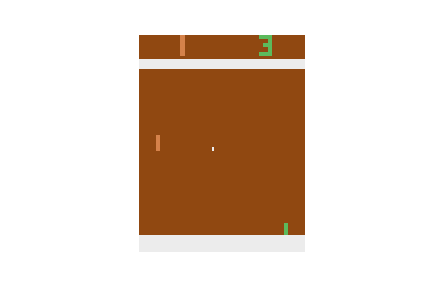
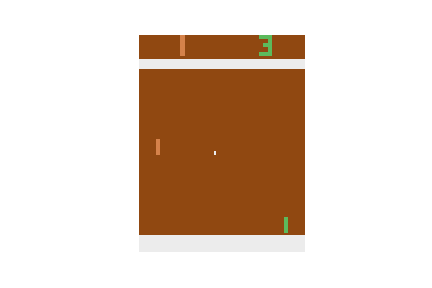
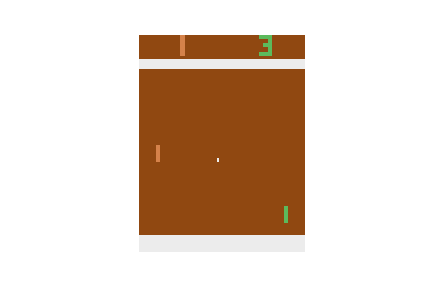
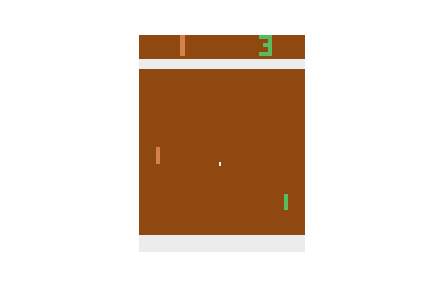
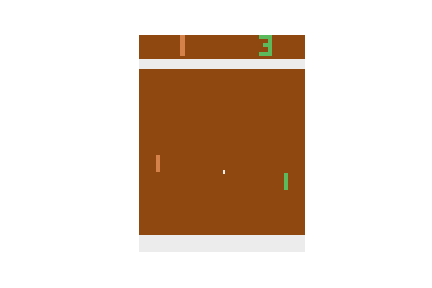
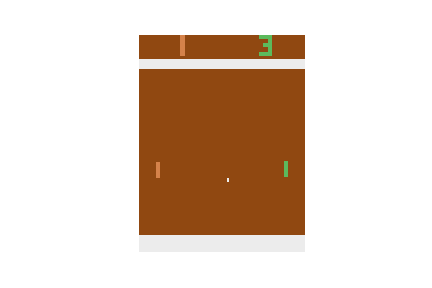
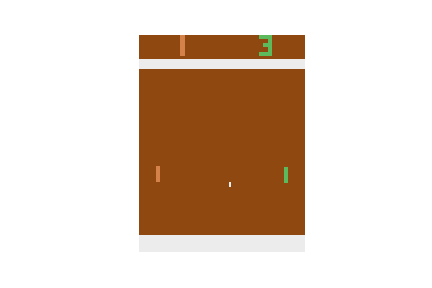
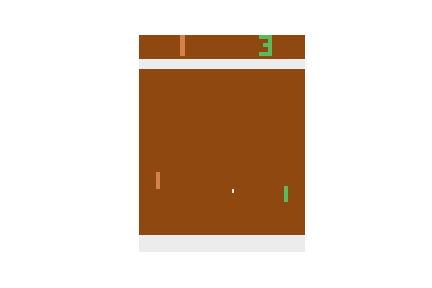
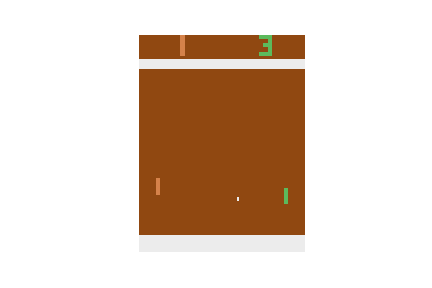
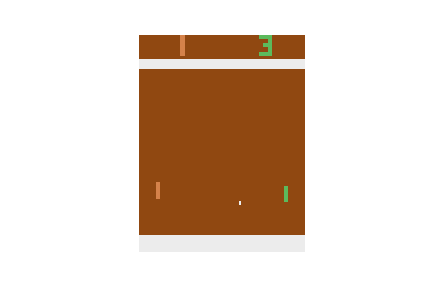
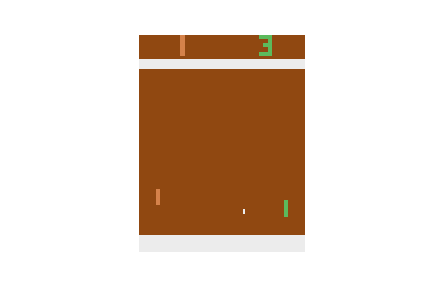
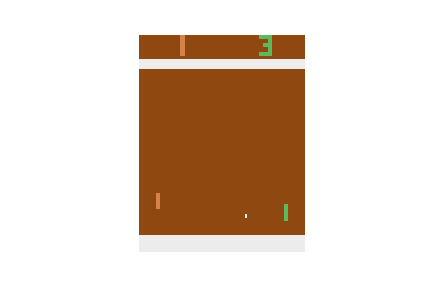
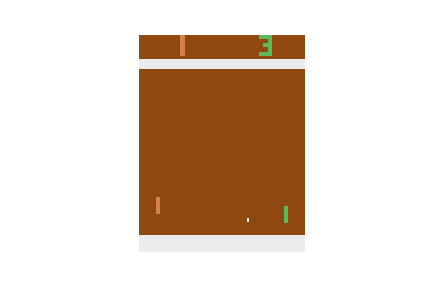
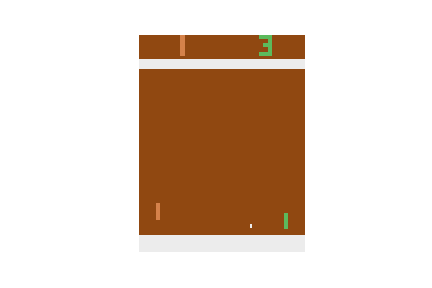
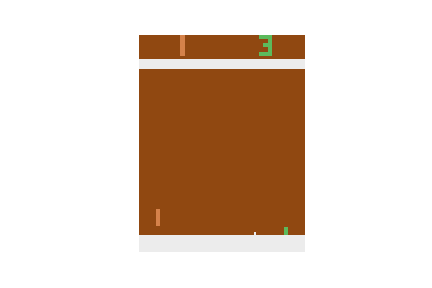
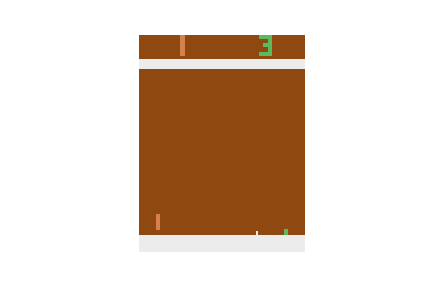
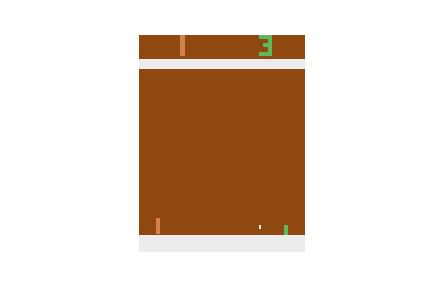
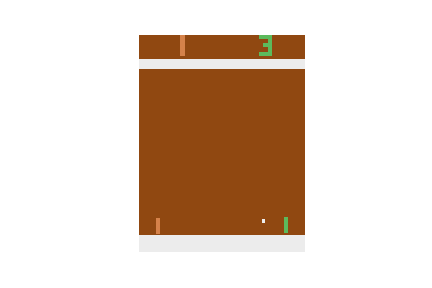
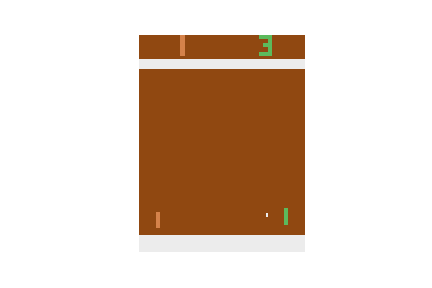
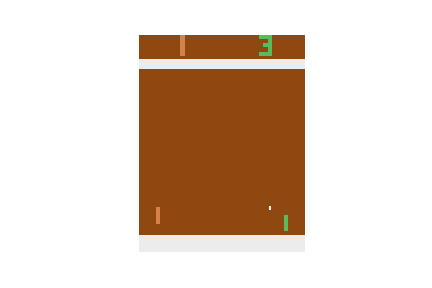
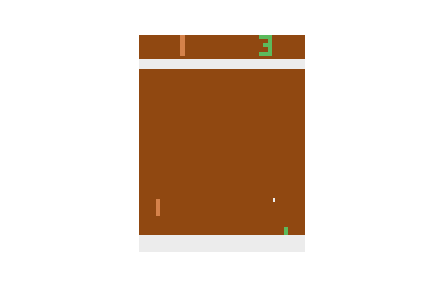
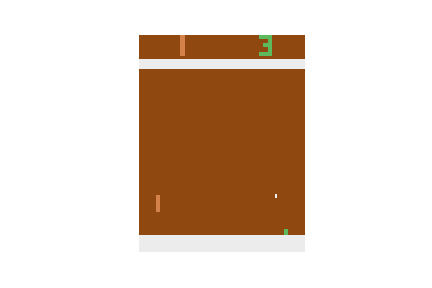
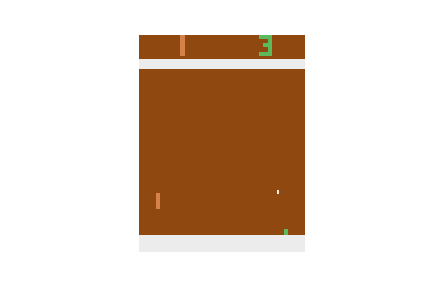
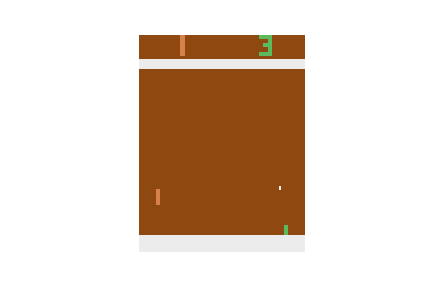
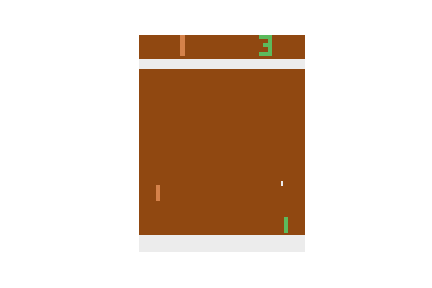
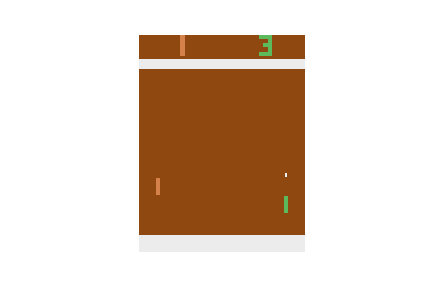
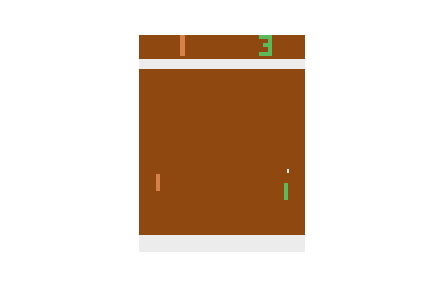
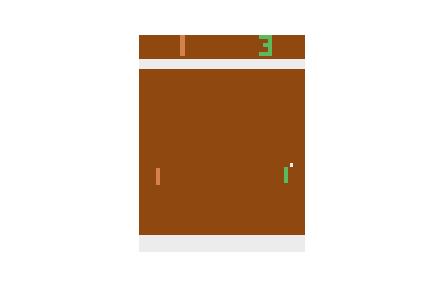
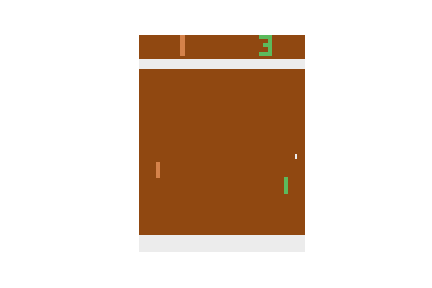
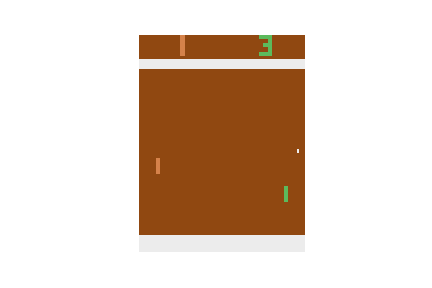
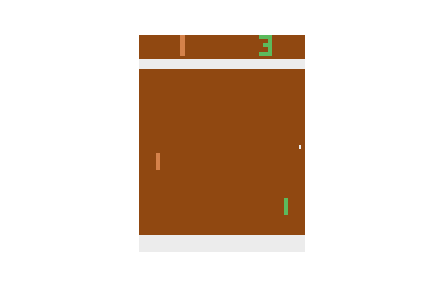
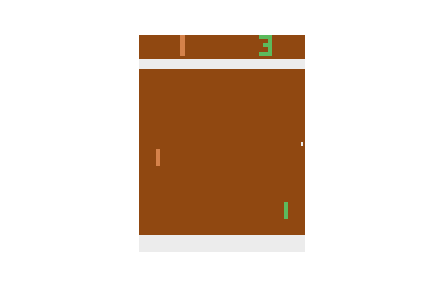
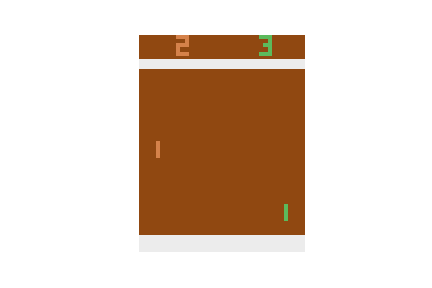
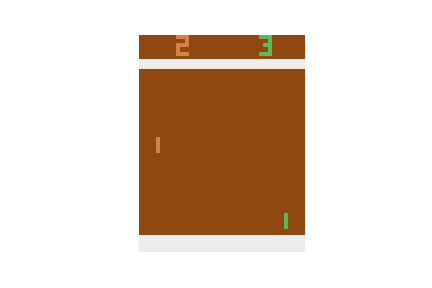
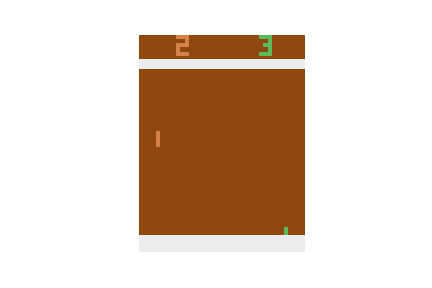
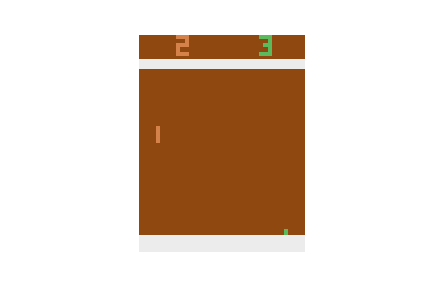
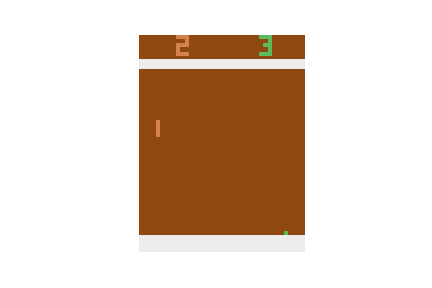
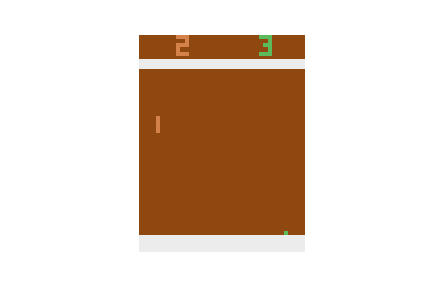
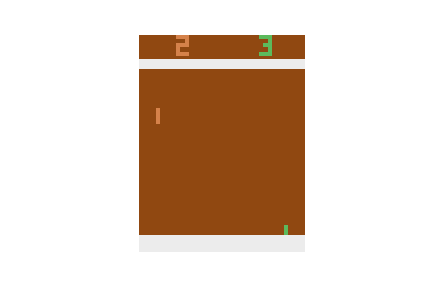
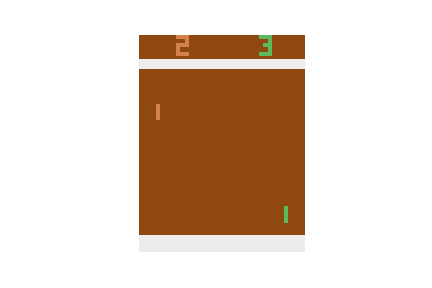
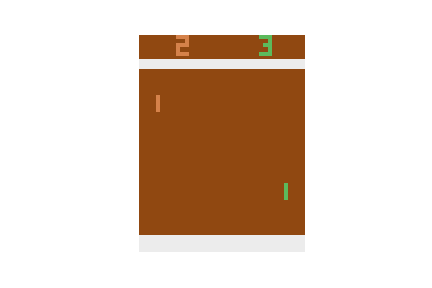
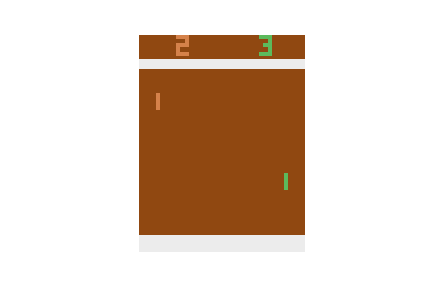
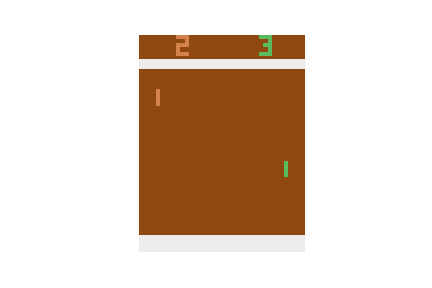
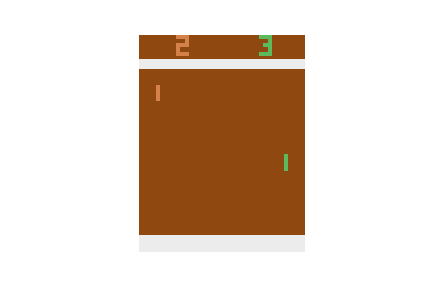
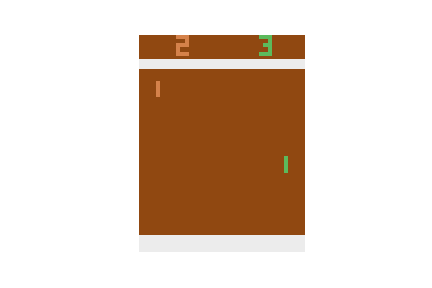
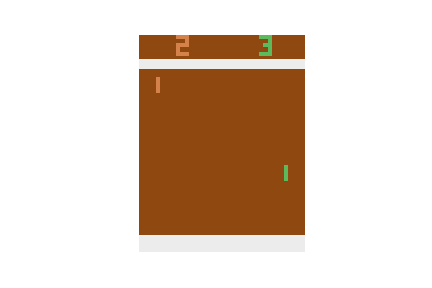
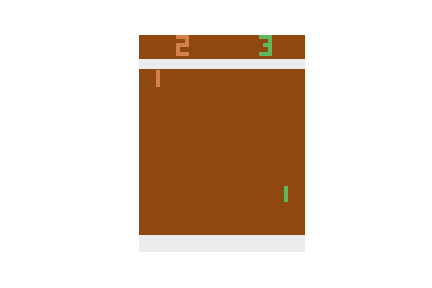
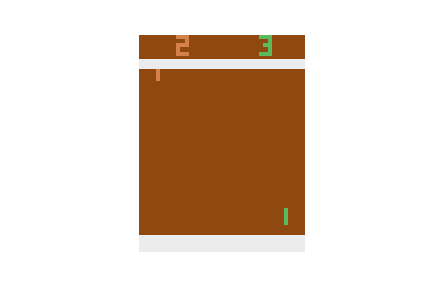
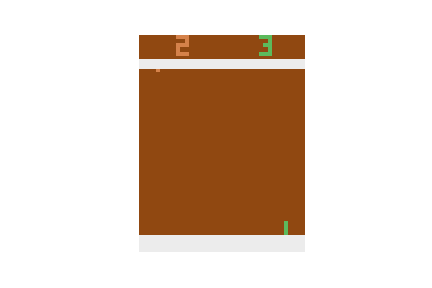
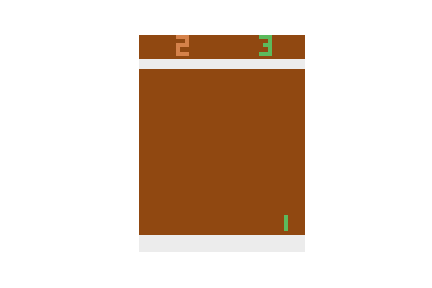
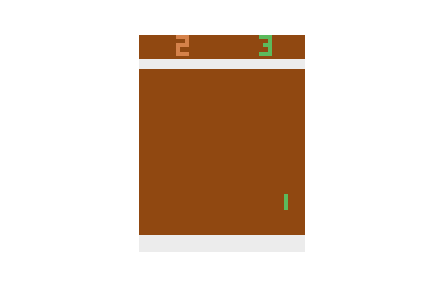
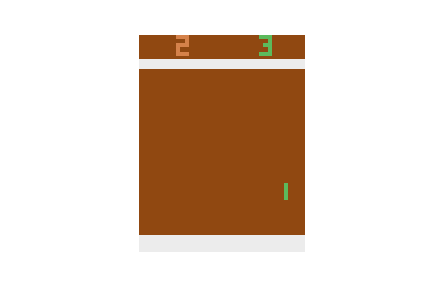
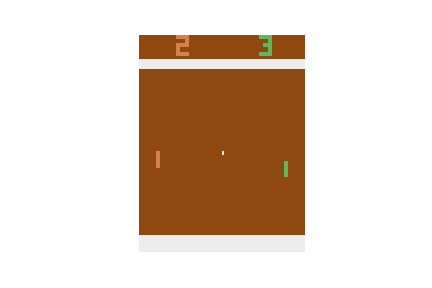
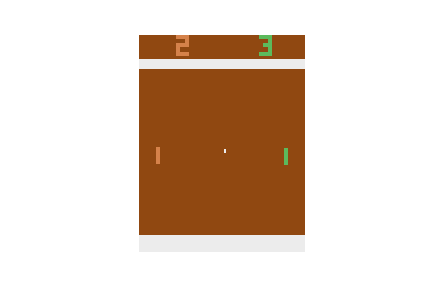
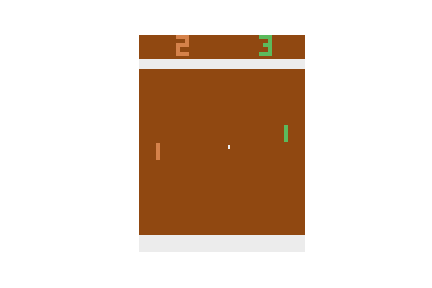
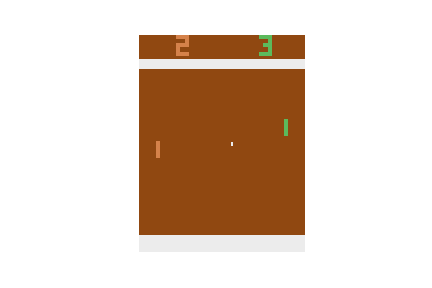
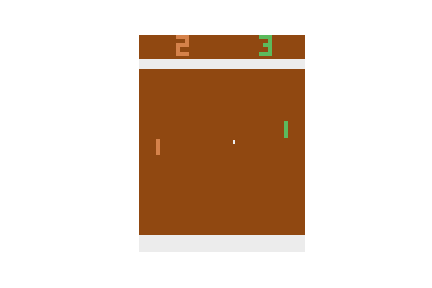
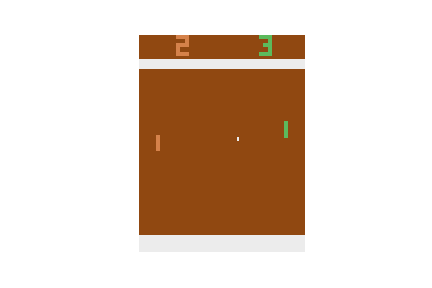
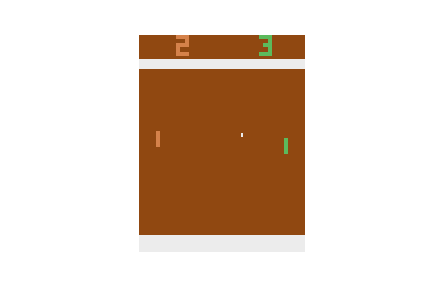
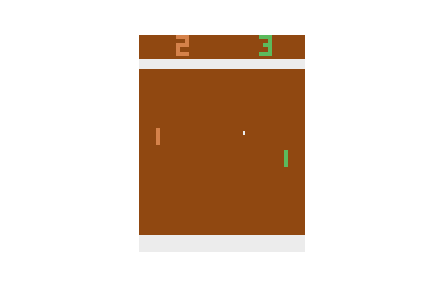
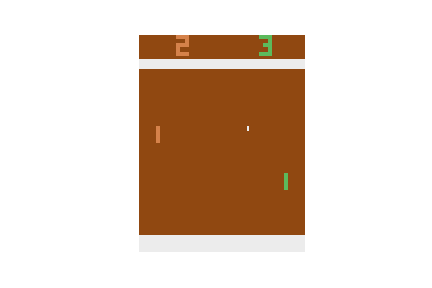
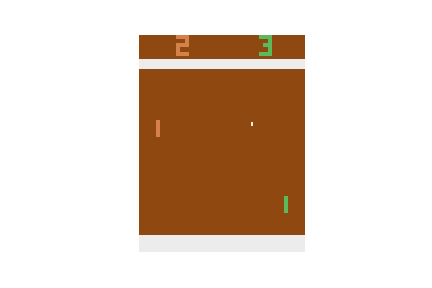
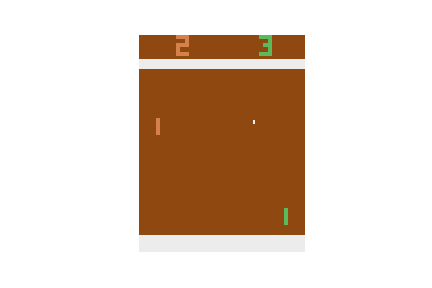
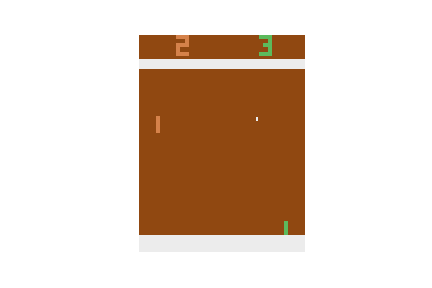
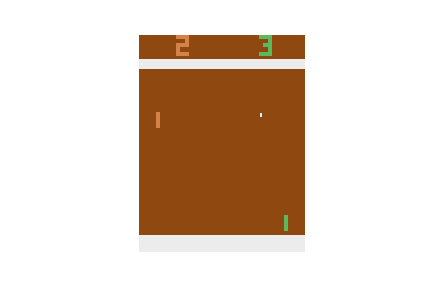
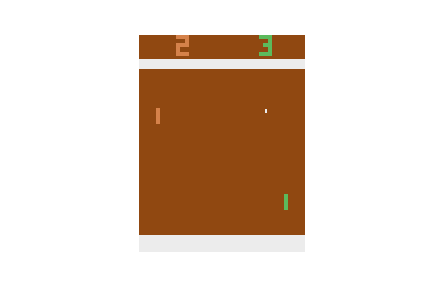
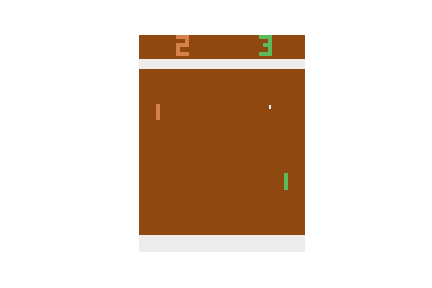
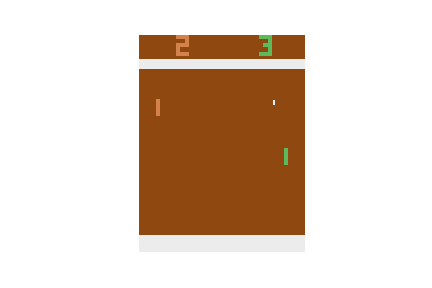
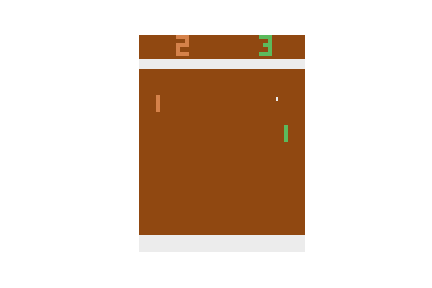
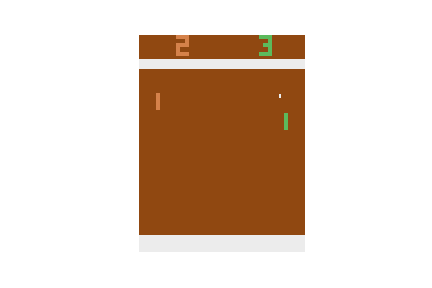
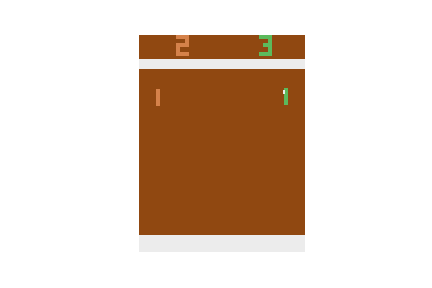
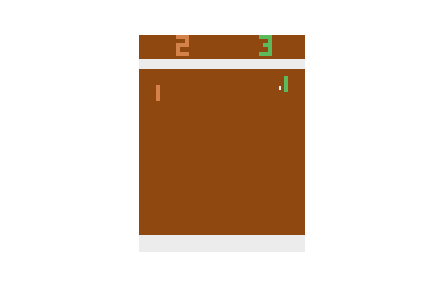
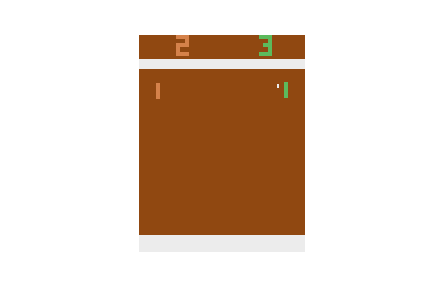
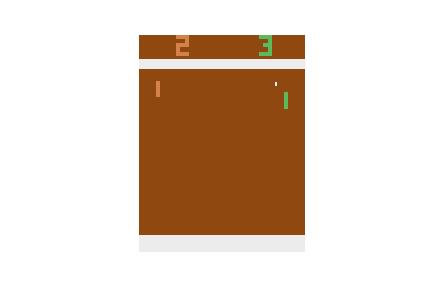
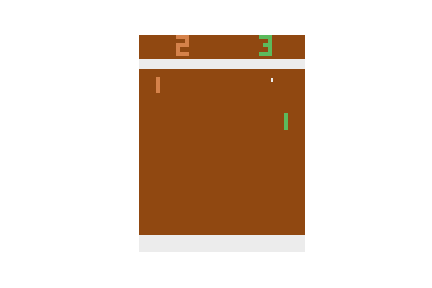
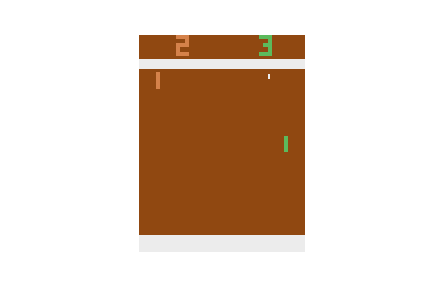
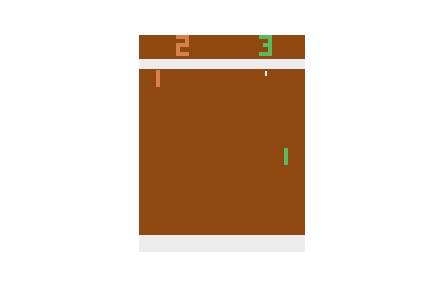
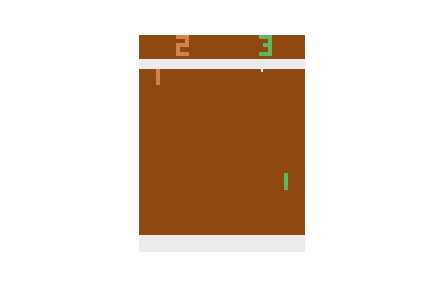
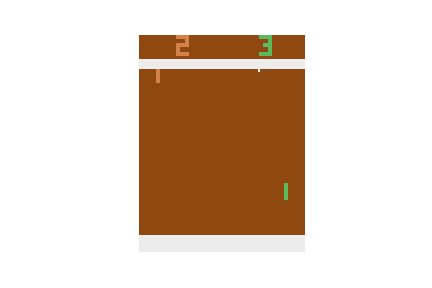
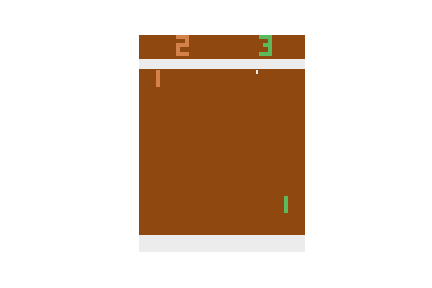
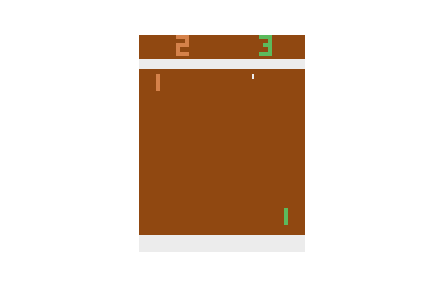
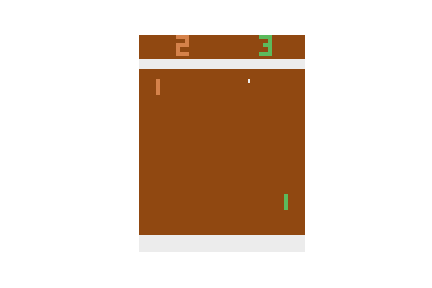
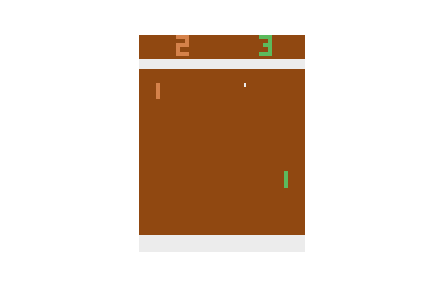
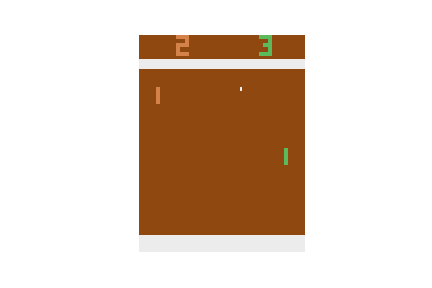
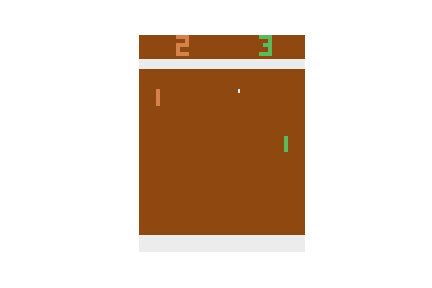
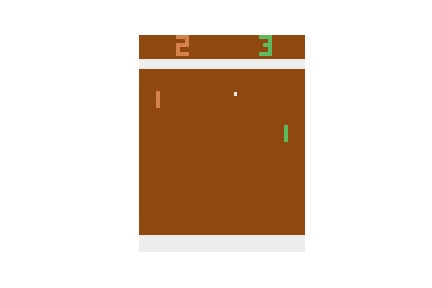
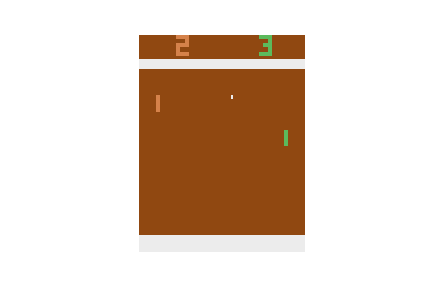
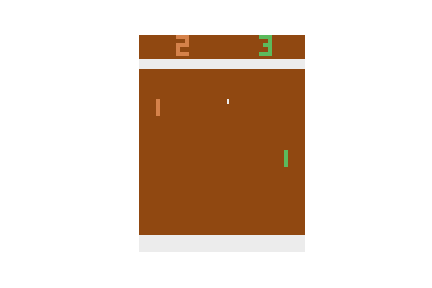
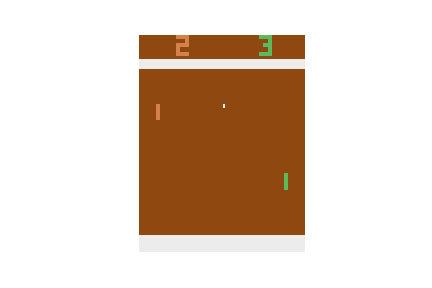
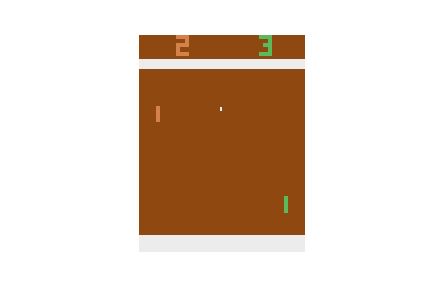
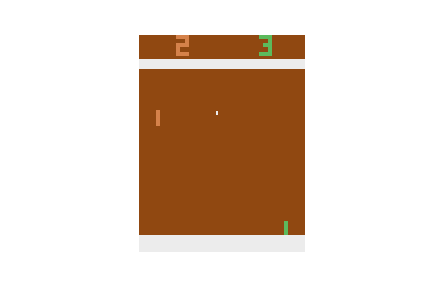
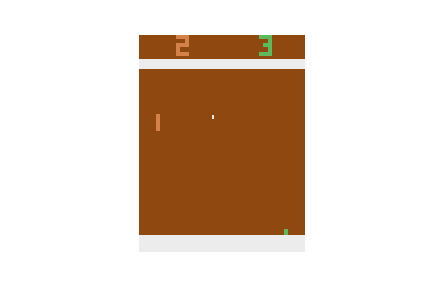
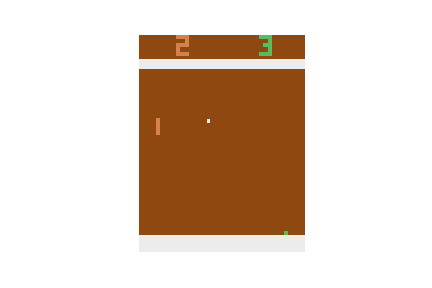
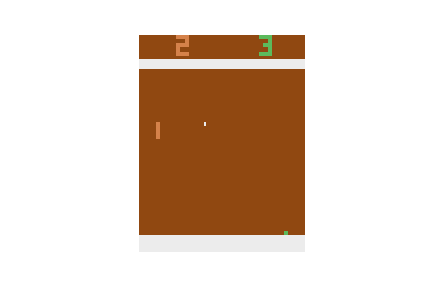
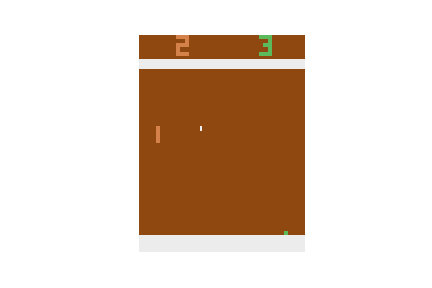
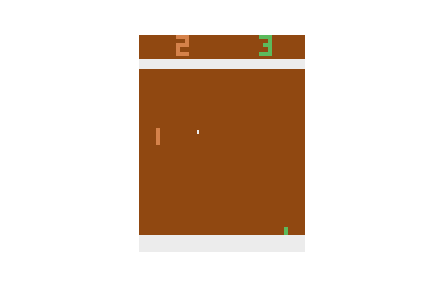
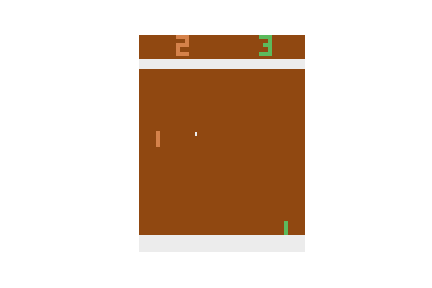
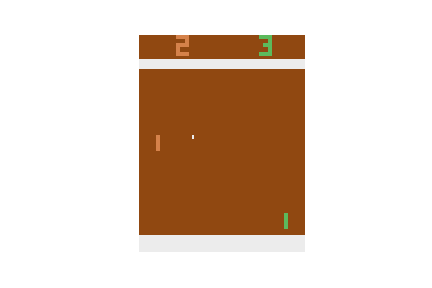
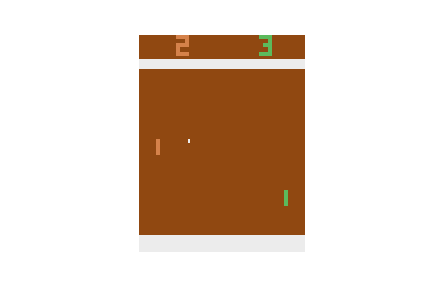
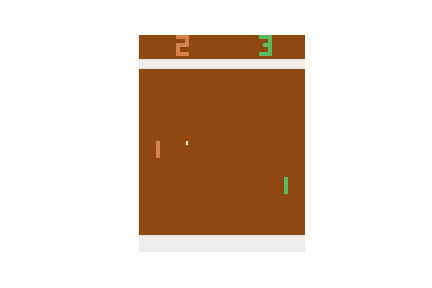
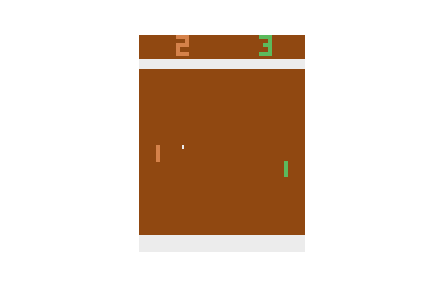
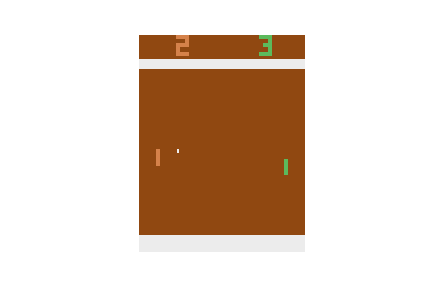
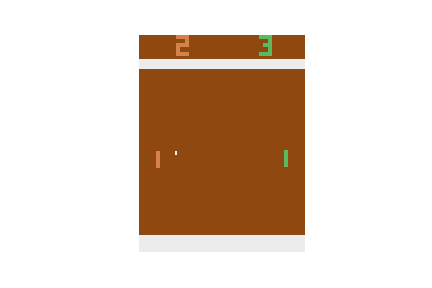
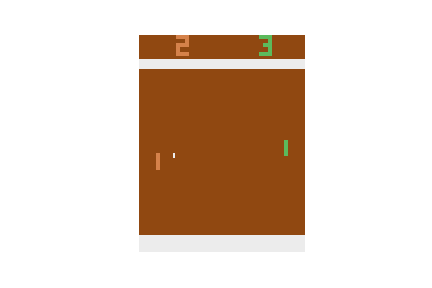
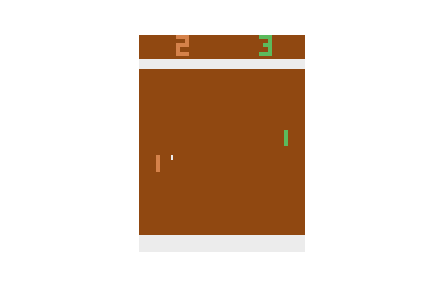
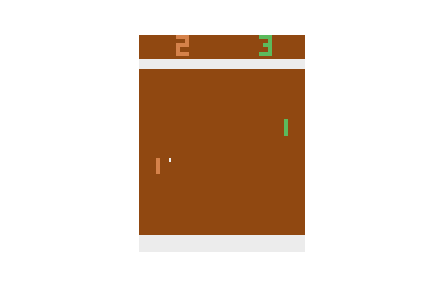
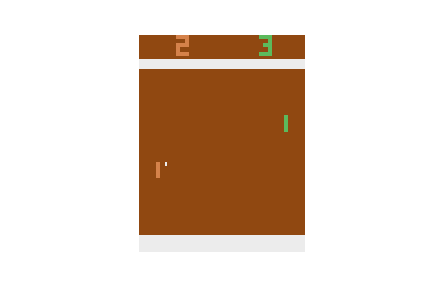
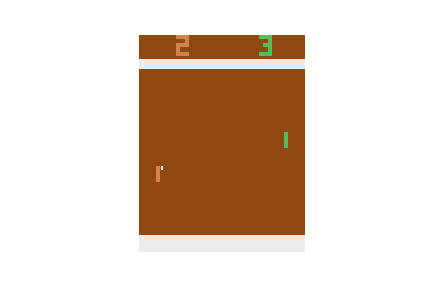
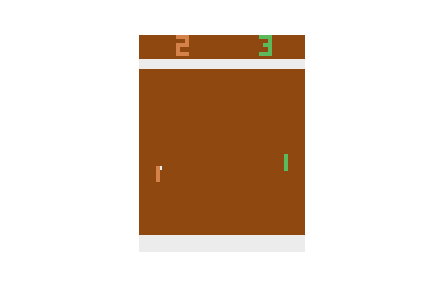
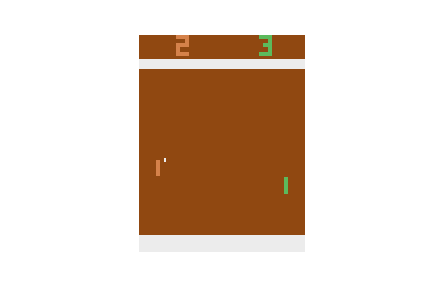
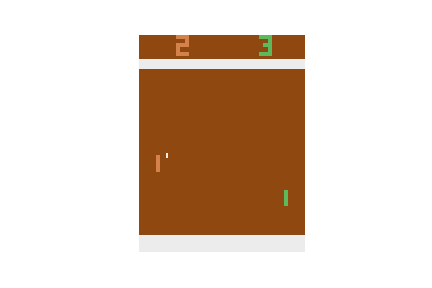
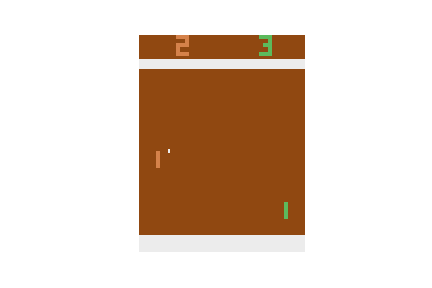
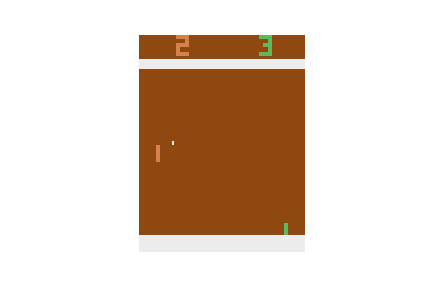
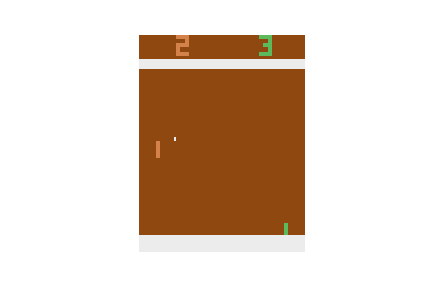
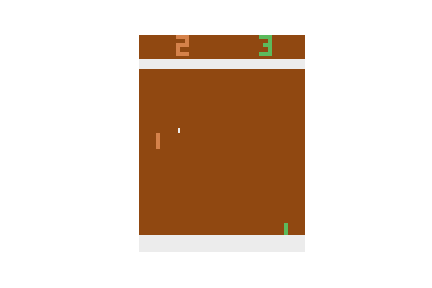
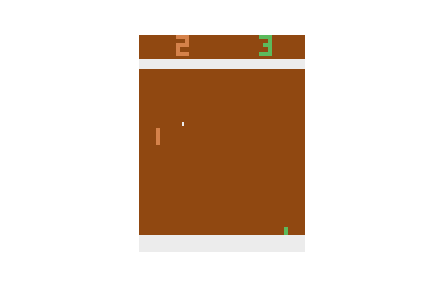
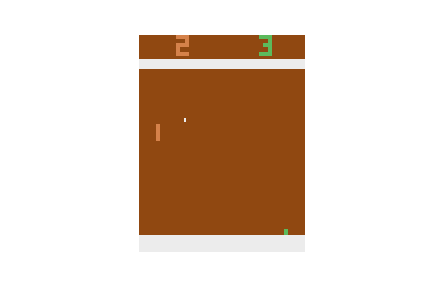
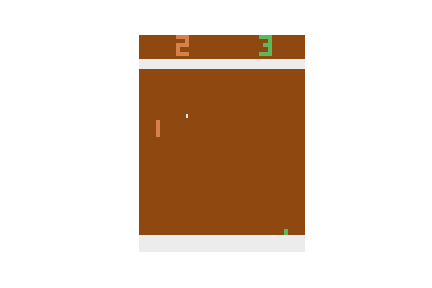
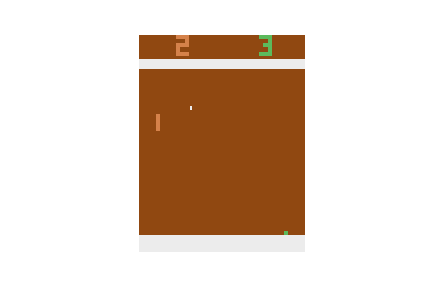
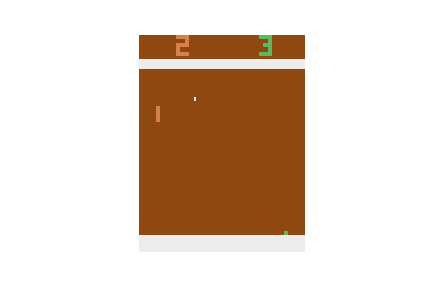
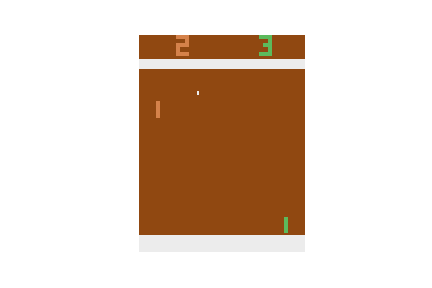
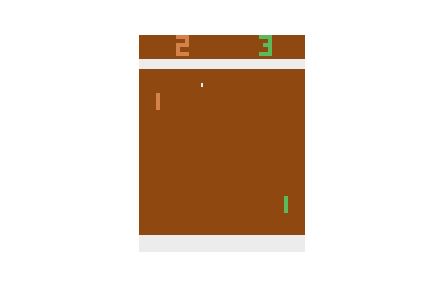
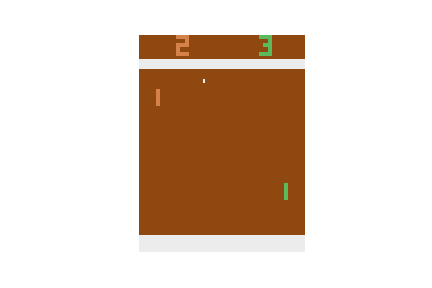
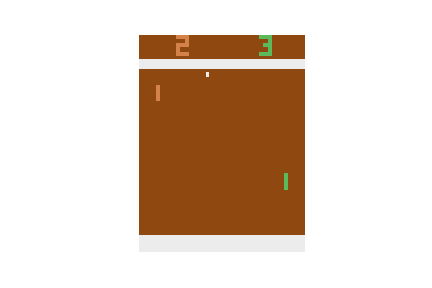
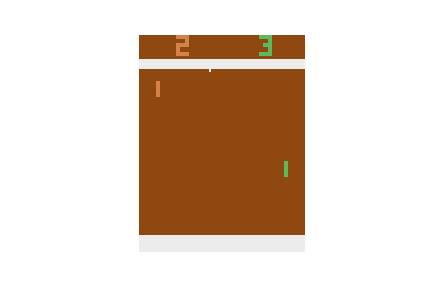
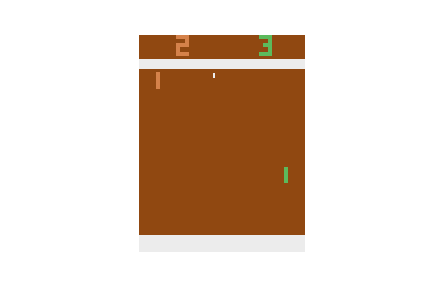
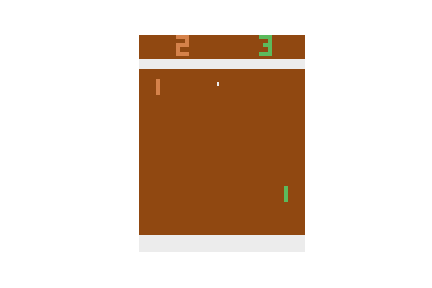
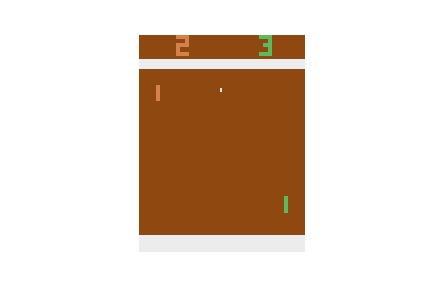
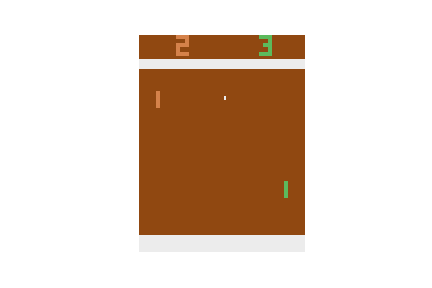
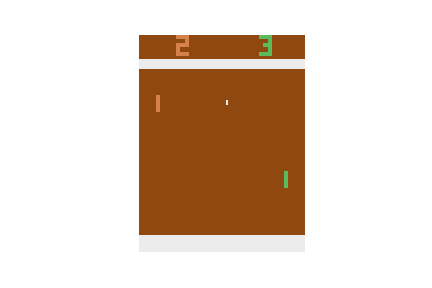
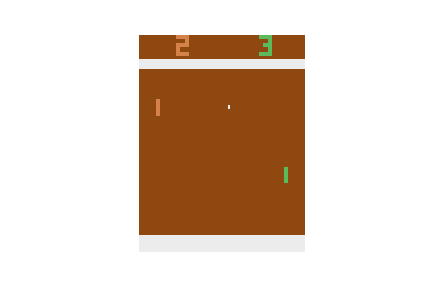
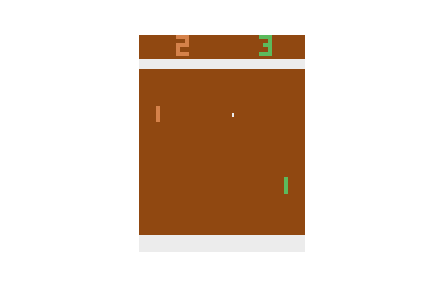
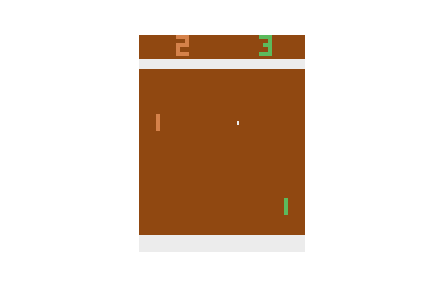
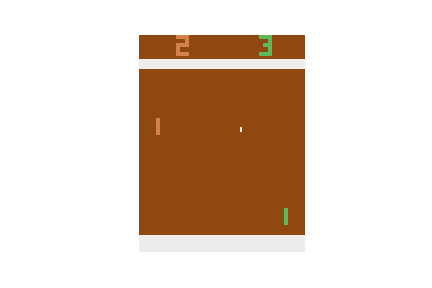
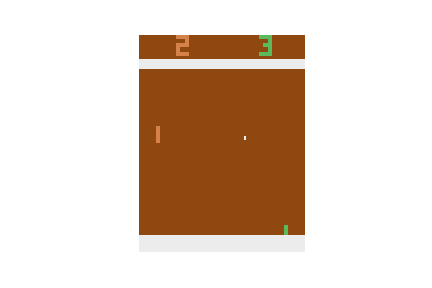
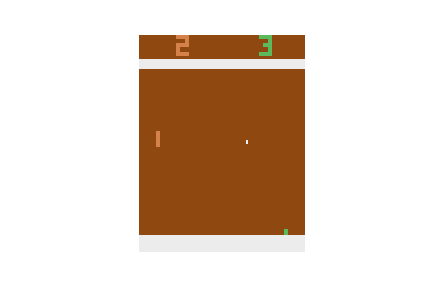
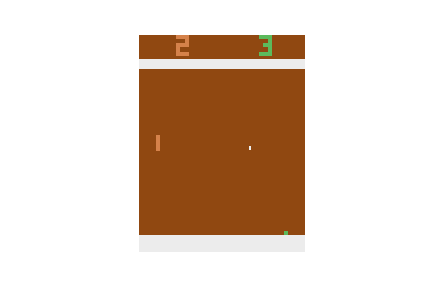
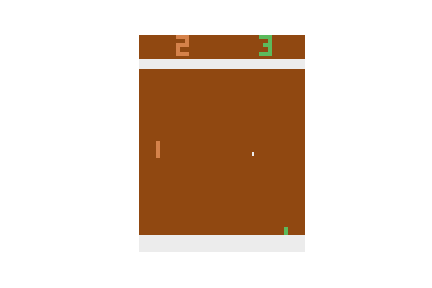
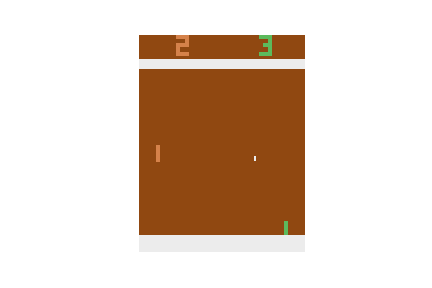
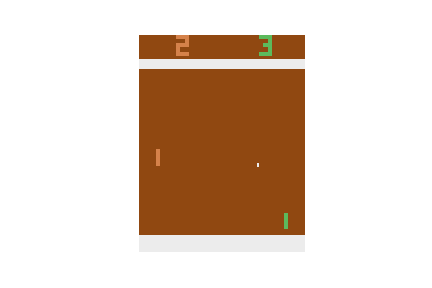
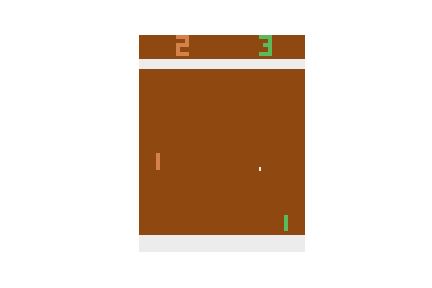
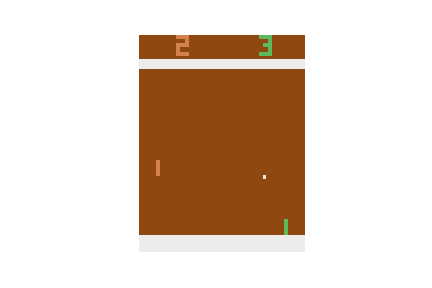
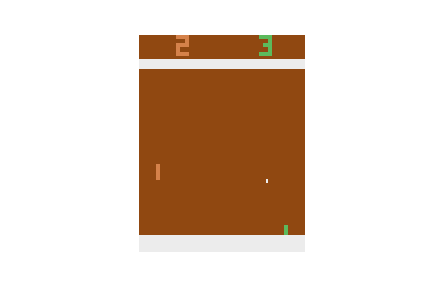
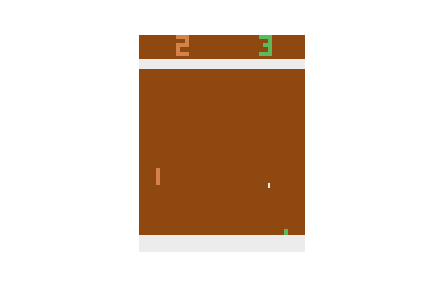
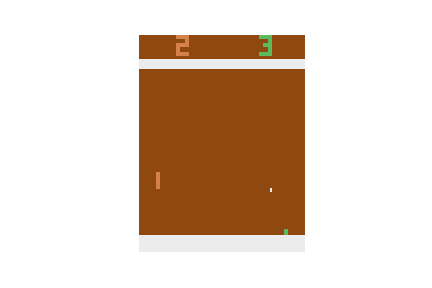
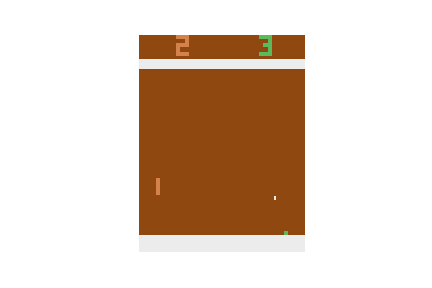
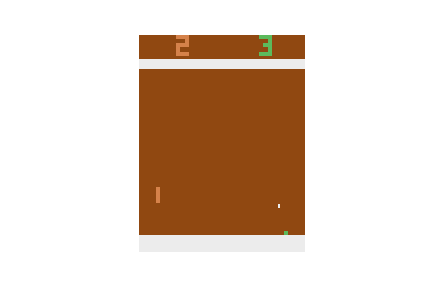
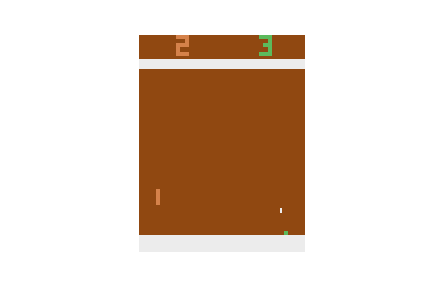
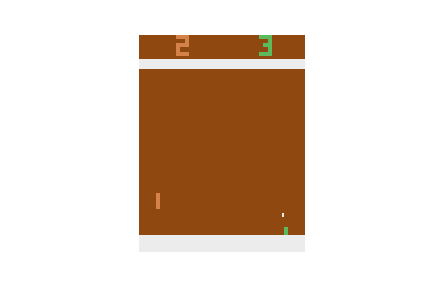
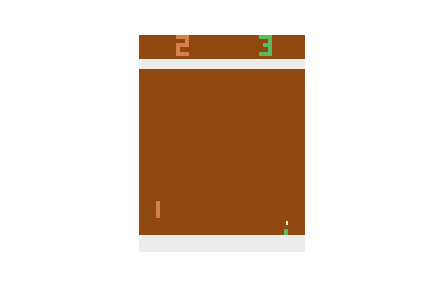
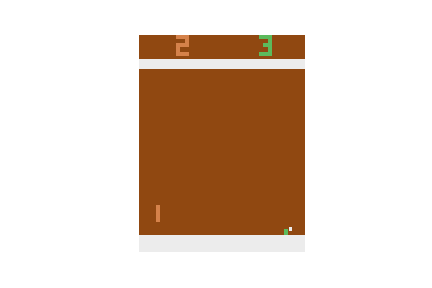
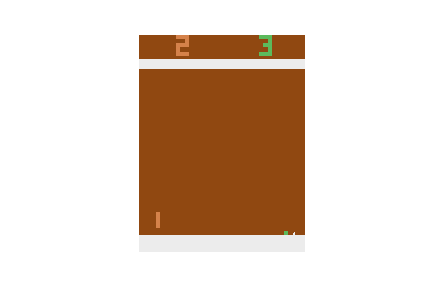
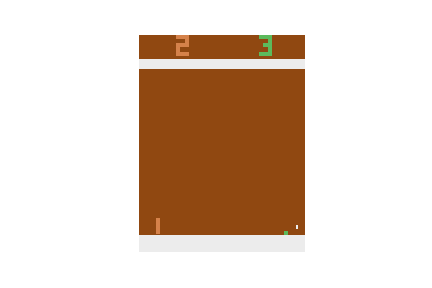
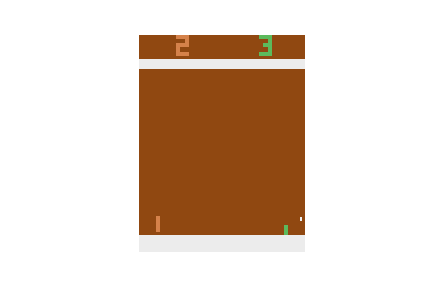
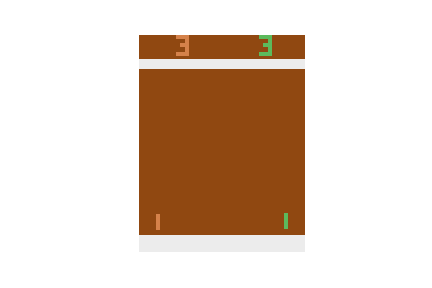
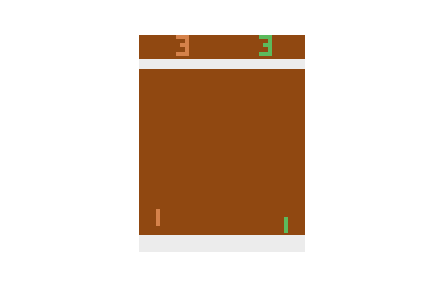
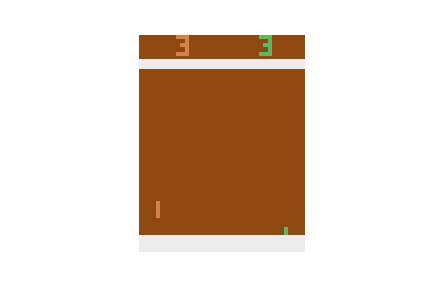
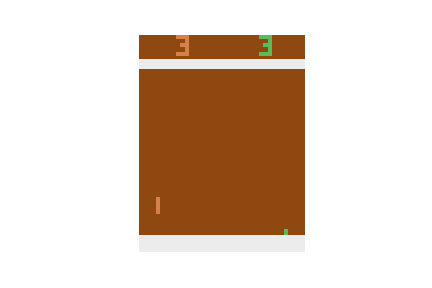
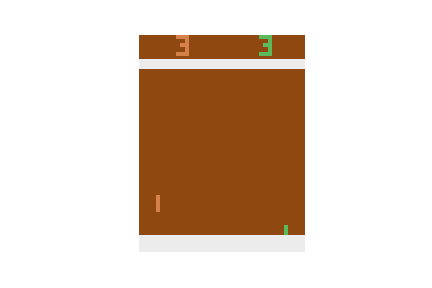
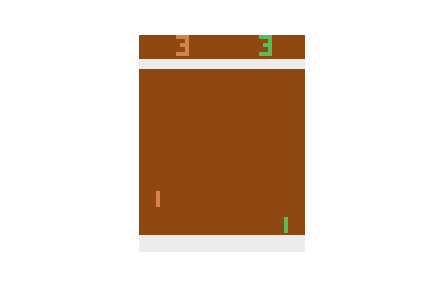
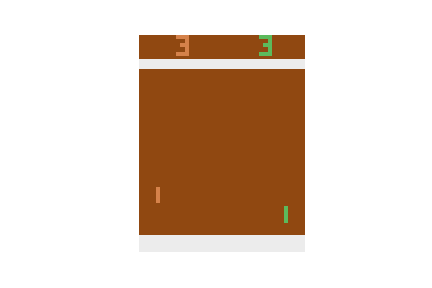
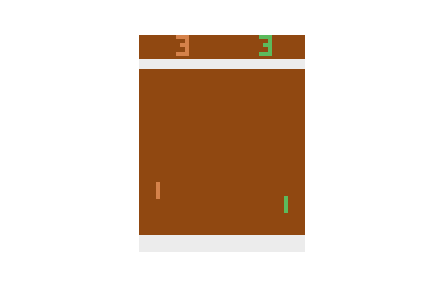
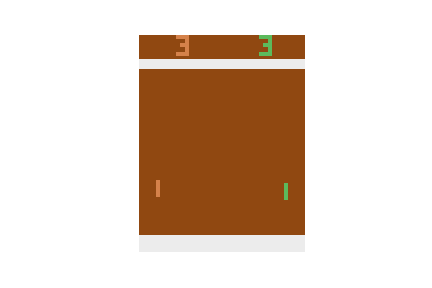
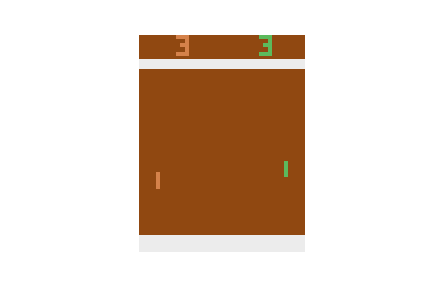
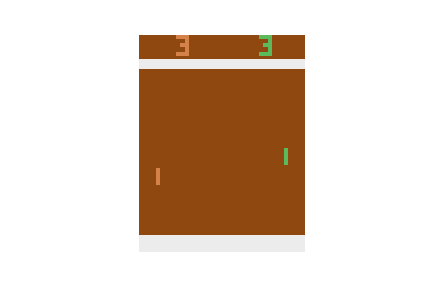
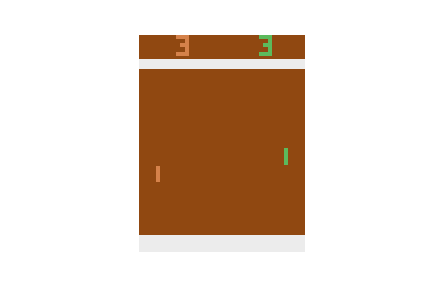
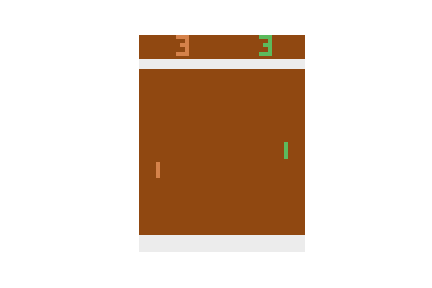
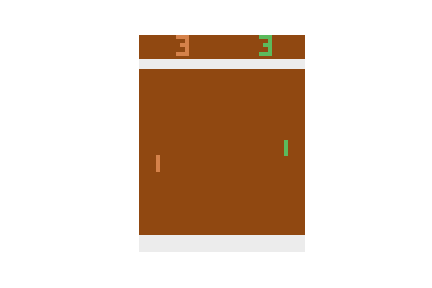
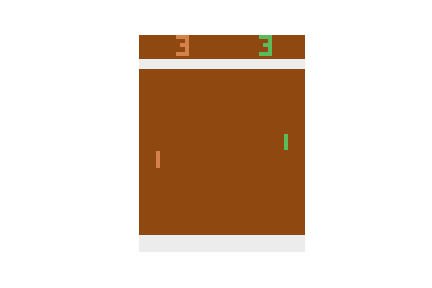
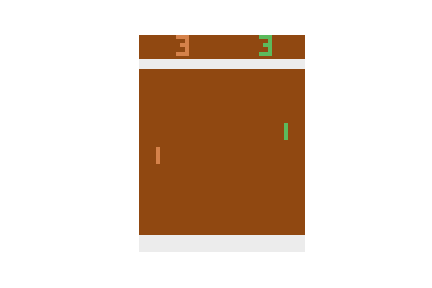
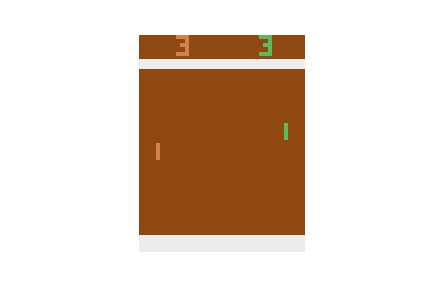
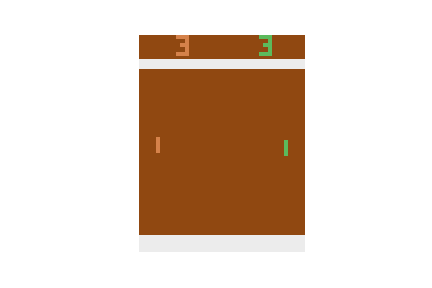
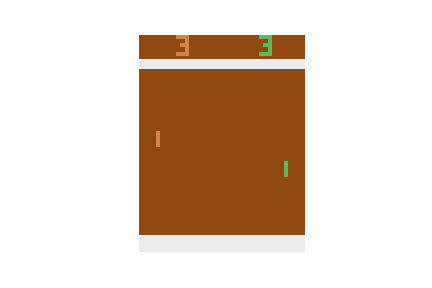
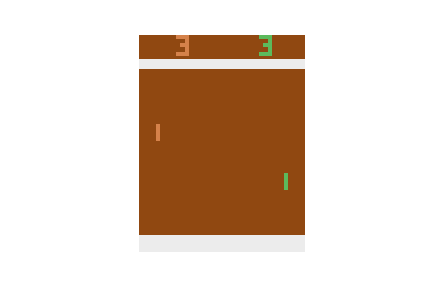
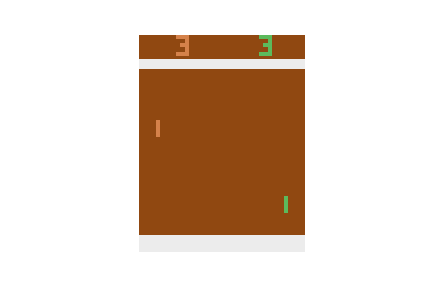
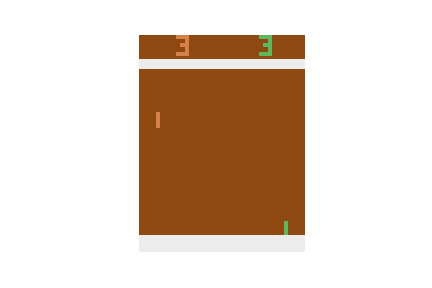
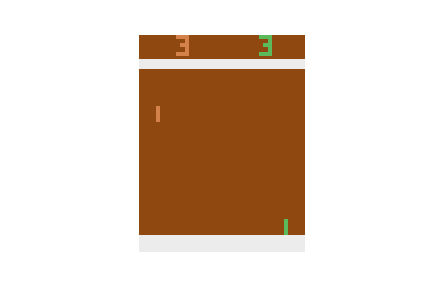
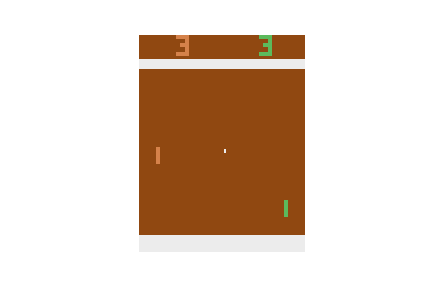
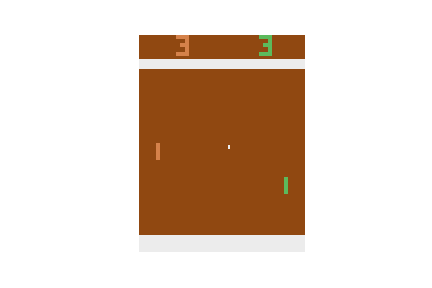
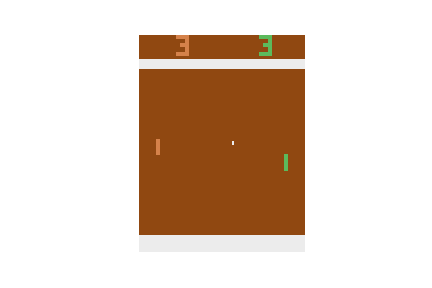
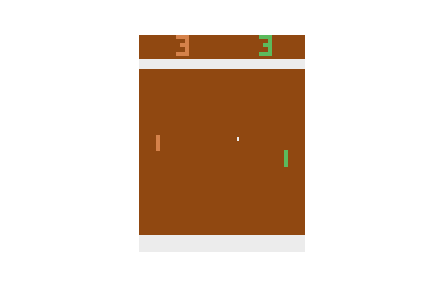
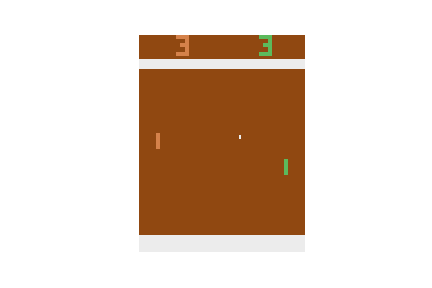
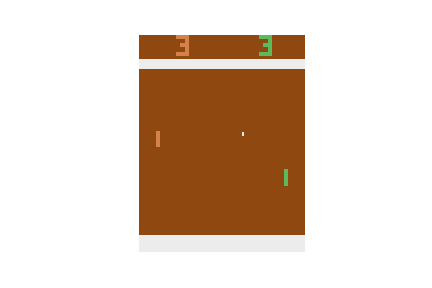
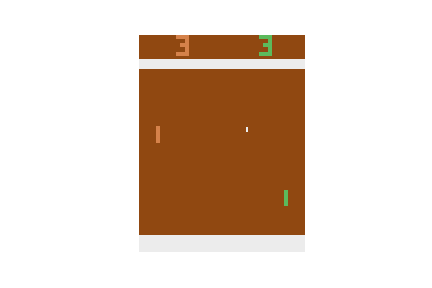
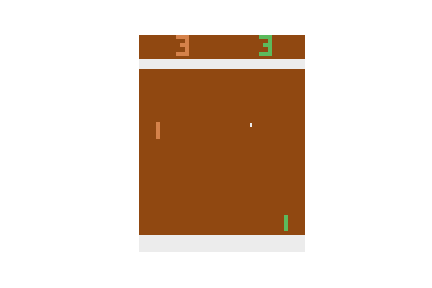
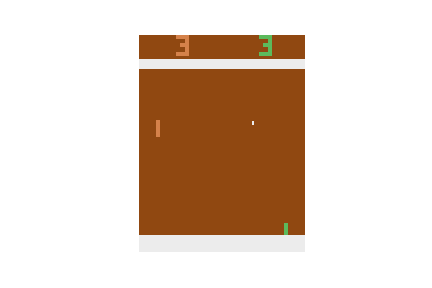
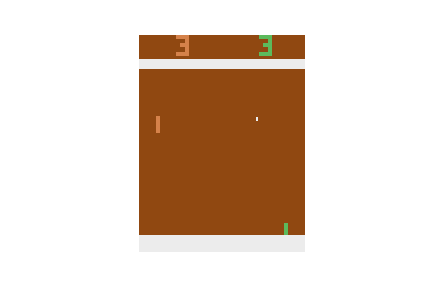
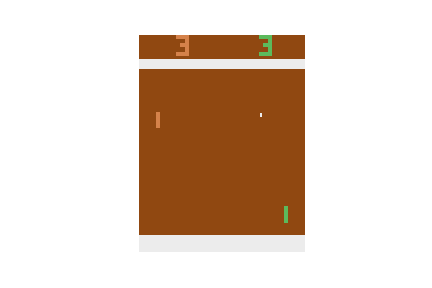
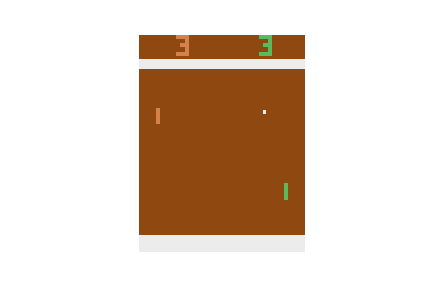
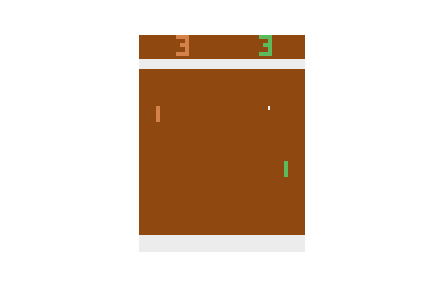
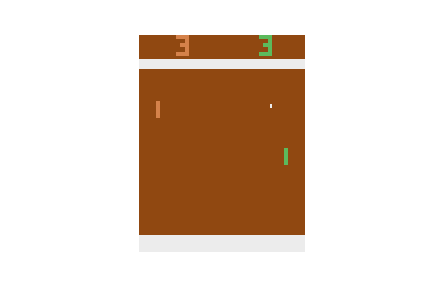
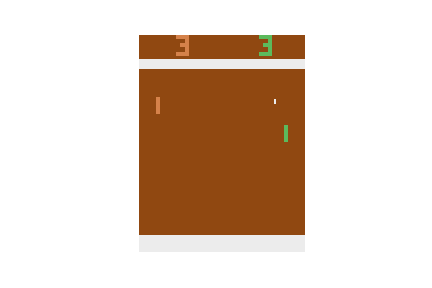
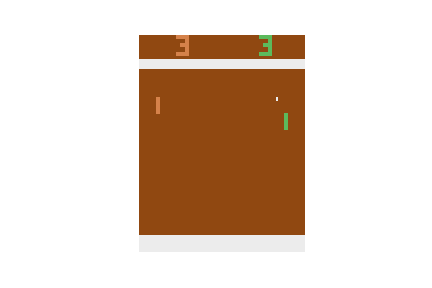
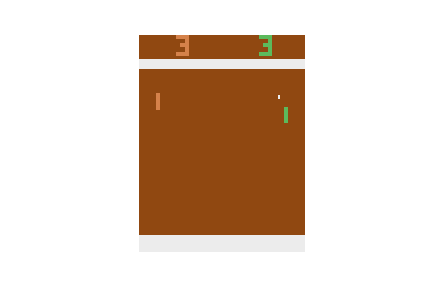
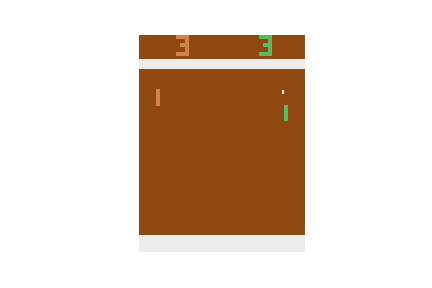
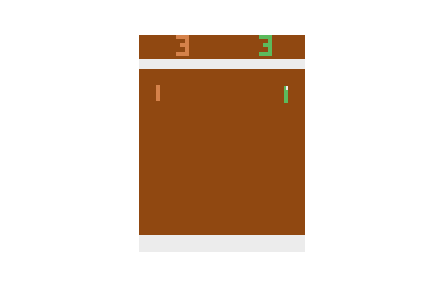
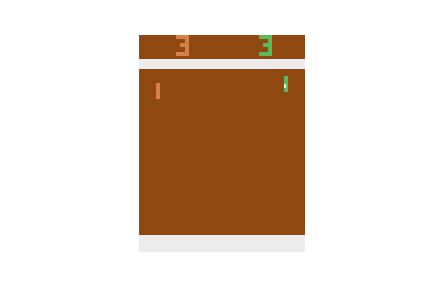
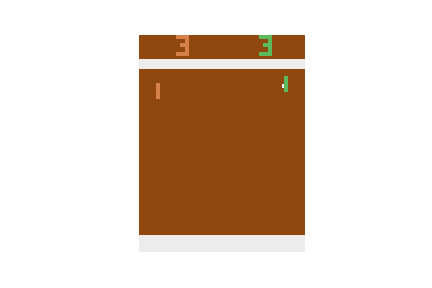
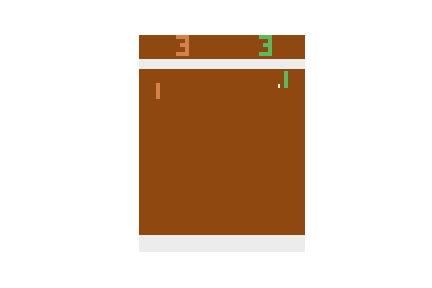
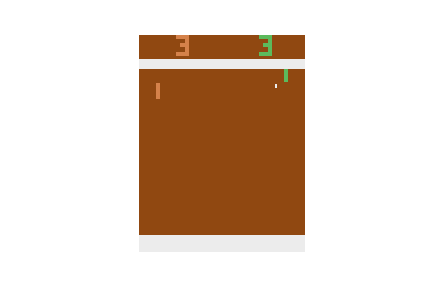
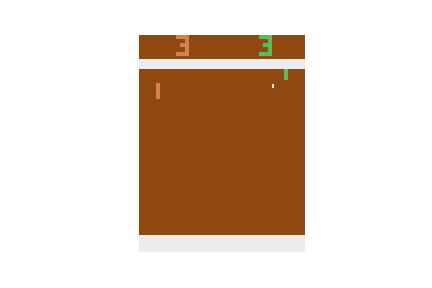
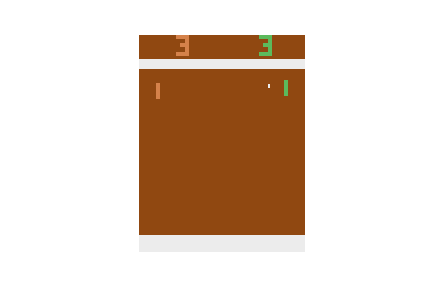
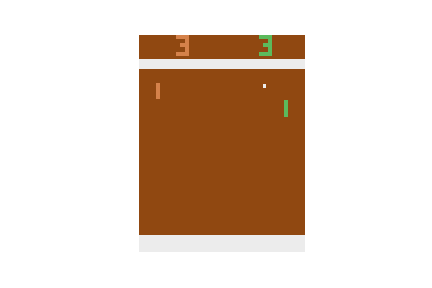
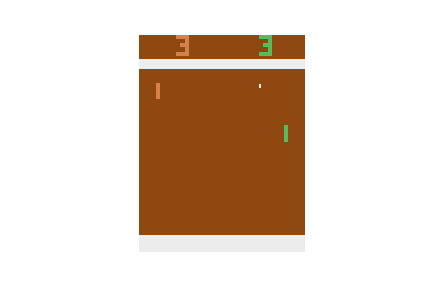
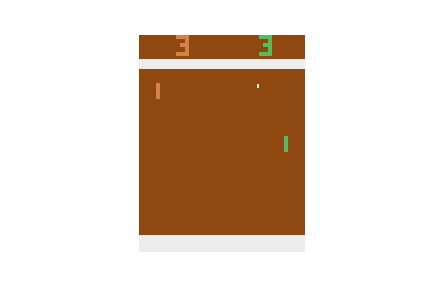
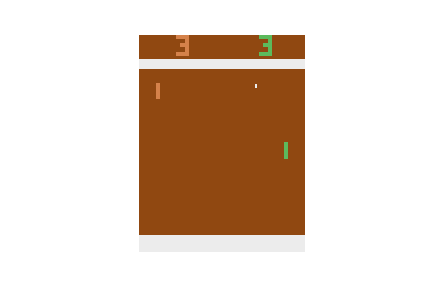
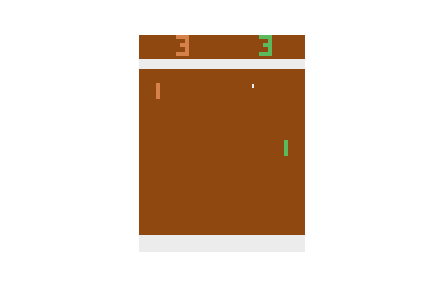
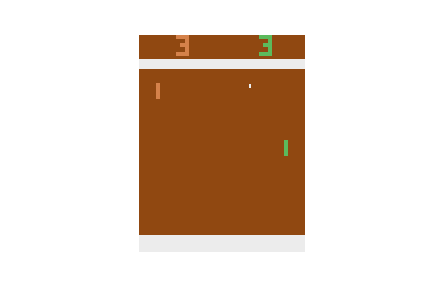
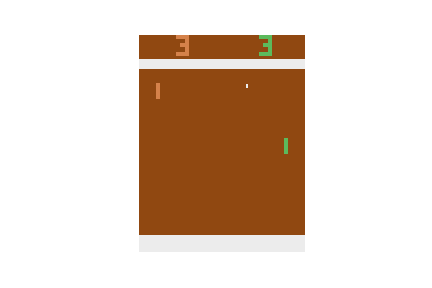
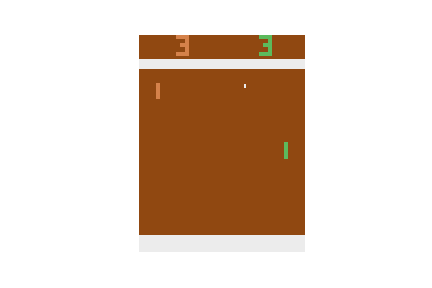
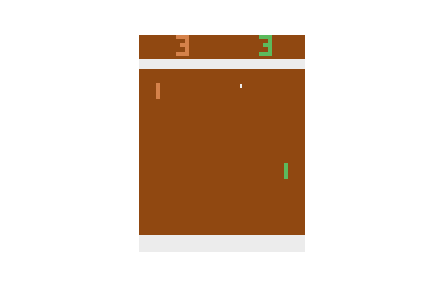
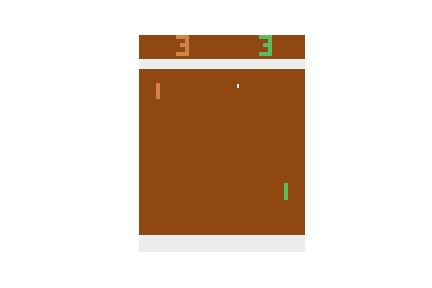
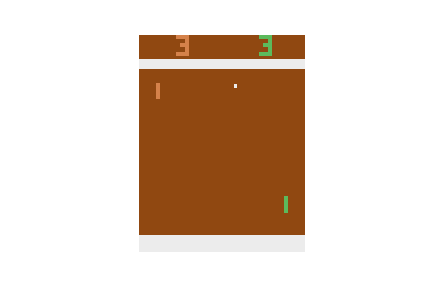
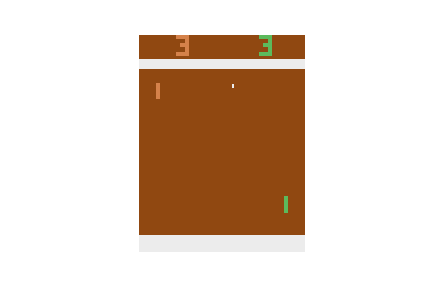
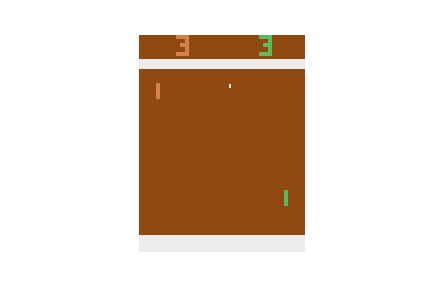
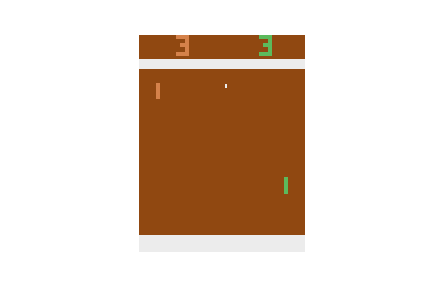
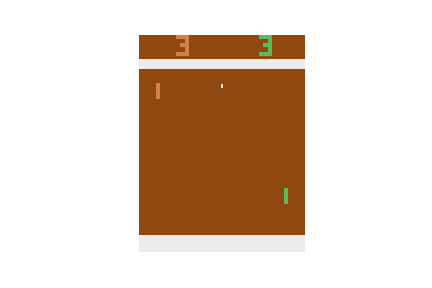
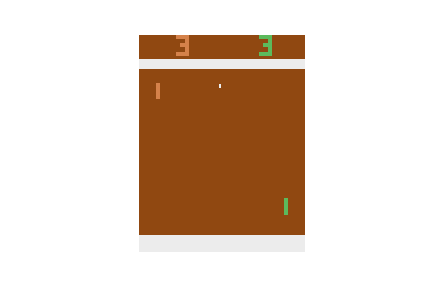
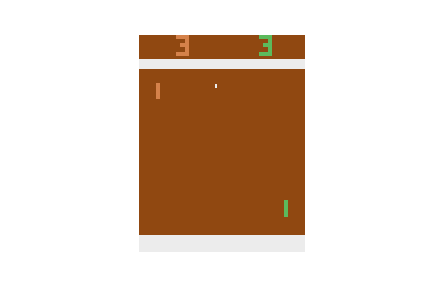
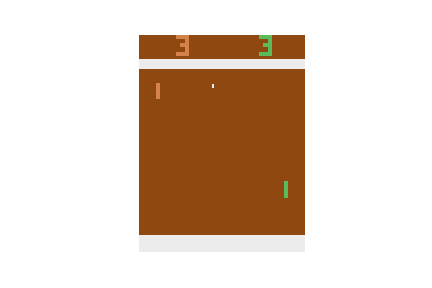
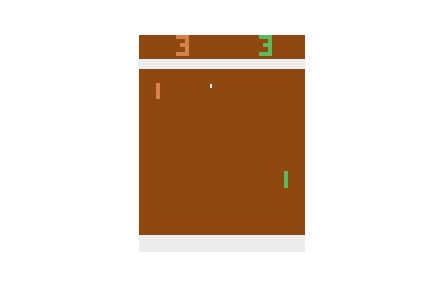
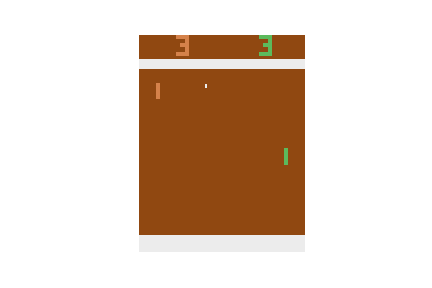
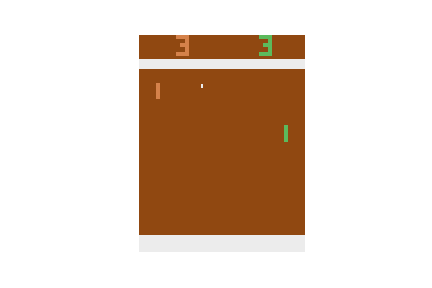
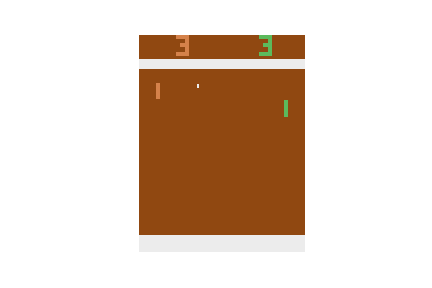
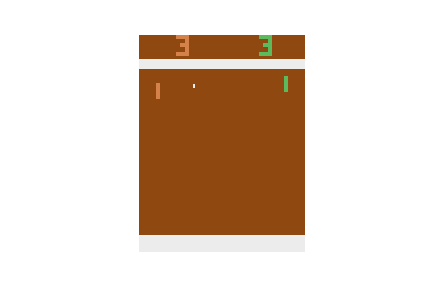
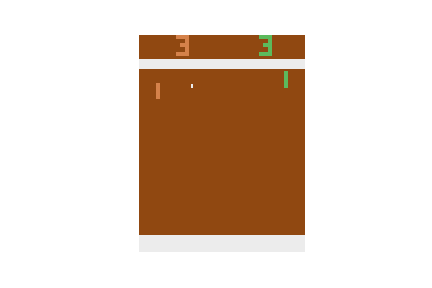
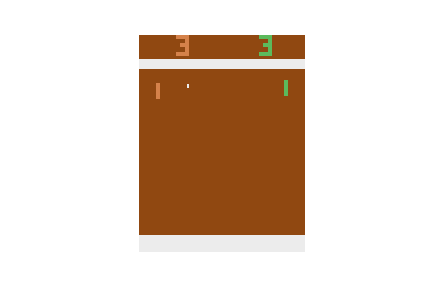
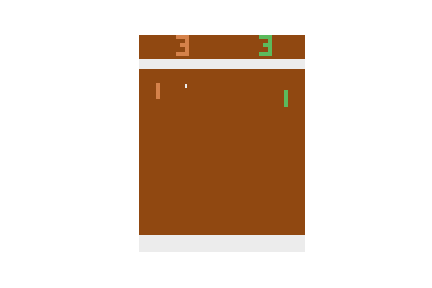
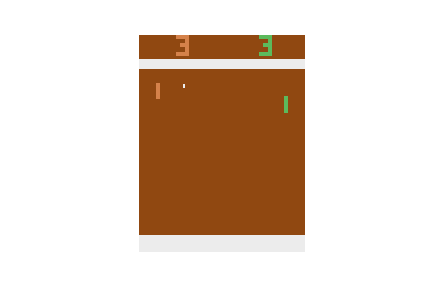
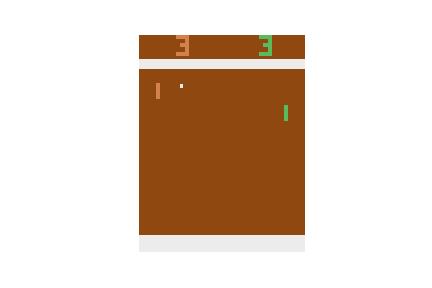
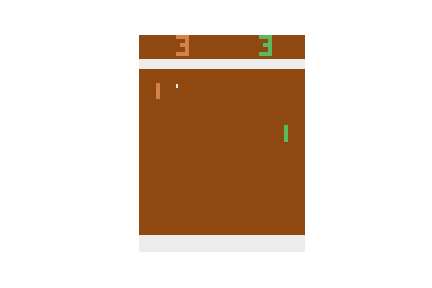
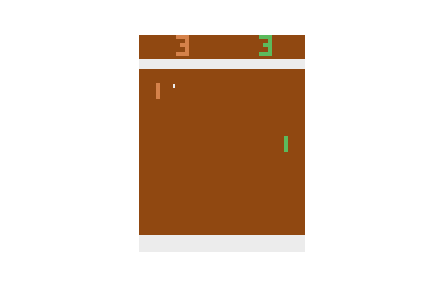
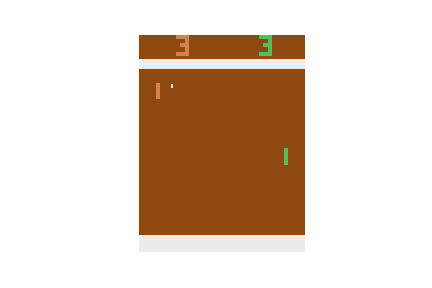
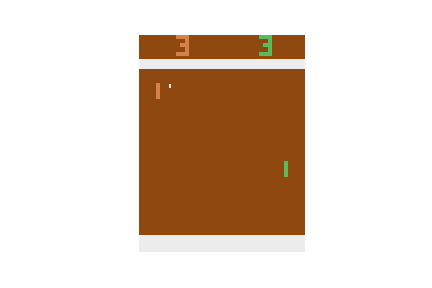
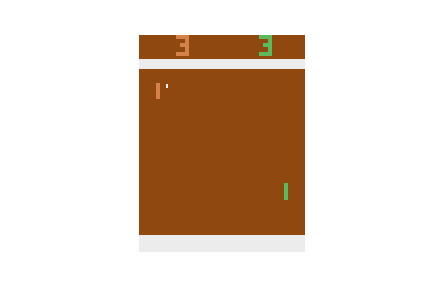
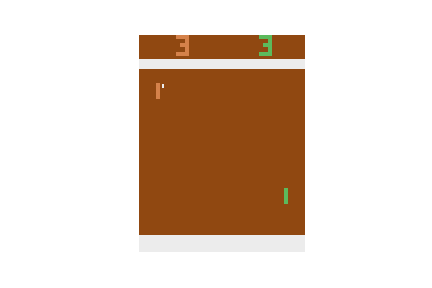
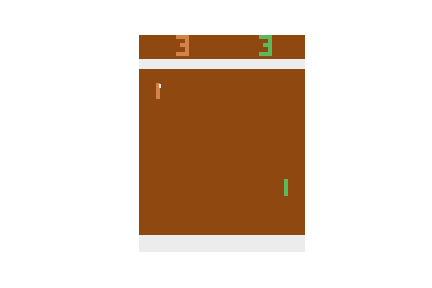
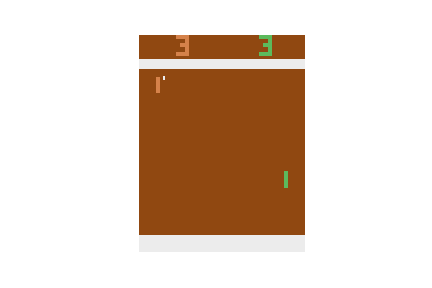
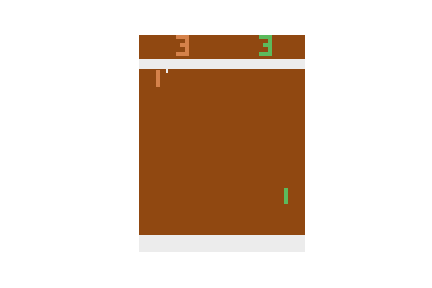
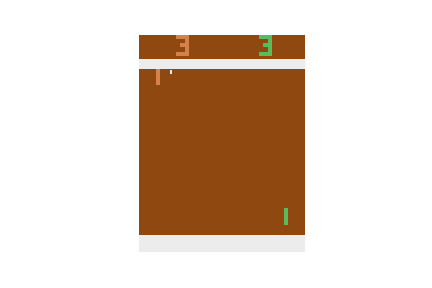
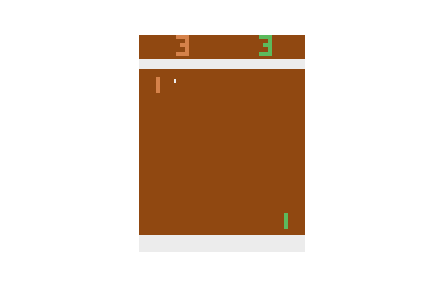
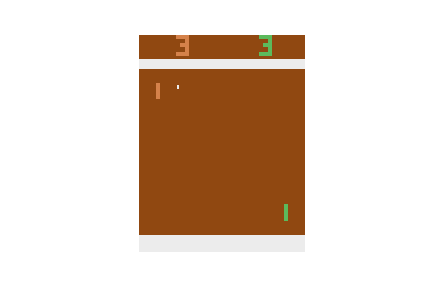
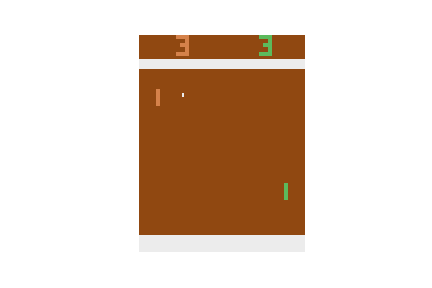
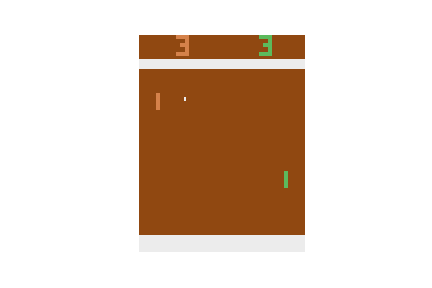
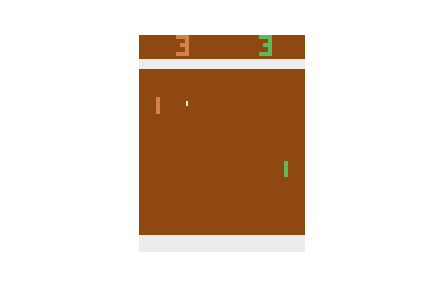
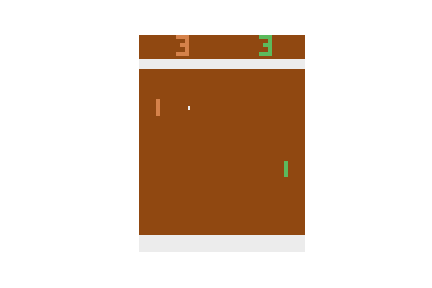
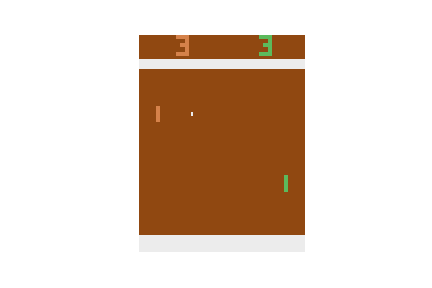
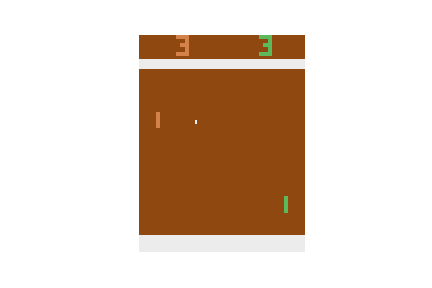
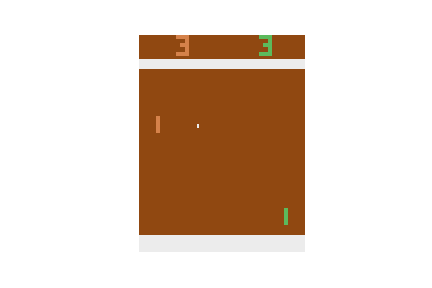
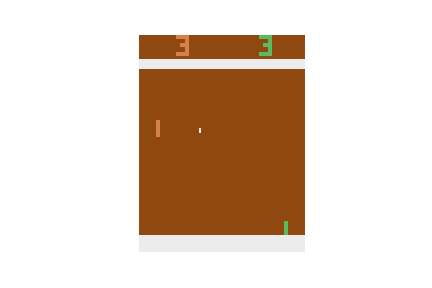
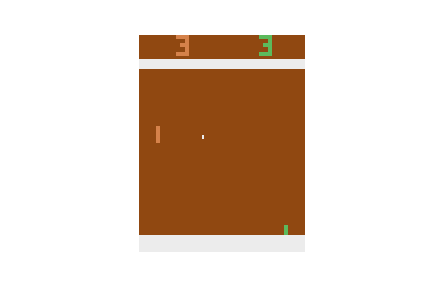
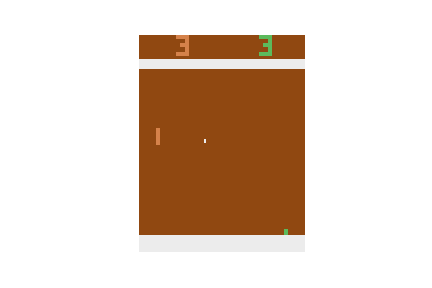
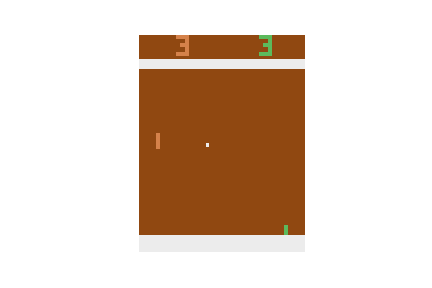
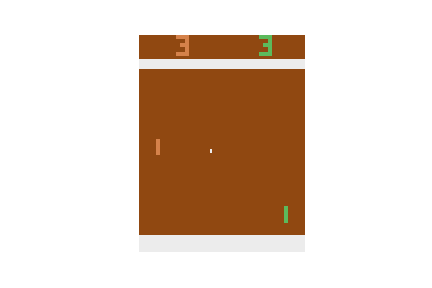
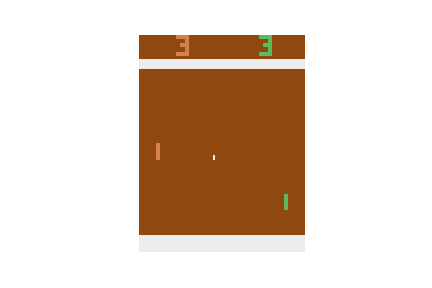
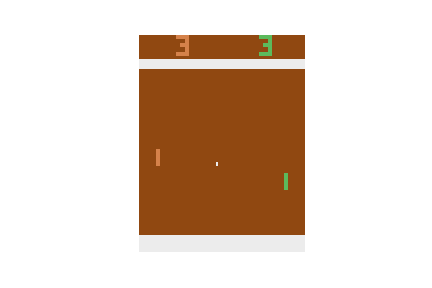
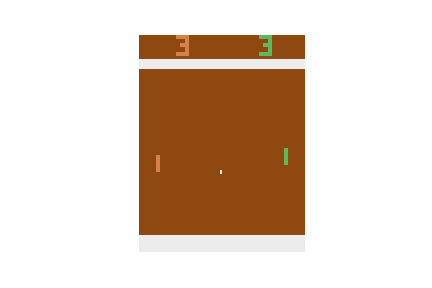
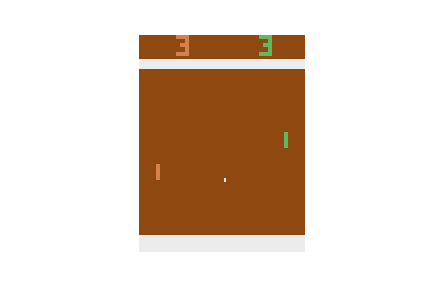
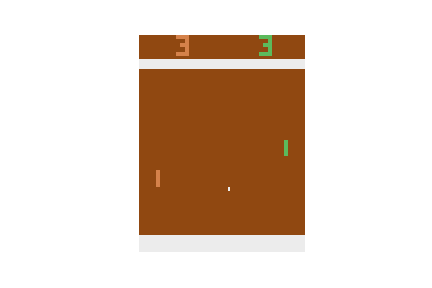
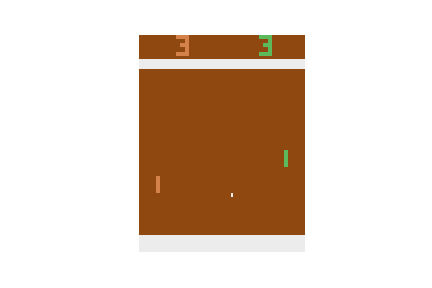
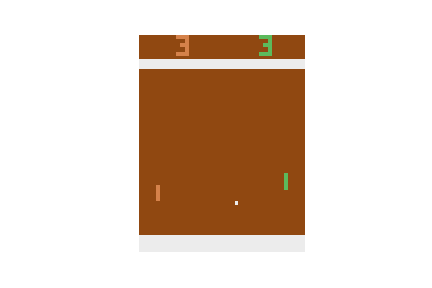
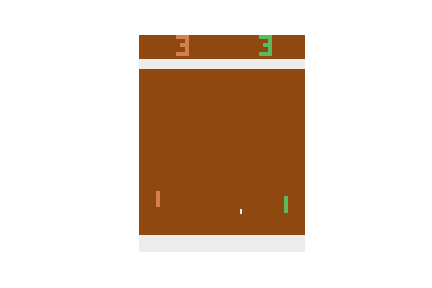
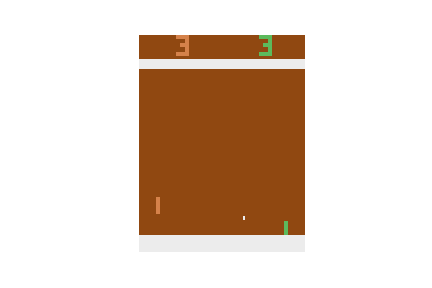
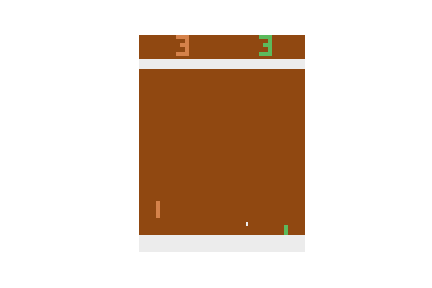
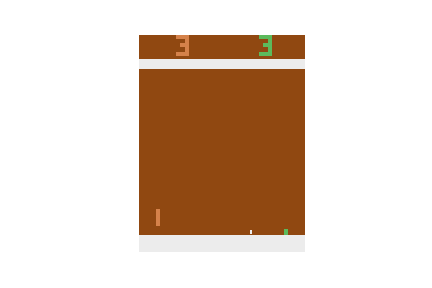
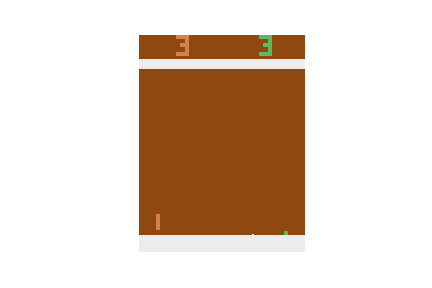
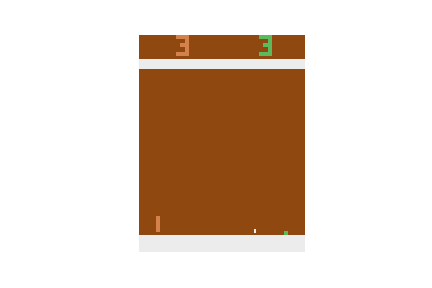
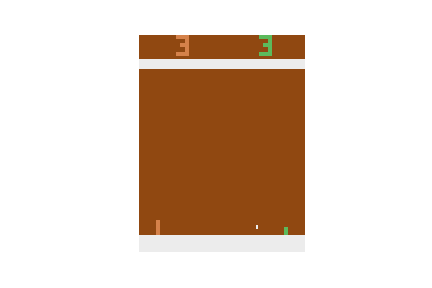
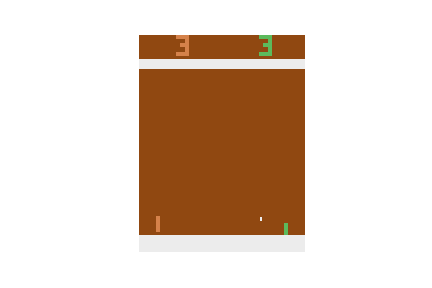
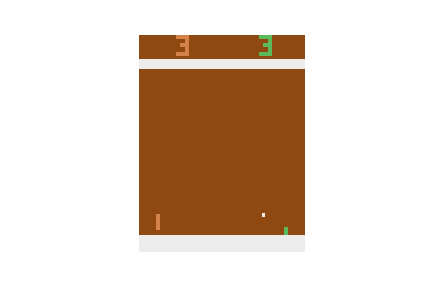
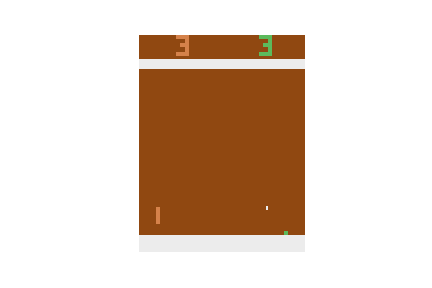
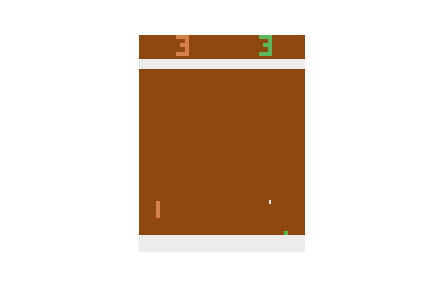
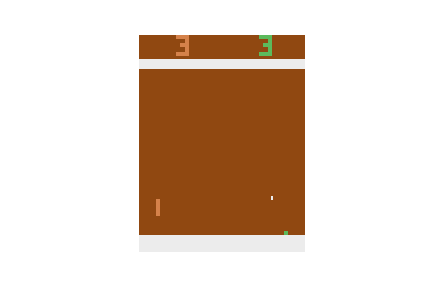
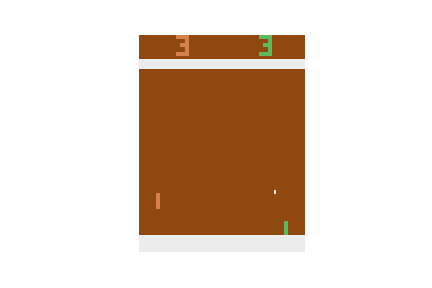
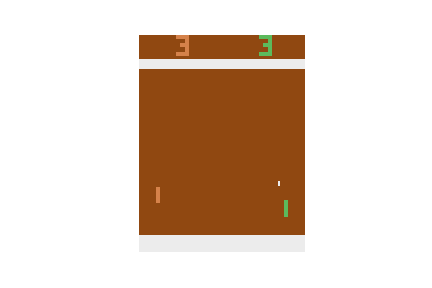
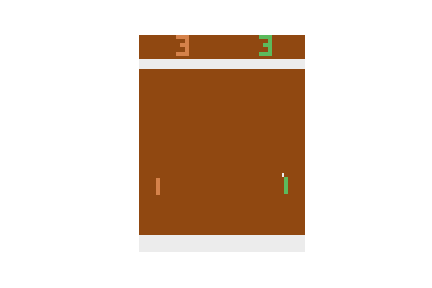
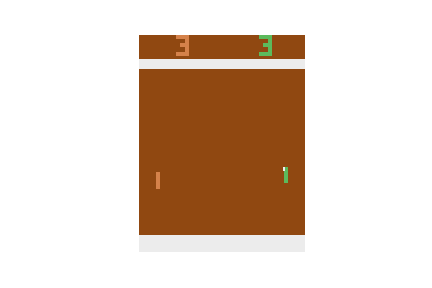
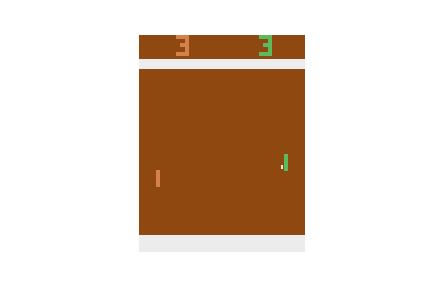
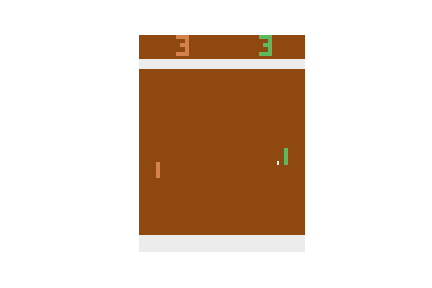
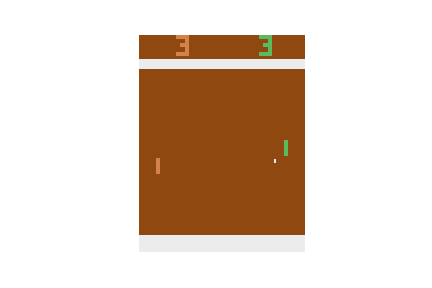
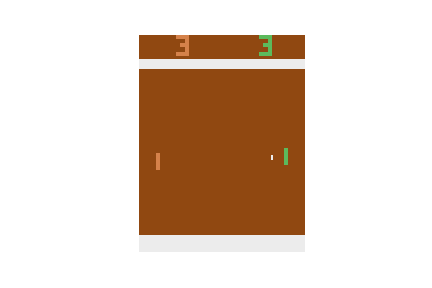
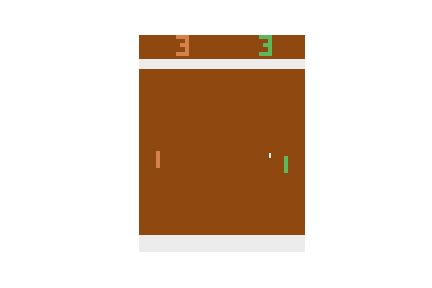
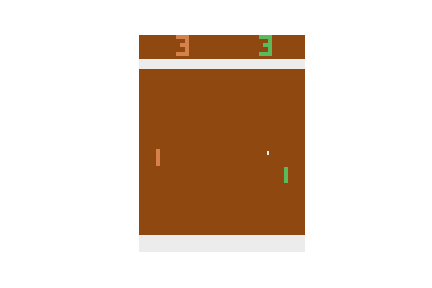
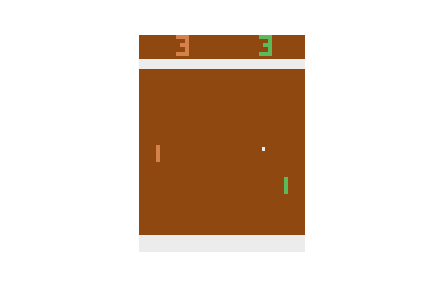
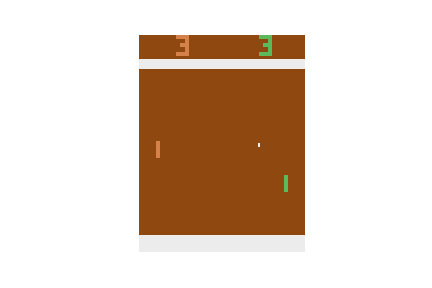
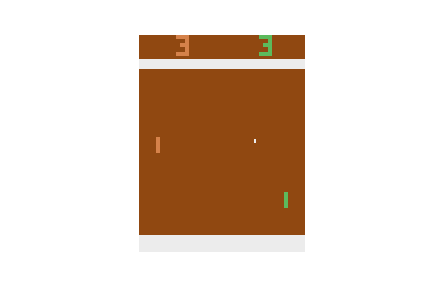
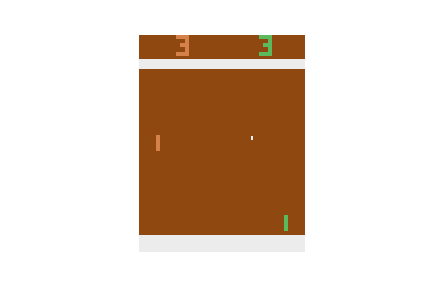
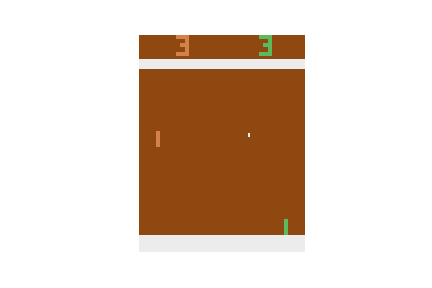
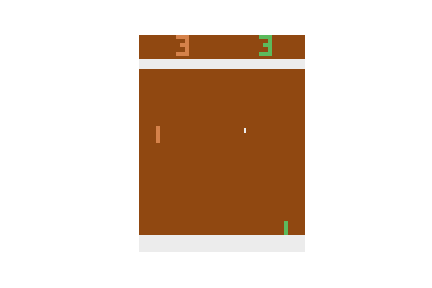
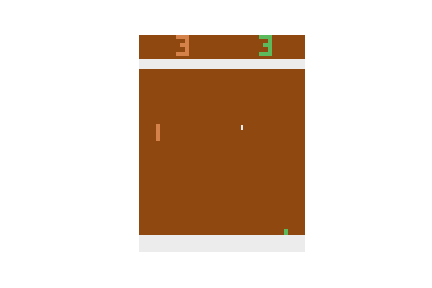
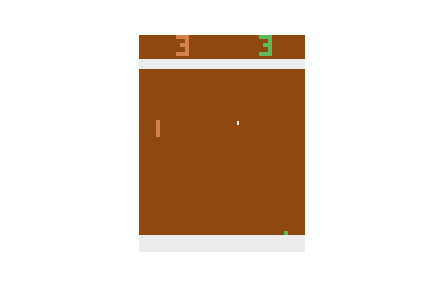
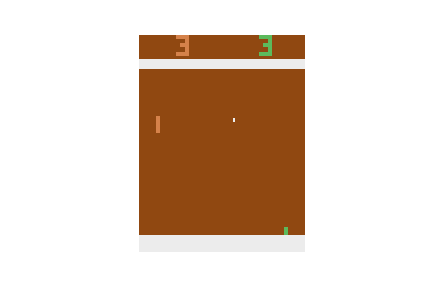
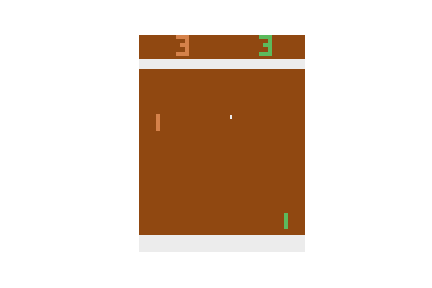
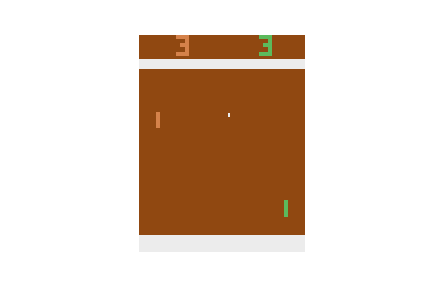
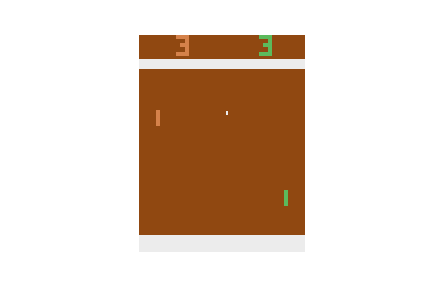
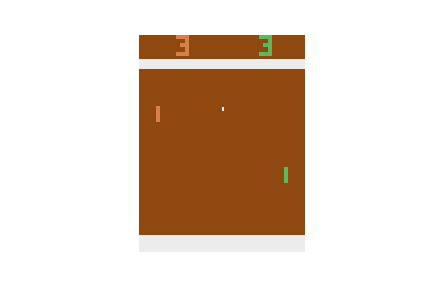
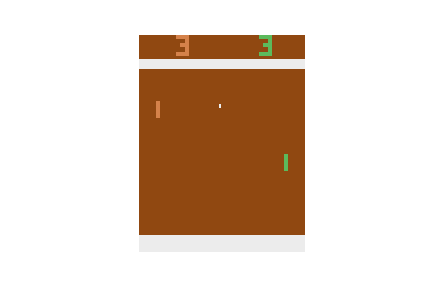
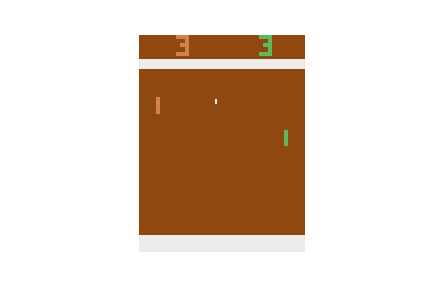
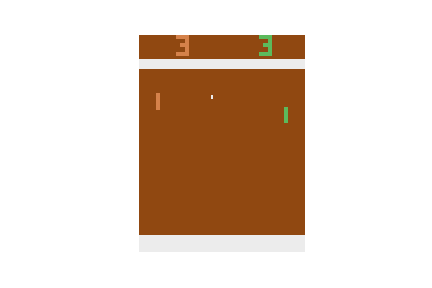
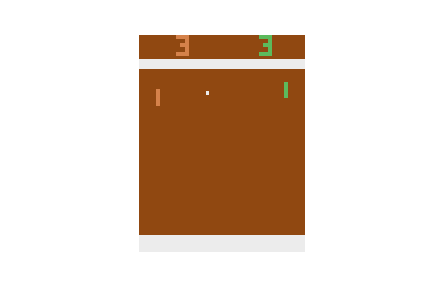
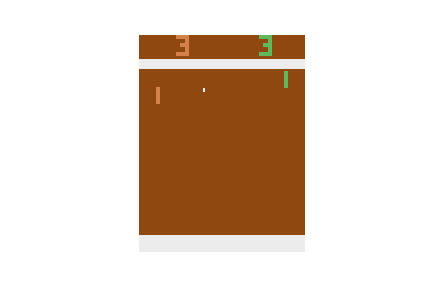
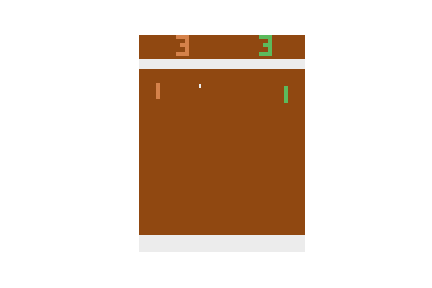
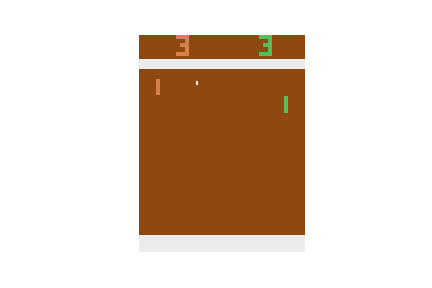
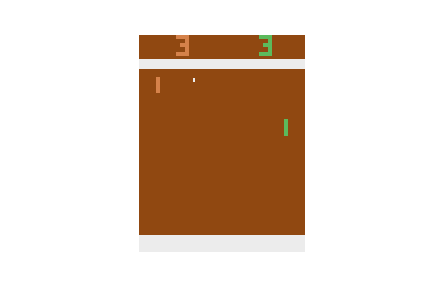
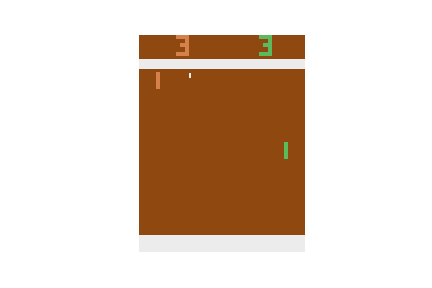
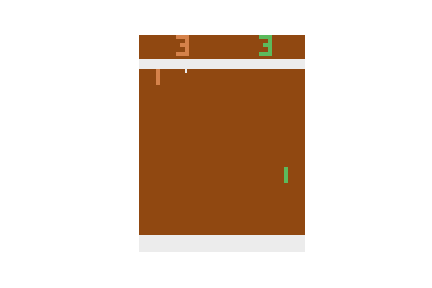
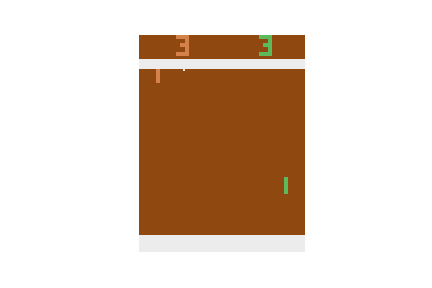
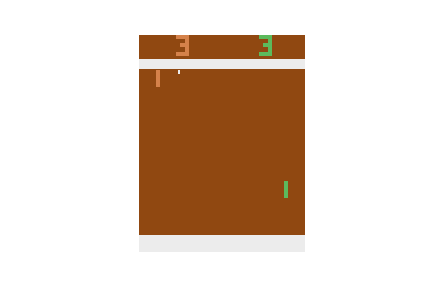
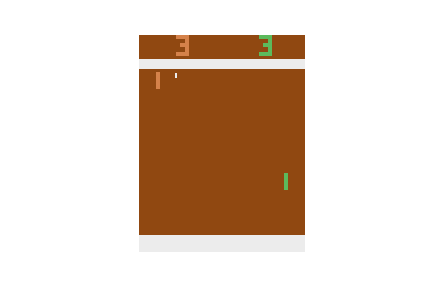
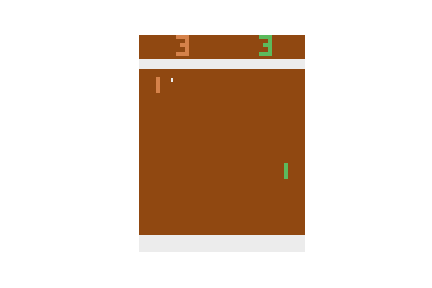
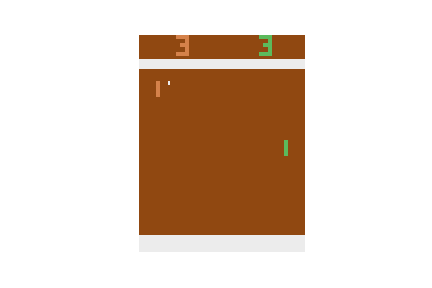
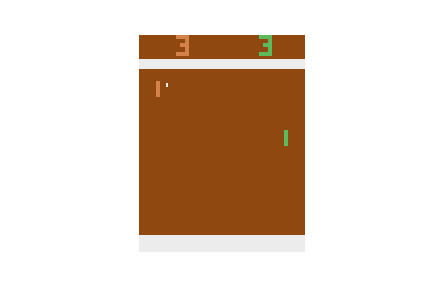
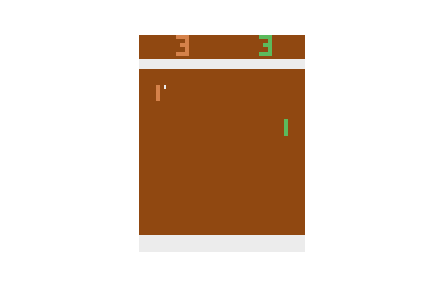
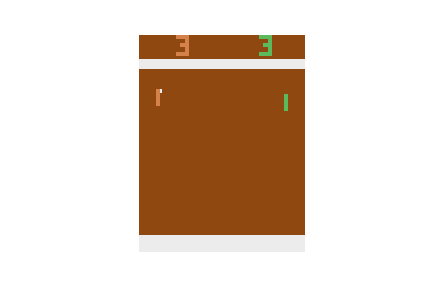
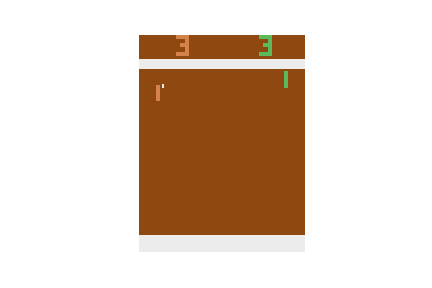
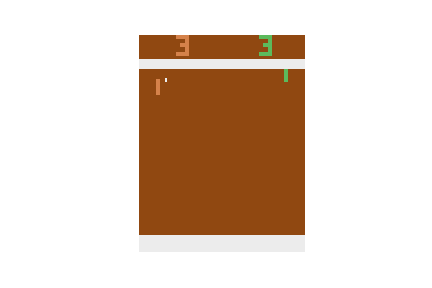
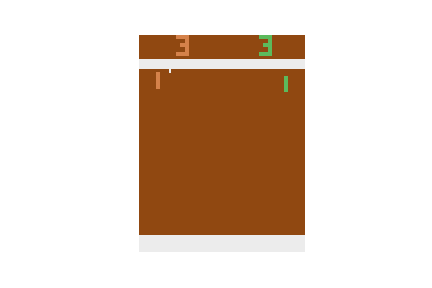
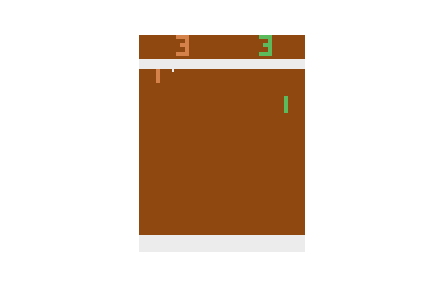
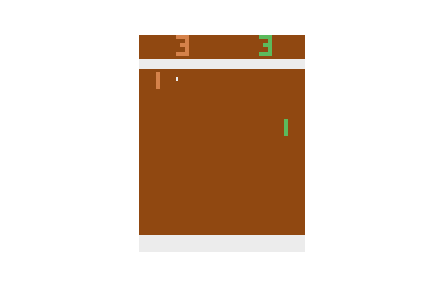
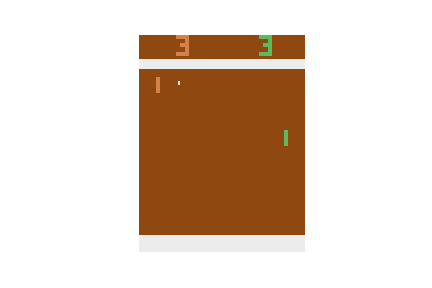
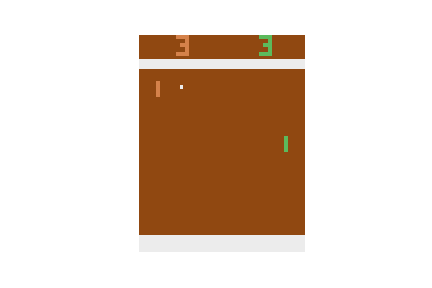
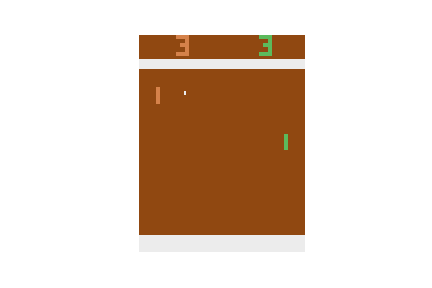
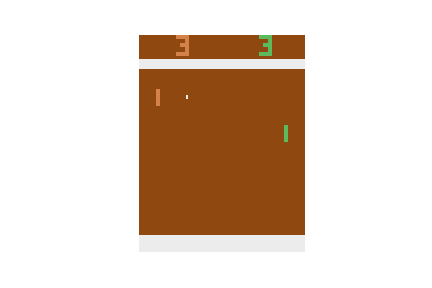
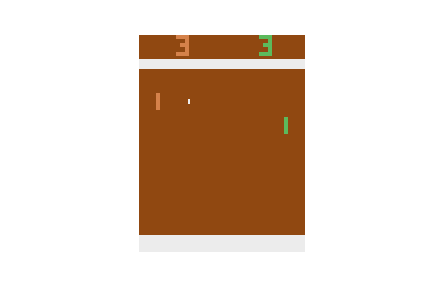
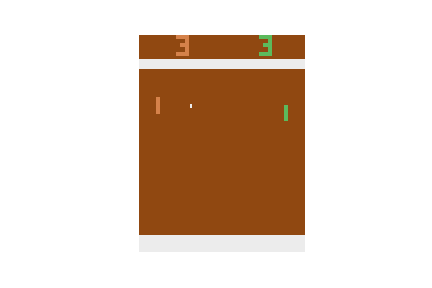
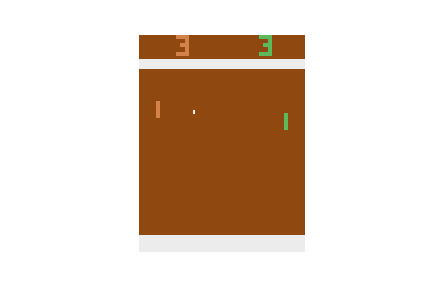
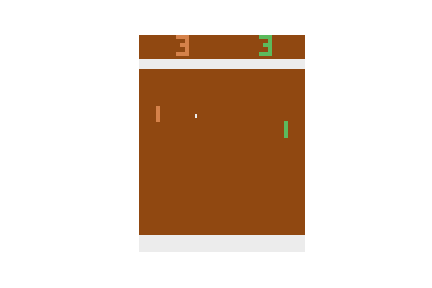
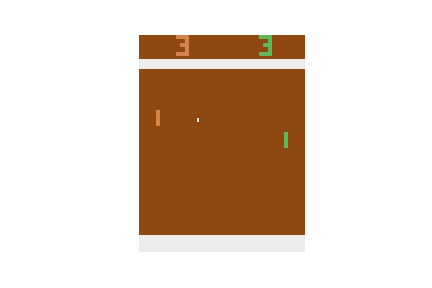
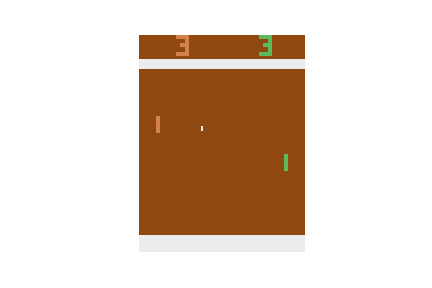
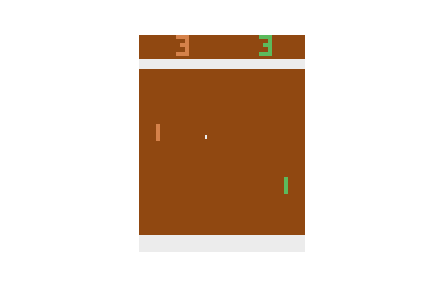
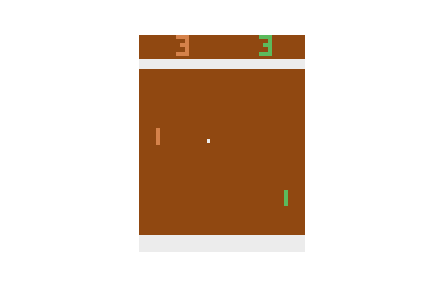
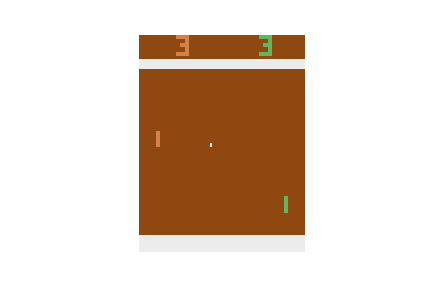
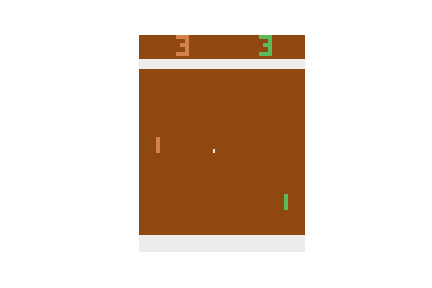
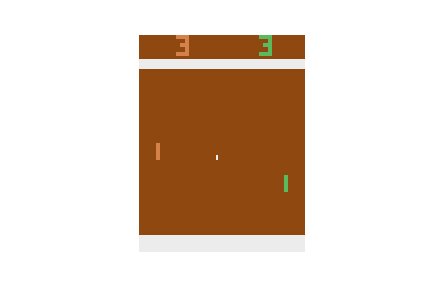
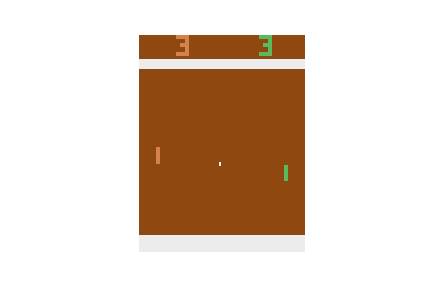
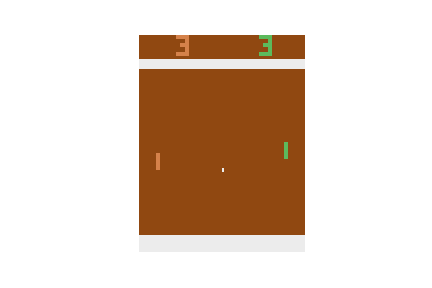
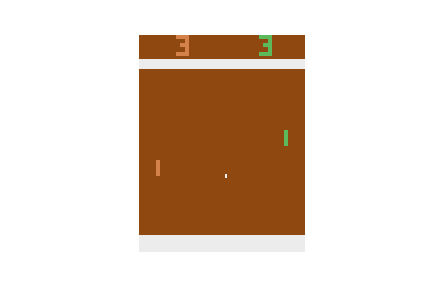
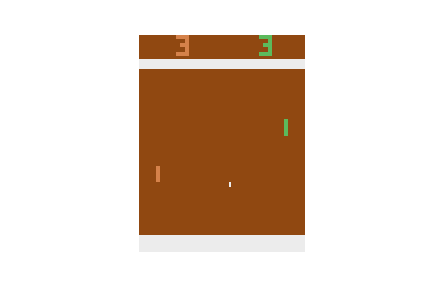
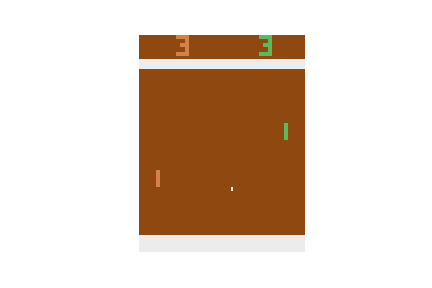
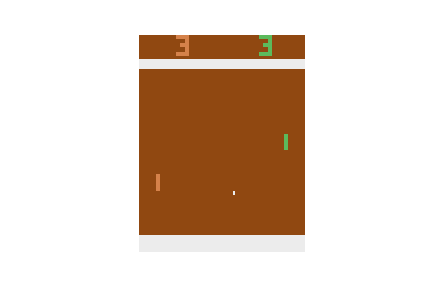
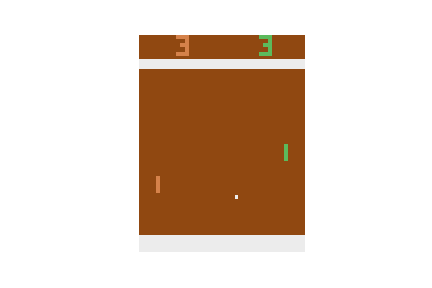
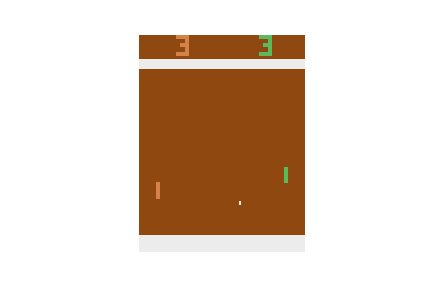
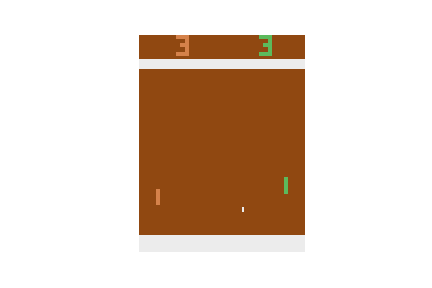
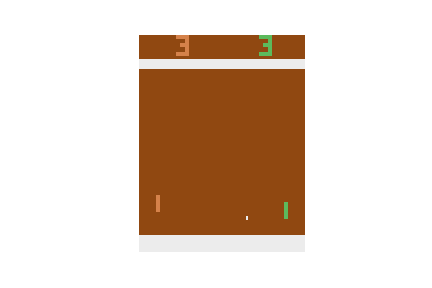
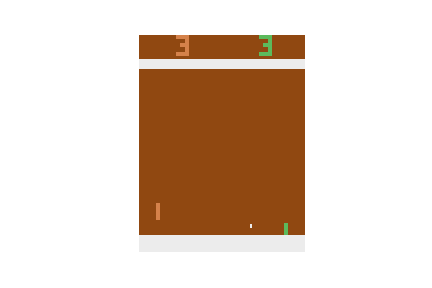
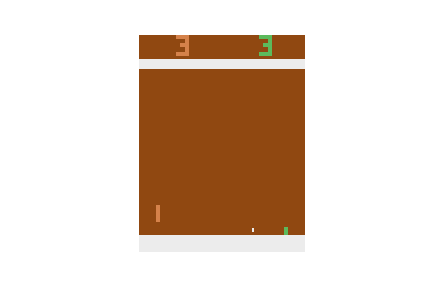
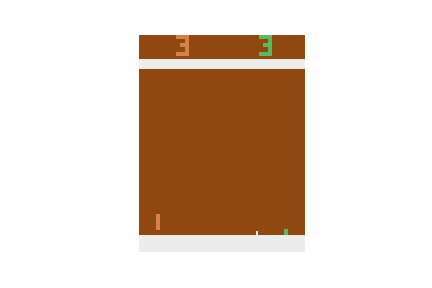
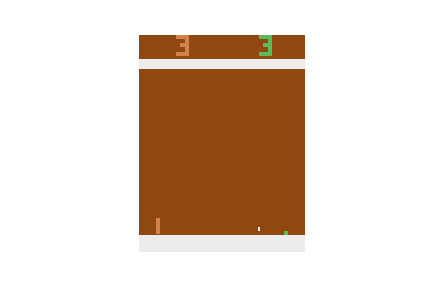
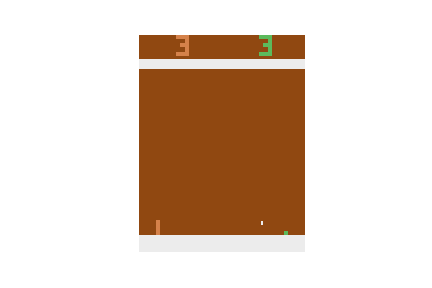
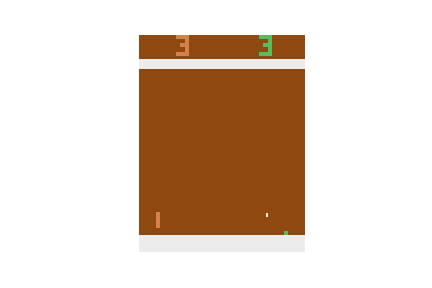
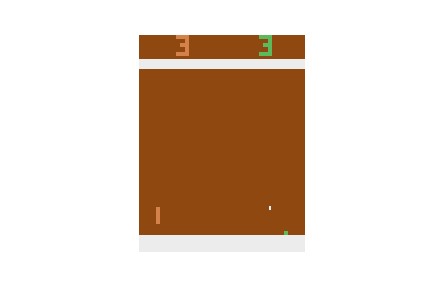
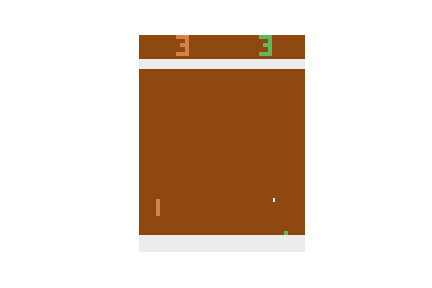
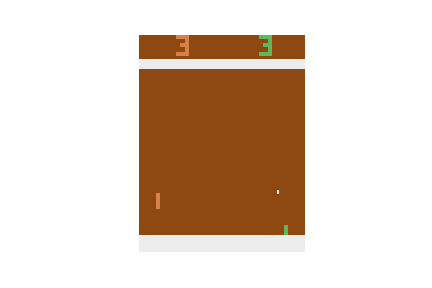
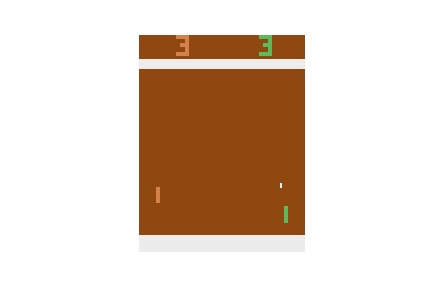
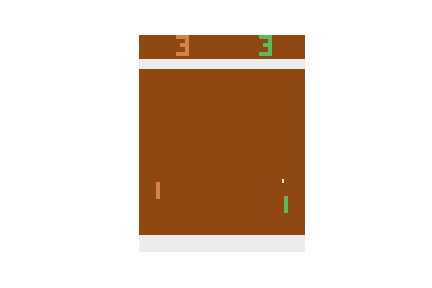
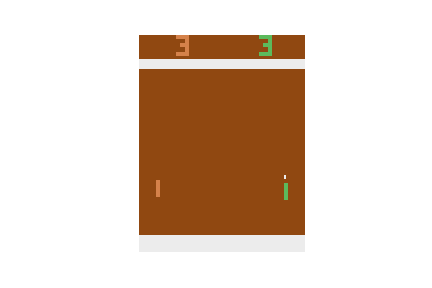
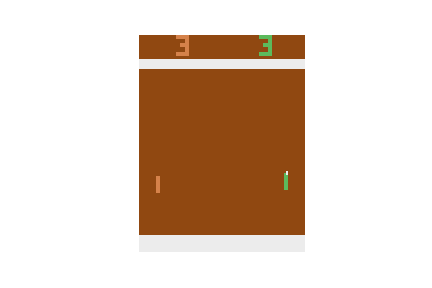
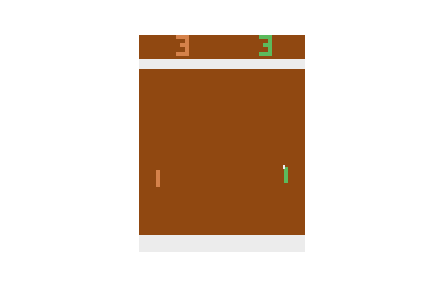
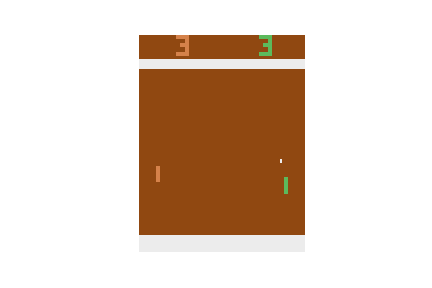
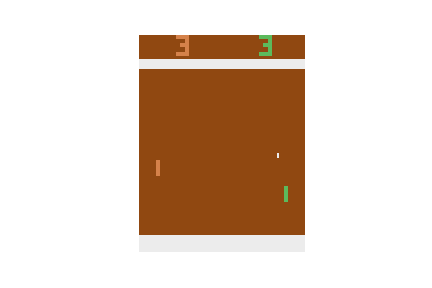
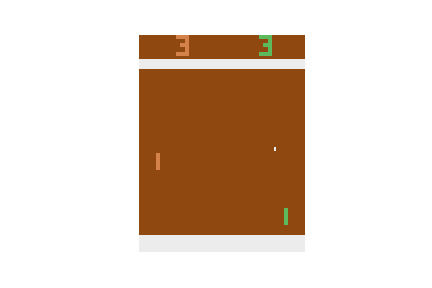
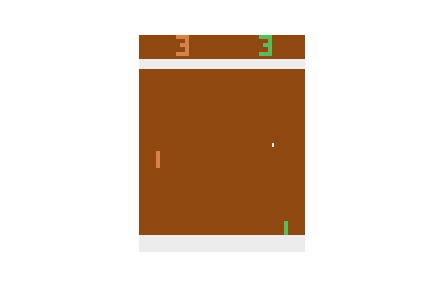
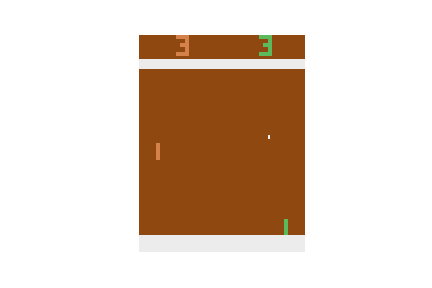
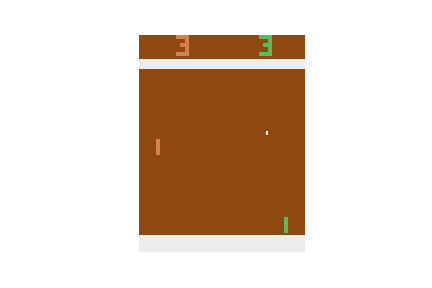
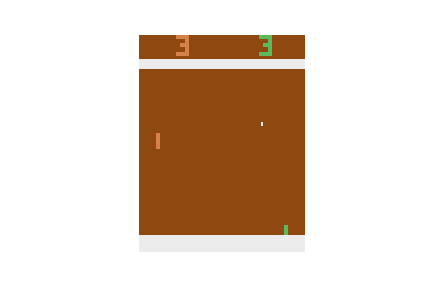
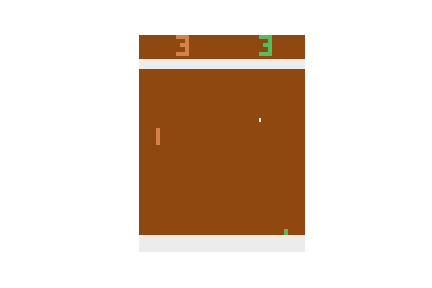
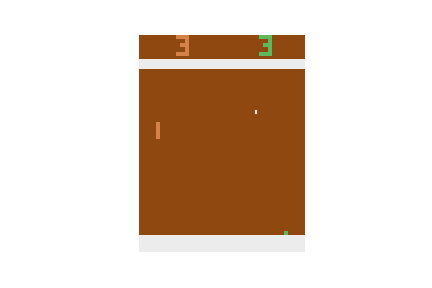
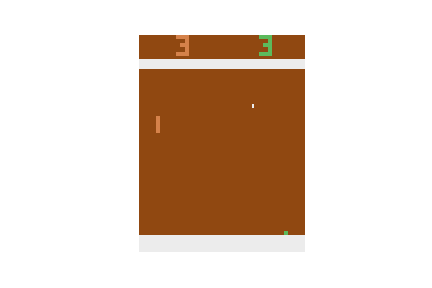
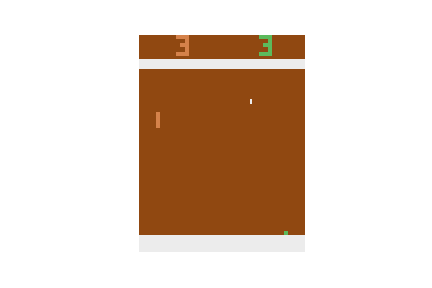
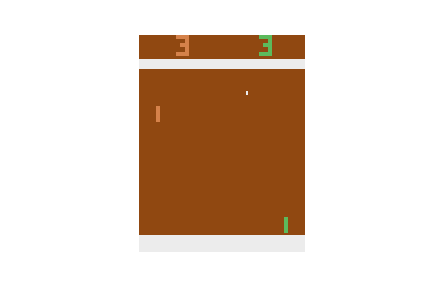
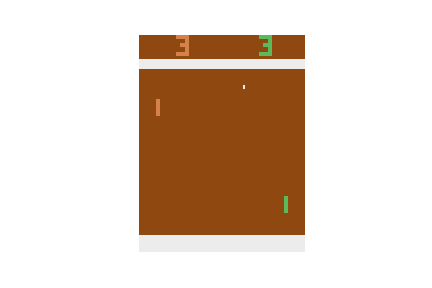
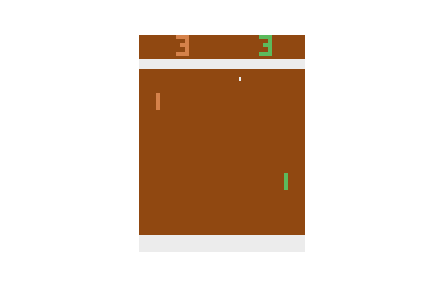
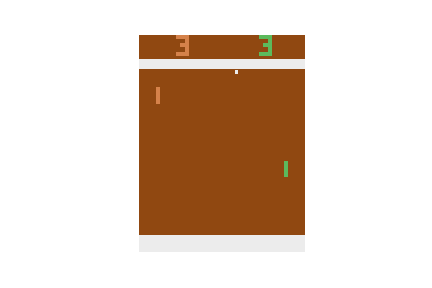
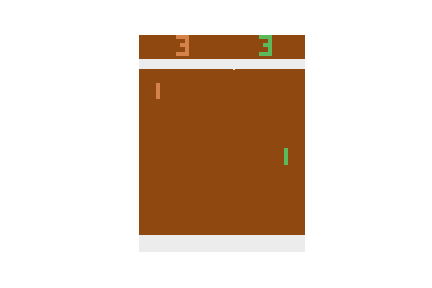
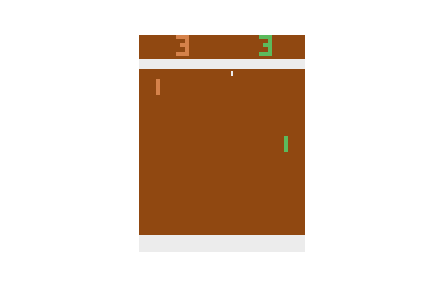
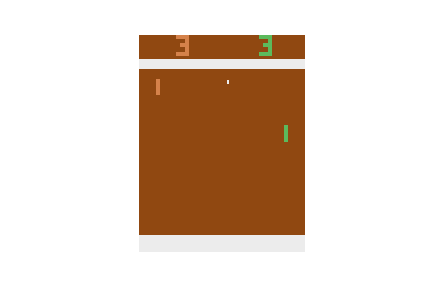
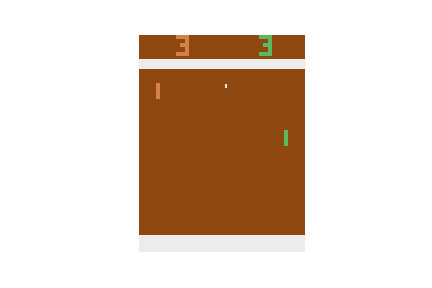
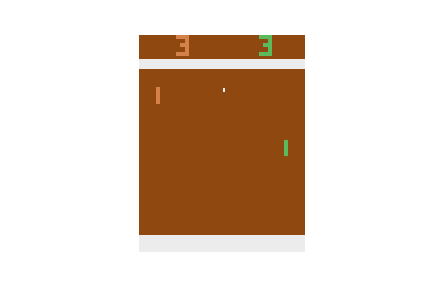
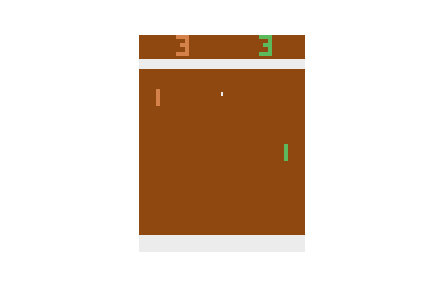
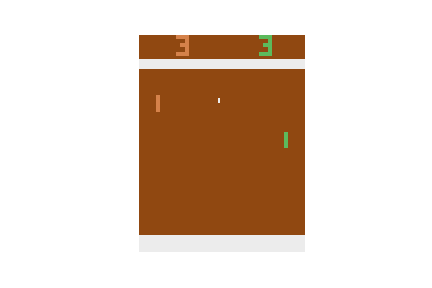
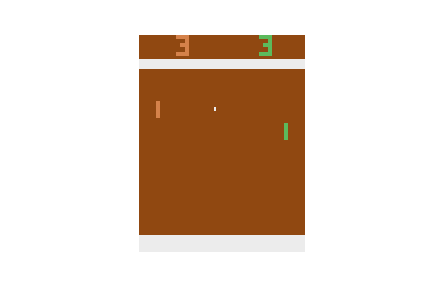
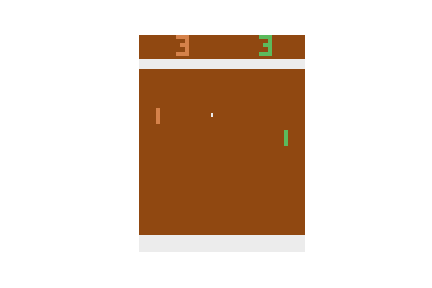
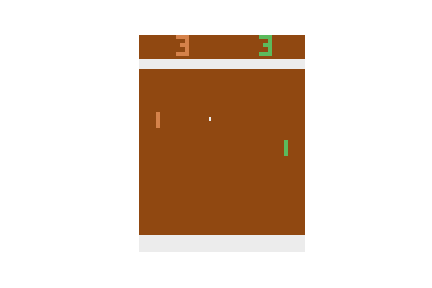
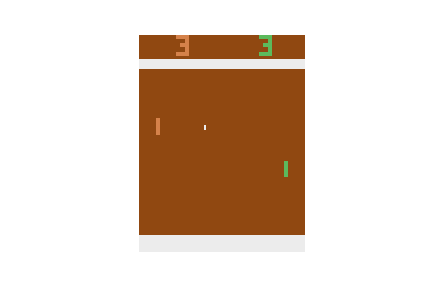
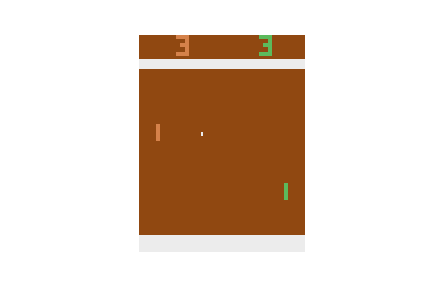
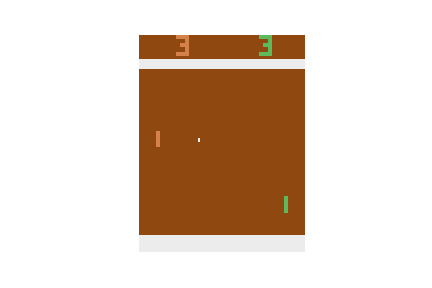
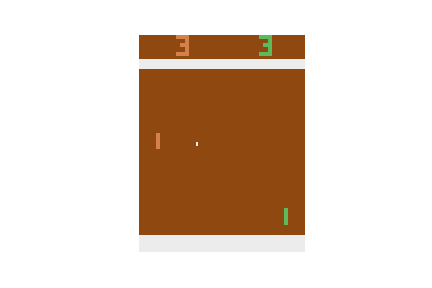
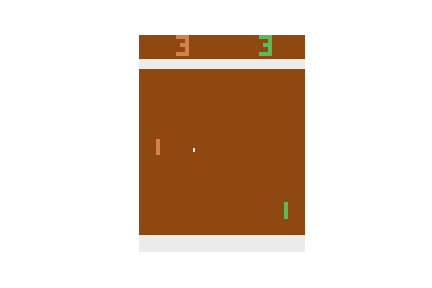
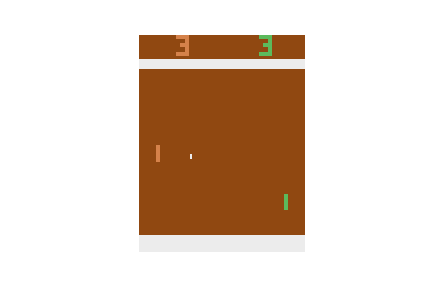
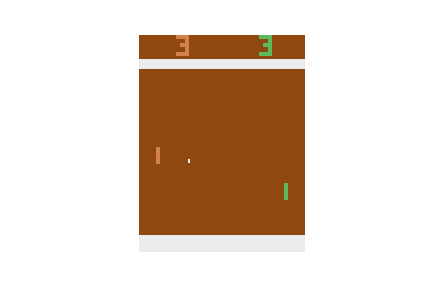
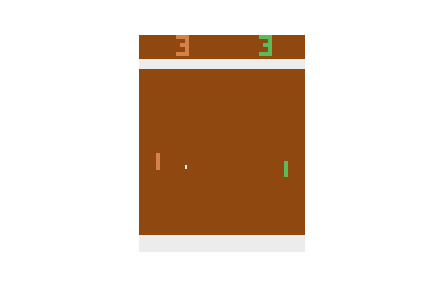
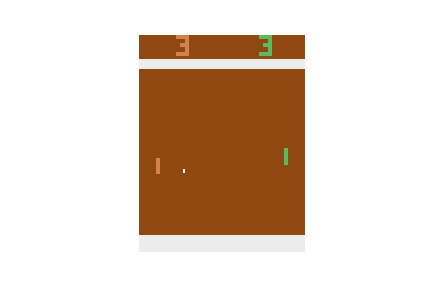
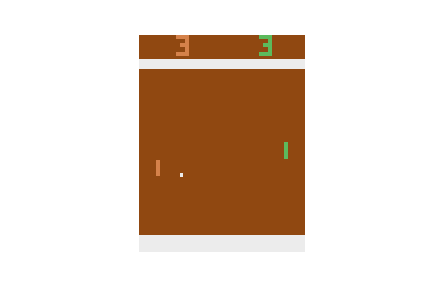
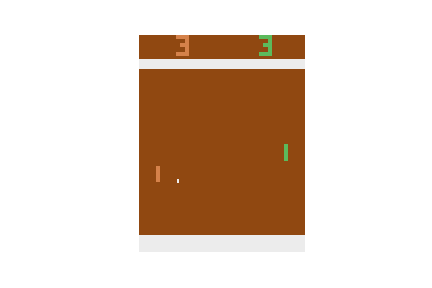
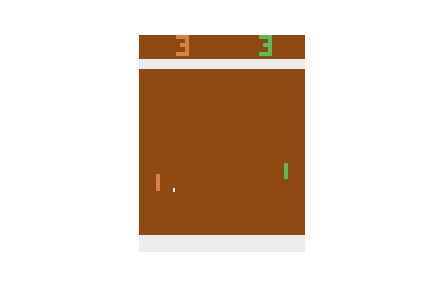
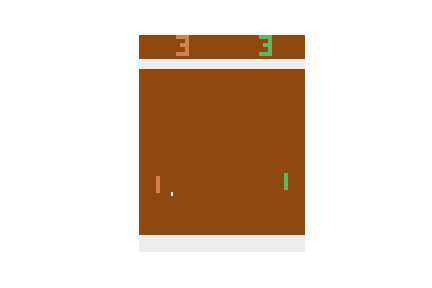
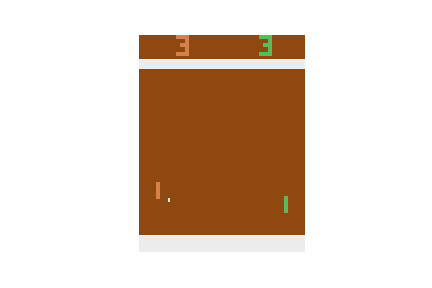
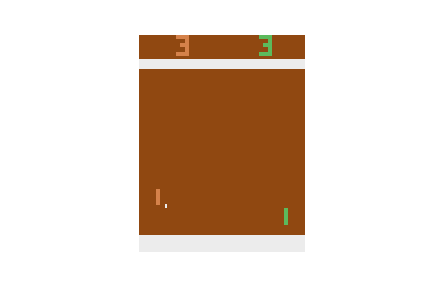
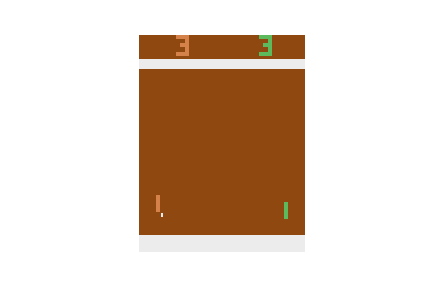
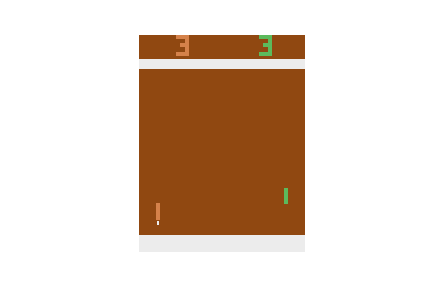
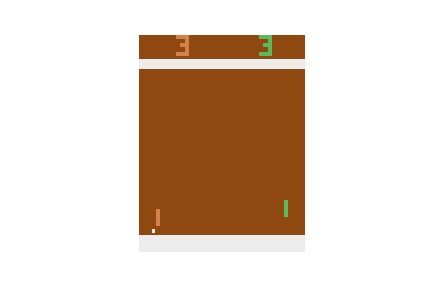
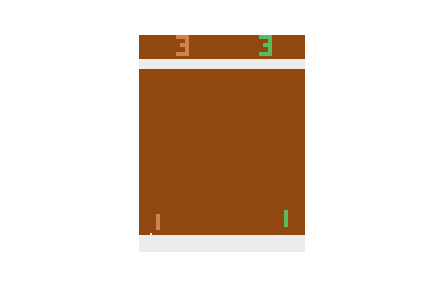
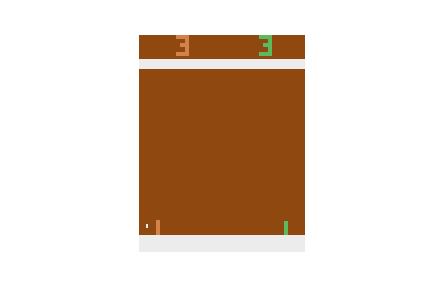
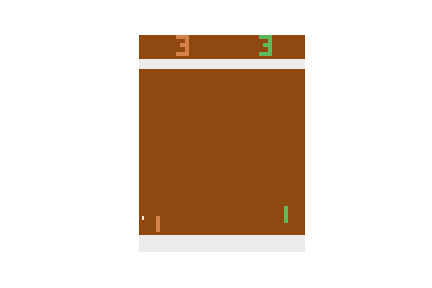
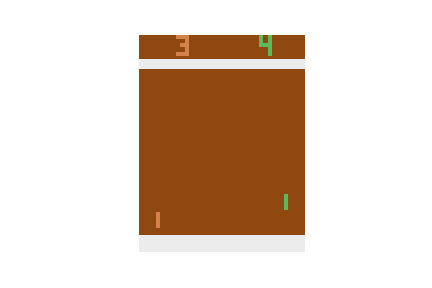
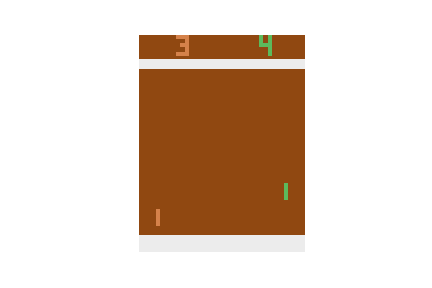
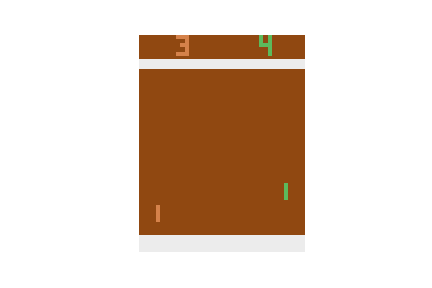
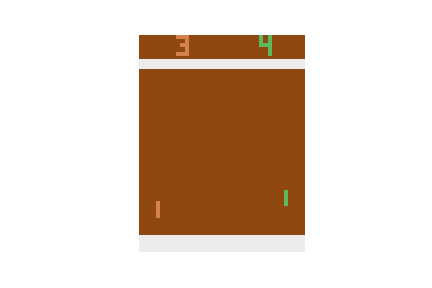
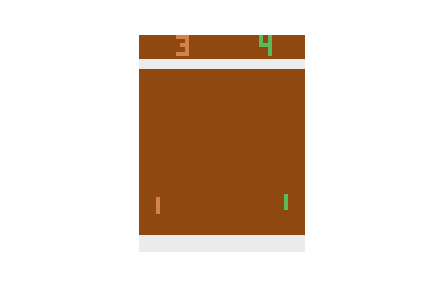
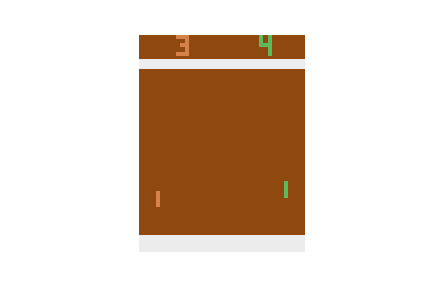
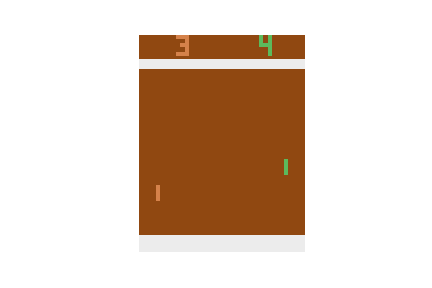
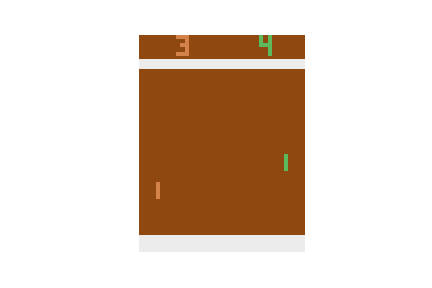
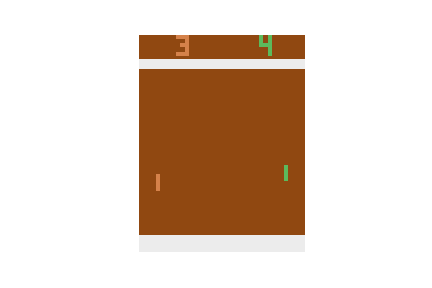
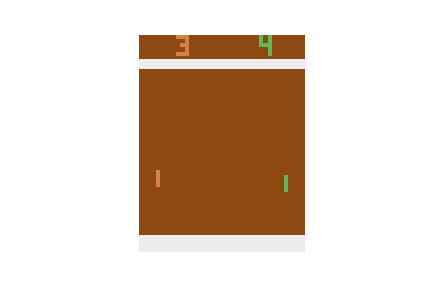
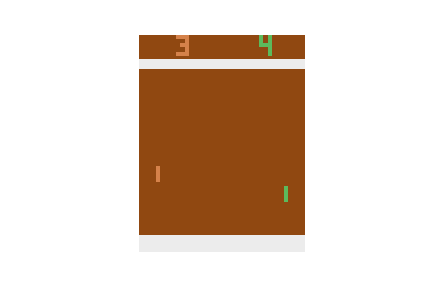
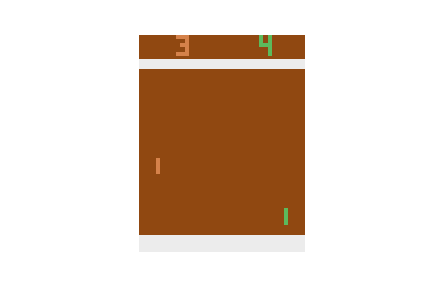
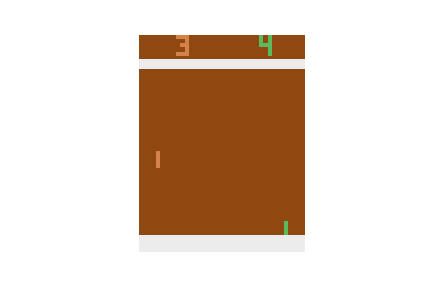
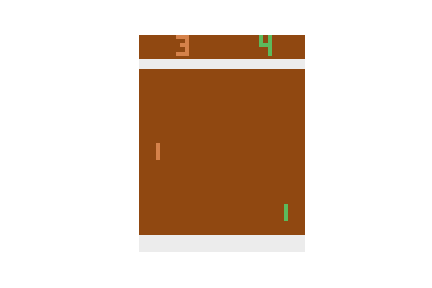
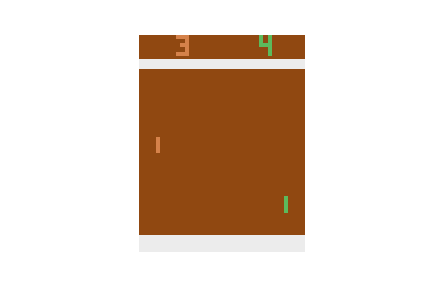
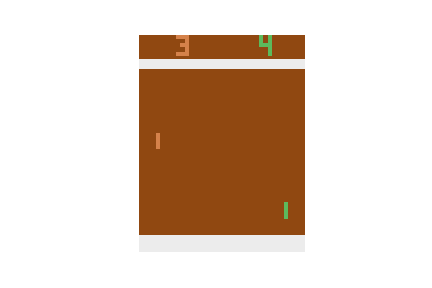
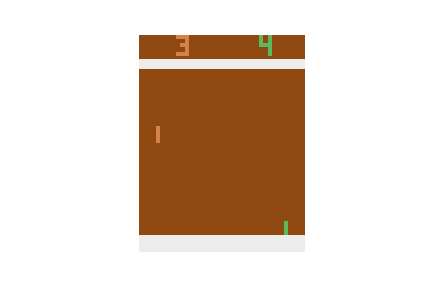
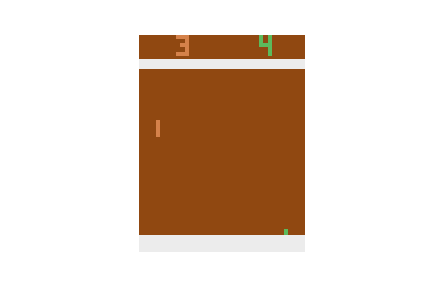
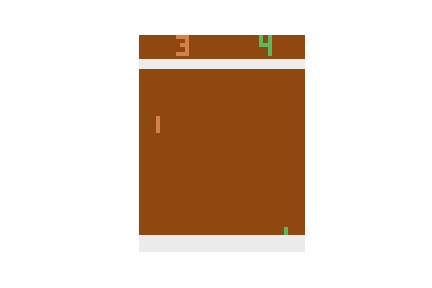
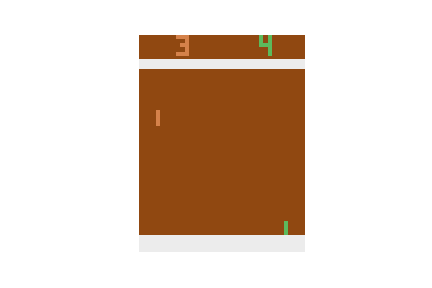
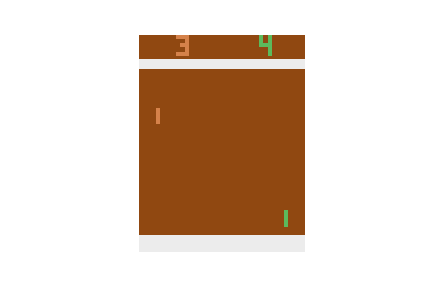
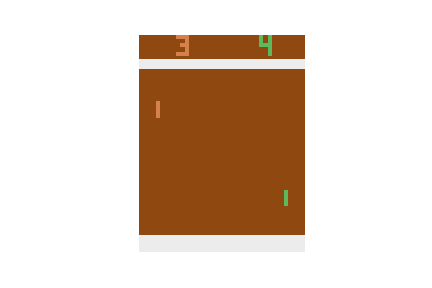
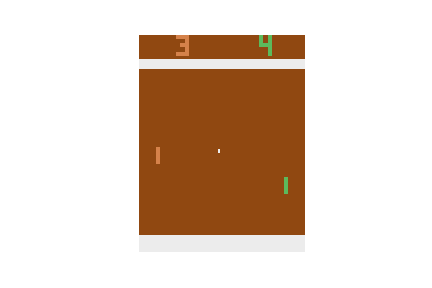
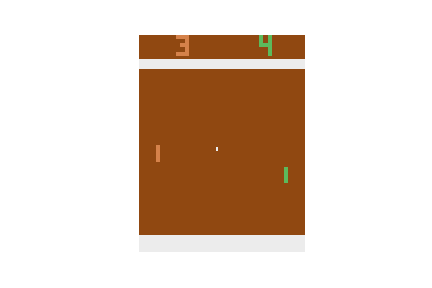
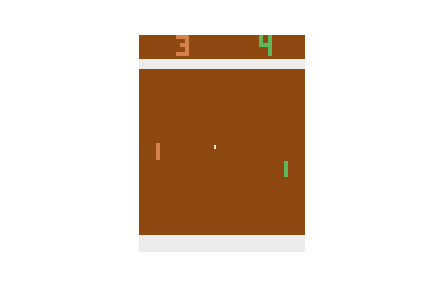
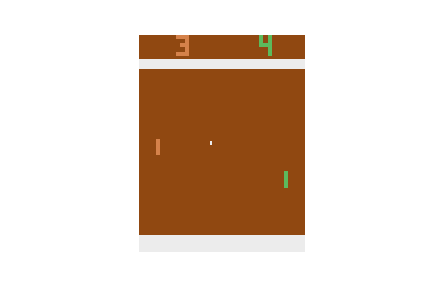
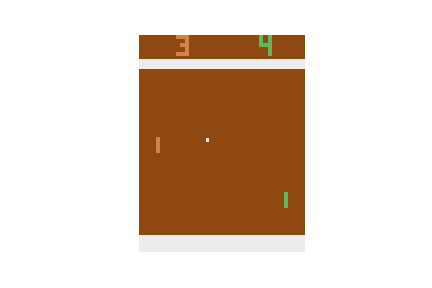
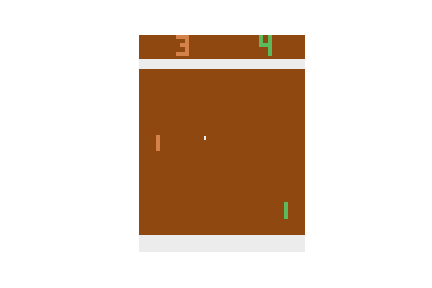
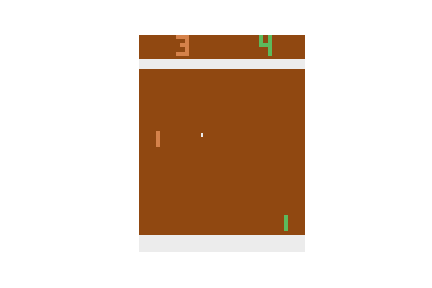
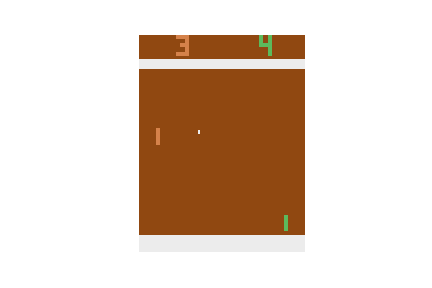
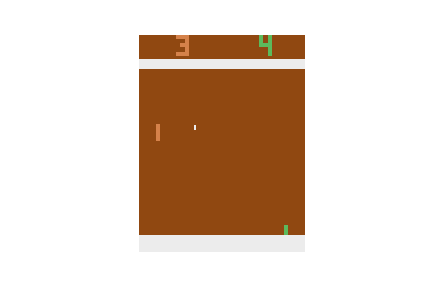
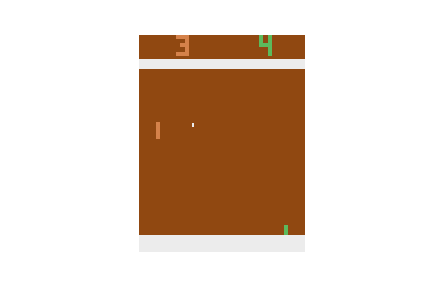
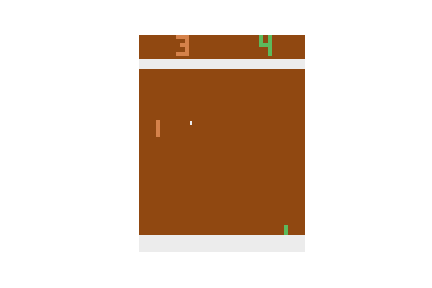
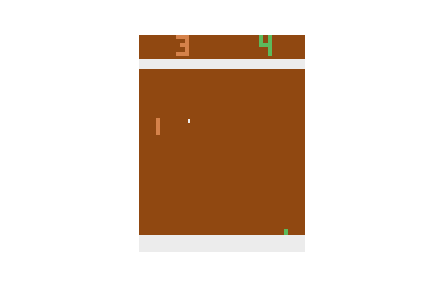
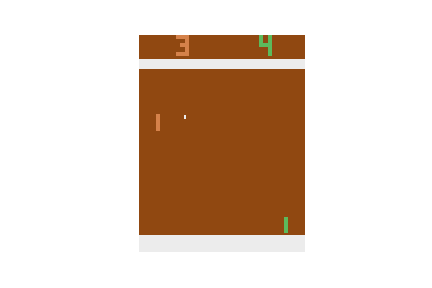
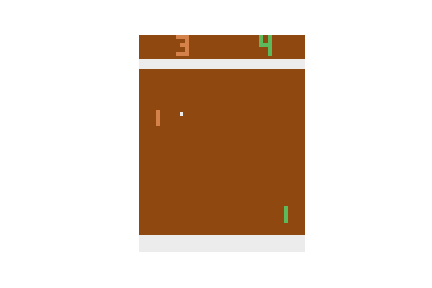
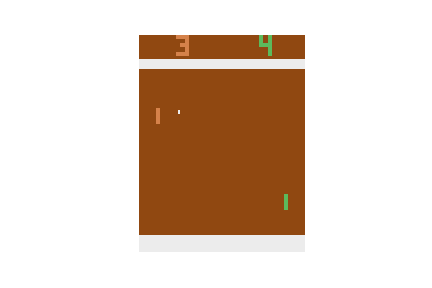
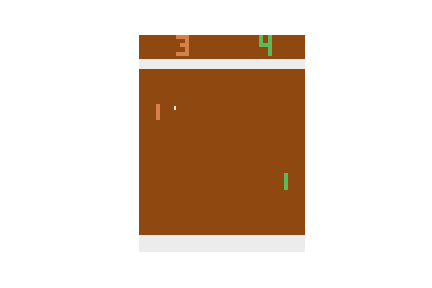
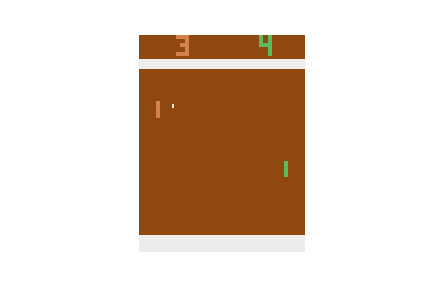
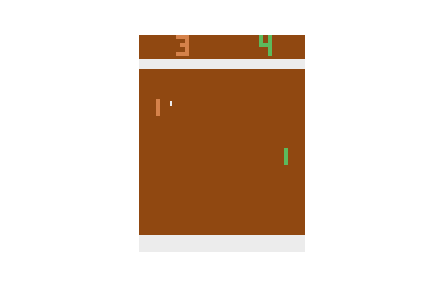
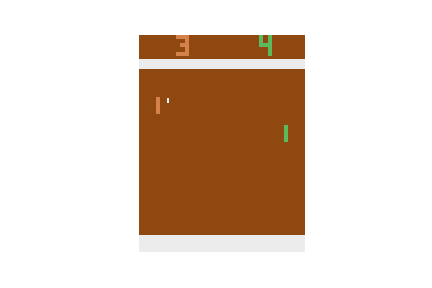
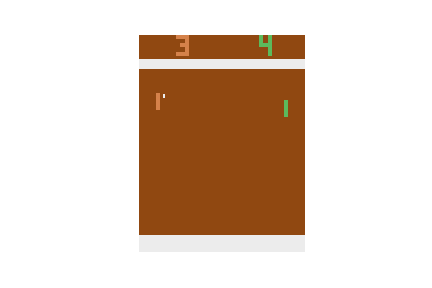
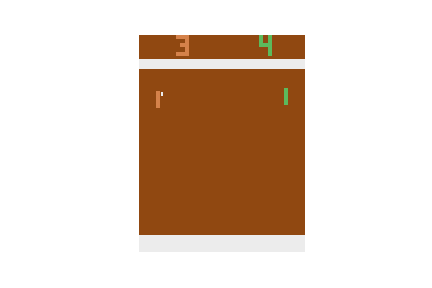
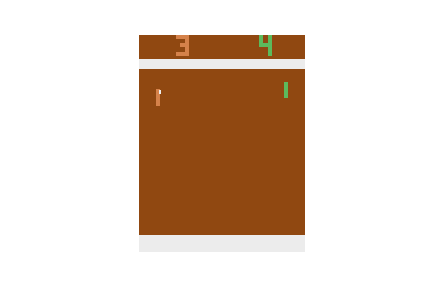
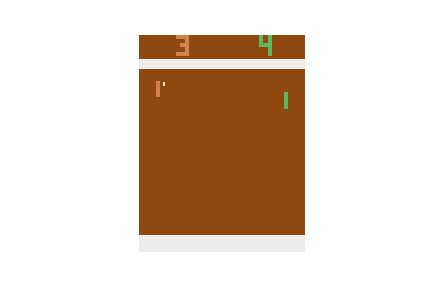
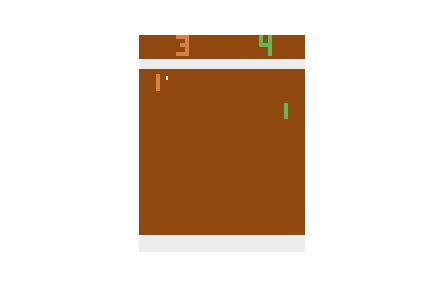
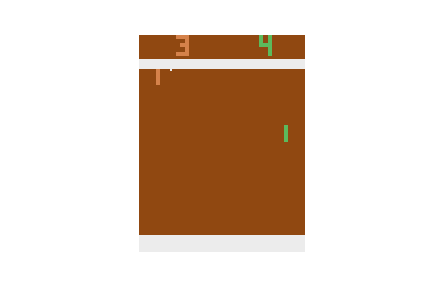
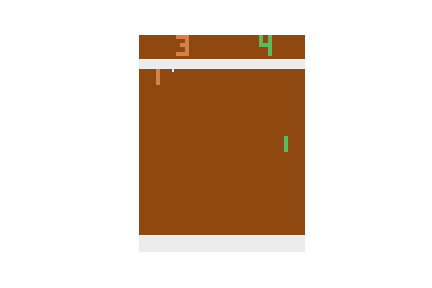
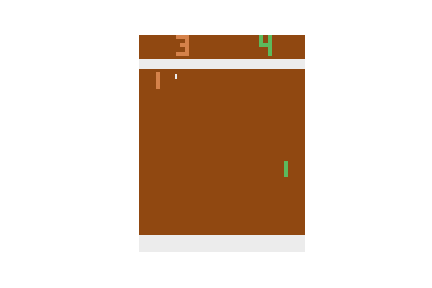
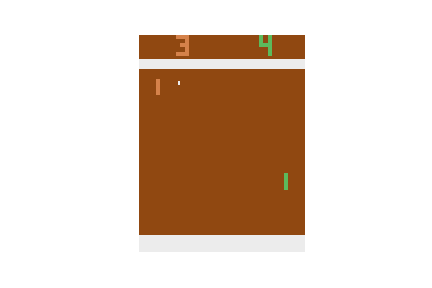
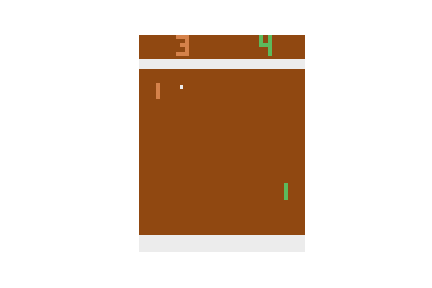
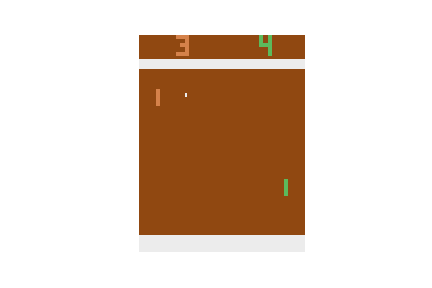
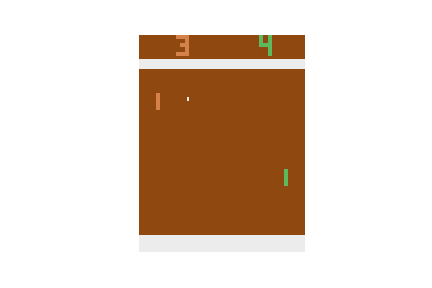
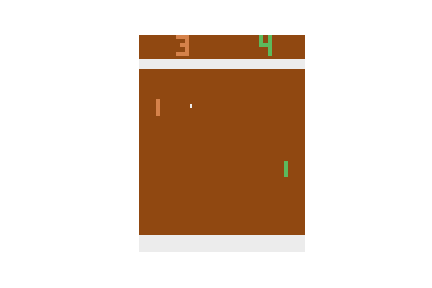
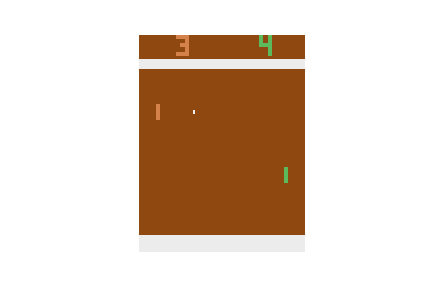
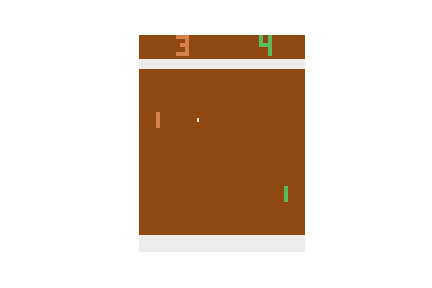
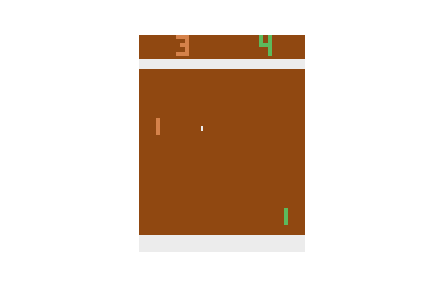
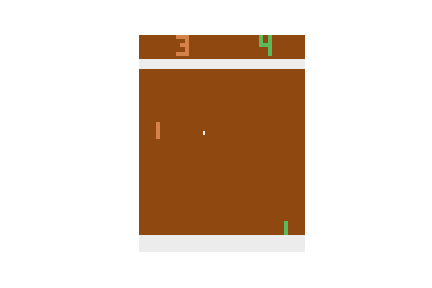
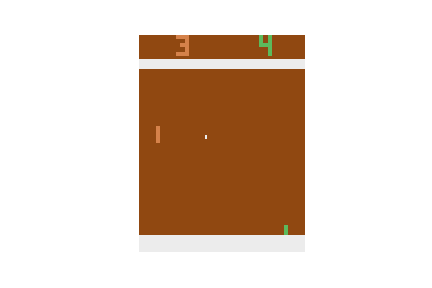
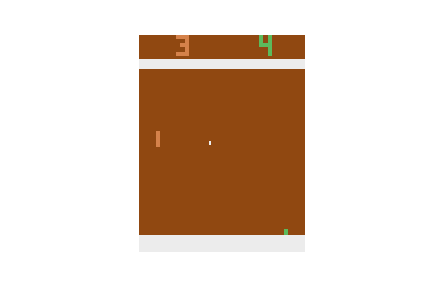
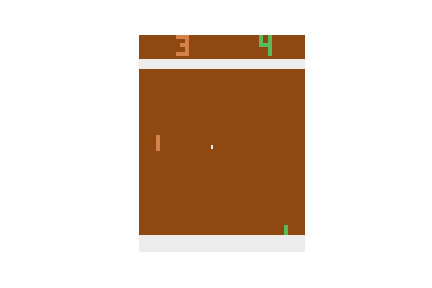
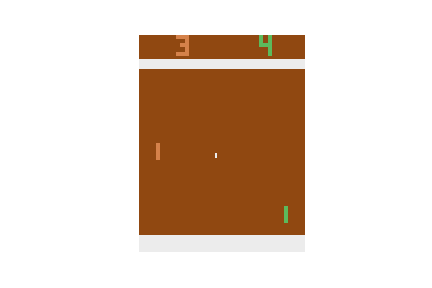
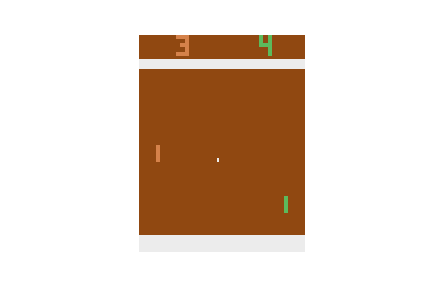
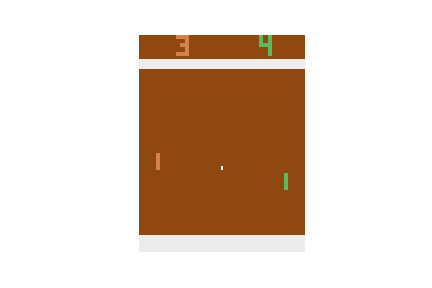
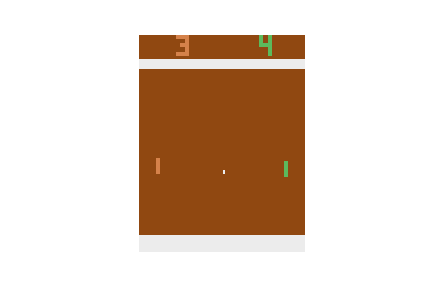
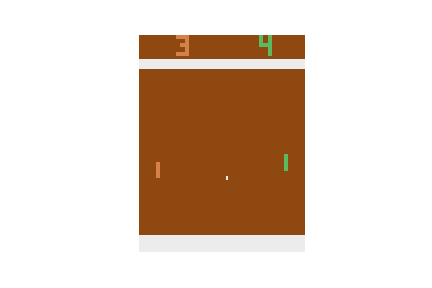
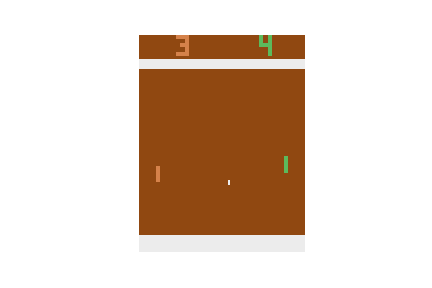
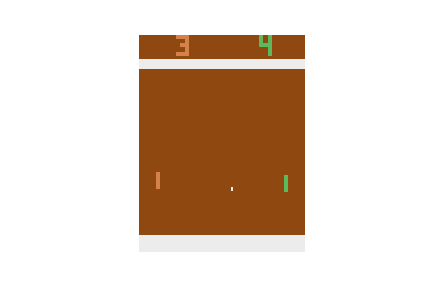
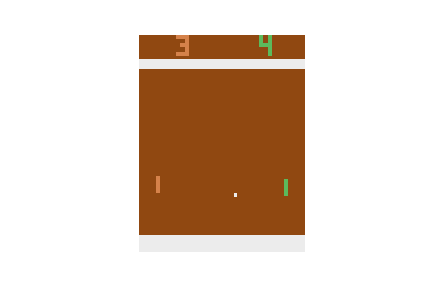
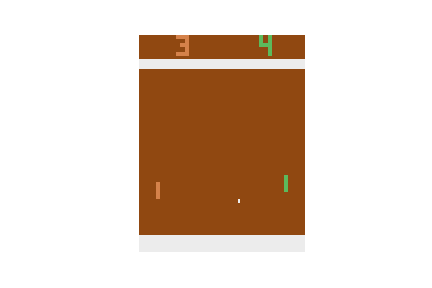
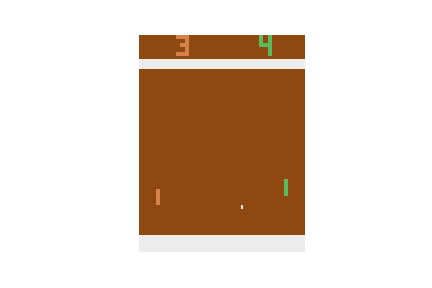
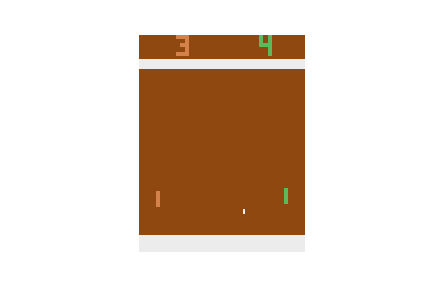
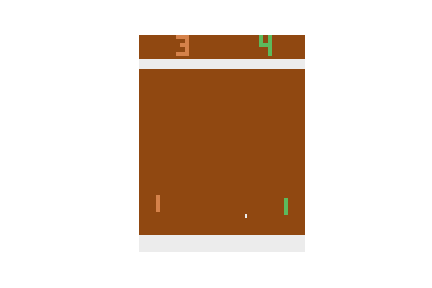
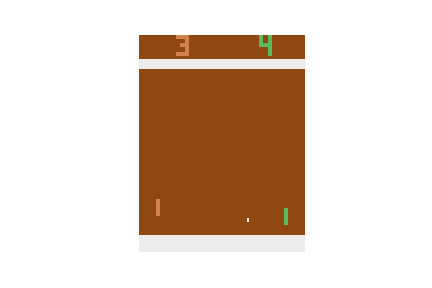
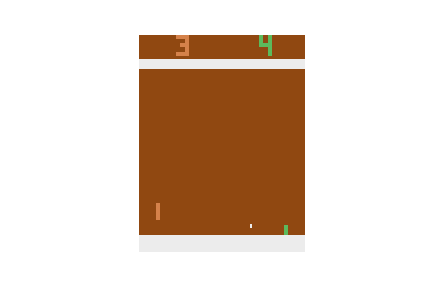
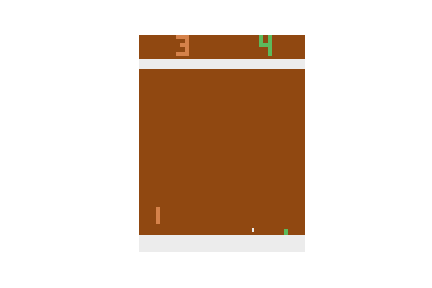
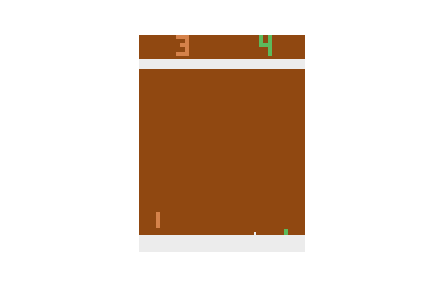
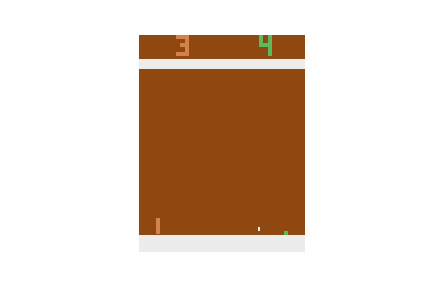
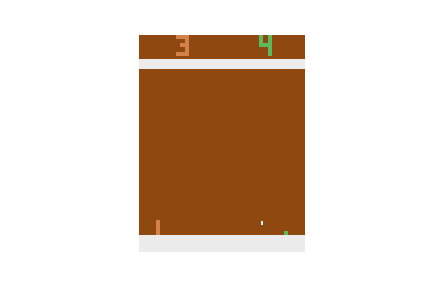
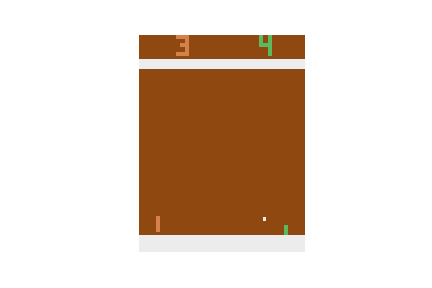
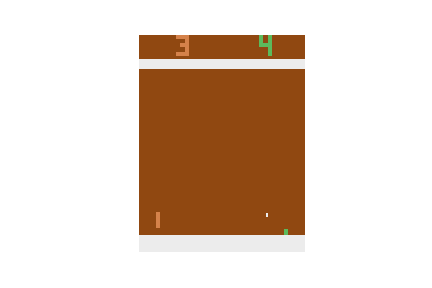
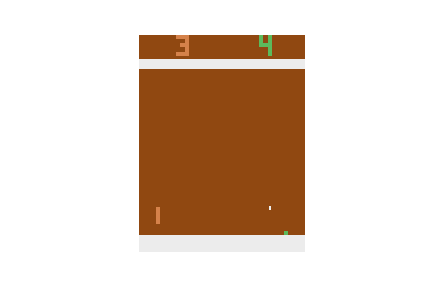
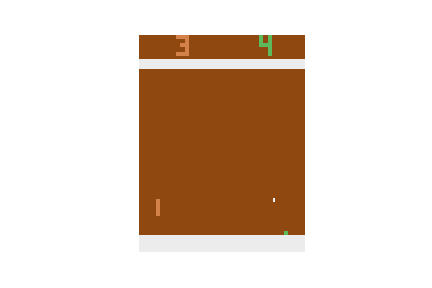
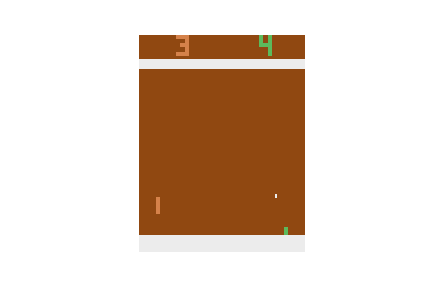
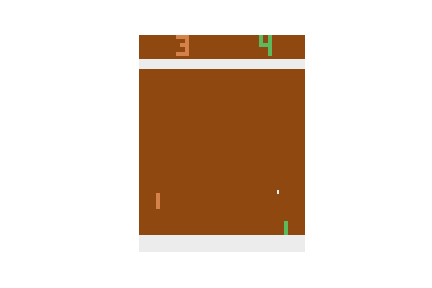
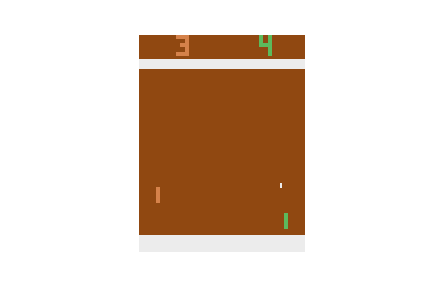
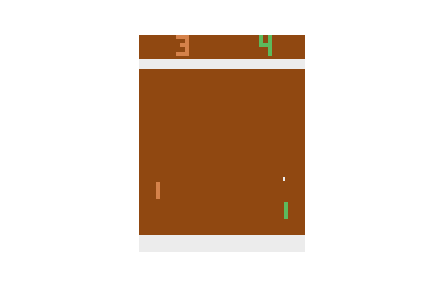
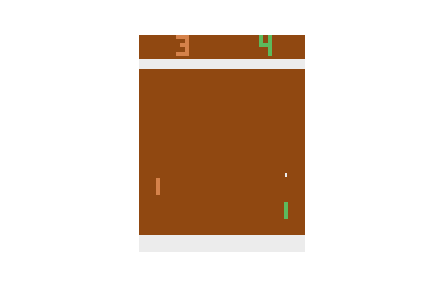
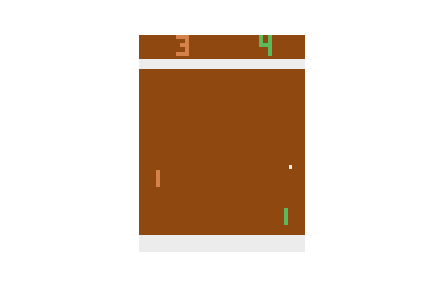
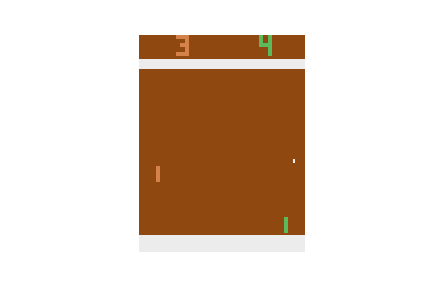
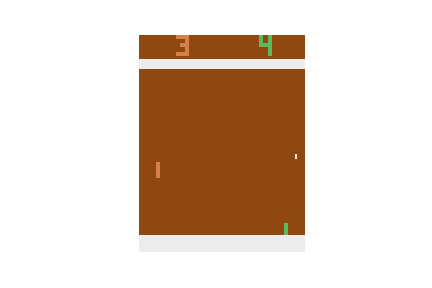
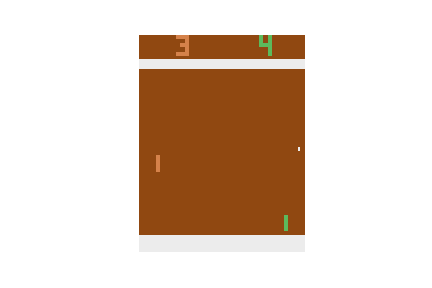
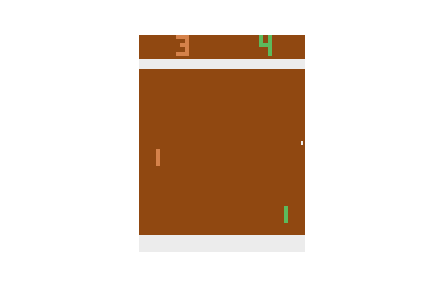
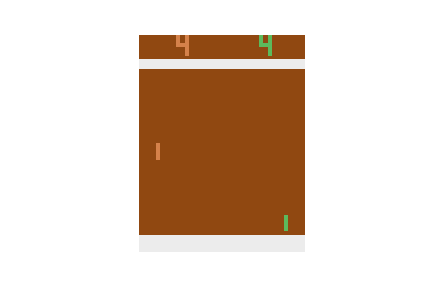
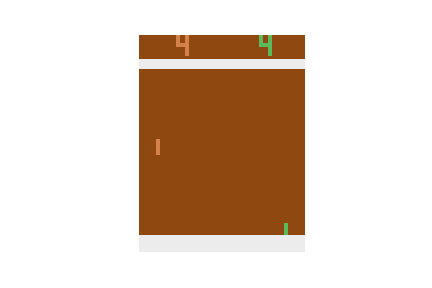
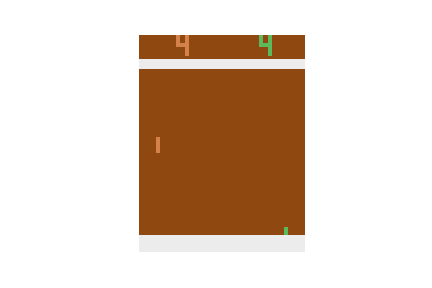
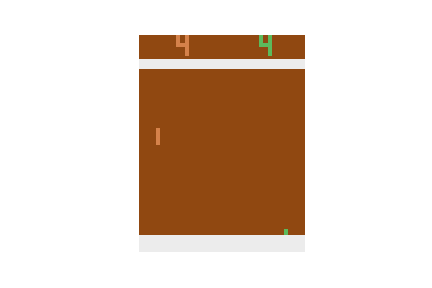
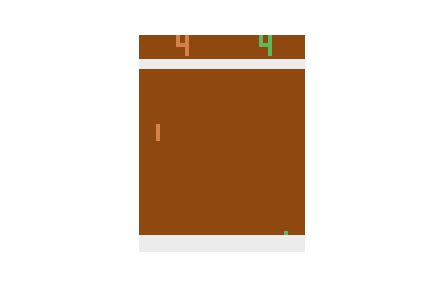
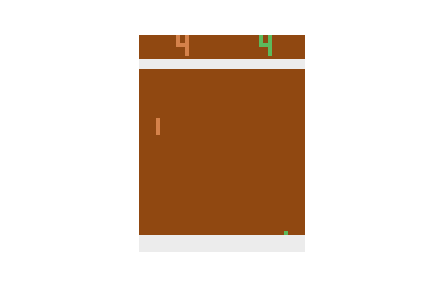
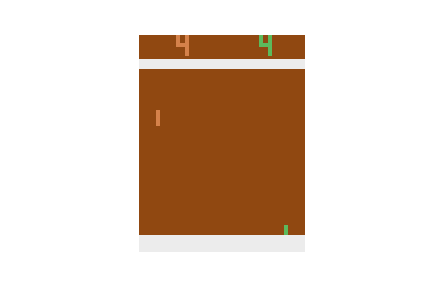
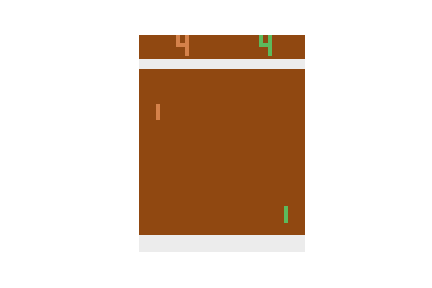
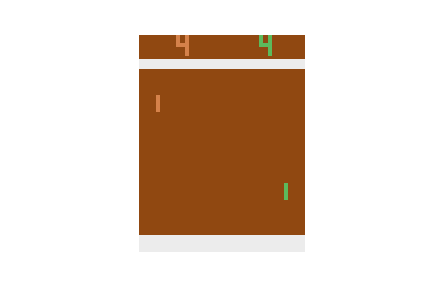
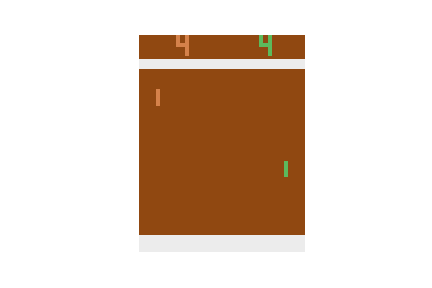
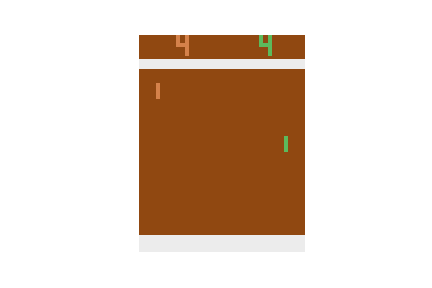
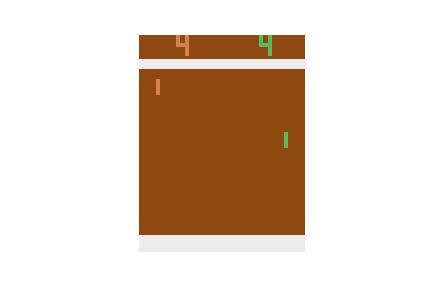
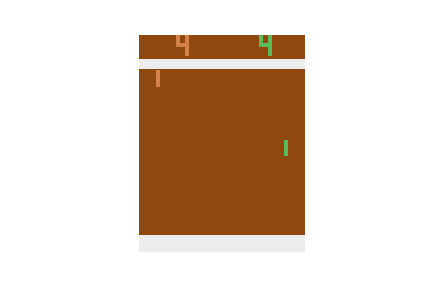
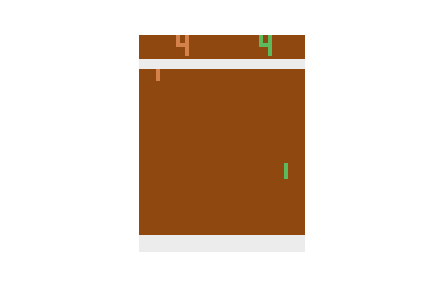
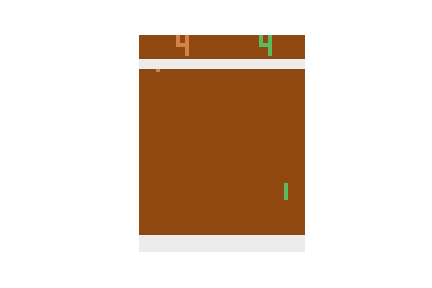
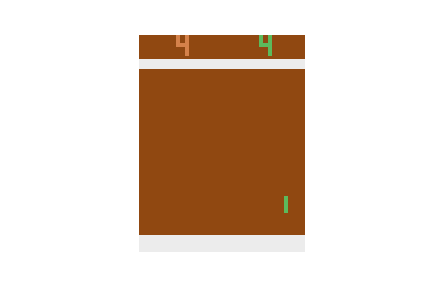
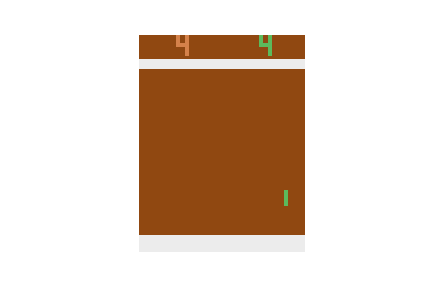
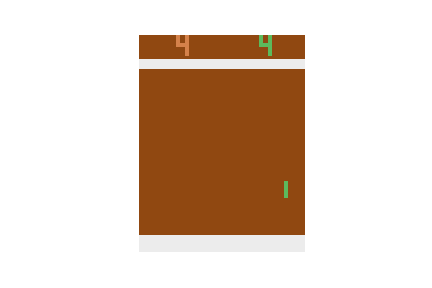

In [5]:
from src import test
from src import draw as dr

dr.display_frames(test.simulate_with_trained_policy(weights_filename='data/weights.cPickle', 
                                                    number_time_points=1000, 
                                                    render=False, 
                                                    random_seed=0))

## Going further

Others have written GPU-accelerated versions of the above. Sam Greydanus has written a [TensorFlow implementation](https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18), and here is a [MinPy implementation](http://minpy.readthedocs.io/en/latest/tutorial/rl_policy_gradient_tutorial/rl_policy_gradient.html). 

And of course one can go beyond the basic RL algorithm presented above. The leading [Pong-v0 evaluations](https://gym.openai.com/envs/Pong-v0/) use an exciting parallelization technique called [Asynchronous Advantage Actor-Critic (A3C)](https://arxiv.org/pdf/1602.01783.pdf) introduced by DeepMind in 2016. 








